# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


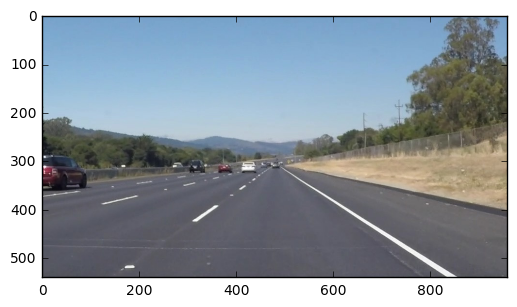

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [354]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    count_pos_slopes= 0 
    count_neg_slopes = 0
    sum_pos_slopes = 0
    sum_neg_slopes = 0
    max_left_x = img.shape
    max_right_x = 0
    min_left_x = 0
    min_right_x = 0
    
    sum_x1_right = 0
    sum_x2_right = 0
    sum_x1_left = 0
    sum_x2_left = 0
    
    max_y = img.shape[0]
    min_y = int(img.shape[0]/2) + 70
    
    print('x1  y1  x2  y2 slope b')
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            slope = ((y2-y1)/(x2-x1))
            b = y1 - slope*x1
            
            print(x1,y1,x2,y2, slope, b)
            if slope > 0.2 and slope < 2: #-ve slope, right segment
                count_pos_slopes += 1
                sum_pos_slopes += slope
                sum_x1_right += x1
                sum_x2_right += x2
                
                y1 = max_y
                x1 = int((y1 - b)/slope)
                y2 = min_y
                x2 = int((y2 - b)/slope)
                
            elif slope < -0.2 and slope > -2:                      #+ve slope, left segment
                count_neg_slopes += 1
                sum_neg_slopes += slope
                sum_x1_left += x1
                sum_x2_left += x2
                
                y1 = max_y
                #print(slope)
                x1 = int((y1 - b)/slope)
                y2 = min_y
                x2 = int((y2 - b)/slope)
                
                
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#     ave_slope_right = sum_pos_slopes/count_pos_slopes
#     print('ave_slope_right')
#     print(ave_slope_right)
#     ave_slope_left = sum_neg_slopes/count_neg_slopes
#     print('ave_slope_left')
#     print(ave_slope_left)
    
#     ave_x1_left = sum_x1_left/count_neg_slopes  
#     print('ave_x1_left')
#     print(ave_x1_left)
#     ave_x1_right = sum_x1_right/count_pos_slopes
#     print('ave_x1_right')
#     print(ave_x1_right)
    
#     b_right = max_y - ave_slope_right*ave_x1_right
#     print('b_right')
#     print(b_right)
#     b_left = max_y - ave_slope_left*ave_x1_left
#     print('b_left')
#     print(b_left)
    
#     y1 = max_y
#     y2 = min_y
    
#     x2_right = int((y2 - b_right)/ave_slope_right)
#     print('x2_right')
#     print(x2_right)
#     x2_left = int((y2 - b_left)/ave_slope_left)
#     print('x2_left')
#     print(x2_left)
    
#     x1_right = int((y1 - b_right)/ave_slope_right)
#     print('x1_right')
#     print(x1_right)
#     x1_left = int((y1 - b_left)/ave_slope_left)
#     print('x1_left')
#     print(x1_left)
    
    #cv2.line(img, (x1_right, y1), (x2_right, y2), color, thickness)
    #cv2.line(img, (x1_left, y1), (x2_left, y2), color, thickness)
    #print('average +ve slope')
    #print(sum_pos_slopes/count_pos_slopes)
    #print(left_lines)
    #print(right_lines)
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, alpha=0.8, beta=1, lamb=0):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    print(img.shape)
    print(initial_img.shape)
    return cv2.addWeighted(initial_img, alpha, img, beta, lamb)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [231]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

x1  y1  x2  y2 slope b
175 539 425 351 -0.752 670.6
155 538 410 359 -0.701960784314 646.803921569
154 538 412 357 -0.701550387597 646.03875969
606 393 652 419 0.565217391304 50.4782608696
578 372 658 418 0.575 39.65
335 420 395 374 -0.766666666667 676.833333333
372 395 424 352 -0.826923076923 702.615384615
175 538 276 462 -0.752475247525 669.683168317
558 362 607 391 0.591836734694 31.7551020408
311 438 428 350 -0.752136752137 671.914529915
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
635 399 876 538 0.576763485477 32.755186722
719 439 898 538 0.553072625698 41.3407821229
281 461 415 356 -0.783582089552 681.186567164
295 461 420 356 -0.84 708.8
640 401 872 535 0.577586206897 31.3448275862
290 463 349 415 -0.813559322034 698.93220339
705 432 897 538 0.552083333333 42.78125
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
615 389 854 538 0.623430962343 5.589958159
577 371 799 516 0.653153153153 -5.86936936937
310 423 391 369 -0.666666666667 629.666666667
319 425 392 370 -0.753424

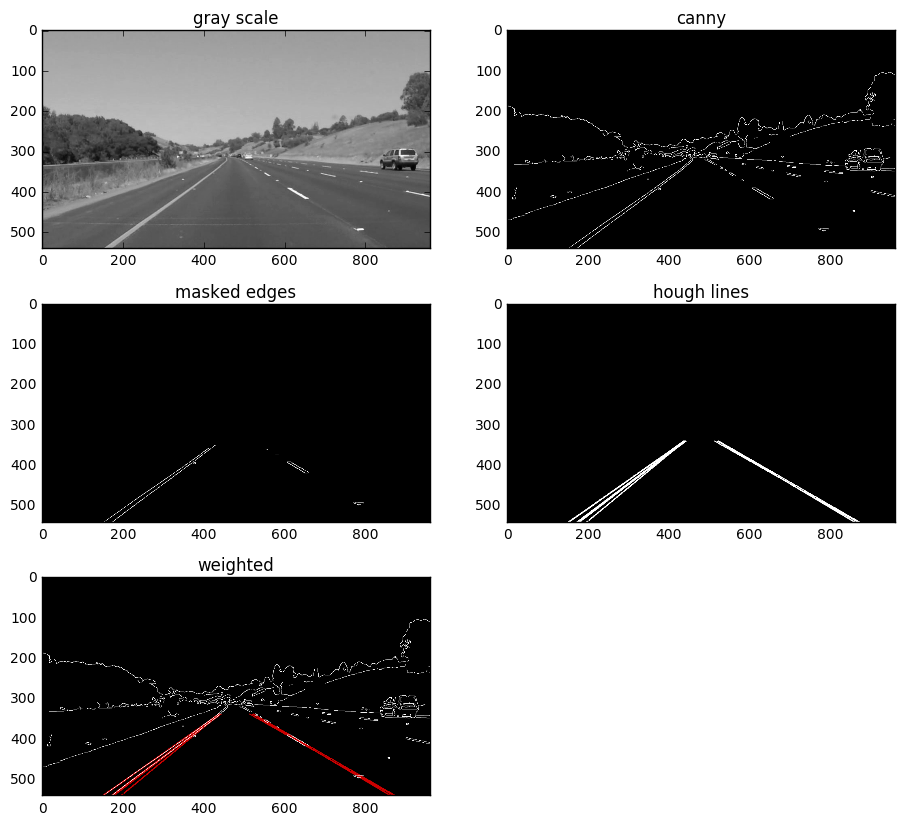

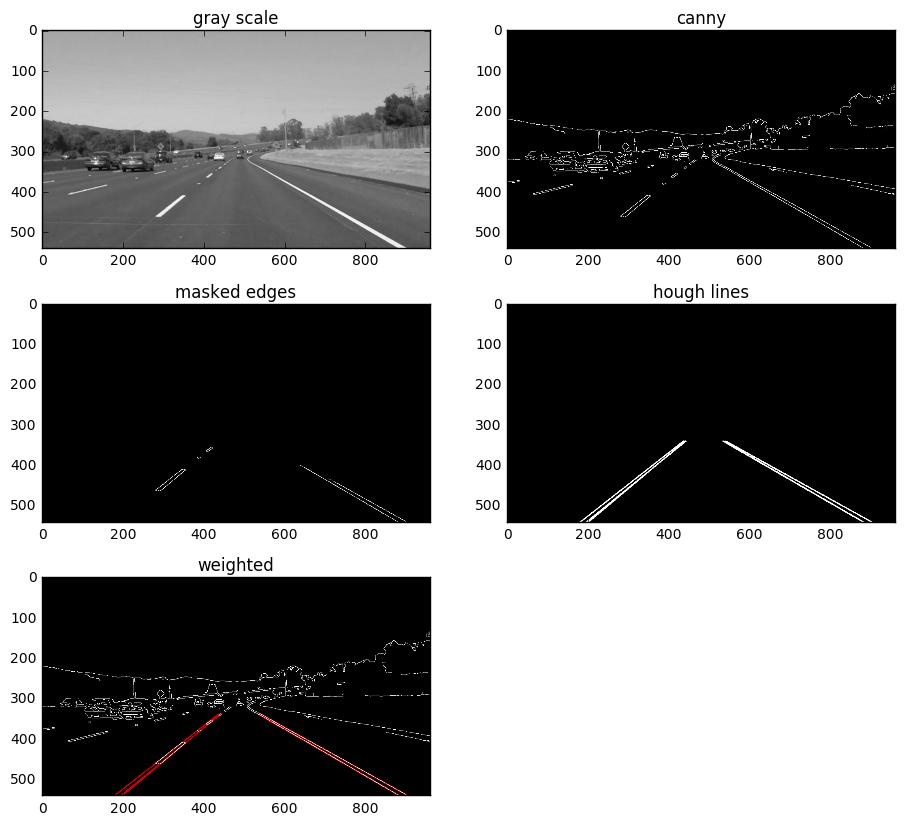

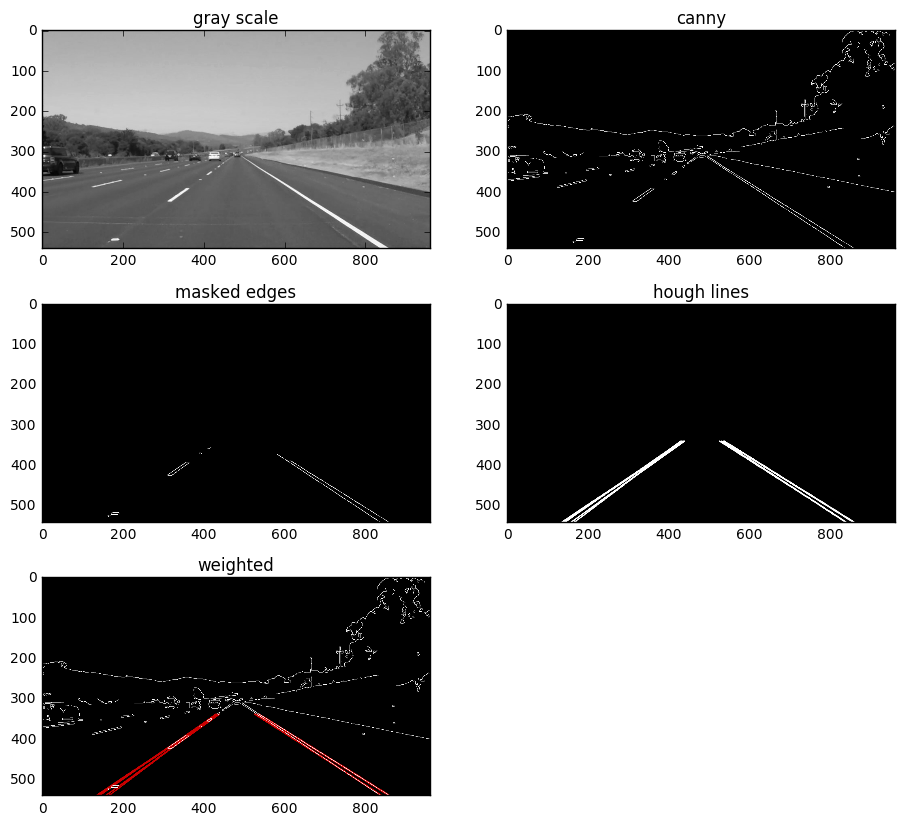

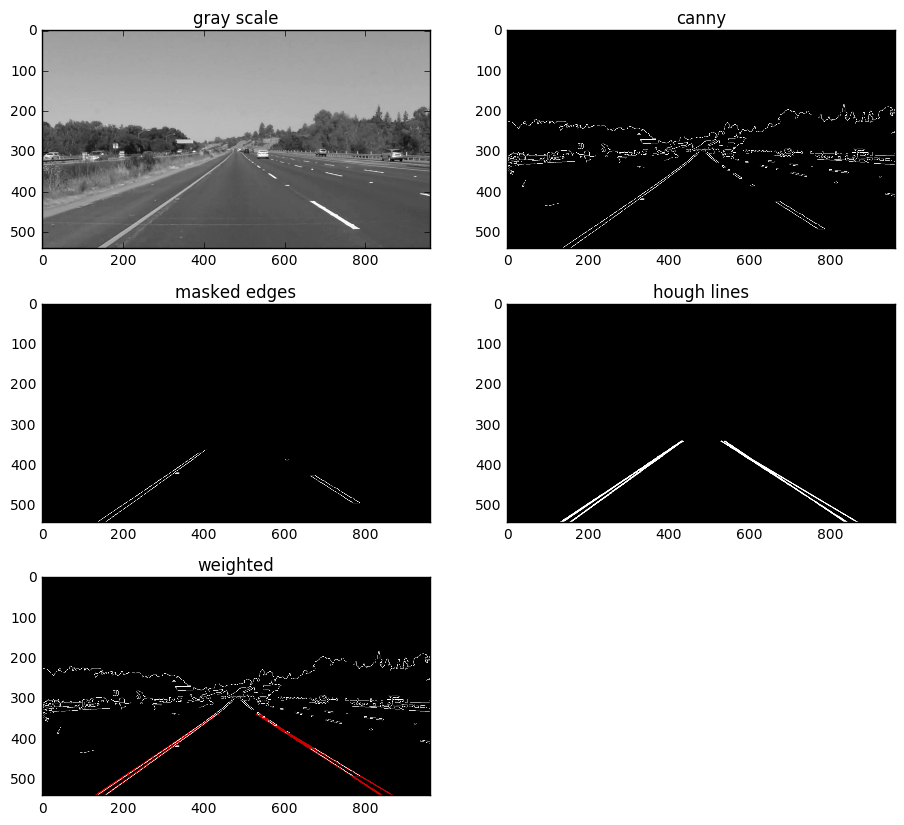

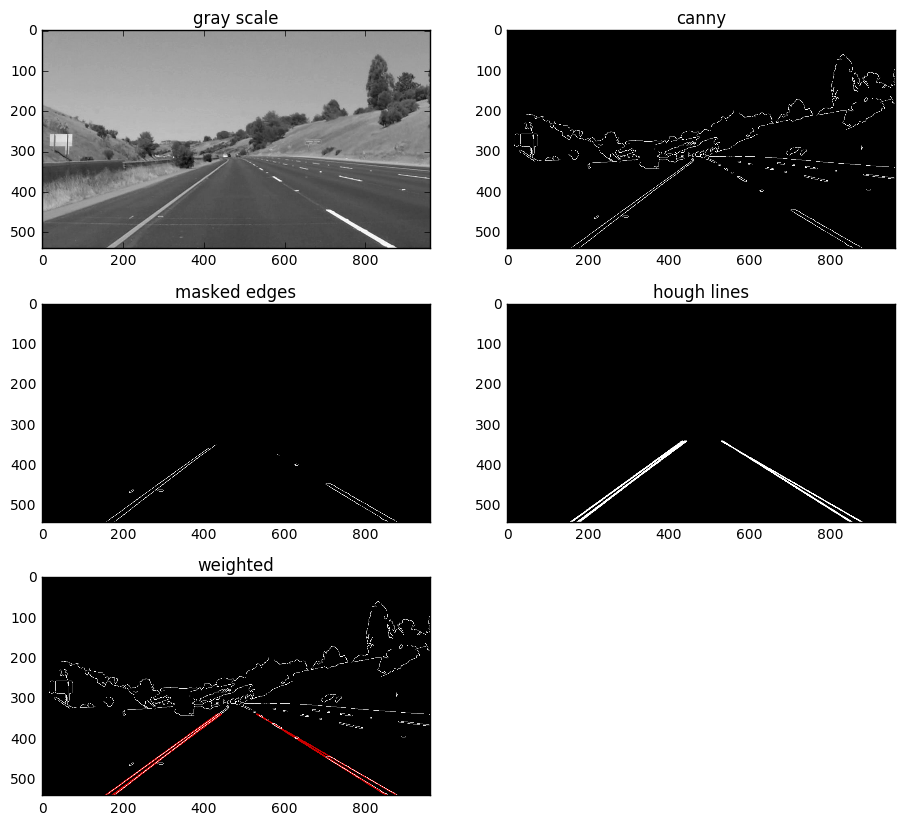

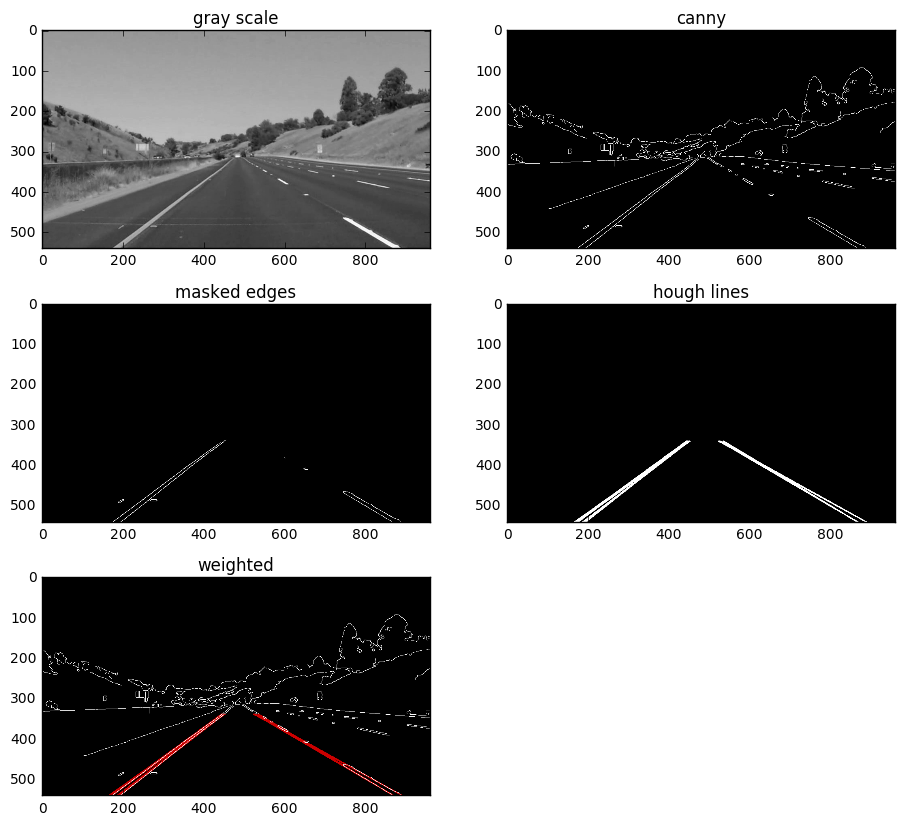

In [370]:


def pipeline(image, txt):
    low_threshold = 50
    high_threshold = 150
    kernel_size = 5
    rho = 2
    theta = np.pi/180
    imshape = image.shape
    offset = -55
    vertices = np.array([[(30,imshape[0]),(imshape[1]/2, imshape[0]/2-offset), (imshape[1]/2, imshape[0]/2-offset), (imshape[1]-30,imshape[0])]], dtype=np.int32)
    threshold = 20
    min_line_len = 45
    max_line_gap = 35
    line_image = np.copy(image)*0

    plt.figure(figsize=(11,10))
    #plt.imshow(image)
    #grayscale
    gray = grayscale(image)
    plt.subplot(3,2,1)
    plt.imshow(gray, cmap='gray')
    plt.title('gray scale')

    #blur
    blur_gray = gaussian_blur(gray, kernel_size)

    #canny
    edges = canny(blur_gray, low_threshold, high_threshold)
    plt.subplot(3,2,2)
    plt.imshow(edges, cmap='Greys_r')
    plt.title('canny')

    #mask
    masked_edges = region_of_interest(edges, vertices)
    plt.subplot(3,2,3)
    plt.imshow(masked_edges,  cmap='Greys_r')
    #plt.figure(figsize=(20,10))
    plt.title('masked edges')

    #hough
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    plt.subplot(3,2,4)
    #plt.figure(figsize=(20,10))
    plt.imshow(lines,  cmap='Greys_r')
    plt.title('hough lines')

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    color_lines = np.dstack((lines,lines*0,lines*0))

    #plotting hough lines
    final = weighted_img(color_edges, color_lines)
    plt.subplot(3,2,5)
    plt.imshow(final)
    plt.title('weighted')

    plt.savefig(txt)

pipeline(mpimg.imread('test_images/solidYellowCurve.jpg'),'test_images/solidYellowCurve_RESULT.jpg' )
pipeline(mpimg.imread('test_images/solidWhiteCurve.jpg'),'test_images/solidWhiteCurve_RESULT.jpg' )
pipeline(mpimg.imread('test_images/solidWhiteRight.jpg'),'test_images/solidWhiteRight_RESULT.jpg' )
pipeline(mpimg.imread('test_images/solidYellowLeft.jpg'),'test_images/solidYellowLeft_RESULT.jpg')
pipeline(mpimg.imread('test_images/solidYellowCurve2.jpg'),'test_images/solidYellowCurve2_RESULT.jpg')
pipeline(mpimg.imread('test_images/whiteCarLaneSwitch.jpg'),'test_images/whiteCarLaneSwitch_RESULT.jpg')


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [90]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0%)98304/28549024 bytes (0.3%)245760/28549024 bytes (0.9%)376832/28549024 bytes (1.3%)540672/28549024 bytes (1.9%)704512/28549024 bytes (2.5%)868352/28549024 bytes (3.0%)1015808/28549024 bytes (3.6%)1146880/28549024 bytes (4.0%)1327104/28549024 bytes (4.6%)1507328/28549024 bytes (5.3%)1622016/28549024 bytes (5.7%)1802240/28549024 bytes (6.3%)1916928/28549024 bytes (6.7%)1998848/2

In [365]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    low_threshold = 50
    high_threshold = 150
    kernel_size = 5
    rho = 2
    theta = np.pi/180
    imshape = image.shape
    offset = -55
    vertices = np.array([[(30,imshape[0]),(imshape[1]/2, imshape[0]/2-offset), (imshape[1]/2, imshape[0]/2-offset), (imshape[1]-30,imshape[0])]], dtype=np.int32)
    threshold = 30
    min_line_len = 30
    max_line_gap = 45
    line_image = np.copy(image)*0


    #plt.imshow(image)
    #grayscale
    gray = grayscale(image)

    #blur
    blur_gray = gaussian_blur(gray, kernel_size)

    #canny
    edges = canny(blur_gray, low_threshold, high_threshold)

    #mask
    masked_edges = region_of_interest(edges, vertices)

    #hough
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    color_lines = np.dstack((lines,lines*0,lines*0))

    #plotting hough lines
    results = weighted_img(image, color_lines)
    
    return results

Let's try the one with the solid white lane on the right first ...

In [368]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

x1  y1  x2  y2 slope b
654 409 869 539 0.604651162791 13.5581395349
612 388 812 517 0.645 -6.74
200 515 310 432 -0.754545454545 665.909090909
187 512 304 430 -0.700854700855 643.05982906
671 425 847 539 0.647727272727 -9.625
256 462 303 430 -0.68085106383 636.29787234
696 434 750 466 0.592592592593 21.5555555556
361 391 404 361 -0.697674418605 642.860465116
646 404 685 426 0.564102564103 39.5897435897
188 512 299 431 -0.72972972973 649.189189189
201 514 278 458 -0.727272727273 660.181818182
(540, 960, 3)
(540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4




  0%|          | 0/222 [00:00<?, ?it/s]

x1  y1  x2  y2 slope b
654 409 869 539 0.604651162791 13.5581395349
612 388 812 517 0.645 -6.74
200 515 310 432 -0.754545454545 665.909090909
187 512 304 430 -0.700854700855 643.05982906
671 425 847 539 0.647727272727 -9.625
256 462 303 430 -0.68085106383 636.29787234
696 434 750 466 0.592592592593 21.5555555556
361 391 404 361 -0.697674418605 642.860465116
646 404 685 426 0.564102564103 39.5897435897
188 512 299 431 -0.72972972973 649.189189189
201 514 278 458 -0.727272727273 660.181818182
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
638 404 845 538 0.647342995169 -9.00483091787
170 539 289 449 -0.756302521008 667.571428571
744 464 867 538 0.60162601626 16.3902439024
150 538 276 447 -0.722222222222 646.333333333
705 440 759 472 0.592592592593 22.2222222222
626 397 682 434 0.660714285714 -16.6071428571
683 427 732 455 0.571428571429 36.7142857143
351 398 403 362 -0.692307692308 641.0
223 487 277 447 -0.740740740741 652.185185185
666 415 698 435 0.625 -1.25
151 539 202 501 -0.7450



  1%|          | 2/222 [00:00<00:11, 19.74it/s]

764 486 817 521 0.660377358491 -18.5283018868
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
642 402 868 538 0.601769911504 15.6637168142
623 395 846 539 0.645739910314 -7.29596412556
171 538 261 470 -0.755555555556 667.2
150 538 249 467 -0.717171717172 645.575757576
716 454 846 538 0.646153846154 -8.64615384615
338 407 398 365 -0.7 643.6
618 392 674 429 0.660714285714 -16.3214285714
706 440 767 476 0.590163934426 23.3442622951
600 382 673 419 0.506849315068 77.8904109589
340 407 399 366 -0.694915254237 643.271186441
337 407 383 371 -0.782608695652 670.739130435
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
646 404 864 535 0.600917431193 15.8073394495
687 437 841 534 0.62987012987 4.27922077922
329 417 394 368 -0.753846153846 665.015384615
148 538 211 494 -0.698412698413 641.365079365
633 403 680 431 0.595744680851 25.8936170213
323 417 383 371 -0.766666666667 664.633333333
169 538 225 497 -0.732142857143 661.732142857
770 490 847 538 0.623376623377 10.0
806 501 867 537 0.5901



  3%|▎         | 6/222 [00:00<00:09, 22.42it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
791 502 848 538 0.631578947368 2.42105263158
613 389 730 464 0.641025641026 -3.94871794872
650 406 871 538 0.597285067873 17.7647058824
774 491 816 517 0.619047619048 11.8571428571
698 442 742 471 0.659090909091 -18.0454545455
339 403 375 378 -0.694444444444 638.416666667
339 402 371 379 -0.71875 645.65625
345 403 401 363 -0.714285714286 649.428571429
713 444 773 478 0.566666666667 39.9666666667
724 460 759 480 0.571428571429 46.2857142857
606 385 640 407 0.647058823529 -7.11764705882
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
600 382 851 538 0.621513944223 9.09163346614
650 406 811 502 0.596273291925 18.4223602484
824 508 873 538 0.612244897959 3.51020408163
331 408 366 383 -0.714285714286 644.428571429




  4%|▍         | 9/222 [00:00<00:08, 23.77it/s]

334 412 397 365 -0.746031746032 661.174603175
822 507 872 539 0.64 -19.08
329 409 363 384 -0.735294117647 650.911764706
772 478 808 500 0.611111111111 6.22222222222
794 502 845 534 0.627450980392 3.80392156863
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
638 400 860 533 0.599099099099 17.7747747748
596 380 849 538 0.624505928854 7.79446640316
772 491 844 535 0.611111111111 19.2222222222
650 406 871 538 0.597285067873 17.7647058824
318 424 392 370 -0.72972972973 656.054054054
310 422 353 391 -0.720930232558 645.488372093
311 422 356 390 -0.711111111111 643.155555556
605 386 848 538 0.625514403292 7.56378600823
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
621 392 865 538 0.598360655738 20.4180327869
585 375 784 500 0.628140703518 7.53768844221
780 499 844 538 0.609375 23.6875
303 438 410 358 -0.747663551402 664.542056075
289 441 344 400 -0.745454545455 656.436363636
676 424 866 538 0.6 18.4
289 438 413 357 -0.653225806452 626.782258065
300 440 386 373 -0.779069767442 673.7209



  6%|▌         | 13/222 [00:00<00:07, 26.13it/s]

x1  y1  x2  y2 slope b
573 370 833 539 0.65 -2.45
183 513 297 433 -0.701754385965 641.421052632
653 416 855 538 0.60396039604 21.6138613861
248 477 307 434 -0.728813559322 657.745762712
201 514 305 436 -0.75 664.75
578 373 610 393 0.625 11.75
604 384 644 410 0.65 -8.6
198 515 307 433 -0.752293577982 663.95412844
708 450 854 538 0.602739726027 23.2602739726
184 513 232 480 -0.6875 639.5
630 408 753 488 0.650406504065 -1.75609756098
245 471 298 433 -0.716981132075 646.660377358
610 394 671 426 0.524590163934 74.0
363 393 406 363 -0.697674418605 646.255813953
790 510 832 538 0.666666666667 -16.6666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
144 538 274 447 -0.7 638.8
581 373 723 468 0.669014084507 -15.6971830986
610 387 824 520 0.621495327103 7.88785046729
164 538 257 470 -0.731182795699 657.913978495
163 538 285 449 -0.729508196721 656.909836066
743 481 834 538 0.626373626374 15.6043956044
149 535 222 485 -0.684931506849 637.054794521
795 501 855 539 0.633333333333 -2.5
704



  8%|▊         | 17/222 [00:00<00:07, 28.19it/s]

x1  y1  x2  y2 slope b
619 391 847 533 0.622807017544 5.48245614035
591 378 739 477 0.668918918919 -17.3310810811
141 538 246 465 -0.695238095238 636.028571429
162 538 258 466 -0.75 659.5
747 470 857 538 0.618181818182 8.21818181818
774 498 835 539 0.672131147541 -22.2295081967
723 465 764 493 0.682926829268 -28.756097561
143 538 182 511 -0.692307692308 637.0
161 538 258 465 -0.752577319588 659.164948454
335 403 398 365 -0.603174603175 605.063492063
763 491 798 515 0.685714285714 -32.2
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
633 398 859 539 0.62389380531 3.07522123894
600 382 767 494 0.670658682635 -20.3952095808
138 538 205 491 -0.701492537313 634.805970149
330 412 394 366 -0.71875 649.1875
158 539 220 490 -0.790322580645 663.870967742
771 495 819 528 0.6875 -35.0625
190 515 221 490 -0.806451612903 668.225806452
760 488 792 510 0.6875 -34.5
324 413 390 368 -0.681818181818 633.909090909
147 533 207 490 -0.716666666667 638.35
794 510 836 539 0.690476190476 -38.2380952381
(540



  9%|▉         | 20/222 [00:00<00:07, 28.50it/s]

x1  y1  x2  y2 slope b
615 389 854 538 0.623430962343 5.589958159
583 374 805 519 0.653153153153 -6.78828828829
695 448 833 538 0.652173913043 -5.26086956522
326 411 363 385 -0.702702702703 640.081081081
332 413 398 365 -0.727272727273 654.454545455
335 412 371 387 -0.694444444444 644.638888889
585 375 617 395 0.625 9.375
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
614 389 853 538 0.623430962343 6.21338912134
580 373 828 535 0.653225806452 -5.87096774194
322 414 417 355 -0.621052631579 613.978947368
318 425 362 395 -0.681818181818 641.818181818
579 372 725 467 0.650684931507 -4.74657534247
610 387 853 539 0.625514403292 5.43621399177
314 425 362 394 -0.645833333333 627.791666667
785 508 817 528 0.625 17.375
310 422 393 372 -0.602409638554 608.746987952
(540, 960, 3)
(540, 960, 3)




 10%|█         | 23/222 [00:00<00:07, 28.22it/s]

x1  y1  x2  y2 slope b
615 389 854 538 0.623430962343 5.589958159
687 444 832 539 0.655172413793 -6.10344827586
698 451 766 494 0.632352941176 9.61764705882
585 375 703 454 0.669491525424 -16.6525423729
299 439 413 357 -0.719298245614 654.070175439
290 437 385 373 -0.673684210526 632.368421053
610 387 836 528 0.62389380531 6.42477876106
302 438 353 402 -0.705882352941 651.176470588
755 488 821 530 0.636363636364 7.54545454545
599 385 633 408 0.676470588235 -20.2058823529
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
612 388 854 539 0.623966942149 6.13223140496
647 417 833 538 0.650537634409 -3.89784946237
577 371 754 486 0.649717514124 -3.88700564972
264 455 399 364 -0.674074074074 632.955555556
276 456 413 357 -0.722627737226 655.445255474
805 507 854 538 0.632653061224 -2.28571428571
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
615 389 854 538 0.623430962343 5.589958159
591 378 767 496 0.670454545455 -18.2386363636
231 476 319 417 -0.670454545455 630.875
244 479 373 382 -0



 12%|█▏        | 26/222 [00:00<00:07, 27.43it/s]

x1  y1  x2  y2 slope b
589 377 703 453 0.666666666667 -15.6666666667
617 390 854 538 0.62447257384 4.70042194093
140 538 279 445 -0.669064748201 631.669064748
357 397 404 363 -0.723404255319 655.255319149
725 466 789 510 0.6875 -32.4375
163 538 211 502 -0.75 660.25
193 517 289 445 -0.75 661.75
143 537 280 445 -0.671532846715 633.02919708
741 478 833 538 0.652173913043 -5.26086956522
625 394 761 479 0.625 3.375
356 394 390 368 -0.764705882353 666.235294118
639 409 687 442 0.6875 -30.3125
243 481 288 445 -0.8 675.4
163 539 206 506 -0.767441860465 664.093023256
713 458 743 479 0.7 -41.1
353 398 384 374 -0.774193548387 671.290322581
230 477 261 456 -0.677419354839 632.806451613
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 538 261 468 -0.721649484536 656.350515464
644 414 832 537 0.654255319149 -7.34042553191
615 389 854 538 0.623430962343 5.589958159
145 537 247 466 -0.696078431373 637.931372549
581 373 643 412 0.629032258065 7.53225806452
621 392 855 538 0.623931623932 4.5384615



 13%|█▎        | 29/222 [00:01<00:06, 27.61it/s]

x1  y1  x2  y2 slope b
615 389 855 539 0.625 4.625
583 374 769 495 0.650537634409 -5.26344086022
142 538 210 492 -0.676470588235 634.058823529
331 416 413 357 -0.719512195122 654.158536585
165 538 225 493 -0.75 661.75
747 482 813 524 0.636363636364 6.63636363636
623 393 856 538 0.622317596567 5.29613733906
142 539 209 492 -0.701492537313 638.611940299
723 466 781 503 0.637931034483 4.77586206897
326 416 383 372 -0.771929824561 667.649122807
149 535 211 492 -0.693548387097 638.338709677
329 416 394 367 -0.753846153846 664.015384615
188 522 223 495 -0.771428571429 667.028571429
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
617 390 855 538 0.621848739496 6.31932773109
585 375 705 453 0.65 -5.25
712 459 833 538 0.652892561983 -5.85950413223
743 479 793 511 0.64 3.48
677 436 714 459 0.621621621622 15.1621621622
636 401 856 538 0.622727272727 4.94545454545
369 389 410 359 -0.731707317073 659.0
577 371 834 538 0.649805447471 -3.93774319066
363 389 410 358 -0.659574468085 628.425531915
(5



 14%|█▍        | 32/222 [00:01<00:06, 28.11it/s]

625 394 674 425 0.632653061224 -1.40816326531
328 410 365 384 -0.702702702703 640.486486486
591 378 834 536 0.650205761317 -6.27160493827
687 432 739 465 0.634615384615 -3.98076923077
335 412 372 386 -0.702702702703 647.405405405
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
587 376 835 537 0.649193548387 -5.07661290323
629 396 858 539 0.624454148472 3.21834061135
322 422 393 370 -0.732394366197 657.830985915
311 421 355 390 -0.704545454545 640.113636364
619 391 771 485 0.618421052632 8.19736842105
321 422 393 368 -0.75 662.75
592 378 713 457 0.652892561983 -8.51239669421
360 389 393 367 -0.666666666667 629.0
(540, 960, 3)
(540, 960, 3)




 16%|█▌        | 35/222 [00:01<00:06, 28.29it/s]

x1  y1  x2  y2 slope b
583 374 836 539 0.652173913043 -6.21739130435
694 438 816 512 0.606557377049 17.0491803279
292 434 381 372 -0.696629213483 637.415730337
623 393 681 430 0.637931034483 -4.43103448276
301 437 410 358 -0.724770642202 655.155963303
749 472 858 538 0.605504587156 18.4770642202
683 431 732 460 0.591836734694 26.7755102041
798 513 836 538 0.657894736842 -12.0
299 430 386 371 -0.67816091954 632.770114943
599 384 654 419 0.636363636364 2.81818181818
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
696 439 856 538 0.61875 8.35
577 371 833 537 0.6484375 -3.1484375
578 372 834 539 0.65234375 -5.0546875
270 450 412 357 -0.654929577465 626.830985915
657 415 726 459 0.63768115942 -3.95652173913
278 455 406 362 -0.7265625 656.984375
615 389 682 432 0.641791044776 -5.70149253731
268 454 331 408 -0.730158730159 649.682539683
610 387 692 438 0.621951219512 7.60975609756
691 436 757 478 0.636363636364 -3.72727272727
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
591 381 833 5



 18%|█▊        | 39/222 [00:01<00:06, 29.00it/s]

191 508 272 450 -0.716049382716 644.765432099
737 467 854 538 0.606837606838 19.7606837607
625 397 717 453 0.608695652174 16.5652173913
191 521 290 447 -0.747474747475 663.767676768
147 539 240 472 -0.720430107527 644.903225806
590 380 648 417 0.637931034483 3.62068965517
575 370 656 415 0.555555555556 50.5555555556
353 399 405 363 -0.692307692308 643.384615385
604 384 635 402 0.58064516129 33.2903225806
671 426 720 455 0.591836734694 28.8775510204
149 537 180 514 -0.741935483871 647.548387097
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
612 388 854 539 0.623966942149 6.13223140496
666 430 833 539 0.652694610778 -4.69461077844
345 406 400 366 -0.727272727273 656.909090909
338 404 389 368 -0.705882352941 642.588235294
166 539 264 465 -0.755102040816 664.346938776
192 505 253 464 -0.672131147541 634.049180328
579 372 832 537 0.652173913043 -5.60869565217
144 538 186 511 -0.642857142857 630.571428571
342 406 389 369 -0.787234042553 675.234042553
218 488 258 463 -0.625 624.25
339 406



 19%|█▉        | 42/222 [00:01<00:06, 27.72it/s]

x1  y1  x2  y2 slope b
615 389 855 539 0.625 4.625
619 396 801 518 0.67032967033 -18.9340659341
592 378 657 423 0.692307692308 -31.8461538462
717 461 833 539 0.672413793103 -21.1206896552
649 410 721 454 0.611111111111 13.3888888889
617 390 681 429 0.609375 14.015625
804 506 854 538 0.64 -8.56
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
619 391 855 538 0.622881355932 5.43644067797
601 384 832 539 0.670995670996 -19.2683982684
589 377 633 407 0.681818181818 -24.5909090909
723 465 832 538 0.669724770642 -19.2110091743
803 507 854 538 0.607843137255 18.9019607843
620 397 654 421 0.705882352941 -40.6470588235
776 490 835 526 0.610169491525 16.5084745763
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
642 406 854 539 0.627358490566 3.2358490566
592 378 796 515 0.671568627451 -19.568627451
789 509 832 539 0.697674418605 -41.4651162791
589 377 753 487 0.670731707317 -18.0609756098
655 414 706 445 0.607843137255 15.862745098
348 401 379 378 -0.741935483871 659.193548387
343 399 375 3



 20%|██        | 45/222 [00:01<00:06, 25.68it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
619 391 855 538 0.622881355932 5.43644067797
594 379 816 528 0.671171171171 -19.6756756757
336 409 370 384 -0.735294117647 656.058823529
330 407 367 381 -0.702702702703 638.891891892
620 397 684 441 0.6875 -29.25
775 500 833 539 0.672413793103 -21.1206896552
338 409 372 384 -0.735294117647 657.529411765
601 384 635 408 0.705882352941 -40.2352941176
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
656 415 853 538 0.624365482234 5.41624365482
592 378 831 539 0.673640167364 -20.7949790795
611 391 685 442 0.689189189189 -30.0945945946
323 420 392 368 -0.753623188406 663.420289855
314 418 357 388 -0.697674418605 637.069767442
634 401 701 442 0.611940298507 13.0298507463
589 377 750 485 0.670807453416 -18.1055900621
617 390 663 418 0.608695652174 14.4347826087
314 419 360 387 -0.695652173913 637.434782609
(540, 960, 3)
(540, 960, 3)


x1  y1  x2  y2 slope b
594 379 832 539 0.672268907563 -20.3277310924
619 391 855 538 0.622881355932 5.43644067797
299 428 385 370 -0.674418604651 629.651162791
313 428 387 371 -0.77027027027 669.094594595
595 380 659 424 0.6875 -29.0625
739 476 832 538 0.666666666667 -16.6666666667
307 432 352 394 -0.844444444444 691.244444444
728 460 790 498 0.612903225806 13.8064516129
318 424 387 370 -0.782608695652 672.869565217
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
608 388 832 539 0.674107142857 -21.8571428571
623 393 855 538 0.625 3.625
270 450 336 402 -0.727272727273 646.363636364
276 451 342 405 -0.69696969697 643.363636364
625 394 854 537 0.624454148472 3.71615720524
592 378 640 411 0.6875 -29.0
630 403 695 448 0.692307692308 -33.1538461538
282 450 379 374 -0.783505154639 670.948453608
270 448 332 404 -0.709677419355 639.612903226
284 449 324 419 -0.75 662.0
(540, 960, 3)
(540, 960, 3)




 22%|██▏       | 48/222 [00:01<00:09, 18.07it/s]

 23%|██▎       | 51/222 [00:01<00:08, 19.64it/s]

x1  y1  x2  y2 slope b
592 378 831 539 0.673640167364 -20.7949790795
641 405 854 538 0.62441314554 4.75117370892
252 472 371 379 -0.781512605042 668.941176471
240 469 369 379 -0.697674418605 636.441860465
796 514 831 538 0.685714285714 -31.8285714286
627 396 679 428 0.615384615385 10.1538461538
286 447 319 421 -0.787878787879 672.333333333
248 472 329 415 -0.703703703704 646.518518519
591 378 732 473 0.673758865248 -20.1914893617
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
592 378 831 539 0.673640167364 -20.7949790795
619 391 854 538 0.625531914894 3.79574468085
198 500 305 425 -0.700934579439 638.785046729
213 501 313 426 -0.75 660.75
589 377 748 484 0.672955974843 -19.3710691824
242 467 302 426 -0.683333333333 632.366666667
211 489 307 424 -0.677083333333 631.864583333
238 482 312 425 -0.77027027027 665.324324324
821 519 853 539 0.625 5.875
621 392 657 414 0.611111111111 12.5
591 378 795 515 0.671568627451 -18.8970588235
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
675 4



 24%|██▍       | 54/222 [00:02<00:09, 17.44it/s]

x1  y1  x2  y2 slope b
610 390 831 539 0.674208144796 -21.2669683258
707 447 852 538 0.627586206897 3.29655172414
617 390 689 434 0.611111111111 12.9444444444
135 538 170 515 -0.657142857143 626.714285714
601 384 665 428 0.6875 -29.1875
667 421 719 453 0.615384615385 10.5384615385
311 423 360 386 -0.755102040816 657.836734694
752 475 809 510 0.614035087719 13.2456140351
310 423 359 386 -0.755102040816 657.081632653
704 445 741 467 0.594594594595 26.4054054054
641 411 705 455 0.6875 -29.6875
587 376 645 406 0.51724137931 72.3793103448
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
589 377 820 532 0.670995670996 -18.2164502165
712 450 853 538 0.624113475177 5.63120567376
779 503 813 527 0.705882352941 -46.8823529412
618 391 672 423 0.592592592593 24.7777777778
639 404 700 441 0.606557377049 16.4098360656
655 420 831 538 0.670454545455 -19.1477272727
709 448 739 466 0.6 22.6
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
615 389 850 536 0.625531914894 4.29787234043
591 378 831 539



 25%|██▌       | 56/222 [00:02<00:12, 13.45it/s]

x1  y1  x2  y2 slope b
614 389 851 537 0.62447257384 5.57383966245
605 389 756 488 0.655629139073 -7.65562913907
323 409 362 383 -0.666666666667 624.333333333
329 411 366 385 -0.702702702703 642.189189189
776 491 838 529 0.612903225806 15.3870967742
760 492 802 519 0.642857142857 3.42857142857
784 508 817 529 0.636363636364 9.09090909091
701 453 751 485 0.64 4.36
613 394 699 450 0.651162790698 -5.16279069767
797 517 830 538 0.636363636364 9.81818181818
612 388 851 538 0.627615062762 3.89958158996
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
606 385 851 538 0.624489795918 6.55918367347
676 436 829 539 0.673202614379 -19.0849673203
610 387 852 538 0.623966942149 6.38016528926
307 421 353 390 -0.673913043478 627.891304348
585 375 660 427 0.693333333333 -30.6
313 423 353 396 -0.675 634.275
662 427 707 458 0.688888888889 -29.0444444444
732 473 829 538 0.670103092784 -17.5154639175
311 423 357 393 -0.652173913043 625.826086957
315 415 351 390 -0.694444444444 633.75
616 396 674 436 0.68



 26%|██▌       | 58/222 [00:02<00:12, 13.33it/s]

 27%|██▋       | 60/222 [00:02<00:12, 13.36it/s]

x1  y1  x2  y2 slope b
605 385 850 538 0.624489795918 7.18367346939
654 424 829 538 0.651428571429 -2.03428571429
571 368 634 409 0.650793650794 -3.60317460317
326 416 383 373 -0.754385964912 661.929824561
286 435 383 372 -0.649484536082 620.75257732
632 409 674 436 0.642857142857 2.71428571429
296 437 383 374 -0.724137931034 651.344827586
285 435 382 372 -0.649484536082 620.103092784
602 383 654 415 0.615384615385 12.5384615385
608 393 744 482 0.654411764706 -4.88235294118
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
645 418 784 509 0.654676258993 -4.26618705036
604 384 665 422 0.622950819672 7.73770491803
689 439 776 492 0.609195402299 19.2643678161
751 478 850 538 0.606060606061 22.8484848485
260 453 374 376 -0.675438596491 628.614035088
572 369 671 434 0.656565656566 -6.55555555556
644 410 701 445 0.614035087719 14.5614035088
272 454 376 376 -0.75 658.0
797 519 827 538 0.633333333333 14.2333333333
282 447 377 376 -0.747368421053 657.757894737
779 507 813 528 0.617647058824 25



 28%|██▊       | 62/222 [00:02<00:13, 12.04it/s]

x1  y1  x2  y2 slope b
573 369 824 538 0.673306772908 -16.8047808765
604 384 816 521 0.646226415094 -6.32075471698
131 538 269 445 -0.673913043478 626.282608696
352 396 398 364 -0.695652173913 640.869565217
161 532 279 447 -0.720338983051 647.974576271
151 539 281 444 -0.730769230769 649.346153846
787 501 821 524 0.676470588235 -31.3823529412
693 451 747 487 0.666666666667 -11.0
807 514 844 539 0.675675675676 -31.2702702703
132 538 272 444 -0.671428571429 626.628571429
596 385 640 415 0.681818181818 -21.3636363636
765 487 824 526 0.661016949153 -18.6779661017
750 489 801 524 0.686274509804 -25.7058823529
349 397 381 373 -0.75 658.75
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
570 368 823 538 0.671936758893 -15.0039525692
768 489 844 538 0.644736842105 -6.15789473684
134 536 239 465 -0.67619047619 626.60952381
598 381 764 488 0.644578313253 -4.4578313253
151 538 252 467 -0.70297029703 644.148514851
642 408 844 539 0.648514851485 -8.34653465347
132 539 243 464 -0.675675675676 628.



 29%|██▉       | 64/222 [00:03<00:15, 10.17it/s]

 30%|██▉       | 66/222 [00:03<00:15, 10.16it/s]

x1  y1  x2  y2 slope b
640 408 842 539 0.648514851485 -7.0495049505
564 365 821 538 0.673151750973 -14.6575875486
610 389 660 422 0.66 -13.6
680 433 842 538 0.648148148148 -7.74074074074
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
564 365 821 538 0.673151750973 -14.6575875486
647 414 809 516 0.62962962963 6.62962962963
599 383 646 412 0.617021276596 13.4042553191
628 402 705 449 0.61038961039 18.6753246753
759 485 840 536 0.62962962963 7.11111111111
562 364 603 390 0.634146341463 7.60975609756
(540, 960, 3)
(540, 960, 3)




 31%|███       | 68/222 [00:03<00:13, 11.35it/s]

 32%|███▏      | 71/222 [00:03<00:11, 13.68it/s]

x1  y1  x2  y2 slope b
573 369 824 538 0.673306772908 -16.8047808765
716 455 845 538 0.643410852713 -5.68217054264
600 382 720 459 0.641666666667 -3.0
343 400 373 379 -0.7 640.1
336 399 366 379 -0.666666666667 623.0
662 421 700 446 0.657894736842 -14.5263157895
596 385 660 429 0.6875 -24.75
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
571 368 824 539 0.675889328063 -17.9328063241
719 457 846 539 0.645669291339 -7.23622047244
606 385 677 432 0.661971830986 -16.1549295775
695 442 742 473 0.659574468085 -16.4042553191
322 407 358 383 -0.666666666667 621.666666667
331 408 366 384 -0.685714285714 634.971428571
713 463 825 538 0.669642857143 -14.4553571429
781 496 847 538 0.636363636364 -1.0
617 393 659 419 0.619047619048 11.0476190476
323 408 360 382 -0.702702702703 634.972972973
328 409 362 386 -0.676470588235 630.882352941
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
571 368 824 539 0.675889328063 -17.9328063241
675 431 846 538 0.625730994152 8.63157894737
594 379 726 462 0.62

x1  y1  x2  y2 slope b
568 367 822 538 0.673228346457 -15.3937007874
606 387 752 479 0.630136986301 5.13698630137
592 378 712 453 0.625 8.0
240 470 322 415 -0.670731707317 630.975609756
230 468 314 413 -0.654761904762 618.595238095
745 475 795 508 0.66 -16.7
807 514 843 539 0.694444444444 -46.4166666667
230 467 313 413 -0.650602409639 616.638554217
682 444 821 538 0.676258992806 -17.2086330935
286 438 320 416 -0.647058823529 623.058823529
708 452 742 473 0.617647058824 14.7058823529
770 492 832 530 0.612903225806 20.064516129
(540, 960, 3)
(540, 960, 3)




 33%|███▎      | 73/222 [00:04<00:16,  8.83it/s]

x1  y1  x2  y2 slope b
591 378 733 467 0.62676056338 7.58450704225
566 366 821 538 0.674509803922 -15.7725490196
198 499 305 427 -0.672897196262 632.23364486
187 496 297 425 -0.645454545455 616.7
767 489 842 539 0.666666666667 -22.3333333333
201 498 250 465 -0.673469387755 633.367346939
750 478 788 504 0.684210526316 -35.1578947368
690 450 821 539 0.679389312977 -18.7786259542
250 454 296 425 -0.630434782609 611.608695652
666 424 723 462 0.666666666667 -20.0
728 464 763 488 0.685714285714 -35.2
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
144 538 283 441 -0.697841726619 638.489208633
562 364 820 538 0.674418604651 -15.023255814
592 378 747 478 0.645161290323 -3.93548387097
132 532 272 441 -0.65 617.8
568 367 768 502 0.675 -16.4
779 497 842 539 0.666666666667 -22.3333333333
723 461 803 514 0.6625 -17.9875
127 536 276 440 -0.644295302013 617.825503356
718 458 752 481 0.676470588235 -27.7058823529
143 538 283 440 -0.7 638.1
690 440 724 463 0.676470588235 -26.7647058824
589 377 653 4



 34%|███▍      | 75/222 [00:04<00:19,  7.68it/s]

 35%|███▍      | 77/222 [00:04<00:16,  9.04it/s]

x1  y1  x2  y2 slope b
569 369 819 538 0.676 -15.644
628 401 841 539 0.647887323944 -5.87323943662
127 535 244 459 -0.649572649573 617.495726496
143 539 256 459 -0.70796460177 640.238938053
591 378 641 411 0.66 -12.06
617 394 649 416 0.6875 -30.1875
574 372 628 408 0.666666666667 -10.6666666667
123 538 167 510 -0.636363636364 616.272727273
142 538 256 458 -0.701754385965 637.649122807
797 509 841 538 0.659090909091 -16.2954545455
136 528 248 458 -0.625 613.0
564 365 819 537 0.674509803922 -15.4235294118
333 404 389 368 -0.642857142857 618.071428571
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
594 379 841 539 0.647773279352 -5.77732793522
564 365 818 537 0.677165354331 -16.9212598425
140 538 220 482 -0.7 636.0
121 538 166 508 -0.666666666667 618.666666667
130 531 208 482 -0.628205128205 612.666666667
182 510 217 485 -0.714285714286 640.0
620 396 680 436 0.666666666667 -17.3333333333
319 412 381 372 -0.645161290323 617.806451613
566 366 766 501 0.675 -16.05
169 519 208 491 -0.71794

x1  y1  x2  y2 slope b
627 403 836 539 0.650717703349 -5.0
682 448 815 538 0.676691729323 -13.5037593985
562 365 693 454 0.679389312977 -16.8167938931
644 422 709 465 0.661538461538 -4.03076923077
338 400 371 379 -0.636363636364 615.090909091
609 391 675 433 0.636363636364 3.45454545455
558 362 619 396 0.55737704918 50.9836065574
763 491 837 538 0.635135135135 6.39189189189
573 372 621 404 0.666666666667 -10.0
606 389 646 414 0.625 10.25
(540, 960, 3)
(540, 960, 3)




 36%|███▌      | 79/222 [00:04<00:18,  7.55it/s]

 36%|███▋      | 81/222 [00:05<00:15,  8.93it/s]

x1  y1  x2  y2 slope b
583 374 835 538 0.650793650794 -5.4126984127
558 362 709 467 0.695364238411 -26.0132450331
576 373 813 539 0.700421940928 -30.4430379747
324 409 363 384 -0.641025641026 616.692307692
319 407 360 382 -0.609756097561 601.512195122
662 426 835 539 0.653179190751 -6.40462427746
319 408 350 387 -0.677419354839 624.096774194
328 408 364 384 -0.666666666667 626.666666667
587 376 634 406 0.63829787234 1.31914893617
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
564 365 813 539 0.698795180723 -29.1204819277
595 382 835 538 0.65 -4.75
583 374 640 410 0.631578947368 5.78947368421
311 419 355 388 -0.704545454545 638.113636364
303 418 346 389 -0.674418604651 622.348837209
314 418 355 390 -0.682926829268 632.43902439
562 364 607 396 0.711111111111 -35.6444444444
318 408 351 387 -0.636363636364 610.363636364
309 419 354 390 -0.644444444444 618.133333333
677 445 814 538 0.678832116788 -14.5693430657
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
560 363 812 539 0.6984126



 37%|███▋      | 83/222 [00:05<00:16,  8.29it/s]

x1  y1  x2  y2 slope b
558 362 811 539 0.699604743083 -28.3794466403
600 384 730 471 0.669230769231 -17.5384615385
227 466 310 412 -0.650602409639 613.686746988
726 467 790 511 0.6875 -32.125
234 469 319 414 -0.647058823529 620.411764706
777 501 832 539 0.690909090909 -35.8363636364
587 376 678 437 0.67032967033 -17.4835164835
703 452 733 473 0.7 -40.1
241 467 367 379 -0.698412698413 635.317460317
234 462 311 412 -0.649350649351 613.948051948
(540, 960, 3)
(540, 960, 3)




 38%|███▊      | 85/222 [00:05<00:19,  7.18it/s]

 39%|███▉      | 87/222 [00:05<00:15,  8.64it/s]

x1  y1  x2  y2 slope b
558 362 810 538 0.698412698413 -27.7142857143
671 431 832 539 0.670807453416 -19.1118012422
183 494 295 424 -0.625 608.375
194 498 302 425 -0.675925925926 629.12962963
585 375 702 453 0.666666666667 -15.0
779 502 831 538 0.692307692308 -37.3076923077
193 488 237 461 -0.613636363636 606.431818182
619 397 738 477 0.672268907563 -19.1344537815
261 444 292 425 -0.612903225806 603.967741935
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
558 362 810 538 0.698412698413 -27.7142857143
137 537 281 440 -0.673611111111 629.284722222
726 469 832 538 0.650943396226 -3.58490566038
579 372 737 475 0.651898734177 -5.44936708861
126 531 275 438 -0.624161073826 609.644295302
656 423 833 538 0.649717514124 -3.21468926554
230 464 273 438 -0.604651162791 603.069767442
122 534 211 478 -0.629213483146 610.764044944
238 470 279 442 -0.682926829268 632.536585366
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
562 364 809 537 0.7004048583 -29.6275303644
618 398 831 537 0.6525821596



 40%|████      | 89/222 [00:05<00:13,  9.83it/s]

x1  y1  x2  y2 slope b
556 361 810 539 0.700787401575 -28.6377952756
577 371 776 501 0.653266331658 -5.93467336683
122 535 208 481 -0.627906976744 611.604651163
137 538 199 498 -0.645161290323 626.387096774
757 489 831 538 0.662162162162 -12.2567567568
143 534 219 483 -0.671052631579 629.960526316
319 413 387 369 -0.647058823529 619.411764706
757 490 823 532 0.636363636364 8.27272727273
558 362 810 538 0.698412698413 -27.7142857143
118 538 152 517 -0.617647058824 610.882352941
705 455 746 483 0.682926829268 -26.4634146341
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
586 377 737 476 0.655629139073 -7.19867549669
558 362 809 538 0.701195219124 -29.2669322709
591 386 809 539 0.701834862385 -28.7844036697
778 503 830 539 0.692307692308 -35.6153846154
577 371 677 436 0.65 -4.05
118 538 159 513 -0.609756097561 609.951219512
138 539 171 516 -0.69696969697 635.181818182
139 537 171 515 -0.6875 632.5625
717 464 772 499 0.636363636364 7.72727272727
775 501 809 525 0.705882352941 -46.058823



 41%|████      | 91/222 [00:06<00:16,  7.80it/s]

 42%|████▏     | 93/222 [00:06<00:14,  9.21it/s]

x1  y1  x2  y2 slope b
583 374 826 537 0.670781893004 -17.0658436214
599 392 808 539 0.703349282297 -29.3062200957
558 362 807 537 0.70281124498 -30.1686746988
765 495 829 539 0.6875 -30.9375
579 372 618 399 0.692307692308 -28.8461538462
342 401 372 381 -0.666666666667 629.0
334 399 366 379 -0.625 607.75
336 402 372 380 -0.611111111111 607.333333333
584 375 636 411 0.692307692308 -29.3076923077
751 486 829 538 0.666666666667 -14.6666666667
337 402 370 382 -0.606060606061 606.242424242
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
646 416 829 539 0.672131147541 -18.1967213115
583 380 808 538 0.702222222222 -29.3955555556
583 374 644 416 0.688524590164 -27.4098360656
326 411 390 368 -0.671875 630.03125
575 374 614 401 0.692307692308 -24.0769230769
320 410 360 384 -0.65 618.0
643 414 717 465 0.689189189189 -29.1486486486
560 363 706 466 0.705479452055 -32.0684931507
321 408 353 387 -0.65625 618.65625
713 462 830 538 0.649572649573 -1.1452991453
329 410 392 367 -0.68253968254 634.5555



 43%|████▎     | 95/222 [00:06<00:13,  9.73it/s]

286 431 336 398 -0.66 619.76
729 471 803 522 0.689189189189 -31.4189189189
603 387 645 415 0.666666666667 -15.0
711 459 741 480 0.7 -38.7
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
690 446 829 537 0.654676258993 -5.72661870504
570 368 692 456 0.72131147541 -43.1475409836
629 403 659 425 0.733333333333 -58.2666666667
690 453 804 535 0.719298245614 -43.3157894737
273 448 377 375 -0.701923076923 639.625
264 444 371 377 -0.626168224299 609.308411215
594 379 695 449 0.693069306931 -32.6831683168
712 459 743 480 0.677419354839 -23.3225806452
261 447 319 410 -0.637931034483 613.5
793 514 830 538 0.648648648649 -0.378378378378
721 476 772 511 0.686274509804 -18.8039215686
642 419 677 445 0.742857142857 -57.9142857143
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
684 441 826 534 0.654929577465 -6.97183098592
655 429 811 539 0.705128205128 -32.858974359
571 368 649 423 0.705128205128 -34.6282051282
231 466 314 412 -0.650602409639 616.289156627
242 468 322 414 -0.675 631.35
616 394 6



 44%|████▎     | 97/222 [00:07<00:16,  7.49it/s]

 45%|████▍     | 99/222 [00:07<00:14,  8.63it/s]

x1  y1  x2  y2 slope b
581 373 786 521 0.721951219512 -46.4536585366
600 382 831 538 0.675324675325 -23.1948051948
132 529 275 437 -0.643356643357 613.923076923
178 512 285 437 -0.700934579439 636.76635514
147 532 210 488 -0.698412698413 634.666666667
775 512 811 539 0.75 -69.25
173 515 214 486 -0.707317073171 637.365853659
752 486 823 533 0.661971830986 -11.8028169014
224 481 262 454 -0.710526315789 640.157894737
577 371 640 416 0.714285714286 -41.1428571429
243 468 285 438 -0.714285714286 641.571428571
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
604 384 816 527 0.674528301887 -23.4150943396
117 539 248 454 -0.648854961832 614.916030534
588 377 812 539 0.723214285714 -48.25
136 538 259 455 -0.674796747967 629.772357724
673 431 831 538 0.677215189873 -24.7658227848
137 539 259 456 -0.680327868852 632.204918033
585 375 635 412 0.74 -57.9
119 537 163 508 -0.659090909091 615.431818182
638 414 754 496 0.706896551724 -37.0
335 401 392 367 -0.59649122807 600.824561404
192 489 247 454 



 45%|████▌     | 101/222 [00:07<00:15,  7.77it/s]

x1  y1  x2  y2 slope b
602 383 832 538 0.673913043478 -22.6956521739
579 372 704 462 0.72 -44.88
664 432 811 538 0.721088435374 -46.8027210884
600 382 831 538 0.675324675325 -23.1948051948
354 392 384 372 -0.666666666667 628.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
667 436 812 538 0.703448275862 -33.2
602 383 832 538 0.673913043478 -22.6956521739
573 369 624 404 0.686274509804 -24.2352941176
609 395 679 443 0.685714285714 -22.6
598 381 832 539 0.675213675214 -22.7777777778
343 401 402 363 -0.64406779661 621.915254237
340 400 371 378 -0.709677419355 641.290322581
598 387 810 536 0.702830188679 -33.2924528302
346 400 401 363 -0.672727272727 632.763636364
(540, 960, 3)
(540, 960, 3)




 46%|████▋     | 103/222 [00:07<00:15,  7.80it/s]

 47%|████▋     | 104/222 [00:07<00:15,  7.64it/s]

x1  y1  x2  y2 slope b
613 398 812 538 0.70351758794 -33.256281407
596 380 833 539 0.670886075949 -19.8481012658
602 383 832 538 0.673913043478 -22.6956521739
332 410 371 386 -0.615384615385 614.307692308
326 408 362 385 -0.638888888889 616.277777778
573 369 611 395 0.684210526316 -23.0526315789
595 385 625 405 0.666666666667 -11.6666666667
326 410 397 366 -0.619718309859 612.028169014
330 407 365 384 -0.657142857143 623.857142857
646 421 710 465 0.6875 -23.125
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
596 385 814 538 0.701834862385 -33.2935779817
600 382 806 520 0.669902912621 -19.9417475728
311 419 387 370 -0.644736842105 619.513157895
319 420 393 368 -0.702702702703 644.162162162
579 372 623 403 0.704545454545 -35.9318181818
766 492 830 536 0.6875 -34.625
799 514 835 539 0.694444444444 -40.8611111111
311 418 355 389 -0.659090909091 622.977272727
(540, 960, 3)
(540, 960, 3)




 47%|████▋     | 105/222 [00:08<00:19,  6.03it/s]

 48%|████▊     | 106/222 [00:08<00:18,  6.21it/s]

x1  y1  x2  y2 slope b
604 384 771 496 0.670658682635 -21.0778443114
581 373 816 538 0.702127659574 -34.9361702128
610 394 815 538 0.70243902439 -34.487804878
292 430 385 370 -0.645161290323 618.387096774
773 496 827 533 0.685185185185 -33.6481481481
301 432 353 397 -0.673076923077 634.596153846
721 461 795 512 0.689189189189 -35.9054054054
802 515 836 539 0.705882352941 -51.1176470588
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
585 375 818 538 0.699570815451 -34.2489270386
611 388 725 463 0.657894736842 -13.9736842105
778 498 838 538 0.666666666667 -20.6666666667
268 447 380 374 -0.651785714286 621.678571429
275 448 382 376 -0.672897196262 633.046728972
740 473 804 517 0.6875 -35.75
278 447 342 405 -0.65625 629.4375
720 460 774 497 0.685185185185 -33.3333333333
268 446 331 404 -0.666666666667 624.666666667
589 377 711 465 0.72131147541 -47.8524590164
612 388 837 539 0.671111111111 -22.72
784 516 817 539 0.69696969697 -30.4242424242
721 471 751 493 0.733333333333 -57.7333333333




 48%|████▊     | 107/222 [00:08<00:23,  4.97it/s]

 49%|████▊     | 108/222 [00:08<00:19,  5.81it/s]

x1  y1  x2  y2 slope b
587 376 818 538 0.701298701299 -35.6623376623
743 476 838 538 0.652631578947 -8.90526315789
238 465 321 412 -0.638554216867 616.975903614
615 389 677 432 0.693548387097 -37.5322580645
661 420 725 464 0.6875 -34.4375
249 468 329 414 -0.675 636.075
595 382 817 538 0.702702702703 -36.1081081081
670 427 789 505 0.655462184874 -12.1596638655
248 468 328 414 -0.675 635.4
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
587 376 818 538 0.701298701299 -35.6623376623
731 468 838 538 0.654205607477 -10.2242990654
207 496 312 425 -0.67619047619 635.971428571
198 494 302 424 -0.673076923077 627.269230769
625 397 739 472 0.657894736842 -14.1842105263
210 495 274 453 -0.65625 632.8125
615 389 756 484 0.673758865248 -25.3617021277
589 377 673 436 0.702380952381 -36.7023809524
212 495 309 427 -0.701030927835 643.618556701
241 464 307 423 -0.621212121212 613.712121212
(540, 960, 3)
(540, 960, 3)




 49%|████▉     | 109/222 [00:08<00:21,  5.32it/s]

 50%|████▉     | 110/222 [00:09<00:19,  5.66it/s]

x1  y1  x2  y2 slope b
587 376 818 538 0.701298701299 -35.6623376623
142 531 285 438 -0.65034965035 623.34965035
615 389 835 537 0.672727272727 -24.7272727273
158 533 290 441 -0.69696969697 643.121212121
679 442 752 492 0.684931506849 -23.0684931507
353 395 386 371 -0.727272727273 651.727272727
246 473 292 440 -0.717391304348 649.47826087
610 387 771 495 0.670807453416 -22.1925465839
205 488 268 448 -0.634920634921 618.158730159
156 534 256 464 -0.7 643.2
730 478 772 506 0.666666666667 -8.66666666667
777 511 812 534 0.657142857143 0.4
631 408 682 443 0.686274509804 -25.0392156863
350 395 396 366 -0.630434782609 615.652173913
805 516 838 539 0.69696969697 -45.0606060606
243 463 282 439 -0.615384615385 612.538461538
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
587 376 731 477 0.701388888889 -35.7152777778
615 389 837 538 0.671171171171 -23.7702702703
152 538 267 458 -0.695652173913 643.739130435
150 525 256 456 -0.650943396226 622.641509434
610 387 777 499 0.670658682635 -22.101796



 50%|█████     | 111/222 [00:09<00:17,  6.28it/s]

 50%|█████     | 112/222 [00:09<00:18,  5.83it/s]

x1  y1  x2  y2 slope b
585 375 818 538 0.699570815451 -34.2489270386
617 390 838 539 0.674208144796 -25.9864253394
154 539 234 480 -0.7375 652.575
614 389 781 501 0.670658682635 -22.7844311377
142 533 207 488 -0.692307692308 631.307692308
332 412 395 367 -0.714285714286 649.142857143
133 538 224 479 -0.648351648352 624.230769231
186 516 234 482 -0.708333333333 647.75
325 412 395 366 -0.657142857143 625.571428571
173 524 233 479 -0.75 653.75
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
619 391 817 524 0.671717171717 -24.7929292929
587 376 819 539 0.702586206897 -36.4181034483
591 378 819 538 0.701754385965 -36.7368421053
133 538 175 511 -0.642857142857 623.5
154 538 190 512 -0.722222222222 649.222222222
801 512 840 539 0.692307692308 -42.5384615385
314 423 390 368 -0.723684210526 650.236842105
617 390 672 428 0.690909090909 -36.2909090909
671 427 839 537 0.654761904762 -12.3452380952
(540, 960, 3)
(540, 960, 3)




 51%|█████     | 113/222 [00:09<00:19,  5.46it/s]

 52%|█████▏    | 115/222 [00:09<00:15,  6.90it/s]

x1  y1  x2  y2 slope b
589 377 821 539 0.698275862069 -34.2844827586
623 393 820 525 0.670050761421 -24.4416243655
587 376 783 513 0.698979591837 -34.3010204082
651 412 715 456 0.6875 -35.5625
737 469 821 525 0.666666666667 -22.3333333333
633 400 667 424 0.705882352941 -46.8235294118
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
596 380 822 538 0.699115044248 -36.6725663717
631 397 811 518 0.672222222222 -27.1722222222
780 496 831 531 0.686274509804 -39.2941176471
348 398 378 377 -0.7 641.6
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
598 381 823 538 0.697777777778 -36.2711111111
629 396 762 485 0.669172932331 -24.9097744361
772 490 844 538 0.666666666667 -24.6666666667
330 404 364 380 -0.705882352941 636.941176471
336 406 371 382 -0.685714285714 636.4
728 461 782 498 0.685185185185 -37.8148148148
596 380 823 539 0.700440528634 -37.4625550661
329 406 369 379 -0.675 628.075
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
606 386 825 539 0.698630136986 -37.3698630137
707 44



 53%|█████▎    | 117/222 [00:09<00:14,  7.12it/s]

 54%|█████▎    | 119/222 [00:10<00:12,  7.94it/s]

x1  y1  x2  y2 slope b
623 393 846 538 0.650224215247 -12.0896860987
600 382 825 539 0.697777777778 -36.6666666667
296 427 343 394 -0.702127659574 634.829787234
594 379 718 465 0.693548387097 -32.9677419355
306 428 388 369 -0.719512195122 648.170731707
774 502 804 524 0.733333333333 -65.6
299 425 350 391 -0.666666666667 624.333333333
674 424 742 471 0.691176470588 -41.8529411765
629 396 678 427 0.632653061224 -1.9387755102
300 429 389 369 -0.674157303371 631.247191011
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
622 397 796 518 0.695402298851 -35.5402298851
773 490 847 539 0.662162162162 -21.8513513514
729 461 784 496 0.636363636364 -2.90909090909
282 444 377 375 -0.726315789474 648.821052632
692 437 734 463 0.619047619048 8.61904761905
785 509 827 539 0.714285714286 -51.7142857143
598 381 643 413 0.711111111111 -44.2444444444
631 397 678 428 0.659574468085 -19.1914893617
273 441 338 399 -0.646153846154 617.4
301 432 343 401 -0.738095238095 654.166666667
657 415 699 440 0.5952380



 55%|█████▍    | 121/222 [00:10<00:10,  9.26it/s]

x1  y1  x2  y2 slope b
587 376 826 537 0.673640167364 -19.4267782427
625 394 837 531 0.646226415094 -9.89150943396
205 489 304 422 -0.676767676768 627.737373737
218 491 314 424 -0.697916666667 643.145833333
733 463 850 538 0.641025641026 -6.87179487179
365 388 407 360 -0.666666666667 631.333333333
216 492 314 423 -0.704081632653 644.081632653
621 392 665 421 0.659090909091 -17.2954545455
206 489 238 468 -0.65625 624.1875
757 491 793 515 0.666666666667 -13.6666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
589 377 828 538 0.673640167364 -19.7740585774
153 524 283 436 -0.676923076923 627.569230769
352 395 389 368 -0.72972972973 651.864864865
359 394 405 362 -0.695652173913 643.739130435
206 501 294 438 -0.715909090909 648.477272727
619 391 765 485 0.643835616438 -7.53424657534
785 496 850 538 0.646153846154 -11.2307692308
698 441 739 468 0.658536585366 -18.6585365854
171 526 204 501 -0.757575757576 655.545454545
152 525 223 478 -0.661971830986 625.61971831
750 474 781 495 0.67



 55%|█████▌    | 123/222 [00:10<00:12,  7.89it/s]

x1  y1  x2  y2 slope b
617 390 750 473 0.624060150376 4.95488721805
633 405 831 538 0.671717171717 -20.196969697
585 375 618 395 0.606060606061 20.4545454545
145 528 228 474 -0.650602409639 622.337349398
151 538 238 477 -0.701149425287 643.873563218
814 515 852 538 0.605263157895 22.3157894737
765 484 805 508 0.6 25.0
698 449 769 498 0.69014084507 -32.7183098592
591 379 621 397 0.6 24.4
795 503 832 525 0.594594594595 30.2972972973
327 408 398 367 -0.577464788732 596.830985915
138 533 230 474 -0.641304347826 621.5
683 439 720 465 0.702702702703 -40.9459459459
754 477 786 496 0.59375 29.3125
332 411 389 368 -0.754385964912 661.456140351
738 476 799 518 0.688524590164 -32.131147541
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
700 440 849 536 0.644295302013 -11.0067114094
596 380 832 539 0.673728813559 -21.5423728814
131 537 181 504 -0.66 623.46
150 538 196 505 -0.717391304348 645.608695652
667 419 729 460 0.661290322581 -22.0806451613
633 404 832 538 0.673366834171 -22.2412060302
15



 56%|█████▋    | 125/222 [00:10<00:12,  7.95it/s]

 57%|█████▋    | 126/222 [00:10<00:11,  8.05it/s]

x1  y1  x2  y2 slope b
625 394 856 538 0.623376623377 4.38961038961
741 477 834 538 0.655913978495 -9.03225806452
591 378 622 398 0.645161290323 -3.29032258065
682 438 740 475 0.637931034483 2.93103448276
645 412 689 442 0.681818181818 -27.7727272727
703 443 855 538 0.625 3.625
360 392 409 360 -0.65306122449 627.102040816
594 379 677 433 0.650602409639 -7.4578313253
714 459 761 489 0.63829787234 3.25531914894
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
629 396 857 538 0.622807017544 4.25438596491
652 416 835 539 0.672131147541 -22.2295081967
594 379 662 424 0.661764705882 -14.0882352941
347 397 400 363 -0.641509433962 619.603773585
352 399 405 363 -0.679245283019 638.094339623
680 436 836 538 0.653846153846 -8.61538461538
(540, 960, 3)
(540, 960, 3)




 57%|█████▋    | 127/222 [00:11<00:12,  7.75it/s]

 58%|█████▊    | 129/222 [00:11<00:10,  9.10it/s]

x1  y1  x2  y2 slope b
645 405 859 538 0.621495327103 4.13551401869
592 378 746 478 0.649350649351 -6.41558441558
607 388 837 538 0.652173913043 -7.86956521739
335 406 396 365 -0.672131147541 631.163934426
341 408 401 366 -0.7 646.7
633 398 857 538 0.625 2.375
339 404 401 364 -0.645161290323 622.709677419
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
625 394 722 454 0.618556701031 7.40206185567
592 378 798 512 0.650485436893 -7.08737864078
619 396 837 538 0.651376146789 -7.20183486239
631 397 858 539 0.625550660793 2.27753303965
320 417 394 367 -0.675675675676 633.216216216
328 418 419 354 -0.703296703297 648.681318681
792 496 858 538 0.636363636364 -8.0
705 442 760 477 0.636363636364 -6.63636363636
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
589 377 837 538 0.649193548387 -5.375
629 396 858 539 0.624454148472 3.21834061135
592 378 830 533 0.651260504202 -7.54621848739
303 429 349 397 -0.695652173913 639.782608696
314 430 419 354 -0.72380952381 657.276190476
305 428 406 360



 59%|█████▉    | 131/222 [00:11<00:10,  8.95it/s]

 59%|█████▉    | 132/222 [00:11<00:09,  9.10it/s]

x1  y1  x2  y2 slope b
697 438 860 539 0.61963190184 6.11656441718
587 376 838 539 0.649402390438 -5.19920318725
592 378 838 538 0.650406504065 -7.0406504065
289 447 386 379 -0.701030927835 649.597938144
280 446 404 363 -0.66935483871 633.419354839
627 395 688 434 0.639344262295 -5.86885245902
633 398 703 443 0.642857142857 -8.92857142857
284 443 379 377 -0.694736842105 640.305263158
347 403 417 356 -0.671428571429 635.985714286
790 495 860 538 0.614285714286 9.71428571429
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
585 375 836 538 0.649402390438 -4.90039840637
625 394 858 539 0.622317596567 5.05150214592
264 467 414 358 -0.726666666667 658.84
252 466 400 363 -0.695945945946 641.378378378
596 382 662 424 0.636363636364 2.72727272727
617 390 759 478 0.619718309859 7.6338028169
252 465 399 366 -0.673469387755 634.714285714
772 483 857 538 0.647058823529 -16.5294117647
673 432 739 474 0.636363636364 3.72727272727
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
587 376 837 538 0.



 60%|██████    | 134/222 [00:11<00:09,  9.64it/s]

242 483 296 443 -0.740740740741 662.259259259
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
640 401 860 538 0.622727272727 2.45454545455
602 383 802 513 0.65 -8.3
143 538 273 451 -0.669230769231 633.7
162 539 279 454 -0.726495726496 656.692307692
193 503 252 464 -0.661016949153 630.576271186
638 400 860 539 0.626126126126 0.531531531532
754 483 820 525 0.636363636364 3.18181818182
786 504 840 538 0.62962962963 9.11111111111
228 479 259 459 -0.645161290323 626.096774194
162 538 279 453 -0.726495726496 655.692307692
344 399 404 363 -0.6 605.4
144 537 178 514 -0.676470588235 634.411764706
(540, 960, 3)
(540, 960, 3)




 61%|██████▏   | 136/222 [00:12<00:11,  7.30it/s]

x1  y1  x2  y2 slope b
606 385 842 538 0.648305084746 -7.87288135593
648 405 863 539 0.623255813953 1.13023255814
161 539 249 475 -0.727272727273 656.090909091
142 538 235 473 -0.698924731183 637.247311828
336 405 389 368 -0.698113207547 639.566037736
335 409 399 366 -0.671875 634.078125
333 409 399 365 -0.666666666667 631.0
142 539 238 472 -0.697916666667 638.104166667
680 424 863 538 0.622950819672 0.393442622951
724 462 841 538 0.649572649573 -8.2905982906
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
608 386 842 538 0.649572649573 -8.94017094017
657 410 864 539 0.623188405797 0.565217391304
141 539 194 502 -0.698113207547 637.433962264
324 419 393 369 -0.724637681159 653.782608696
161 538 208 502 -0.765957446809 661.319148936
161 539 208 503 -0.765957446809 662.319148936
684 427 730 456 0.630434782609 -4.21739130435
317 419 385 370 -0.720588235294 647.426470588
650 406 702 439 0.634615384615 -6.5
721 449 864 538 0.622377622378 0.265734265734
(540, 960, 3)
(540, 960, 3)




 62%|██████▏   | 138/222 [00:12<00:09,  8.73it/s]

 63%|██████▎   | 140/222 [00:12<00:08,  9.85it/s]

x1  y1  x2  y2 slope b
614 389 844 538 0.647826086957 -8.7652173913
652 407 839 523 0.620320855615 2.55080213904
617 391 698 445 0.666666666667 -20.3333333333
729 454 865 538 0.617647058824 3.73529411765
367 389 410 358 -0.720930232558 653.581395349
610 387 844 539 0.649572649573 -9.23931623932
366 389 411 358 -0.688888888889 641.133333333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
602 383 842 539 0.65 -8.3
695 436 864 538 0.603550295858 16.5325443787
606 385 842 538 0.648305084746 -7.87288135593
639 401 781 487 0.605633802817 14.0
355 397 407 362 -0.673076923077 635.942307692
350 397 380 375 -0.733333333333 653.666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
599 382 840 539 0.651452282158 -8.21991701245
633 398 788 494 0.61935483871 5.94838709677
712 446 861 539 0.624161073826 1.59731543624
346 406 417 355 -0.718309859155 654.535211268
338 405 371 382 -0.69696969697 640.575757576
598 381 645 411 0.63829787234 -0.702127659575
339 405 401 363 -0.677419354839 634.645

x1  y1  x2  y2 slope b
631 397 831 521 0.62 5.78
592 378 839 538 0.647773279352 -5.48178137652
645 413 839 539 0.649484536082 -5.9175257732
779 488 828 519 0.632653061224 -4.83673469388
334 417 416 356 -0.743902439024 665.463414634
326 415 364 388 -0.710526315789 646.631578947
333 417 421 353 -0.727272727273 659.181818182
750 470 861 539 0.621621621622 3.78378378378
325 417 396 367 -0.704225352113 645.873239437
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
629 396 859 539 0.621739130435 4.92608695652
591 378 838 538 0.647773279352 -4.83400809717
307 430 355 395 -0.729166666667 653.854166667
318 429 420 355 -0.725490196078 659.705882353
625 394 795 500 0.623529411765 4.29411764706
315 430 359 399 -0.704545454545 651.931818182
645 412 771 496 0.666666666667 -18.0
307 428 421 354 -0.649122807018 627.280701754
605 386 732 471 0.669291338583 -18.9212598425
(540, 960, 3)
(540, 960, 3)




 64%|██████▍   | 142/222 [00:12<00:08,  8.89it/s]

 65%|██████▍   | 144/222 [00:12<00:08,  9.09it/s]

x1  y1  x2  y2 slope b
627 395 854 536 0.621145374449 5.54185022026
653 417 786 506 0.669172932331 -19.969924812
294 446 418 356 -0.725806451613 659.387096774
592 378 669 429 0.662337662338 -14.1038961039
286 445 410 358 -0.701612903226 645.661290323
796 511 837 538 0.658536585366 -13.1951219512
807 506 859 539 0.634615384615 -6.13461538462
659 422 830 534 0.654970760234 -9.62573099415
297 445 406 360 -0.779816513761 676.605504587
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
592 378 838 538 0.650406504065 -7.0406504065
629 396 841 528 0.622641509434 4.35849056604
259 463 408 359 -0.697986577181 643.77852349
274 463 416 356 -0.753521126761 669.464788732
737 463 777 487 0.6 20.8
629 402 703 449 0.635135135135 2.5
633 398 859 539 0.62389380531 3.07522123894
267 465 340 412 -0.72602739726 658.849315068
596 380 628 400 0.625 7.5
259 464 416 358 -0.675159235669 638.866242038
284 455 338 412 -0.796296296296 681.148148148
822 515 857 537 0.628571428571 -1.68571428571
(540, 960, 3)
(540, 



 66%|██████▌   | 146/222 [00:13<00:07,  9.57it/s]

x1  y1  x2  y2 slope b
629 396 859 539 0.621739130435 4.92608695652
598 381 752 481 0.649350649351 -7.31168831169
238 489 412 358 -0.752873563218 668.183908046
224 489 318 423 -0.702127659574 646.276595745
768 493 834 535 0.636363636364 4.27272727273
718 460 784 502 0.636363636364 3.09090909091
638 400 859 538 0.62443438914 1.61085972851
660 422 718 459 0.637931034483 0.965517241379
241 488 404 361 -0.779141104294 675.773006135
594 379 626 400 0.65625 -10.8125
806 518 838 538 0.625 14.25
375 389 412 361 -0.756756756757 672.783783784
259 463 320 422 -0.672131147541 637.081967213
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
646 404 862 538 0.62037037037 3.24074074074
600 382 841 538 0.647302904564 -6.38174273859
358 394 408 359 -0.7 644.6
175 524 296 436 -0.727272727273 651.272727273
193 523 306 438 -0.752212389381 668.17699115
606 385 840 537 0.649572649573 -8.64102564103
176 524 299 435 -0.723577235772 651.349593496
365 395 410 362 -0.733333333333 662.666666667
364 395 423 352 -0



 67%|██████▋   | 148/222 [00:13<00:09,  8.00it/s]

 68%|██████▊   | 151/222 [00:13<00:07,  9.84it/s]

x1  y1  x2  y2 slope b
766 477 868 539 0.607843137255 11.3921568627
615 389 846 539 0.649350649351 -10.3506493506
152 538 246 472 -0.702127659574 644.723404255
642 406 846 538 0.647058823529 -9.41176470588
170 538 255 474 -0.752941176471 666.0
703 438 762 473 0.593220338983 20.9661016949
345 410 419 354 -0.756756756757 671.081081081
648 405 712 442 0.578125 30.375
335 408 398 364 -0.698412698413 641.968253968
788 490 854 529 0.590909090909 24.3636363636
171 539 255 475 -0.761904761905 669.285714286
337 410 420 354 -0.674698795181 637.373493976
210 496 247 472 -0.648648648649 632.216216216
663 414 733 455 0.585714285714 25.6714285714
737 459 803 498 0.590909090909 23.5
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
656 409 871 538 0.6 15.4
617 390 797 506 0.644444444444 -7.62222222222
151 538 205 501 -0.685185185185 641.462962963
654 408 870 538 0.601851851852 14.3888888889
170 539 216 503 -0.782608695652 672.043478261
734 464 799 507 0.661538461538 -21.5692307692
802 509 849 538 0.



 69%|██████▉   | 153/222 [00:13<00:06, 10.78it/s]

x1  y1  x2  y2 slope b
695 434 868 538 0.601156069364 16.1965317919
615 389 831 529 0.648148148148 -9.61111111111
619 391 847 539 0.649122807018 -10.8070175439
331 414 367 387 -0.75 662.25
337 417 425 351 -0.75 669.75
684 427 743 462 0.593220338983 21.2372881356
333 418 427 350 -0.723404255319 658.893617021
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
619 391 848 539 0.646288209607 -9.05240174672
663 412 834 518 0.619883040936 1.01754385965
830 514 869 538 0.615384615385 3.23076923077
310 427 393 369 -0.698795180723 643.626506024
315 430 423 352 -0.722222222222 657.5
318 429 366 395 -0.708333333333 654.25
792 491 839 521 0.63829787234 -14.5319148936
631 399 791 503 0.65 -11.15
806 511 847 538 0.658536585366 -19.7804878049
363 393 425 351 -0.677419354839 638.903225806
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
625 394 848 538 0.645739910314 -9.58744394619
703 437 870 538 0.604790419162 11.8323353293
289 442 387 373 -0.704081632653 645.479591837
295 445 422 353 -0.724409448



 70%|██████▉   | 155/222 [00:13<00:06, 10.93it/s]

x1  y1  x2  y2 slope b
707 437 871 539 0.621951219512 -2.71951219512
661 417 751 474 0.633333333333 -1.63333333333
274 463 403 362 -0.782945736434 677.527131783
801 508 849 538 0.625 7.375
263 461 379 377 -0.724137931034 651.448275862
647 408 689 434 0.619047619048 7.47619047619
784 497 841 532 0.614035087719 15.5964912281
675 418 716 444 0.634146341463 -10.0487804878
729 461 766 484 0.621621621622 7.83783783784
272 463 342 412 -0.728571428571 661.171428571
771 478 832 514 0.590163934426 22.9836065574
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
662 416 851 538 0.645502645503 -11.3227513228
683 422 871 539 0.622340425532 -3.0585106383
231 483 322 419 -0.703296703297 645.461538462
240 489 329 422 -0.752808988764 669.674157303
629 396 850 539 0.647058823529 -11.0
377 385 417 356 -0.725 658.325
778 480 872 538 0.617021276596 -0.0425531914894
376 385 417 357 -0.682926829268 641.780487805
239 489 329 421 -0.755555555556 669.577777778
227 486 261 463 -0.676470588235 639.558823529
675 4



 71%|███████   | 157/222 [00:14<00:07,  8.28it/s]

 72%|███████▏  | 159/222 [00:14<00:07,  8.95it/s]

x1  y1  x2  y2 slope b
691 434 853 539 0.648148148148 -13.8703703704
679 420 862 530 0.601092896175 11.8579234973
178 523 303 433 -0.72 651.16
235 494 311 435 -0.776315789474 676.434210526
805 497 873 537 0.588235294118 23.4705882353
648 408 700 440 0.615384615385 9.23076923077
195 524 229 497 -0.794117647059 678.852941176
739 457 777 479 0.578947368421 29.1578947368
703 442 754 476 0.666666666667 -26.6666666667
191 526 308 438 -0.752136752137 669.658119658
367 392 414 359 -0.702127659574 649.680851064
234 481 300 434 -0.712121212121 647.636363636
363 392 408 359 -0.733333333333 658.2
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
683 422 876 538 0.60103626943 11.4922279793
156 539 195 511 -0.717948717949 651.0
682 429 856 538 0.626436781609 1.77011494253
175 538 290 452 -0.747826086957 668.869565217
189 513 284 449 -0.673684210526 640.326315789
157 537 199 508 -0.690476190476 645.404761905
235 480 282 449 -0.659574468085 635.0
665 418 727 456 0.612903225806 10.4193548387
690 426 7



 73%|███████▎  | 161/222 [00:14<00:06,  9.92it/s]

 73%|███████▎  | 163/222 [00:14<00:05, 10.66it/s]

x1  y1  x2  y2 slope b
700 430 882 539 0.598901098901 10.7692307692
644 403 860 538 0.625 0.5
638 400 860 539 0.626126126126 0.531531531532
179 539 222 506 -0.767441860465 676.372093023
159 538 210 503 -0.686274509804 647.117647059
332 419 398 367 -0.787878787879 680.575757576
338 419 420 355 -0.780487804878 682.804878049
692 426 748 460 0.607142857143 5.85714285714
182 536 222 505 -0.775 677.05
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
642 402 861 538 0.62100456621 3.31506849315
702 431 883 539 0.596685082873 12.1270718232
370 389 414 357 -0.727272727273 658.090909091
374 391 433 347 -0.745762711864 669.915254237
790 483 882 538 0.597826086957 10.7173913043
638 400 861 539 0.62331838565 2.32286995516
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
646 404 863 539 0.622119815668 2.11059907834
745 455 885 539 0.6 8.0
360 397 413 359 -0.716981132075 655.113207547
711 435 786 481 0.613333333333 -1.08
368 397 431 349 -0.761904761905 677.380952381
362 395 409 359 -0.765957446809



 74%|███████▍  | 165/222 [00:15<00:05, 10.01it/s]

x1  y1  x2  y2 slope b
707 433 848 517 0.595744680851 11.8085106383
654 408 864 539 0.62380952381 0.0285714285714
808 492 872 531 0.609375 -0.375
350 405 431 348 -0.703703703704 651.296296296
356 406 423 354 -0.776119402985 682.298507463
350 404 421 353 -0.718309859155 655.408450704
357 406 388 383 -0.741935483871 670.870967742
684 427 736 460 0.634615384615 -7.07692307692
704 432 775 474 0.591549295775 15.5492957746
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
705 432 855 519 0.58 23.1
638 400 697 436 0.610169491525 10.7118644068
731 457 865 538 0.60447761194 15.1268656716
856 521 887 538 0.548387096774 51.5806451613
344 416 428 350 -0.785714285714 686.285714286
639 401 843 524 0.602941176471 15.7205882353
337 415 418 356 -0.728395061728 660.469135802
782 478 815 496 0.545454545455 51.4545454545
337 414 419 354 -0.731707317073 660.585365854
801 489 865 525 0.5625 38.4375
347 415 429 349 -0.80487804878 694.292682927
(540, 960, 3)
(540, 960, 3)


x1  y1  x2  y2 slope b
633 398 866 538 0.600858369099 17.6566523605
692 426 887 538 0.574358974359 28.5435897436
635 399 823 512 0.601063829787 17.3244680851
328 429 372 396 -0.75 675.0
339 413 426 354 -0.67816091954 642.896551724
686 423 885 538 0.577889447236 26.567839196
321 427 426 351 -0.72380952381 659.342857143
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
623 393 864 538 0.601659751037 18.1659751037
682 421 885 538 0.576354679803 27.9261083744
300 442 423 356 -0.69918699187 651.756097561
312 444 424 356 -0.785714285714 689.142857143
690 425 886 538 0.576530612245 27.193877551
309 445 423 353 -0.80701754386 694.368421053
301 443 421 353 -0.75 668.75
713 446 863 539 0.62 3.94
(540, 960, 3)
(540, 960, 3)




 75%|███████▌  | 167/222 [00:15<00:06,  8.75it/s]

 76%|███████▌  | 169/222 [00:15<00:05, 10.29it/s]

x1  y1  x2  y2 slope b
682 421 885 538 0.576354679803 27.9261083744
625 394 863 537 0.600840336134 18.474789916
289 462 416 356 -0.834645669291 703.212598425
275 461 415 363 -0.7 653.5
276 460 421 358 -0.703448275862 654.151724138
831 519 864 538 0.575757575758 40.5454545455
321 437 386 379 -0.892307692308 723.430769231
306 449 421 356 -0.808695652174 696.460869565
702 441 763 477 0.590163934426 26.7049180328
798 499 836 521 0.578947368421 37.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
673 417 885 539 0.575471698113 29.7075471698
615 389 864 538 0.598393574297 20.9879518072
242 487 429 351 -0.727272727273 663.0
254 488 430 351 -0.778409090909 685.715909091
244 485 328 422 -0.75 668.0
706 444 863 539 0.605095541401 16.8025477707
336 421 414 358 -0.807692307692 692.384615385
842 513 885 538 0.581395348837 23.4651162791
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
681 421 885 538 0.573529411765 30.4264705882
617 390 864 538 0.599190283401 20.2995951417
197 520 314 435 -0.72



 77%|███████▋  | 172/222 [00:15<00:04, 10.43it/s]

 78%|███████▊  | 174/222 [00:15<00:04, 10.08it/s]

x1  y1  x2  y2 slope b
682 421 885 538 0.576354679803 27.9261083744
615 389 863 538 0.600806451613 19.5040322581
175 538 225 502 -0.72 664.0
194 539 237 503 -0.837209302326 701.418604651
669 415 884 539 0.576744186047 29.1581395349
333 418 417 355 -0.75 667.75
342 419 420 358 -0.782051282051 686.461538462
694 436 760 475 0.590909090909 25.9090909091
338 416 433 347 -0.726315789474 661.494736842
193 538 237 502 -0.818181818182 695.909090909
336 420 400 368 -0.8125 693.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
623 393 851 530 0.600877192982 18.6535087719
669 415 884 539 0.576744186047 29.1581395349
761 477 839 523 0.589743589744 28.2051282051
818 499 884 538 0.590909090909 15.6363636364
377 391 433 347 -0.785714285714 687.214285714
373 389 414 357 -0.780487804878 680.12195122
731 449 804 492 0.58904109589 18.4109589041
819 512 859 535 0.575 41.075
617 390 676 426 0.610169491525 13.5254237288
(540, 960, 3)
(540, 960, 3)




 79%|███████▉  | 176/222 [00:16<00:04, 10.40it/s]

x1  y1  x2  y2 slope b
617 390 865 539 0.600806451613 19.3024193548
683 422 886 539 0.576354679803 28.3497536946
363 396 424 352 -0.72131147541 657.836065574
371 397 432 348 -0.803278688525 695.016393443
625 394 865 538 0.6 19.0
671 416 709 438 0.578947368421 27.5263157895
368 398 430 349 -0.790322580645 688.838709677
766 469 886 538 0.575 28.55
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
677 419 885 539 0.576923076923 28.4230769231
615 389 864 539 0.602409638554 18.5180722892
360 406 430 349 -0.814285714286 699.142857143
354 404 421 354 -0.746268656716 668.179104478
682 422 745 459 0.587301587302 21.4603174603
385 387 431 349 -0.826086956522 705.043478261
808 504 864 538 0.607142857143 13.4285714286
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
679 420 885 538 0.572815533981 31.0582524272
617 390 864 538 0.599190283401 20.2995951417
682 430 863 539 0.602209944751 19.2928176796
703 434 781 480 0.589743589744 19.4102564103
350 416 428 351 -0.833333333333 707.666666667
341 41



 80%|████████  | 178/222 [00:16<00:04, 10.54it/s]

x1  y1  x2  y2 slope b
677 419 885 539 0.576923076923 28.4230769231
619 391 864 538 0.6 19.6
352 405 419 354 -0.761194029851 672.940298507
333 428 375 396 -0.761904761905 681.714285714
325 427 426 351 -0.752475247525 671.554455446
711 447 864 539 0.601307189542 19.4705882353
343 412 427 353 -0.702380952381 652.916666667
330 428 372 397 -0.738095238095 671.571428571
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
623 393 865 538 0.599173553719 19.7148760331
682 421 886 539 0.578431372549 26.5098039216
308 439 423 352 -0.75652173913 672.008695652
364 401 425 352 -0.803278688525 693.393442623
344 421 424 354 -0.8375 709.1
322 439 412 361 -0.866666666667 718.066666667
307 440 425 354 -0.728813559322 663.745762712
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
694 427 887 538 0.575129533679 27.8601036269
637 400 867 538 0.6 17.8
635 399 866 538 0.601731601732 16.9004329004
293 461 422 353 -0.837209302326 706.302325581
282 459 413 357 -0.778625954198 678.572519084
314 445 409 363 -0.8



 81%|████████  | 180/222 [00:16<00:04,  9.97it/s]

 82%|████████▏ | 182/222 [00:16<00:04,  9.39it/s]

x1  y1  x2  y2 slope b
637 400 868 538 0.597402597403 19.4545454545
690 425 888 539 0.575757575758 27.7272727273
250 486 417 355 -0.784431137725 682.107784431
271 481 429 349 -0.835443037975 707.405063291
265 485 410 359 -0.868965517241 715.275862069
645 405 867 539 0.603603603604 15.6756756757
251 483 336 419 -0.752941176471 671.988235294
809 492 872 529 0.587301587302 16.873015873
267 484 419 356 -0.842105263158 708.842105263
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
762 465 890 538 0.5703125 30.421875
638 400 869 539 0.601731601732 16.0952380952
223 520 326 434 -0.834951456311 706.194174757
207 519 317 433 -0.781818181818 680.836363636
691 426 748 457 0.543859649123 50.1929824561
288 467 324 436 -0.861111111111 715.0
740 453 788 481 0.583333333333 21.3333333333
663 416 793 494 0.6 18.2
374 393 429 350 -0.781818181818 685.4
371 393 414 358 -0.813953488372 694.976744186
310 449 410 359 -0.9 728.0
799 496 853 529 0.611111111111 7.72222222222
781 476 844 513 0.587301587302 17.3



 82%|████████▏ | 183/222 [00:16<00:04,  9.54it/s]

x1  y1  x2  y2 slope b
642 402 869 538 0.599118942731 17.3656387665
696 428 862 523 0.572289156627 29.686746988
181 539 296 449 -0.782608695652 680.652173913
203 537 306 451 -0.834951456311 706.495145631
200 539 249 497 -0.857142857143 710.428571429
701 439 743 463 0.571428571429 38.4285714286
819 497 890 539 0.591549295775 12.5211267606
367 400 427 351 -0.816666666667 699.716666667
238 493 294 450 -0.767857142857 675.75
783 487 839 521 0.607142857143 11.6071428571
640 401 731 457 0.615384615385 7.15384615385
367 396 410 360 -0.837209302326 703.255813953
362 399 408 361 -0.826086956522 698.043478261
720 449 761 475 0.634146341463 -7.58536585366
181 538 219 508 -0.789473684211 680.894736842
225 518 305 449 -0.8625 712.0625
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
700 430 889 539 0.57671957672 26.2962962963
640 401 869 539 0.602620087336 15.3231441048
189 531 270 470 -0.753086419753 673.333333333
200 539 279 473 -0.835443037975 706.088607595
768 499 825 536 0.649122807018 0.473



 83%|████████▎ | 185/222 [00:17<00:03,  9.99it/s]

x1  y1  x2  y2 slope b
698 429 887 538 0.57671957672 26.4497354497
652 408 807 502 0.606451612903 12.5935483871
742 463 867 538 0.6 17.8
379 389 418 356 -0.846153846154 709.692307692
386 378 417 355 -0.741935483871 664.387096774
705 432 742 453 0.567567567568 31.8648648649
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
684 428 866 538 0.604395604396 14.5934065934
696 428 887 538 0.575916230366 27.1623036649
370 396 415 359 -0.822222222222 700.222222222
676 423 744 463 0.588235294118 25.3529411765
364 396 411 358 -0.808510638298 690.29787234
830 506 886 539 0.589285714286 16.8928571429
638 400 811 504 0.601156069364 16.4624277457
364 395 413 358 -0.755102040816 669.857142857




 84%|████████▍ | 187/222 [00:17<00:04,  8.71it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
674 419 794 493 0.616666666667 3.36666666667
841 510 891 538 0.56 39.04
766 475 870 539 0.615384615385 3.61538461538
719 439 797 485 0.589743589744 14.9743589744
352 401 409 360 -0.719298245614 654.192982456
789 480 840 508 0.549019607843 46.8235294118
360 403 423 352 -0.809523809524 694.428571429
833 515 869 538 0.638888888889 -17.1944444444
677 421 729 454 0.634615384615 -8.63461538462
811 493 857 518 0.54347826087 52.2391304348
352 403 385 378 -0.757575757576 669.666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
669 415 876 539 0.599033816425 14.2463768116
738 448 897 539 0.572327044025 25.6226415094
349 412 407 363 -0.844827586207 706.844827586
340 410 404 362 -0.75 665.0
838 504 896 538 0.586206896552 12.7586206897
821 505 872 536 0.607843137255 5.96078431373
(540, 960, 3)
(540, 960, 3)




 85%|████████▌ | 189/222 [00:17<00:03,  8.46it/s]

 86%|████████▌ | 190/222 [00:17<00:04,  7.99it/s]

 86%|████████▌ | 191/222 [00:17<00:03,  8.30it/s]

x1  y1  x2  y2 slope b
711 436 882 538 0.59649122807 11.8947368421
769 463 902 537 0.556390977444 35.1353383459
338 419 403 365 -0.830769230769 699.8
324 419 400 364 -0.723684210526 653.473684211
698 429 882 539 0.597826086957 11.7173913043
331 422 365 396 -0.764705882353 675.117647059
325 419 399 367 -0.702702702703 647.378378378
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
696 429 884 538 0.579787234043 25.4680851064
772 464 906 538 0.55223880597 37.671641791
306 435 394 369 -0.75 664.5
684 422 729 447 0.555555555556 42.0
327 430 395 369 -0.897058823529 723.338235294
705 434 781 477 0.565789473684 35.1184210526
315 438 421 353 -0.801886792453 690.594339623
327 420 415 356 -0.727272727273 657.818181818
782 469 883 525 0.554455445545 35.4158415842
(540, 960, 3)
(540, 960, 3)




 86%|████████▋ | 192/222 [00:18<00:03,  7.68it/s]

x1  y1  x2  y2 slope b
679 420 878 535 0.577889447236 27.6130653266
773 465 883 526 0.554545454545 36.3363636364
281 456 407 361 -0.753968253968 667.865079365
291 459 422 353 -0.809160305344 694.465648855
767 462 829 497 0.564516129032 29.0161290323
831 498 901 536 0.542857142857 46.8857142857
297 455 342 419 -0.8 692.6
760 468 838 512 0.564102564103 39.2820512821
281 458 386 376 -0.780952380952 677.447619048
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
719 439 898 539 0.558659217877 37.3240223464
693 431 878 538 0.578378378378 30.1837837838
250 483 418 356 -0.755952380952 671.988095238
263 486 405 367 -0.838028169014 706.401408451
658 410 702 435 0.568181818182 36.1363636364
286 468 415 356 -0.868217054264 716.310077519
251 483 283 459 -0.75 671.25
821 495 899 538 0.551282051282 42.3974358974
302 455 420 356 -0.838983050847 708.372881356
663 412 839 517 0.596590909091 16.4602272727
(540, 960, 3)
(540, 960, 3)




 87%|████████▋ | 193/222 [00:18<00:05,  5.16it/s]

x1  y1  x2  y2 slope b
707 433 775 473 0.588235294118 17.1176470588
252 483 315 434 -0.777777777778 679.0
648 405 872 539 0.598214285714 17.3571428571
274 478 325 435 -0.843137254902 709.019607843
767 468 893 538 0.555555555556 41.8888888889
221 520 272 478 -0.823529411765 702.0
206 517 316 434 -0.754545454545 672.436363636
295 460 325 434 -0.866666666667 715.666666667
258 491 324 434 -0.863636363636 713.818181818
378 393 429 350 -0.843137254902 711.705882353
374 390 412 359 -0.815789473684 695.105263158
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
704 432 889 539 0.578378378378 24.8216216216
648 405 870 538 0.599099099099 16.7837837838
198 538 304 452 -0.811320754717 698.641509434
177 538 294 450 -0.752136752137 671.128205128
198 539 305 452 -0.81308411215 699.990654206
642 402 869 538 0.599118942731 17.3656387665
178 539 297 449 -0.756302521008 673.621848739
368 400 427 351 -0.830508474576 705.627118644
362 400 409 362 -0.808510638298 692.680851064
370 398 414 364 -0.7727272727



 88%|████████▊ | 195/222 [00:18<00:05,  5.25it/s]

 89%|████████▊ | 197/222 [00:18<00:03,  6.66it/s]

 90%|████████▉ | 199/222 [00:18<00:02,  8.25it/s]

x1  y1  x2  y2 slope b
199 538 277 472 -0.846153846154 706.384615385
647 405 770 481 0.617886178862 5.22764227642
792 483 886 539 0.595744680851 11.170212766
179 537 265 472 -0.755813953488 672.290697674
756 471 866 539 0.618181818182 3.65454545455
702 431 810 495 0.592592592593 15.0
205 534 252 494 -0.851063829787 708.468085106
178 538 266 472 -0.75 671.5
354 410 419 356 -0.830769230769 704.092307692
238 507 277 474 -0.846153846154 708.384615385
635 399 686 430 0.607843137255 13.0196078431
708 442 751 469 0.627906976744 -2.55813953488
387 379 422 354 -0.714285714286 655.428571429
696 428 731 449 0.6 10.4
764 467 812 496 0.604166666667 5.41666666667
349 412 436 346 -0.758620689655 676.75862069
360 409 435 346 -0.84 711.4
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
638 400 868 538 0.6 17.2
704 432 889 538 0.572972972973 28.627027027
198 538 241 503 -0.813953488372 699.162790698
179 539 229 500 -0.78 678.62
336 421 404 371 -0.735294117647 668.058823529
178 538 224 503 -0.760869565

x1  y1  x2  y2 slope b
638 400 869 539 0.601731601732 16.0952380952
704 432 890 539 0.575268817204 27.0107526882
360 406 411 365 -0.803921568627 695.411764706
352 404 420 354 -0.735294117647 662.823529412
716 438 890 538 0.574712643678 26.5057471264
356 406 429 349 -0.780821917808 683.97260274
353 404 384 381 -0.741935483871 665.903225806
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
670 419 823 508 0.581699346405 29.2614379085
717 438 893 539 0.573863636364 26.5397727273
758 471 871 537 0.58407079646 28.2743362832
354 411 427 350 -0.835616438356 706.808219178
340 413 417 355 -0.753246753247 669.103896104
638 400 674 420 0.555555555556 45.5555555556
705 432 798 485 0.569892473118 30.2258064516
355 410 419 355 -0.859375 715.078125
801 485 864 522 0.587301587302 14.5714285714
232 497 291 486 -0.186440677966 540.254237288
653 409 727 451 0.567567567568 38.3783783784
850 513 890 537 0.6 3.0
842 521 872 538 0.566666666667 43.8666666667
349 415 379 385 -1.0 764.0
(540, 960, 3)
(540, 960



 91%|█████████ | 201/222 [00:19<00:02,  7.65it/s]

 91%|█████████▏| 203/222 [00:19<00:02,  7.67it/s]

x1  y1  x2  y2 slope b
688 429 872 536 0.58152173913 28.9130434783
814 493 895 538 0.555555555556 40.7777777778
777 472 836 504 0.542372881356 50.5762711864
333 426 375 394 -0.761904761905 679.714285714
325 425 398 368 -0.780821917808 678.767123288
193 528 252 521 -0.118644067797 550.898305085
674 420 789 487 0.582608695652 27.3217391304
842 519 874 539 0.625 -7.25
343 418 403 370 -0.8 692.4
774 470 896 538 0.55737704918 38.5901639344
191 533 256 525 -0.123076923077 556.507692308
325 423 423 352 -0.724489795918 658.459183673
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
653 408 842 518 0.582010582011 27.9470899471
709 434 896 538 0.55614973262 39.6898395722
318 429 423 352 -0.733333333333 662.2
774 480 850 523 0.565789473684 42.0789473684
314 442 366 401 -0.788461538462 689.576923077
829 512 867 533 0.552631578947 53.8684210526
750 466 788 487 0.552631578947 51.5263157895
305 439 365 399 -0.666666666667 642.333333333
857 517 894 537 0.540540540541 53.7567567568
(540, 960, 3)
(540,



 92%|█████████▏| 204/222 [00:19<00:02,  7.86it/s]

 92%|█████████▏| 205/222 [00:19<00:02,  7.70it/s]

x1  y1  x2  y2 slope b
680 423 878 538 0.580808080808 28.0505050505
728 443 899 538 0.555555555556 38.5555555556
291 461 355 409 -0.8125 697.4375
280 460 407 361 -0.779527559055 678.267716535
766 474 878 539 0.580357142857 29.4464285714
661 411 694 430 0.575757575758 30.4242424242
294 460 421 354 -0.834645669291 705.385826772
280 458 391 377 -0.72972972973 662.324324324
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
667 414 805 496 0.594202898551 17.6666666667
736 447 901 538 0.551515151515 41.0848484848
249 482 328 421 -0.772151898734 674.265822785
262 485 343 419 -0.814814814815 698.481481481
797 491 855 524 0.568965517241 37.5344827586
834 513 878 537 0.545454545455 58.0909090909
296 447 331 419 -0.8 683.8
249 483 418 355 -0.757396449704 671.591715976
755 465 827 509 0.611111111111 3.61111111111
(540, 960, 3)
(540, 960, 3)




 93%|█████████▎| 207/222 [00:19<00:01,  9.06it/s]

x1  y1  x2  y2 slope b
669 415 797 491 0.59375 17.78125
749 453 851 510 0.558823529412 34.4411764706
371 388 405 361 -0.794117647059 682.617647059
220 519 327 433 -0.803738317757 695.822429907
205 518 316 431 -0.783783783784 678.675675676
744 451 901 538 0.554140127389 38.7197452229
813 499 872 535 0.610169491525 2.93220338983
204 516 317 431 -0.752212389381 669.451327434
772 475 836 514 0.609375 4.5625
375 390 416 358 -0.780487804878 682.682926829
232 509 277 472 -0.822222222222 699.755555556
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
196 538 306 449 -0.809090909091 696.581818182
682 421 766 470 0.583333333333 23.1666666667
767 462 902 539 0.57037037037 24.5259259259
175 538 298 446 -0.747967479675 668.894308943
802 493 880 538 0.576923076923 30.3076923077
176 537 295 447 -0.756302521008 670.109243697
699 432 764 469 0.569230769231 34.1076923077
777 478 826 506 0.571428571429 34.0
248 497 304 450 -0.839285714286 705.142857143
363 397 405 366 -0.738095238095 664.928571429
(540,



 94%|█████████▍| 209/222 [00:20<00:01,  7.01it/s]

x1  y1  x2  y2 slope b
679 420 884 538 0.575609756098 29.1609756098
347 415 420 354 -0.835616438356 704.95890411
772 464 907 538 0.548148148148 40.8296296296
177 538 230 498 -0.754716981132 671.58490566
344 416 401 368 -0.842105263158 705.684210526
199 539 238 505 -0.871794871795 712.487179487
682 421 734 450 0.557692307692 40.6538461538
340 416 397 365 -0.894736842105 720.210526316
742 456 778 476 0.555555555556 43.7777777778
868 518 898 534 0.533333333333 55.0666666667
205 534 244 500 -0.871794871795 712.717948718
337 415 400 364 -0.809523809524 687.80952381
178 538 238 494 -0.733333333333 668.533333333
779 468 836 500 0.561403508772 30.6666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
682 421 885 538 0.576354679803 27.9261083744
761 459 906 539 0.551724137931 39.1379310345
815 499 884 538 0.565217391304 38.347826087
377 388 417 357 -0.775 680.175
323 429 396 368 -0.835616438356 698.904109589
854 509 905 538 0.56862745098 23.3921568627
683 422 741 456 0.586206896552 21.62



 95%|█████████▌| 211/222 [00:20<00:01,  8.00it/s]

 95%|█████████▌| 212/222 [00:20<00:01,  7.79it/s]

x1  y1  x2  y2 slope b
755 466 884 538 0.558139534884 44.6046511628
743 451 904 537 0.534161490683 54.1180124224
695 431 807 494 0.5625 40.0625
370 388 407 361 -0.72972972973 658.0
361 404 425 351 -0.828125 702.953125
688 427 730 450 0.547619047619 50.2380952381
353 402 405 363 -0.75 666.75
678 421 753 455 0.453333333333 113.64
360 404 427 350 -0.805970149254 694.149253731
748 453 836 500 0.534090909091 53.5
826 496 860 514 0.529411764706 58.7058823529
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
661 411 881 538 0.577272727273 29.4227272727
746 452 902 538 0.551282051282 40.7435897436
348 414 381 388 -0.787878787879 688.181818182
340 413 416 356 -0.75 668.0
354 401 418 356 -0.703125 649.90625
345 414 406 368 -0.754098360656 674.163934426
791 477 848 509 0.561403508772 32.9298245614
344 414 427 351 -0.759036144578 675.108433735
742 459 809 497 0.567164179104 38.1641791045
742 450 811 489 0.565217391304 30.6086956522
340 412 373 386 -0.787878787879 679.878787879
(540, 960, 3)
(540,



 96%|█████████▌| 213/222 [00:20<00:01,  6.58it/s]

 96%|█████████▋| 214/222 [00:20<00:01,  6.65it/s]

x1  y1  x2  y2 slope b
648 405 879 538 0.575757575758 31.9090909091
725 442 899 538 0.551724137931 42.0
324 425 413 358 -0.752808988764 668.91011236
334 427 425 353 -0.813186813187 698.604395604
725 450 877 538 0.578947368421 30.2631578947
333 427 415 359 -0.829268292683 703.146341463
334 417 422 355 -0.704545454545 652.318181818
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
646 404 878 538 0.577586206897 30.8793103448
790 477 885 531 0.568421052632 27.9473684211
318 441 423 353 -0.838095238095 707.514285714
305 442 343 410 -0.842105263158 698.842105263
745 452 798 483 0.584905660377 16.2452830189
305 440 410 361 -0.752380952381 669.476190476
765 463 818 494 0.584905660377 15.5471698113
364 400 423 354 -0.779661016949 683.796610169
862 517 899 538 0.567567567568 27.7567567568
652 407 719 445 0.567164179104 37.2089552239
728 443 773 469 0.577777777778 22.3777777778
(540, 960, 3)
(540, 960, 3)




 97%|█████████▋| 215/222 [00:21<00:01,  6.77it/s]

 98%|█████████▊| 217/222 [00:21<00:00,  7.67it/s]

x1  y1  x2  y2 slope b
637 400 877 538 0.575 33.725
705 432 898 539 0.554404145078 41.1450777202
292 462 419 356 -0.834645669291 705.716535433
281 460 412 358 -0.778625954198 678.79389313
642 402 829 510 0.577540106952 31.2192513369
721 440 898 538 0.553672316384 40.802259887
323 426 420 358 -0.701030927835 652.432989691
300 457 418 355 -0.864406779661 716.322033898
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
635 399 876 538 0.576763485477 32.755186722
709 434 898 538 0.550264550265 43.8624338624
269 482 412 358 -0.867132867133 715.258741259
248 487 329 421 -0.814814814815 689.074074074
258 488 417 359 -0.811320754717 697.320754717
248 486 278 461 -0.833333333333 692.666666667
638 400 693 431 0.563636363636 40.4
325 435 415 357 -0.866666666667 716.666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
631 397 876 538 0.575510204082 33.8530612245
709 434 897 538 0.553191489362 41.7872340426
216 522 323 436 -0.803738317757 695.607476636
203 519 266 471 -0.761904761905 673.66



 98%|█████████▊| 218/222 [00:21<00:00,  8.21it/s]

 99%|█████████▊| 219/222 [00:21<00:00,  7.81it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
638 400 868 533 0.578260869565 31.0695652174
705 432 898 538 0.549222797927 44.7979274611
178 538 291 450 -0.778761061947 676.619469027
198 539 302 452 -0.836538461538 704.634615385
829 512 875 538 0.565217391304 43.4347826087
364 400 425 354 -0.754098360656 674.491803279
707 441 774 479 0.567164179104 40.0149253731
358 400 405 362 -0.808510638298 689.446808511
810 501 845 520 0.542857142857 61.2857142857
207 531 301 450 -0.86170212766 709.372340426
361 401 433 347 -0.75 671.75
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
700 430 896 538 0.551020408163 44.2857142857
633 398 872 536 0.577405857741 32.5020920502
175 538 264 471 -0.752808988764 669.741573034
196 539 275 472 -0.848101265823 705.227848101
206 531 275 473 -0.840579710145 704.15942029
796 493 863 531 0.567164179104 41.5373134328
351 409 435 346 -0.75 672.25
348 409 404 364 -0.803571428571 688.642857143
176 538 267 470 -0.747252747253 669.516483516
347 409 400 366 -0.811



 99%|█████████▉| 220/222 [00:21<00:00,  7.15it/s]

100%|█████████▉| 221/222 [00:21<00:00, 10.14it/s]

x1  y1  x2  y2 slope b
635 399 876 538 0.576763485477 32.755186722
705 432 897 538 0.552083333333 42.78125
195 538 239 501 -0.840909090909 701.977272727
333 419 418 355 -0.752941176471 669.729411765
175 539 225 500 -0.78 675.5
195 539 239 502 -0.840909090909 702.977272727
337 419 433 347 -0.75 671.75
807 499 872 536 0.569230769231 39.6307692308
333 417 395 369 -0.774193548387 674.806451613
175 538 224 501 -0.755102040816 670.142857143
(540, 960, 3)
(540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 55.7 s, sys: 2.16 s, total: 57.9 s
Wall time: 23.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [369]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [366]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

x1  y1  x2  y2 slope b
109 535 377 374 -0.600746268657 600.481343284
125 538 251 457 -0.642857142857 618.357142857
658 427 759 497 0.693069306931 -29.0396039604
279 441 402 362 -0.642276422764 620.195121951
667 425 775 495 0.648148148148 -7.31481481481
105 538 334 400 -0.602620087336 601.27510917
663 425 760 486 0.628865979381 8.0618556701
213 482 260 453 -0.617021276596 613.425531915
283 438 339 401 -0.660714285714 624.982142857
741 475 774 495 0.606060606061 25.9090909091
258 454 289 433 -0.677419354839 628.774193548
(540, 960, 3)
(540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4




  0%|          | 0/682 [00:00<?, ?it/s]

x1  y1  x2  y2 slope b
109 535 377 374 -0.600746268657 600.481343284
125 538 251 457 -0.642857142857 618.357142857
658 427 759 497 0.693069306931 -29.0396039604
279 441 402 362 -0.642276422764 620.195121951
667 425 775 495 0.648148148148 -7.31481481481
105 538 334 400 -0.602620087336 601.27510917
663 425 760 486 0.628865979381 8.0618556701
213 482 260 453 -0.617021276596 613.425531915
283 438 339 401 -0.660714285714 624.982142857
741 475 774 495 0.606060606061 25.9090909091
258 454 289 433 -0.677419354839 628.774193548
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
106 538 385 370 -0.602150537634 601.827956989
168 511 410 359 -0.628099173554 616.520661157
686 439 831 533 0.648275862069 -5.71724137931
678 441 813 535 0.696296296296 -31.0888888889
105 538 381 372 -0.601449275362 601.152173913
323 412 405 362 -0.609756097561 608.951219512
125 538 178 506 -0.603773584906 613.471698113
701 448 764 488 0.634920634921 2.92063492063
230 473 379 377 -0.644295302013 621.187919463
154 520 189



  0%|          | 3/682 [00:00<00:26, 25.78it/s]

x1  y1  x2  y2 slope b
108 537 387 369 -0.602150537634 602.032258065
128 539 357 391 -0.646288209607 621.72489083
583 374 625 403 0.690476190476 -28.5476190476
704 460 818 537 0.675438596491 -15.5087719298
716 458 839 538 0.650406504065 -7.69105691057
287 437 410 358 -0.642276422764 621.333333333
146 527 202 490 -0.660714285714 623.464285714
243 455 381 372 -0.601449275362 601.152173913
704 459 794 522 0.7 -33.8
793 509 837 537 0.636363636364 4.36363636364
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
132 539 403 363 -0.649446494465 624.726937269
112 537 284 433 -0.604651162791 604.720930233
177 497 392 367 -0.604651162791 604.023255814
753 481 839 537 0.651162790698 -9.32558139535
738 483 820 538 0.670731707317 -12.0
131 538 343 401 -0.646226415094 622.655660377
374 383 408 360 -0.676470588235 636.0
319 410 385 371 -0.590909090909 598.5
752 481 800 513 0.666666666667 -20.3333333333
583 374 643 413 0.65 -4.95
802 514 840 538 0.631578947368 7.47368421053
740 483 771 504 0.677419354



  1%|          | 7/682 [00:00<00:24, 27.65it/s]

x1  y1  x2  y2 slope b
121 537 398 364 -0.624548736462 612.570397112
216 487 421 353 -0.653658536585 628.190243902
180 511 230 479 -0.64 626.2
139 538 194 503 -0.636363636364 626.454545455
600 384 634 407 0.676470588235 -21.8823529412
601 384 639 408 0.631578947368 4.42105263158
(540, 960, 3)
(540, 960, 3)




  1%|▏         | 9/682 [00:00<00:28, 23.31it/s]

  2%|▏         | 13/682 [00:00<00:25, 26.27it/s]

x1  y1  x2  y2 slope b
120 538 393 367 -0.626373626374 613.164835165
141 539 375 382 -0.67094017094 633.602564103
302 432 419 354 -0.666666666667 633.333333333
140 538 182 511 -0.642857142857 628.0
609 389 650 416 0.658536585366 -12.0487804878
251 466 411 358 -0.675 635.425
141 538 232 477 -0.67032967033 632.516483516
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
120 538 384 373 -0.625 613.0
141 539 296 435 -0.670967741935 633.606451613
313 425 419 354 -0.669811320755 634.650943396
619 396 669 428 0.64 -0.16
631 397 678 426 0.617021276596 7.65957446809
259 461 317 421 -0.689655172414 639.620689655
619 395 654 418 0.657142857143 -11.7714285714
323 418 374 383 -0.686274509804 639.666666667
639 401 676 428 0.72972972973 -65.2972972973
121 539 242 463 -0.628099173554 615.0
140 538 310 427 -0.652941176471 629.411764706
629 396 675 428 0.695652173913 -41.5652173913
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 539 413 357 -0.674074074074 635.392592593
167 523 417 355 -0.672 635



  2%|▏         | 16/682 [00:00<00:25, 25.65it/s]

x1  y1  x2  y2 slope b
151 538 331 416 -0.677777777778 640.344444444
132 538 356 392 -0.651785714286 624.035714286
734 470 839 538 0.647619047619 -5.35238095238
326 418 408 362 -0.682926829268 640.634146341
745 468 861 538 0.603448275862 18.4310344828
332 407 374 380 -0.642857142857 620.428571429
747 468 808 505 0.606557377049 14.9016393443
369 382 413 358 -0.545454545455 583.272727273
820 514 859 537 0.589743589744 30.4102564103
152 538 277 454 -0.672 640.144
384 372 419 354 -0.514285714286 569.485714286
343 407 381 379 -0.736842105263 659.736842105
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
197 509 419 354 -0.698198198198 646.545045045
132 538 356 392 -0.651785714286 624.035714286
787 494 861 538 0.594594594595 26.0540540541
775 496 839 538 0.65625 -12.59375
152 538 193 510 -0.682926829268 641.804878049
342 400 386 372 -0.636363636364 617.636363636
133 539 196 497 -0.666666666667 627.666666667
788 494 849 530 0.590163934426 28.9508196721
133 538 318 418 -0.648648648649 624.27



  3%|▎         | 20/682 [00:00<00:24, 27.04it/s]

x1  y1  x2  y2 slope b
155 539 289 445 -0.701492537313 647.731343284
136 538 380 374 -0.672131147541 629.409836066
333 412 415 356 -0.682926829268 639.414634146
178 511 394 366 -0.671296296296 630.490740741
264 461 328 417 -0.6875 642.5
600 382 635 404 0.628571428571 4.85714285714
316 424 387 378 -0.647887323944 628.732394366
155 538 413 357 -0.701550387597 646.740310078
136 539 389 368 -0.675889328063 630.920948617
602 383 637 404 0.6 21.8
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
135 538 385 370 -0.672 628.72
213 496 410 358 -0.700507614213 645.208121827
154 538 379 381 -0.697777777778 645.457777778
608 386 648 412 0.65 -9.2
613 389 658 410 0.466666666667 102.933333333
336 404 387 369 -0.686274509804 634.588235294
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
175 522 406 360 -0.701298701299 644.727272727
134 539 383 371 -0.674698795181 629.409638554
133 538 303 424 -0.670588235294 627.188235294
617 392 662 421 0.644444444444 -5.62222222222
168 527 244 475 -0.68421052631



  3%|▎         | 23/682 [00:00<00:24, 27.12it/s]

x1  y1  x2  y2 slope b
153 539 406 361 -0.703557312253 646.644268775
217 481 362 386 -0.655172413793 623.172413793
154 523 209 488 -0.636363636364 621.0
629 399 688 436 0.627118644068 4.54237288136
365 388 410 358 -0.666666666667 631.333333333
181 505 236 470 -0.636363636364 620.181818182
650 406 696 434 0.608695652174 10.347826087
274 443 389 368 -0.652173913043 621.695652174
223 489 297 436 -0.716216216216 648.716216216
132 538 167 516 -0.628571428571 620.971428571
646 411 687 436 0.609756097561 17.0975609756
153 538 408 359 -0.701960784314 645.4
630 397 697 436 0.582089552239 30.2835820896
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
152 538 410 358 -0.697674418605 644.046511628
220 479 388 369 -0.654761904762 623.047619048
650 406 723 451 0.616438356164 5.31506849315
642 407 713 453 0.647887323944 -8.94366197183
132 539 300 426 -0.672619047619 627.785714286
350 393 389 368 -0.641025641026 617.358974359
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 410 359 -0.7019



  4%|▍         | 26/682 [00:00<00:24, 27.08it/s]

x1  y1  x2  y2 slope b
176 513 398 364 -0.671171171171 631.126126126
158 537 410 360 -0.702380952381 647.976190476
157 538 397 370 -0.7 647.9
676 430 787 502 0.648648648649 -8.48648648649
685 429 805 503 0.616666666667 6.58333333333
152 529 207 491 -0.690909090909 634.018181818
137 539 171 515 -0.705882352941 635.705882353
747 466 788 492 0.634146341463 -7.70731707317
745 474 789 503 0.659090909091 -17.0227272727
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
138 539 394 366 -0.67578125 632.2578125
218 497 410 358 -0.723958333333 654.822916667
710 442 871 539 0.60248447205 14.2360248447
699 444 847 537 0.628378378378 4.76351351351
265 464 412 357 -0.727891156463 656.891156463
159 538 194 514 -0.685714285714 647.028571429
182 521 216 498 -0.676470588235 644.117647059
814 506 871 538 0.561403508772 49.0175438596
226 491 260 466 -0.735294117647 657.176470588
699 442 848 539 0.651006711409 -13.0536912752
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
139 538 392 367 -0.675889328063



  4%|▍         | 30/682 [00:01<00:22, 28.90it/s]

x1  y1  x2  y2 slope b
142 537 372 381 -0.678260869565 633.313043478
162 538 408 359 -0.727642276423 655.87804878
162 539 398 367 -0.728813559322 657.06779661
835 512 877 538 0.619047619048 -4.90476190476
816 513 857 539 0.634146341463 -4.46341463415
343 400 379 376 -0.666666666667 628.666666667
141 538 307 426 -0.674698795181 633.13253012
831 511 878 538 0.574468085106 33.6170212766
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
149 532 372 381 -0.677130044843 632.892376682
162 539 394 370 -0.728448275862 657.00862069
141 539 306 427 -0.678787878788 634.709090909
162 538 278 454 -0.724137931034 655.310344828
373 379 404 362 -0.548387096774 583.548387097
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 539 376 384 -0.727699530516 657.615023474
142 538 404 361 -0.675572519084 633.93129771
163 538 269 461 -0.72641509434 656.405660377
361 388 408 359 -0.617021276596 610.744680851
175 517 300 430 -0.696 638.8
334 407 391 372 -0.614035087719 612.087719298
163 525 200 499 -0.702702



  5%|▍         | 34/682 [00:01<00:21, 30.05it/s]

x1  y1  x2  y2 slope b
164 538 378 382 -0.728971962617 657.551401869
143 539 252 463 -0.697247706422 638.706422018
275 449 383 371 -0.722222222222 647.611111111
346 405 400 365 -0.740740740741 661.296296296
244 470 296 433 -0.711538461538 643.615384615
323 416 389 368 -0.727272727273 650.909090909
143 538 320 418 -0.677966101695 634.949152542
309 424 405 361 -0.65625 626.78125
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
241 484 406 360 -0.751515151515 665.115151515
145 539 389 368 -0.700819672131 640.618852459
194 505 381 374 -0.700534759358 640.903743316
165 539 236 486 -0.746478873239 662.169014085
165 538 352 402 -0.727272727273 658.0
145 538 183 511 -0.710526315789 641.026315789
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
180 529 404 361 -0.75 664.0
145 539 387 369 -0.702479338843 640.859504132
215 491 342 402 -0.700787401575 641.669291339
633 398 679 427 0.630434782609 -1.0652173913
165 538 375 386 -0.72380952381 657.428571429
330 417 376 386 -0.673913043478 639.3913



  6%|▌         | 38/682 [00:01<00:21, 29.96it/s]

x1  y1  x2  y2 slope b
220 488 379 373 -0.723270440252 647.119496855
175 533 402 362 -0.753303964758 664.828193833
652 410 735 460 0.602409638554 17.2289156627
147 538 195 504 -0.708333333333 642.125
334 413 400 363 -0.757575757576 666.03030303
246 470 383 371 -0.722627737226 647.766423358
684 422 746 458 0.58064516129 24.8387096774
167 538 249 477 -0.743902439024 662.231707317
700 432 739 453 0.538461538462 55.0769230769
207 497 241 472 -0.735294117647 649.205882353
312 431 359 400 -0.659574468085 636.787234043
652 408 730 459 0.653846153846 -18.3076923077
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
148 539 249 466 -0.722772277228 645.97029703
173 535 389 372 -0.75462962963 665.550925926
669 420 772 484 0.621359223301 4.31067961165
256 461 382 372 -0.706349206349 641.825396825
167 539 400 363 -0.755364806867 665.145922747
673 417 786 482 0.575221238938 29.8761061947
148 538 307 426 -0.704402515723 642.251572327
682 421 738 453 0.571428571429 31.2857142857
668 418 773 484 0.6285



  6%|▌         | 41/682 [00:01<00:21, 29.33it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 539 394 366 -0.755458515284 663.650655022
147 536 370 379 -0.704035874439 639.493273543
715 447 863 539 0.621621621622 2.54054054054
723 445 881 536 0.575949367089 28.5886075949
800 490 851 519 0.56862745098 35.0980392157
223 484 371 377 -0.722972972973 645.222972973
145 539 176 516 -0.741935483871 646.580645161
829 507 884 538 0.563636363636 39.7454545455
727 446 827 504 0.58 24.34
179 514 213 491 -0.676470588235 635.088235294
718 449 767 480 0.632653061224 -5.24489795918
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 539 393 367 -0.754385964912 663.473684211
146 537 362 385 -0.703703703704 639.740740741
747 467 862 538 0.617391304348 5.80869565217
759 466 884 538 0.576 28.816
210 491 375 375 -0.70303030303 638.636363636
326 417 369 385 -0.744186046512 659.604651163
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
235 487 365 389 -0.753846153846 664.153846154
144 538 366 382 -0.702702702703 639.189189189
790 494 861 539 



  6%|▋         | 44/682 [00:01<00:22, 28.66it/s]

x1  y1  x2  y2 slope b
179 528 391 368 -0.754716981132 663.094339623
142 538 373 376 -0.701298701299 637.584415584
143 539 345 397 -0.70297029703 639.524752475
164 539 392 367 -0.754385964912 662.719298246
143 538 364 383 -0.701357466063 638.294117647
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 539 344 398 -0.701492537313 639.313432836
198 514 385 373 -0.754010695187 663.294117647
143 538 375 375 -0.702586206897 638.469827586
164 538 211 503 -0.744680851064 660.127659574
183 525 234 486 -0.764705882353 664.941176471
326 417 366 387 -0.75 661.5
(540, 960, 3)
(540, 960, 3)


x1  y1  x2  y2 slope b
145 538 360 387 -0.702325581395 639.837209302
166 538 396 365 -0.752173913043 662.860869565
236 487 362 392 -0.753968253968 664.936507937
254 463 377 374 -0.723577235772 646.788617886
146 538 191 507 -0.688888888889 638.577777778
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 539 396 365 -0.753246753247 663.285714286
144 539 349 395 -0.70243902439 640.151219512
333 406 366 381 -0.757575757576 658.272727273
619 391 653 411 0.588235294118 26.8823529412
166 538 209 505 -0.767441860465 665.395348837
751 475 782 478 0.0967741935484 402.322580645
751 479 782 482 0.0967741935484 406.322580645
(540, 960, 3)
(540, 960, 3)




  7%|▋         | 47/682 [00:01<00:29, 21.86it/s]

x1  y1  x2  y2 slope b
145 539 331 408 -0.704301075269 641.123655914
166 539 393 368 -0.753303964758 664.04845815
618 391 668 422 0.62 7.84
166 538 202 510 -0.777777777778 667.111111111
340 400 379 373 -0.692307692308 635.384615385
318 416 398 364 -0.65 622.7
798 505 832 514 0.264705882353 293.764705882
619 391 671 422 0.596153846154 21.9807692308
187 523 238 484 -0.764705882353 666.0
799 509 835 509 0.0 509.0
348 401 394 367 -0.739130434783 658.217391304
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
146 538 335 405 -0.703703703704 640.740740741
181 528 388 372 -0.753623188406 664.405797101
629 398 689 435 0.616666666667 10.1166666667
329 408 377 375 -0.6875 634.1875
663 412 699 433 0.583333333333 25.25
364 388 398 364 -0.705882352941 644.941176471
166 539 199 513 -0.787878787879 669.787878788
344 404 377 380 -0.727272727273 654.181818182
362 390 393 368 -0.709677419355 646.903225806
182 527 223 495 -0.780487804878 669.048780488
250 466 379 373 -0.720930232558 646.23255814
(540, 9



  7%|▋         | 50/682 [00:01<00:31, 20.28it/s]

x1  y1  x2  y2 slope b
165 539 394 366 -0.755458515284 663.650655022
160 528 299 428 -0.719424460432 643.107913669
683 423 808 498 0.6 13.2
673 425 795 498 0.598360655738 22.3032786885
164 538 390 368 -0.752212389381 661.362831858
314 419 368 379 -0.740740740741 651.592592593
252 463 306 423 -0.740740740741 649.666666667
144 539 227 479 -0.722891566265 643.096385542
712 439 807 498 0.621052631579 -3.18947368421
676 426 747 469 0.605633802817 16.5915492958
273 447 315 418 -0.690476190476 635.5
(540, 960, 3)
(540, 960, 3)




  8%|▊         | 53/682 [00:02<00:34, 17.98it/s]

x1  y1  x2  y2 slope b
708 437 873 536 0.6 12.2
165 539 394 366 -0.755458515284 663.650655022
144 539 340 401 -0.704081632653 640.387755102
694 437 855 537 0.621118012422 5.94409937888
152 532 375 375 -0.704035874439 639.013452915
706 437 752 465 0.608695652174 7.26086956522
693 437 852 536 0.622641509434 5.50943396226
165 538 390 368 -0.755555555556 662.666666667
703 437 873 535 0.576470588235 31.7411764706
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 377 374 -0.700854700855 638.222222222
164 539 392 367 -0.754385964912 662.719298246
740 456 877 538 0.598540145985 13.0802919708
722 457 857 538 0.6 23.8
723 456 807 507 0.607142857143 17.0357142857
737 455 772 477 0.628571428571 -8.25714285714
772 476 828 510 0.607142857143 7.28571428571
243 478 370 385 -0.732283464567 655.94488189
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 377 374 -0.700854700855 638.222222222
163 538 312 429 -0.731543624161 657.241610738
774 478 876 539 0.598039215686 15.1176470588
309 43

x1  y1  x2  y2 slope b
189 505 299 430 -0.681818181818 633.863636364
220 497 396 365 -0.75 662.0
209 505 256 469 -0.765957446809 665.085106383
306 425 339 400 -0.757575757576 656.818181818
824 508 876 538 0.576923076923 32.6153846154
806 507 855 539 0.65306122449 -19.3673469388
163 539 392 367 -0.751091703057 661.427947598
142 539 379 373 -0.700421940928 638.459915612
824 518 856 538 0.625 3.0
(540, 960, 3)
(540, 960, 3)




  8%|▊         | 55/682 [00:02<00:56, 11.11it/s]

x1  y1  x2  y2 slope b
142 539 377 374 -0.702127659574 638.70212766
196 512 360 392 -0.731707317073 655.414634146
221 494 290 445 -0.710144927536 650.942028986
309 429 391 369 -0.731707317073 655.097560976
161 538 194 515 -0.69696969697 650.212121212
195 513 234 486 -0.692307692308 648.0
363 388 394 366 -0.709677419355 645.612903226
205 495 325 411 -0.7 638.5
142 538 188 505 -0.717391304348 639.869565217
172 517 216 514 -0.0681818181818 528.727272727
(540, 960, 3)
(540, 960, 3)




  8%|▊         | 57/682 [00:02<00:49, 12.53it/s]

x1  y1  x2  y2 slope b
141 539 375 375 -0.700854700855 637.820512821
162 539 388 369 -0.752212389381 660.85840708
226 492 394 366 -0.75 661.5
164 537 203 507 -0.769230769231 663.153846154
326 408 373 376 -0.68085106383 629.957446809
142 538 181 510 -0.717948717949 639.948717949
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
142 539 379 373 -0.700421940928 638.459915612
176 529 392 367 -0.75 661.0
232 488 396 365 -0.75 662.0
602 383 644 406 0.547619047619 53.3333333333
611 389 642 406 0.548387096774 53.935483871
162 539 193 515 -0.774193548387 664.419354839
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
141 539 375 375 -0.700854700855 637.820512821
216 499 392 367 -0.75 661.0
166 534 286 446 -0.733333333333 655.733333333
613 390 654 415 0.609756097561 16.2195121951
615 391 662 413 0.468085106383 103.127659574
202 508 245 477 -0.720930232558 653.627906977
281 449 394 366 -0.734513274336 655.398230088




  9%|▊         | 59/682 [00:02<00:47, 13.03it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
140 538 371 377 -0.69696969697 635.575757576
297 438 392 367 -0.747368421053 659.968421053
227 490 292 440 -0.769230769231 664.615384615
619 394 670 426 0.627450980392 5.60784313725
160 538 222 492 -0.741935483871 656.709677419
646 404 680 424 0.588235294118 24.0
294 440 340 405 -0.760869565217 663.695652174
619 393 674 426 0.6 21.6
186 520 237 481 -0.764705882353 662.235294118
278 452 315 423 -0.783783783784 669.891891892
208 504 265 460 -0.771929824561 664.561403509
642 402 679 424 0.594594594595 20.2702702703
(540, 960, 3)
(540, 960, 3)


x1  y1  x2  y2 slope b
140 538 315 416 -0.697142857143 635.6
159 538 398 364 -0.728033472803 653.757322176
634 399 704 439 0.571428571429 36.7142857143
630 402 696 441 0.590909090909 29.7272727273
160 538 326 417 -0.728915662651 654.626506024
304 425 371 377 -0.716417910448 642.791044776
355 394 396 365 -0.707317073171 645.097560976
278 443 308 421 -0.733333333333 646.866666667
140 539 375 375 -0.697872340426 636.70212766




  9%|▉         | 61/682 [00:02<00:53, 11.53it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
158 538 355 395 -0.725888324873 652.69035533
138 539 361 383 -0.699551569507 635.538116592
653 408 733 456 0.6 16.2
644 409 723 458 0.620253164557 9.55696202532
227 477 369 378 -0.697183098592 635.26056338
157 538 394 366 -0.725738396624 651.94092827
649 407 716 446 0.582089552239 29.223880597
141 536 200 494 -0.71186440678 636.372881356
203 504 390 368 -0.727272727273 651.636363636
645 407 731 455 0.558139534884 47.0
(540, 960, 3)
(540, 960, 3)




  9%|▉         | 63/682 [00:03<01:11,  8.71it/s]

x1  y1  x2  y2 slope b
232 473 367 379 -0.696296296296 634.540740741
156 539 394 366 -0.726890756303 652.394957983
661 420 758 480 0.618556701031 11.1340206186
191 501 243 464 -0.711538461538 636.903846154
666 417 771 480 0.6 17.4
156 538 390 368 -0.726495726496 651.333333333
136 538 168 515 -0.71875 635.75
136 539 180 507 -0.727272727273 637.909090909
660 418 754 479 0.648936170213 -10.2978723404
156 525 186 503 -0.733333333333 639.4
667 417 762 472 0.578947368421 30.8421052632
720 448 767 477 0.617021276596 3.74468085106
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
213 486 367 379 -0.694805194805 633.993506494
156 539 394 366 -0.726890756303 652.394957983
679 432 803 509 0.620967741935 10.3629032258
686 429 820 510 0.60447761194 14.328358209
155 538 390 368 -0.723404255319 650.127659574
136 538 177 509 -0.707317073171 634.195121951
194 499 242 465 -0.708333333333 636.416666667
697 435 821 507 0.58064516129 30.2903225806
285 437 371 377 -0.697674418605 635.837209302
156 525 186 



 10%|▉         | 65/682 [00:03<01:03,  9.64it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 539 394 366 -0.726890756303 652.394957983
136 538 335 403 -0.678391959799 630.261306533
703 446 850 538 0.625850340136 6.02721088435
713 445 862 534 0.597315436242 19.1140939597
204 491 375 375 -0.678362573099 629.385964912
156 538 379 376 -0.726457399103 651.32735426
717 446 864 534 0.598639455782 16.7755102041
702 445 782 497 0.65 -11.3
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 539 396 365 -0.725 652.1
136 539 286 437 -0.68 631.48
734 466 850 538 0.620689655172 10.4137931034
744 464 856 531 0.598214285714 18.9285714286
299 428 358 386 -0.71186440678 640.847457627
752 466 857 531 0.619047619048 0.47619047619
179 522 225 488 -0.739130434783 654.304347826
219 481 270 447 -0.666666666667 627.0
338 401 368 379 -0.733333333333 648.866666667
734 467 849 539 0.626086956522 7.45217391304
(540, 960, 3)
(540, 960, 3)




 10%|▉         | 67/682 [00:03<00:59, 10.39it/s]

 10%|█         | 69/682 [00:03<00:51, 11.84it/s]

x1  y1  x2  y2 slope b
137 538 373 378 -0.677966101695 630.881355932
158 539 402 362 -0.725409836066 653.614754098
787 490 868 538 0.592592592593 23.6296296296
773 492 849 538 0.605263157895 24.1315789474
318 414 383 371 -0.661538461538 624.369230769
138 538 293 433 -0.677419354839 631.483870968
158 538 398 364 -0.725 652.55
790 491 865 535 0.586666666667 27.5333333333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
197 499 358 387 -0.695652173913 636.043478261
158 538 398 364 -0.725 652.55
158 539 402 362 -0.725409836066 653.614754098
139 539 190 502 -0.725490196078 639.843137255
353 392 383 371 -0.7 639.1
163 522 193 500 -0.733333333333 641.533333333
838 522 868 539 0.566666666667 47.1333333333
341 400 377 374 -0.722222222222 646.277777778
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
221 481 385 370 -0.676829268293 630.579268293
158 538 391 369 -0.725321888412 652.600858369
138 538 345 398 -0.676328502415 631.333333333
158 539 404 361 -0.723577235772 653.325203252
587 376 61



 10%|█         | 71/682 [00:03<00:52, 11.55it/s]

x1  y1  x2  y2 slope b
140 536 385 370 -0.677551020408 630.857142857
157 538 294 439 -0.722627737226 651.452554745
291 443 377 379 -0.744186046512 659.558139535
138 538 358 389 -0.677272727273 631.463636364
260 465 318 422 -0.741379310345 657.75862069
601 385 641 409 0.6 24.4
344 405 383 375 -0.769230769231 669.615384615
602 384 642 409 0.625 7.75
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
154 526 385 370 -0.675324675325 630.0
157 539 398 364 -0.726141078838 653.004149378
280 451 404 361 -0.725806451613 654.225806452
138 538 367 383 -0.676855895197 631.406113537
610 391 656 420 0.630434782609 6.4347826087
621 392 667 420 0.608695652174 14.0
610 390 659 420 0.612244897959 16.5306122449
777 502 811 505 0.0882352941176 433.441176471
295 440 353 397 -0.741379310345 658.706896552
625 394 665 418 0.6 19.0
774 500 812 502 0.0526315789474 459.263157895
(540, 960, 3)
(540, 960, 3)




 11%|█         | 73/682 [00:04<01:10,  8.58it/s]

 11%|█         | 75/682 [00:04<00:59, 10.15it/s]

x1  y1  x2  y2 slope b
137 538 371 380 -0.675213675214 630.504273504
156 538 366 391 -0.7 647.2
625 395 686 431 0.590163934426 26.1475409836
233 483 369 387 -0.705882352941 647.470588235
619 397 676 432 0.614035087719 16.9122807018
335 410 377 381 -0.690476190476 641.30952381
158 537 203 506 -0.688888888889 645.844444444
362 390 404 361 -0.690476190476 639.952380952
627 395 686 432 0.627118644068 1.79661016949
138 538 356 391 -0.674311926606 631.055045872
336 403 372 379 -0.666666666667 627.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
253 471 403 362 -0.726666666667 654.846666667
138 538 363 386 -0.675555555556 631.226666667
160 537 402 362 -0.723140495868 652.702479339
639 403 711 446 0.597222222222 21.375
630 405 702 448 0.597222222222 28.75
137 538 383 372 -0.674796747967 630.447154472
664 426 701 448 0.594594594595 31.1891891892
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
138 539 298 431 -0.675 632.15
214 499 404 361 -0.726315789474 654.431578947
323 414 358 388 -0.7



 11%|█▏        | 77/682 [00:04<00:56, 10.73it/s]

x1  y1  x2  y2 slope b
166 534 406 360 -0.725 654.35
138 538 369 382 -0.675324675325 631.194805195
681 438 751 483 0.642857142857 0.214285714286
693 437 840 525 0.598639455782 22.1428571429
760 487 820 527 0.666666666667 -19.6666666667
684 437 775 498 0.67032967033 -21.5054945055
159 538 402 362 -0.724279835391 653.160493827
328 409 387 369 -0.677966101695 631.372881356
689 437 841 525 0.578947368421 38.1052631579
753 483 801 515 0.666666666667 -19.0
140 539 215 487 -0.693333333333 636.066666667
781 491 814 510 0.575757575758 41.3333333333
705 452 736 473 0.677419354839 -25.5806451613
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
171 517 275 445 -0.692307692308 635.384615385
190 516 248 473 -0.741379310345 656.862068966
719 453 861 538 0.598591549296 22.6126760563
271 449 385 370 -0.69298245614 636.798245614
300 437 395 366 -0.747368421053 661.210526316
707 453 836 536 0.643410852713 -1.89147286822
708 455 800 514 0.641304347826 0.95652173913
222 493 293 440 -0.746478873239 658.71



 12%|█▏        | 79/682 [00:04<00:57, 10.53it/s]

x1  y1  x2  y2 slope b
283 439 383 371 -0.68 631.44
754 474 861 538 0.598130841121 23.0093457944
138 539 291 435 -0.679738562092 632.803921569
191 515 402 362 -0.725118483412 653.497630332
740 476 840 538 0.62 17.2
157 538 268 458 -0.720720720721 651.153153153
344 397 381 372 -0.675675675676 629.432432432
196 498 267 451 -0.661971830986 627.746478873
750 474 845 529 0.578947368421 39.7894736842
319 415 353 392 -0.676470588235 630.794117647
157 539 400 363 -0.724279835391 652.711934156
138 538 186 505 -0.6875 632.875
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
137 538 350 394 -0.676056338028 630.61971831
157 538 289 443 -0.719696969697 650.992424242
356 396 400 363 -0.75 663.0
801 502 861 538 0.6 21.4
312 428 359 392 -0.765957446809 666.978723404
237 487 310 428 -0.808219178082 678.547945205
781 501 815 522 0.617647058824 18.6176470588
797 502 860 538 0.571428571429 46.5714285714
342 398 381 372 -0.666666666667 626.0
780 502 840 539 0.616666666667 21.0
219 495 285 446 -0.74242424



 12%|█▏        | 81/682 [00:05<01:06,  8.97it/s]

 12%|█▏        | 83/682 [00:05<01:00,  9.89it/s]

x1  y1  x2  y2 slope b
136 538 383 371 -0.676113360324 629.951417004
196 511 402 362 -0.723300970874 652.766990291
137 539 307 424 -0.676470588235 631.676470588
155 538 326 418 -0.701754385965 646.771929825
165 519 211 519 0.0 519.0
166 531 197 510 -0.677419354839 643.451612903
223 480 277 444 -0.666666666667 628.666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
234 483 398 364 -0.725609756098 652.792682927
136 539 298 429 -0.679012345679 631.345679012
318 415 348 393 -0.733333333333 648.2
242 477 276 452 -0.735294117647 654.941176471
181 521 219 492 -0.763157894737 659.131578947
213 485 295 431 -0.658536585366 625.268292683
156 539 201 505 -0.755555555556 656.866666667
585 375 619 396 0.617647058824 13.6764705882
290 433 340 400 -0.66 624.4
135 538 200 495 -0.661538461538 627.307692308
330 405 377 374 -0.659574468085 622.659574468
322 418 395 366 -0.712328767123 647.369863014
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
202 505 396 365 -0.721649484536 650.773195876
13



 12%|█▏        | 85/682 [00:05<01:02,  9.56it/s]

x1  y1  x2  y2 slope b
205 503 396 365 -0.722513089005 651.115183246
133 538 375 375 -0.673553719008 627.582644628
134 538 358 387 -0.674107142857 628.330357143
154 539 390 368 -0.724576271186 650.584745763
599 384 643 412 0.636363636364 2.81818181818
619 391 651 412 0.65625 -15.21875
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
133 538 373 376 -0.675 627.775
154 538 291 439 -0.722627737226 649.284671533
202 505 276 450 -0.743243243243 655.135135135
271 454 391 369 -0.708333333333 645.958333333
134 538 365 382 -0.675324675325 628.493506494
607 388 662 424 0.654545454545 -9.30909090909
615 389 667 421 0.615384615385 10.5384615385
606 390 661 424 0.618181818182 15.3818181818
351 396 396 365 -0.688888888889 637.8
174 525 236 479 -0.741935483871 654.096774194
(540, 960, 3)
(540, 960, 3)




 13%|█▎        | 87/682 [00:05<00:54, 11.01it/s]

x1  y1  x2  y2 slope b
134 537 373 376 -0.673640167364 627.267782427
154 539 380 375 -0.725663716814 650.752212389
222 490 392 367 -0.723529411765 650.623529412
631 398 687 434 0.642857142857 -7.64285714286
618 397 680 437 0.645161290323 -1.70967741935
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
131 539 375 375 -0.672131147541 627.049180328
201 504 377 377 -0.721590909091 649.039772727
628 403 705 453 0.649350649351 -4.79220779221
636 402 714 450 0.615384615385 10.6153846154
157 534 205 501 -0.6875 641.9375
308 428 394 366 -0.720930232558 650.046511628
638 402 717 451 0.620253164557 6.27848101266
148 527 216 480 -0.691176470588 629.294117647
235 478 298 435 -0.68253968254 638.396825397
153 538 197 505 -0.75 652.75
587 376 642 411 0.636363636364 2.45454545455
305 430 351 396 -0.739130434783 655.434782609
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
150 538 355 394 -0.70243902439 643.365853659
130 539 369 378 -0.673640167364 626.573221757
641 411 738 474 0.649484536082 -5.31



 13%|█▎        | 89/682 [00:05<01:04,  9.21it/s]

x1  y1  x2  y2 slope b
268 454 392 367 -0.701612903226 642.032258065
129 539 367 379 -0.672268907563 625.722689076
671 422 797 501 0.626984126984 1.29365079365
658 423 779 501 0.644628099174 -1.1652892562
162 530 250 467 -0.715909090909 645.977272727
218 491 260 460 -0.738095238095 651.904761905
259 461 310 426 -0.686274509804 638.745098039
722 463 775 498 0.660377358491 -13.7924528302
669 422 796 501 0.622047244094 5.85039370079
134 534 200 492 -0.636363636364 619.272727273
153 536 183 514 -0.733333333333 648.2
658 422 696 446 0.631578947368 6.42105263158
271 452 311 425 -0.675 634.925
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
130 539 371 377 -0.672199170124 626.385892116
150 538 385 373 -0.702127659574 643.319148936
679 437 835 538 0.647435897436 -2.60897435897
690 436 858 537 0.60119047619 21.1785714286
804 506 859 539 0.6 23.6
359 390 396 365 -0.675675675676 632.567567568
130 538 328 405 -0.671717171717 625.323232323
788 496 854 535 0.590909090909 30.3636363636
150 539 295



 13%|█▎        | 91/682 [00:06<01:04,  9.13it/s]

 14%|█▍        | 94/682 [00:06<00:54, 10.85it/s]

x1  y1  x2  y2 slope b
152 538 410 358 -0.697674418605 644.046511628
198 494 337 403 -0.654676258993 623.625899281
734 474 833 539 0.656565656566 -7.91919191919
756 477 855 538 0.616161616162 11.1818181818
282 438 387 369 -0.657142857143 623.314285714
133 538 177 508 -0.681818181818 628.681818182
572 369 639 409 0.597014925373 27.5074626866
152 526 182 505 -0.7 632.4
736 473 833 538 0.670103092784 -20.1958762887
193 499 385 370 -0.671875 628.671875
752 477 855 539 0.601941747573 24.3398058252
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
171 515 390 368 -0.671232876712 629.780821918
154 538 413 357 -0.698841698842 645.621621622
800 507 853 538 0.584905660377 39.0754716981
575 371 651 420 0.644736842105 0.276315789474
779 502 832 539 0.698113207547 -41.8301886792
154 526 218 482 -0.6875 631.875
778 502 823 532 0.666666666667 -16.6666666667
135 538 167 516 -0.6875 630.8125
162 533 229 487 -0.686567164179 644.223880597
776 503 820 531 0.636363636364 9.18181818182
(540, 960, 3)
(540, 



 14%|█▍        | 96/682 [00:06<00:53, 10.86it/s]

x1  y1  x2  y2 slope b
156 538 419 354 -0.699619771863 647.140684411
140 537 396 365 -0.671875 631.0625
156 539 327 419 -0.701754385965 648.473684211
593 385 627 406 0.617647058824 18.7352941176
137 539 192 501 -0.690909090909 633.654545455
598 382 634 405 0.638888888889 -0.0555555555555
599 382 634 404 0.628571428571 5.48571428571
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 538 408 361 -0.702380952381 647.571428571
136 539 390 368 -0.673228346457 630.559055118
573 369 640 414 0.671641791045 -15.8507462687
607 387 647 412 0.625 7.625
325 418 395 370 -0.685714285714 640.857142857
144 534 392 367 -0.673387096774 630.967741935
600 389 637 413 0.648648648649 -0.189189189189
290 443 412 357 -0.704918032787 647.426229508
156 539 277 454 -0.702479338843 648.58677686
(540, 960, 3)
(540, 960, 3)




 14%|█▍        | 98/682 [00:06<01:13,  7.94it/s]

x1  y1  x2  y2 slope b
157 538 285 448 -0.703125 648.390625
137 538 389 368 -0.674603174603 630.420634921
289 445 408 359 -0.72268907563 653.857142857
137 539 390 368 -0.675889328063 631.596837945
617 392 663 421 0.630434782609 3.02173913043
609 394 656 424 0.63829787234 5.27659574468
287 445 326 418 -0.692307692308 643.692307692
579 372 657 424 0.666666666667 -14.0
326 417 396 369 -0.685714285714 640.542857143
616 392 662 423 0.673913043478 -23.1304347826
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
137 538 389 368 -0.674603174603 630.420634921
194 511 410 359 -0.703703703704 647.518518519
138 538 390 368 -0.674603174603 631.095238095
305 432 412 357 -0.700934579439 645.785046729
183 519 250 473 -0.686567164179 644.641791045
620 400 675 436 0.654545454545 -5.81818181818
629 399 683 434 0.648148148148 -8.68518518519
156 538 216 497 -0.683333333333 644.6
(540, 960, 3)
(540, 960, 3)




 15%|█▍        | 100/682 [00:07<01:13,  7.91it/s]

 15%|█▍        | 101/682 [00:07<01:10,  8.26it/s]

x1  y1  x2  y2 slope b
137 538 389 368 -0.674603174603 630.420634921
160 535 403 364 -0.703703703704 647.592592593
270 457 412 357 -0.704225352113 647.14084507
590 379 697 451 0.672897196262 -18.0093457944
138 538 390 368 -0.674603174603 631.095238095
594 380 708 448 0.59649122807 25.6842105263
169 529 203 506 -0.676470588235 643.323529412
641 406 707 446 0.606060606061 17.5151515152
156 538 186 518 -0.666666666667 642.0
206 503 237 482 -0.677419354839 642.548387097
637 405 670 424 0.575757575758 38.2424242424
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
136 539 390 368 -0.673228346457 630.559055118
156 538 273 456 -0.700854700855 647.333333333
293 440 375 384 -0.682926829268 640.097560976
646 417 728 470 0.646341463415 -0.536585365854
653 415 741 468 0.602272727273 21.7159090909
271 456 325 419 -0.685185185185 641.685185185
335 415 401 364 -0.772727272727 673.863636364
156 525 220 481 -0.6875 632.25
357 395 396 369 -0.666666666667 633.0
654 415 738 465 0.595238095238 25.71428571



 15%|█▍        | 102/682 [00:07<01:08,  8.47it/s]

x1  y1  x2  y2 slope b
135 538 385 370 -0.672 628.72
156 539 301 434 -0.724137931034 651.965517241
662 428 767 496 0.647619047619 -0.72380952381
322 421 408 359 -0.720930232558 653.139534884
669 425 782 493 0.601769911504 22.4159292035
264 462 318 422 -0.740740740741 657.555555556
663 428 723 466 0.633333333333 8.1
673 426 778 489 0.6 22.2
156 538 199 507 -0.720930232558 650.465116279
326 411 387 369 -0.688524590164 635.459016393
707 457 772 496 0.6 32.8
739 468 777 489 0.552631578947 59.6052631579
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
134 538 301 426 -0.670658682635 627.868263473
683 441 822 531 0.647482014388 -1.23021582734
155 538 411 358 -0.703125 646.984375
694 439 839 529 0.620689655172 8.24137931034
263 453 327 409 -0.6875 633.8125
323 413 387 369 -0.6875 635.0625
218 493 412 357 -0.701030927835 645.824742268
693 439 839 530 0.623287671233 7.06164383562
217 484 248 462 -0.709677419355 638.0
135 539 389 368 -0.673228346457 629.885826772
(540, 960, 3)
(540, 960, 3)




 15%|█▌        | 103/682 [00:07<01:48,  5.31it/s]

x1  y1  x2  y2 slope b
154 538 412 357 -0.701550387597 646.03875969
134 539 387 369 -0.671936758893 629.039525692
708 457 832 538 0.653225806452 -5.48387096774
577 371 631 403 0.592592592593 29.0740740741
155 538 373 385 -0.701834862385 646.78440367
723 457 854 538 0.618320610687 9.95419847328
160 521 211 486 -0.686274509804 630.803921569
726 459 789 499 0.634920634921 -1.95238095238
308 423 343 399 -0.685714285714 634.2
134 538 235 470 -0.673267326733 628.217821782
719 456 794 502 0.613333333333 15.0133333333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
158 534 406 360 -0.701612903226 644.85483871
133 539 381 372 -0.673387096774 628.560483871
756 477 826 519 0.6 23.4
741 479 822 530 0.62962962963 12.4444444444
153 538 410 358 -0.700389105058 645.159533074
752 476 856 538 0.596153846154 27.6923076923
133 538 252 458 -0.672268907563 627.411764706
342 400 387 369 -0.688888888889 635.6
787 509 834 538 0.617021276596 23.4042553191
579 372 642 411 0.619047619048 13.5714285714
(540, 96



 15%|█▌        | 105/682 [00:07<01:39,  5.79it/s]

 16%|█▌        | 107/682 [00:08<01:21,  7.03it/s]

x1  y1  x2  y2 slope b
153 538 410 358 -0.700389105058 645.159533074
154 525 385 370 -0.670995670996 628.333333333
800 505 855 538 0.6 25.0
133 538 257 455 -0.66935483871 627.024193548
786 507 834 538 0.645833333333 -0.625
153 539 364 391 -0.701421800948 646.317535545
799 505 854 538 0.6 25.6
788 509 833 539 0.666666666667 -16.3333333333
318 416 372 379 -0.685185185185 633.888888889
182 536 222 507 -0.725 667.95
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
153 538 410 358 -0.700389105058 645.159533074
135 536 306 424 -0.654970760234 624.421052632
324 412 385 370 -0.688524590164 635.081967213
132 538 249 462 -0.649572649573 623.743589744
275 443 325 411 -0.64 619.0
233 471 272 446 -0.641025641026 620.358974359
345 403 397 367 -0.692307692308 641.846153846
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
195 498 387 369 -0.671875 629.015625
154 538 412 357 -0.701550387597 646.03875969
140 534 185 503 -0.688888888889 630.444444444
590 380 622 399 0.59375 29.6875
337 404 389 368 -0



 16%|█▌        | 108/682 [00:08<01:32,  6.22it/s]

x1  y1  x2  y2 slope b
155 538 412 358 -0.700389105058 646.560311284
193 500 390 368 -0.670050761421 629.319796954
602 383 640 405 0.578947368421 34.4736842105
134 539 190 502 -0.660714285714 627.535714286
597 385 633 407 0.611111111111 20.1666666667
191 501 239 468 -0.6875 632.3125
163 532 411 358 -0.701612903226 646.362903226
290 436 391 368 -0.673267326733 631.247524752
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 538 408 361 -0.702380952381 647.571428571
135 538 268 451 -0.654135338346 626.308270677
314 419 396 365 -0.658536585366 625.780487805
575 371 646 417 0.647887323944 -1.53521126761
609 388 654 415 0.6 22.6
240 468 298 431 -0.637931034483 621.103448276
281 441 331 409 -0.64 620.84
202 493 260 456 -0.637931034483 621.862068966
576 371 649 417 0.630136986301 8.04109589041
(540, 960, 3)
(540, 960, 3)




 16%|█▌        | 110/682 [00:08<01:32,  6.15it/s]

x1  y1  x2  y2 slope b
156 538 412 358 -0.703125 647.6875
247 465 398 364 -0.668874172185 630.21192053
579 374 662 428 0.650602409639 -2.69879518072
135 538 222 480 -0.666666666667 628.0
634 402 666 423 0.65625 -14.0625
188 504 242 467 -0.685185185185 632.814814815
615 397 665 428 0.62 15.7
624 396 672 428 0.666666666667 -20.0
217 485 253 460 -0.694444444444 635.694444444
156 539 371 388 -0.702325581395 648.562790698
811 525 841 525 0.0 525.0
(540, 960, 3)
(540, 960, 3)




 16%|█▋        | 111/682 [00:08<01:48,  5.29it/s]

 17%|█▋        | 113/682 [00:08<01:24,  6.75it/s]

 17%|█▋        | 115/682 [00:09<01:10,  8.09it/s]

x1  y1  x2  y2 slope b
206 493 398 364 -0.671875 631.40625
156 538 415 356 -0.702702702703 647.621621622
157 538 391 374 -0.700854700855 648.034188034
585 378 695 439 0.554545454545 53.5909090909
586 376 682 441 0.677083333333 -20.7708333333
136 538 220 482 -0.666666666667 628.666666667
201 496 255 459 -0.685185185185 633.722222222
634 402 694 441 0.65 -10.1
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 538 400 367 -0.700819672131 647.327868852
170 517 396 365 -0.672566371681 631.336283186
157 539 353 401 -0.704081632653 649.540816327
645 409 722 455 0.597402597403 23.6753246753
593 382 710 458 0.649572649573 -3.19658119658
158 525 219 483 -0.688524590164 633.786885246
594 382 640 409 0.586956521739 33.347826087
595 382 721 455 0.579365079365 37.2777777778
138 537 280 442 -0.669014084507 629.323943662
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
157 538 392 373 -0.702127659574 648.234042553
146 533 394 366 -0.673387096774 631.314516129
662 419 758 479 0.625 5.25
653 421 

x1  y1  x2  y2 slope b
137 539 392 367 -0.674509803922 631.407843137
157 538 390 374 -0.703862660944 648.506437768
695 447 836 538 0.645390070922 -1.54609929078
705 445 789 497 0.619047619048 8.57142857143
708 446 855 537 0.619047619048 7.71428571429
158 538 370 389 -0.702830188679 649.047169811
296 432 330 410 -0.647058823529 623.529411765
333 407 402 365 -0.608695652174 609.695652174
376 378 412 357 -0.583333333333 597.333333333
277 445 311 423 -0.647058823529 624.235294118
364 386 410 359 -0.586956521739 599.652173913
701 451 751 484 0.66 -11.66
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
157 538 368 390 -0.701421800948 648.123222749
162 522 389 369 -0.674008810573 631.189427313
724 465 837 538 0.646017699115 -2.71681415929
733 463 857 537 0.596774193548 25.564516129
136 538 206 491 -0.671428571429 629.314285714
349 402 391 373 -0.690476190476 642.976190476
136 539 389 368 -0.675889328063 630.920948617
732 463 806 506 0.581081081081 37.6486486486
375 385 410 358 -0.7714285714



 17%|█▋        | 117/682 [00:09<01:14,  7.60it/s]

x1  y1  x2  y2 slope b
157 538 372 387 -0.702325581395 648.265116279
137 539 392 367 -0.674509803922 631.407843137
761 490 834 537 0.643835616438 0.0410958904109
774 487 850 534 0.618421052632 8.34210526316
325 419 377 383 -0.692307692308 644.0
330 409 397 368 -0.611940298507 610.940298507
253 461 287 439 -0.647058823529 624.705882353
352 394 384 378 -0.5 570.0
581 373 652 417 0.619718309859 12.9436619718
143 533 282 442 -0.654676258993 626.618705036
158 538 339 411 -0.701657458564 648.861878453
761 487 833 536 0.680555555556 -30.9027777778
605 385 658 417 0.603773584906 19.7169811321
795 498 853 535 0.637931034483 -9.15517241379
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
162 536 272 457 -0.718181818182 652.345454545
194 501 363 387 -0.674556213018 631.863905325
339 411 410 358 -0.746478873239 664.056338028
250 474 300 437 -0.74 659.0
137 539 198 497 -0.688524590164 633.327868852
280 453 318 424 -0.763157894737 666.684210526
329 418 372 385 -0.767441860465 670.488372093
826 519



 17%|█▋        | 119/682 [00:09<01:30,  6.20it/s]

 18%|█▊        | 122/682 [00:10<01:14,  7.54it/s]

x1  y1  x2  y2 slope b
138 538 392 367 -0.673228346457 630.905511811
159 538 330 418 -0.701754385965 649.578947368
279 452 402 365 -0.707317073171 649.341463415
227 489 297 441 -0.685714285714 644.657142857
324 413 413 357 -0.629213483146 616.865168539
589 378 619 397 0.633333333333 4.96666666667
278 453 309 432 -0.677419354839 641.322580645
207 492 281 443 -0.662162162162 629.067567568
314 420 386 376 -0.611111111111 611.888888889
287 438 326 413 -0.641025641026 621.974358974
140 536 186 507 -0.630434782609 624.260869565
265 462 332 416 -0.686567164179 643.940298507
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
139 538 392 367 -0.675889328063 631.948616601
159 538 229 488 -0.714285714286 651.571428571
344 406 413 357 -0.710144927536 650.289855072
239 481 303 437 -0.6875 645.3125
322 422 382 381 -0.683333333333 642.033333333
597 383 632 405 0.628571428571 7.74285714286
311 430 384 382 -0.657534246575 634.493150685
186 520 232 486 -0.739130434783 657.47826087
187 519 308 432 -0.719



 18%|█▊        | 124/682 [00:10<01:32,  6.05it/s]

x1  y1  x2  y2 slope b
164 537 413 357 -0.722891566265 655.554216867
141 538 388 371 -0.676113360324 633.331983806
587 376 683 438 0.645833333333 -3.10416666667
630 399 688 435 0.620689655172 7.96551724138
141 539 302 430 -0.67701863354 634.459627329
254 474 292 445 -0.763157894737 667.842105263
336 405 398 364 -0.661290322581 627.193548387
336 414 402 365 -0.742424242424 663.454545455
624 401 684 438 0.616666666667 16.2
161 538 307 435 -0.705479452055 651.582191781
623 401 660 424 0.621621621622 13.7297297297
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 539 417 355 -0.724409448819 657.078740157
142 539 269 453 -0.677165354331 635.157480315
141 538 385 373 -0.676229508197 633.348360656
593 380 706 453 0.646017699115 -3.08849557522
642 406 718 451 0.592105263158 25.8684210526
163 538 194 515 -0.741935483871 658.935483871
314 420 373 381 -0.661016949153 627.559322034
355 392 389 370 -0.647058823529 621.705882353
(540, 960, 3)
(540, 960, 3)




 18%|█▊        | 125/682 [00:10<01:30,  6.14it/s]

 19%|█▊        | 127/682 [00:10<01:13,  7.57it/s]

x1  y1  x2  y2 slope b
163 538 413 357 -0.724 656.012
152 533 333 407 -0.696132596685 638.812154696
650 418 737 474 0.64367816092 -0.390804597701
338 405 396 365 -0.689655172414 638.103448276
658 416 751 472 0.602150537634 19.7849462366
319 418 367 384 -0.708333333333 643.958333333
143 539 181 512 -0.710526315789 640.605263158
380 382 415 356 -0.742857142857 664.285714286
649 418 739 474 0.622222222222 14.1777777778
710 448 742 467 0.59375 26.4375
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 537 377 383 -0.72641509434 656.858490566
143 539 282 442 -0.697841726619 638.791366906
667 429 778 501 0.648648648649 -3.64864864865
676 428 795 499 0.596638655462 24.6722689076
305 428 396 365 -0.692307692308 639.153846154
328 420 402 365 -0.743243243243 663.783783784
274 449 323 414 -0.714285714286 644.714285714
322 427 405 363 -0.771084337349 675.289156627
164 538 417 355 -0.723320158103 656.624505929
737 473 781 502 0.659090909091 -12.75
678 428 739 463 0.573770491803 38.9836065574
(5



 19%|█▉        | 129/682 [00:10<01:02,  8.91it/s]

 19%|█▉        | 131/682 [00:11<00:54, 10.19it/s]

x1  y1  x2  y2 slope b
164 539 419 354 -0.725490196078 657.980392157
142 538 382 376 -0.675 633.85
227 480 402 362 -0.674285714286 633.062857143
767 482 861 538 0.595744680851 25.0638297872
585 375 644 413 0.64406779661 -1.77966101695
750 482 838 537 0.625 13.25
749 482 804 517 0.636363636364 5.36363636364
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 539 417 355 -0.724409448819 657.078740157
144 537 404 361 -0.676923076923 634.476923077
798 513 839 539 0.634146341463 6.9512195122
205 495 402 362 -0.675126903553 633.401015228
169 536 423 352 -0.724409448819 658.42519685
815 512 860 539 0.6 23.0
797 511 839 538 0.642857142857 -1.35714285714
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 539 417 355 -0.724409448819 657.078740157
142 539 372 383 -0.678260869565 635.313043478
143 537 404 361 -0.674329501916 633.429118774
586 377 616 394 0.566666666667 44.9333333333
344 409 398 369 -0.740740740741 663.814814815
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 538 415 



 20%|█▉        | 134/682 [00:11<00:48, 11.31it/s]

 20%|█▉        | 136/682 [00:11<00:43, 12.43it/s]

x1  y1  x2  y2 slope b
164 539 419 354 -0.725490196078 657.980392157
142 538 404 361 -0.675572519084 633.93129771
601 385 638 409 0.648648648649 -4.83783783784
221 498 423 352 -0.722772277228 657.732673267
600 386 635 408 0.628571428571 8.85714285714
614 389 644 409 0.666666666667 -20.3333333333
243 469 400 363 -0.675159235669 633.063694268
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 397 366 -0.677165354331 634.834645669
166 537 419 354 -0.723320158103 657.071146245
610 391 653 418 0.627906976744 7.97674418605
195 502 404 361 -0.674641148325 633.555023923
617 390 659 418 0.666666666667 -21.3333333333
170 535 423 352 -0.723320158103 657.964426877
619 398 651 418 0.625 11.125
626 395 660 418 0.676470588235 -28.4705882353
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 406 360 -0.67680608365 634.783269962
164 539 421 353 -0.72373540856 657.692607004
627 396 678 428 0.627450980392 2.58823529412
585 375 670 430 0.647058823529 -3.52941176471
223 497 423 352 -0.725 6



 20%|██        | 138/682 [00:11<00:42, 12.79it/s]

x1  y1  x2  y2 slope b
144 538 391 371 -0.676113360324 635.360323887
165 539 423 352 -0.72480620155 658.593023256
636 403 701 443 0.615384615385 11.6153846154
589 379 694 444 0.619047619048 14.380952381
644 415 692 444 0.604166666667 25.9166666667
165 538 416 356 -0.725099601594 657.641434263
317 420 362 390 -0.666666666667 631.333333333
144 539 243 472 -0.676767676768 636.454545455
589 378 662 427 0.671232876712 -17.3561643836
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 524 404 361 -0.676348547718 634.244813278
167 537 421 353 -0.724409448819 657.976377953
650 411 730 459 0.6 21.0
596 382 717 461 0.652892561983 -7.12396694215
144 538 174 517 -0.7 638.8
164 539 223 495 -0.745762711864 661.305084746
144 539 233 477 -0.696629213483 639.314606742
291 446 349 411 -0.603448275862 621.603448276
193 518 414 357 -0.72850678733 658.601809955
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 371 384 -0.675438596491 634.587719298
204 510 421 353 -0.723502304147 657.594470046
6



 21%|██        | 140/682 [00:11<00:41, 13.11it/s]

 21%|██        | 142/682 [00:11<00:41, 13.16it/s]

x1  y1  x2  y2 slope b
188 521 417 355 -0.724890829694 657.279475983
142 539 341 404 -0.678391959799 635.331658291
141 538 398 364 -0.677042801556 633.463035019
684 433 815 511 0.595419847328 25.7328244275
677 434 800 514 0.650406504065 -6.32520325203
162 538 203 510 -0.682926829268 648.634146341
686 433 756 474 0.585714285714 31.2
142 538 380 377 -0.676470588235 634.058823529
243 481 297 441 -0.740740740741 661.0
693 445 749 482 0.660714285714 -12.875
195 514 225 494 -0.666666666667 644.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 539 415 356 -0.72619047619 657.369047619
142 538 380 377 -0.676470588235 634.058823529
711 448 862 538 0.596026490066 24.2251655629
736 474 838 538 0.627450980392 12.1960784314
206 494 398 364 -0.677083333333 633.479166667
701 450 766 491 0.630769230769 7.83076923077
806 506 857 536 0.588235294118 31.8823529412
734 472 769 493 0.6 31.6
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 362 390 -0.675799086758 634.639269406
164 539 419 354

x1  y1  x2  y2 slope b
163 538 413 357 -0.724 656.012
143 538 350 398 -0.676328502415 634.714975845
285 441 400 363 -0.678260869565 634.304347826
786 493 862 538 0.592105263158 27.6052631579
772 497 831 533 0.610169491525 25.9491525424
298 441 371 389 -0.712328767123 653.273972603
771 496 810 519 0.589743589744 41.3076923077
269 462 308 435 -0.692307692308 648.230769231
164 537 264 467 -0.7 651.8
322 425 404 364 -0.743902439024 664.536585366
783 493 862 539 0.582278481013 37.0759493671
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 539 417 355 -0.727272727273 658.272727273
142 538 364 388 -0.675675675676 633.945945946
286 440 398 364 -0.678571428571 634.071428571
151 533 202 533 0.0 533.0
157 529 204 529 0.0 529.0
158 528 203 528 0.0 528.0
(540, 960, 3)
(540, 960, 3)




 21%|██        | 144/682 [00:12<00:56,  9.48it/s]

 21%|██▏       | 146/682 [00:12<00:51, 10.39it/s]

x1  y1  x2  y2 slope b
144 538 270 453 -0.674603174603 635.142857143
164 539 417 355 -0.727272727273 658.272727273
240 473 394 366 -0.694805194805 639.753246753
334 409 390 369 -0.714285714286 647.571428571
154 531 218 487 -0.6875 636.875
589 378 622 397 0.575757575758 38.8787878788
589 379 620 397 0.58064516129 37.0
384 378 418 355 -0.676470588235 637.764705882
221 485 383 375 -0.679012345679 635.061728395
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 538 413 357 -0.724 656.012
143 539 296 435 -0.679738562092 636.202614379
303 430 398 364 -0.694736842105 640.505263158
313 430 376 385 -0.714285714286 653.571428571
596 383 628 404 0.65625 -8.125
297 434 356 392 -0.71186440678 645.423728814
167 536 243 482 -0.710526315789 654.657894737
222 496 264 467 -0.690476190476 649.285714286
216 488 284 443 -0.661764705882 630.941176471
598 381 637 404 0.589743589744 28.3333333333
598 384 630 404 0.625 10.25
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 538 413 357 -0.724 656.012




 22%|██▏       | 148/682 [00:12<00:55,  9.62it/s]

x1  y1  x2  y2 slope b
163 539 417 355 -0.724409448819 657.078740157
185 510 329 410 -0.694444444444 638.472222222
231 479 392 367 -0.695652173913 639.695652174
613 393 660 423 0.63829787234 1.72340425532
623 393 669 422 0.630434782609 0.239130434783
145 537 186 508 -0.707317073171 639.56097561
332 415 419 354 -0.701149425287 647.781609195
626 395 668 423 0.666666666667 -22.3333333333
613 394 659 423 0.630434782609 7.54347826087
164 538 207 506 -0.744186046512 660.046511628
200 512 254 472 -0.740740740741 660.148148148
168 520 202 498 -0.647058823529 628.705882353
620 392 667 423 0.659574468085 -16.9361702128
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 539 417 355 -0.724409448819 657.078740157
143 539 307 425 -0.69512195122 638.402439024
251 465 392 367 -0.695035460993 639.453900709
587 376 680 436 0.645161290323 -2.70967741935
635 400 687 433 0.634615384615 -2.98076923077
148 535 189 506 -0.707317073171 639.682926829
628 398 690 434 0.58064516129 33.3548387097
163 538 400 3

x1  y1  x2  y2 slope b
163 539 415 356 -0.72619047619 657.369047619
221 485 365 385 -0.694444444444 638.472222222
162 538 387 375 -0.724444444444 655.36
594 380 704 451 0.645454545455 -3.4
142 538 188 506 -0.695652173913 636.782608696
284 442 392 367 -0.694444444444 639.222222222
598 381 716 449 0.576271186441 36.3898305085
196 502 248 465 -0.711538461538 641.461538462
142 539 194 502 -0.711538461538 640.038461538
171 519 201 497 -0.733333333333 644.4
647 407 715 449 0.617647058824 7.38235294118
(540, 960, 3)
(540, 960, 3)




 22%|██▏       | 150/682 [00:12<01:04,  8.29it/s]

 22%|██▏       | 152/682 [00:13<00:54,  9.72it/s]

x1  y1  x2  y2 slope b
164 538 410 360 -0.723577235772 656.666666667
143 538 332 410 -0.677248677249 634.846560847
663 417 749 470 0.616279069767 8.40697674419
651 418 737 472 0.627906976744 9.23255813953
162 524 402 362 -0.675 633.35
656 415 743 467 0.597701149425 22.908045977
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 539 408 362 -0.725409836066 657.967213115
142 538 406 360 -0.674242424242 633.742424242
668 429 779 498 0.621621621622 13.7567567568
678 427 791 497 0.619469026549 7.0
727 456 774 486 0.63829787234 -8.04255319149
366 391 433 347 -0.65671641791 631.358208955
740 475 778 498 0.605263157895 27.1052631579
348 404 381 382 -0.666666666667 636.0
143 539 212 491 -0.695652173913 638.47826087
679 428 792 495 0.592920353982 25.407079646
347 400 377 378 -0.733333333333 654.466666667
385 379 423 352 -0.710526315789 652.552631579
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 359 392 -0.675925925926 634.657407407
164 538 389 375 -0.724444444444 656.808888889
6



 23%|██▎       | 154/682 [00:13<00:59,  8.81it/s]

x1  y1  x2  y2 slope b
165 538 396 371 -0.722943722944 657.285714286
220 486 408 359 -0.675531914894 634.617021277
728 457 864 538 0.595588235294 23.4117647059
718 459 814 521 0.645833333333 -4.70833333333
144 538 198 501 -0.685185185185 636.666666667
382 382 423 353 -0.707317073171 652.195121951
719 457 810 518 0.67032967033 -24.967032967
181 514 226 482 -0.711111111111 642.711111111
785 501 843 538 0.637931034483 0.224137931034
165 539 412 360 -0.724696356275 658.574898785
206 497 247 468 -0.707317073171 642.707317073
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
167 539 411 362 -0.725409836066 660.143442623
146 539 249 467 -0.699029126214 641.058252427
753 482 843 538 0.622222222222 13.4666666667
301 433 395 368 -0.691489361702 641.138297872
764 479 864 539 0.6 20.6
256 464 315 422 -0.71186440678 646.237288136
172 534 366 393 -0.726804123711 659.010309278
763 479 862 536 0.575757575758 39.696969697
233 480 271 452 -0.736842105263 651.684210526
753 481 844 538 0.626373626374 9.3



 23%|██▎       | 156/682 [00:13<01:03,  8.32it/s]

 23%|██▎       | 158/682 [00:13<00:56,  9.31it/s]

x1  y1  x2  y2 slope b
166 525 421 353 -0.674509803922 636.968627451
168 539 399 371 -0.727272727273 661.181818182
814 509 864 538 0.58 36.88
800 512 842 539 0.642857142857 -2.28571428571
335 418 416 360 -0.716049382716 657.87654321
153 534 186 513 -0.636363636364 631.363636364
226 496 288 450 -0.741935483871 663.677419355
252 466 415 356 -0.674846625767 636.061349693
799 510 842 538 0.651162790698 -10.2790697674
181 515 221 515 0.0 515.0
191 509 223 509 0.0 509.0
221 488 266 458 -0.666666666667 635.333333333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
193 507 263 461 -0.657142857143 633.828571429
168 539 429 349 -0.727969348659 661.298850575
328 415 370 388 -0.642857142857 625.857142857
365 390 435 349 -0.585714285714 603.785714286
186 512 423 352 -0.675105485232 637.569620253
356 403 396 377 -0.65 634.4
148 538 320 422 -0.674418604651 637.813953488
592 380 623 397 0.548387096774 55.3548387097
246 483 405 368 -0.723270440252 660.924528302
591 380 621 397 0.566666666667 45.1
(54

x1  y1  x2  y2 slope b
152 537 435 346 -0.674911660777 639.586572438
286 454 450 339 -0.701219512195 654.548780488
170 538 272 466 -0.705882352941 658.0
612 388 651 410 0.564102564103 42.7692307692
606 389 644 412 0.605263157895 22.2105263158
238 489 280 460 -0.690476190476 653.333333333
164 529 195 509 -0.645161290323 634.806451613
266 459 429 349 -0.674846625767 638.509202454
611 388 651 412 0.6 21.4
302 443 333 422 -0.677419354839 647.580645161
605 390 642 412 0.594594594595 30.2702702703
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
153 539 328 417 -0.697142857143 645.662857143
182 532 439 346 -0.72373540856 663.719844358
172 538 376 390 -0.725490196078 662.784313725
331 415 427 352 -0.65625 632.21875
615 396 659 422 0.590909090909 32.5909090909
619 393 666 420 0.574468085106 37.4042553191
333 414 375 387 -0.642857142857 628.071428571
418 363 448 340 -0.766666666667 683.466666667
155 537 251 470 -0.697916666667 645.177083333
583 375 656 420 0.616438356164 15.6164383562
256 468



 23%|██▎       | 160/682 [00:14<01:07,  7.78it/s]

 24%|██▍       | 162/682 [00:14<00:55,  9.35it/s]

 24%|██▍       | 164/682 [00:14<00:47, 11.02it/s]

x1  y1  x2  y2 slope b
154 539 314 427 -0.7 646.8
174 538 396 377 -0.725225225225 664.189189189
383 382 435 346 -0.692307692308 647.153846154
344 407 380 384 -0.638888888889 626.777777778
625 401 679 433 0.592592592593 30.6296296296
629 399 687 432 0.568965517241 41.1206896552
297 439 367 393 -0.657142857143 634.171428571
173 538 367 397 -0.726804123711 663.737113402
407 371 446 341 -0.769230769231 684.076923077
354 408 388 383 -0.735294117647 668.294117647
649 408 681 428 0.625 2.375
271 458 323 421 -0.711538461538 650.826923077
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 316 426 -0.695652173913 645.826086957
174 538 392 380 -0.724770642202 664.110091743
266 462 380 383 -0.69298245614 646.333333333
398 371 446 341 -0.625 619.75
410 369 450 339 -0.75 676.5
646 407 710 444 0.578125 33.53125
359 406 412 366 -0.754716981132 676.943396226
637 409 699 446 0.596774193548 28.8548387097
363 396 395 373 -0.71875 656.90625
596 382 701 447 0.619047619048 13.0476190476
596 381 708 4



 24%|██▍       | 166/682 [00:14<00:47, 10.88it/s]

x1  y1  x2  y2 slope b
176 538 448 340 -0.727941176471 666.117647059
162 535 363 395 -0.696517412935 647.835820896
698 436 834 514 0.573529411765 35.6764705882
156 539 313 429 -0.700636942675 648.299363057
688 438 761 481 0.58904109589 32.7397260274
377 387 433 347 -0.714285714286 656.285714286
776 490 817 516 0.634146341463 -2.09756097561
696 436 827 511 0.572519083969 37.5267175573
688 436 814 515 0.626984126984 4.63492063492
175 538 211 511 -0.75 669.25
349 406 384 381 -0.714285714286 655.285714286
176 539 273 466 -0.752577319588 671.453608247
178 523 230 486 -0.711538461538 649.653846154
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
174 538 444 342 -0.725925925926 664.311111111
263 465 431 348 -0.696428571429 648.160714286
724 451 875 538 0.576158940397 33.8609271523
181 521 345 407 -0.69512195122 646.817073171
714 453 856 538 0.598591549296 25.6056338028
365 401 443 343 -0.74358974359 672.41025641
295 453 377 391 -0.756097560976 676.048780488
188 516 237 481 -0.714285714286 6



 25%|██▍       | 168/682 [00:14<01:01,  8.33it/s]

 25%|██▍       | 170/682 [00:14<00:51,  9.99it/s]

x1  y1  x2  y2 slope b
158 539 332 417 -0.701149425287 649.781609195
178 539 256 482 -0.730769230769 669.076923077
308 444 444 342 -0.75 675.0
375 389 412 361 -0.756756756757 672.783783784
188 533 330 426 -0.753521126761 674.661971831
321 426 424 352 -0.718446601942 656.621359223
305 446 376 387 -0.830985915493 699.450704225
162 535 211 535 0.0 535.0
177 538 427 356 -0.728 666.856
278 456 341 411 -0.714285714286 654.571428571
161 536 210 536 0.0 536.0
378 386 414 361 -0.694444444444 648.5
168 531 207 531 0.0 531.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
158 539 429 349 -0.70110701107 649.774907749
184 533 424 358 -0.729166666667 667.166666667
245 479 415 360 -0.7 650.5
201 521 264 476 -0.714285714286 664.571428571
389 383 432 352 -0.720930232558 663.441860465
604 384 634 400 0.533333333333 61.8666666667
316 438 444 342 -0.75 675.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
160 538 424 353 -0.700757575758 650.121212121
192 528 400 376 -0.730769230769 668.307692308
390



 26%|██▌       | 174/682 [00:15<00:44, 11.44it/s]

x1  y1  x2  y2 slope b
183 539 438 346 -0.756862745098 677.505882353
202 512 423 352 -0.723981900452 658.244343891
651 410 722 453 0.605633802817 15.7323943662
220 512 379 392 -0.754716981132 678.037735849
684 422 735 451 0.56862745098 33.0588235294
163 539 217 500 -0.722222222222 656.722222222
323 425 423 357 -0.68 644.64
681 421 735 453 0.592592592593 17.4444444444
652 410 724 453 0.597222222222 20.6111111111
366 395 425 351 -0.745762711864 667.949152542
298 444 356 401 -0.741379310345 664.931034483
326 424 363 396 -0.756756756757 670.702702703
196 516 230 491 -0.735294117647 660.117647059
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 539 425 351 -0.723076923077 658.307692308
185 538 396 379 -0.75355450237 677.407582938
673 417 771 471 0.551020408163 46.1632653061
667 419 760 473 0.58064516129 31.7096774194
344 410 420 360 -0.657894736842 636.315789474
267 476 433 350 -0.759036144578 678.662650602
292 449 366 394 -0.743243243243 666.027027027
341 414 427 350 -0.744186046512 



 26%|██▌       | 176/682 [00:15<00:55,  9.07it/s]

x1  y1  x2  y2 slope b
168 538 427 350 -0.725868725869 659.945945946
273 474 440 344 -0.778443113772 686.51497006
188 539 335 425 -0.775510204082 684.795918367
697 429 809 491 0.553571428571 43.1607142857
687 430 767 479 0.6125 9.2125
691 428 809 490 0.525423728814 64.9322033898
168 539 417 358 -0.726907630522 661.120481928
743 463 798 498 0.636363636364 -9.81818181818
726 444 815 497 0.595505617978 11.6629213483
705 434 799 488 0.574468085106 29.0
188 538 268 476 -0.775 683.7
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
169 539 410 364 -0.726141078838 661.717842324
242 499 442 343 -0.78 687.76
711 444 866 537 0.6 17.4
721 443 883 536 0.574074074074 29.0925925926
169 538 429 349 -0.726923076923 660.85
188 538 223 513 -0.714285714286 672.285714286
800 486 877 532 0.597402597403 8.07792207792
711 445 864 537 0.601307189542 17.4705882353
302 453 434 350 -0.780303030303 688.651515152
189 538 231 507 -0.738095238095 677.5
(540, 960, 3)
(540, 960, 3)




 26%|██▌       | 178/682 [00:15<01:03,  7.94it/s]

 26%|██▋       | 180/682 [00:16<00:56,  8.83it/s]

x1  y1  x2  y2 slope b
170 539 406 367 -0.728813559322 662.898305085
217 519 442 343 -0.782222222222 688.742222222
741 462 869 539 0.6015625 16.2421875
755 461 890 539 0.577777777778 24.7777777778
193 537 251 491 -0.793103448276 690.068965517
324 426 431 348 -0.728971962617 662.186915888
273 476 433 351 -0.78125 689.28125
754 461 804 488 0.54 53.84
747 460 796 485 0.510204081633 78.8775510204
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
171 538 417 359 -0.727642276423 662.426829268
212 523 444 342 -0.780172413793 688.396551724
780 485 870 537 0.577777777778 34.3333333333
792 483 892 538 0.55 47.4
780 484 871 539 0.604395604396 12.5714285714
240 501 278 471 -0.789473684211 690.473684211
222 515 270 483 -0.666666666667 663.0
246 485 357 402 -0.747747747748 668.945945946
228 510 442 343 -0.780373831776 687.925233645
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
171 539 390 379 -0.730593607306 663.931506849
192 538 442 343 -0.78 687.76
192 539 435 349 -0.781893004115 689.1234567



 27%|██▋       | 182/682 [00:16<00:47, 10.42it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
192 538 436 347 -0.782786885246 688.295081967
209 510 413 361 -0.730392156863 662.651960784
359 407 397 380 -0.710526315789 662.078947368
171 539 342 414 -0.730994152047 664.0
396 372 427 350 -0.709677419355 653.032258065
383 382 437 346 -0.666666666667 637.333333333
193 538 413 366 -0.781818181818 688.890909091
(540, 960, 3)
(540, 960, 3)




 27%|██▋       | 184/682 [00:16<00:55,  9.00it/s]

x1  y1  x2  y2 slope b
192 538 440 344 -0.782258064516 688.193548387
173 537 392 377 -0.730593607306 663.392694064
193 538 426 356 -0.781115879828 688.755364807
347 409 427 350 -0.7375 664.9125
615 389 652 409 0.540540540541 56.5675675676
179 534 298 445 -0.747899159664 667.87394958
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
174 539 318 431 -0.75 669.5
194 538 410 369 -0.782407407407 689.787037037
193 538 442 343 -0.78313253012 689.144578313
331 423 400 370 -0.768115942029 677.246376812
624 394 675 422 0.549019607843 51.4117647059
308 440 364 397 -0.767857142857 676.5
173 538 235 492 -0.741935483871 666.35483871
398 372 434 349 -0.638888888889 626.277777778
623 394 671 421 0.5625 43.5625
380 391 424 357 -0.772727272727 684.636363636
(540, 960, 3)
(540, 960, 3)




 27%|██▋       | 186/682 [00:16<00:53,  9.29it/s]

x1  y1  x2  y2 slope b
174 537 438 345 -0.727272727273 663.545454545
194 538 410 369 -0.782407407407 689.787037037
193 538 442 343 -0.78313253012 689.144578313
634 401 690 433 0.571428571429 38.7142857143
346 410 440 344 -0.702127659574 652.936170213
173 539 274 465 -0.732673267327 665.752475248
634 400 694 433 0.55 51.3
334 419 421 355 -0.735632183908 664.701149425
856 529 887 529 0.0 529.0
667 414 701 432 0.529411764706 60.8823529412
633 401 692 433 0.542372881356 57.6779661017
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
240 490 425 351 -0.751351351351 670.324324324
193 538 423 358 -0.782608695652 689.043478261
647 409 717 448 0.557142857143 48.5285714286
661 411 728 446 0.522388059701 65.7014925373
173 539 254 478 -0.753086419753 669.283950617
194 539 310 448 -0.784482758621 691.189655172
363 404 419 361 -0.767857142857 682.732142857
370 393 440 344 -0.7 652.0
218 506 269 467 -0.764705882353 672.705882353
677 425 723 448 0.5 86.5
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slo



 28%|██▊       | 188/682 [00:16<00:51,  9.64it/s]

x1  y1  x2  y2 slope b
193 538 391 383 -0.782828282828 689.085858586
220 505 423 352 -0.753694581281 670.812807882
688 425 803 489 0.55652173913 42.1130434783
678 426 792 489 0.552631578947 51.3157894737
174 539 345 410 -0.754385964912 670.263157895
338 423 410 368 -0.763888888889 681.194444444
726 454 791 489 0.538461538462 63.0769230769
686 425 803 487 0.529914529915 61.4786324786
194 538 241 502 -0.765957446809 686.595744681
681 428 788 489 0.570093457944 39.7663551402
221 518 375 394 -0.805194805195 695.948051948
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
174 539 421 353 -0.753036437247 670.028340081
204 531 352 412 -0.804054054054 695.027027027
700 439 843 521 0.573426573427 37.6013986014
706 437 859 518 0.529411764706 63.2352941176
324 438 428 351 -0.836538461538 709.038461538
194 539 299 454 -0.809523809524 696.047619048
304 452 351 413 -0.829787234043 704.255319149
710 438 749 458 0.512820512821 73.8974358974
796 493 844 521 0.583333333333 28.6666666667
255 477 435 346 



 28%|██▊       | 190/682 [00:17<00:57,  8.52it/s]

x1  y1  x2  y2 slope b
174 539 421 353 -0.753036437247 670.028340081
194 539 337 424 -0.804195804196 695.013986014
727 454 874 539 0.578231292517 33.6258503401
782 476 894 538 0.553571428571 43.1071428571
310 447 361 405 -0.823529411765 702.294117647
358 409 423 355 -0.830769230769 706.415384615
745 456 828 503 0.566265060241 34.1325301205
174 538 290 451 -0.75 668.5
194 538 279 470 -0.8 693.2
393 381 428 351 -0.857142857143 717.857142857
727 455 775 483 0.583333333333 30.9166666667
307 456 409 361 -0.93137254902 741.931372549
783 476 830 504 0.595744680851 9.53191489362
240 456 317 456 0.0 456.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
176 537 421 353 -0.751020408163 669.179591837
294 458 435 347 -0.787234042553 689.446808511
774 473 894 539 0.55 47.3
762 474 874 539 0.580357142857 31.7678571429
242 499 306 450 -0.765625 684.28125
193 538 253 492 -0.766666666667 685.966666667
381 389 436 346 -0.781818181818 686.872727273
810 492 853 516 0.558139534884 39.9069767442
344 419 4



 28%|██▊       | 193/682 [00:17<00:56,  8.70it/s]

 29%|██▊       | 195/682 [00:17<00:47, 10.24it/s]

x1  y1  x2  y2 slope b
175 537 414 357 -0.753138075314 668.79916318
235 505 421 355 -0.806451612903 694.516129032
326 433 433 347 -0.803738317757 695.018691589
206 526 272 476 -0.757575757576 682.060606061
173 537 220 537 0.0 537.0
204 515 237 489 -0.787878787879 675.727272727
197 533 227 511 -0.733333333333 677.466666667
172 539 217 504 -0.777777777778 672.777777778
293 459 429 349 -0.808823529412 695.985294118
176 535 216 535 0.0 535.0
376 387 412 357 -0.833333333333 700.333333333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
238 502 424 352 -0.806451612903 693.935483871
284 455 389 376 -0.752380952381 668.676190476
171 539 413 357 -0.752066115702 667.603305785
325 433 431 348 -0.801886792453 693.613207547
190 538 254 489 -0.765625 683.46875
599 382 631 399 0.53125 63.78125
171 538 291 448 -0.75 666.25
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
192 539 313 441 -0.809917355372 694.504132231
172 538 413 357 -0.751037344398 667.178423237
369 398 426 351 -0.824561403509 702.



 29%|██▉       | 197/682 [00:17<00:47, 10.13it/s]

 29%|██▉       | 199/682 [00:17<00:50,  9.61it/s]

x1  y1  x2  y2 slope b
171 539 413 357 -0.752066115702 667.603305785
219 517 399 372 -0.805555555556 693.416666667
622 396 674 426 0.576923076923 37.1538461538
279 470 429 349 -0.806666666667 695.06
191 539 270 475 -0.810126582278 693.734177215
627 395 684 425 0.526315789474 65.0
380 381 412 357 -0.75 666.0
171 538 282 455 -0.747747747748 665.864864865
823 513 853 512 -0.0333333333333 540.433333333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
193 522 413 357 -0.75 666.75
292 459 427 350 -0.807407407407 694.762962963
638 401 707 437 0.521739130435 68.1304347826
591 378 696 439 0.580952380952 34.6571428571
224 511 288 462 -0.765625 682.5
189 538 260 484 -0.760563380282 681.746478873
170 539 284 453 -0.754385964912 667.245614035
264 479 304 449 -0.75 677.0
340 420 397 373 -0.824561403509 700.350877193
190 538 231 507 -0.756097560976 681.658536585
(540, 960, 3)
(540, 960, 3)




 29%|██▉       | 201/682 [00:18<00:44, 10.70it/s]

x1  y1  x2  y2 slope b
189 539 357 408 -0.779761904762 686.375
184 528 412 357 -0.75 666.0
353 408 435 346 -0.756097560976 674.902439024
665 421 724 456 0.593220338983 26.5084745763
331 426 371 395 -0.775 682.525
652 409 736 454 0.535714285714 59.7142857143
249 480 411 358 -0.753086419753 667.518518519
179 530 209 509 -0.7 655.3
745 493 776 493 0.0 493.0
311 442 355 410 -0.727272727273 668.181818182
189 538 242 496 -0.792452830189 687.773584906
647 412 721 455 0.581081081081 36.0405405405
351 410 429 349 -0.782051282051 684.5
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
188 524 408 359 -0.75 665.0
188 538 339 420 -0.781456953642 684.913907285
357 404 417 357 -0.783333333333 683.65
662 421 762 476 0.55 56.9
666 418 772 474 0.528301886792 66.1509433962
307 444 355 407 -0.770833333333 680.645833333
343 415 433 347 -0.755555555556 674.155555556
729 460 759 476 0.533333333333 71.2
193 520 235 488 -0.761904761905 667.047619048
189 537 223 510 -0.794117647059 687.088235294
672 419 718 4



 30%|██▉       | 203/682 [00:18<00:55,  8.58it/s]

 30%|██▉       | 204/682 [00:18<00:55,  8.55it/s]

x1  y1  x2  y2 slope b
256 473 408 359 -0.75 665.0
186 538 427 350 -0.780082987552 683.095435685
706 446 764 480 0.586206896552 32.1379310345
167 539 362 392 -0.753846153846 664.892307692
715 445 884 538 0.550295857988 51.5384615385
706 447 863 538 0.579617834395 37.7898089172
366 397 398 371 -0.8125 694.375
573 369 630 400 0.543859649123 57.3684210526
188 538 301 449 -0.787610619469 686.07079646
198 516 403 362 -0.751219512195 664.741463415
320 432 431 348 -0.756756756757 674.162162162
355 404 425 351 -0.757142857143 672.785714286
724 447 808 493 0.547619047619 50.5238095238
746 471 862 538 0.577586206897 40.1206896552
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
186 538 429 349 -0.777777777778 682.666666667
168 537 284 452 -0.73275862069 660.103448276
741 469 860 538 0.579831932773 39.3445378151
745 463 881 538 0.551470588235 52.1544117647
327 418 413 357 -0.709302325581 649.941860465
748 464 806 495 0.534482758621 64.2068965517
287 448 333 415 -0.717391304348 653.891304348
342



 30%|███       | 205/682 [00:18<00:54,  8.69it/s]

x1  y1  x2  y2 slope b
186 538 421 355 -0.778723404255 682.842553191
166 538 293 445 -0.732283464567 659.559055118
315 427 411 359 -0.708333333333 650.125
775 489 858 538 0.590361445783 31.4698795181
187 538 292 456 -0.780952380952 684.038095238
786 487 879 538 0.548387096774 55.9677419355
280 453 353 401 -0.712328767123 652.452054795
167 538 253 475 -0.732558139535 660.337209302
785 487 878 539 0.559139784946 48.0752688172
789 488 867 530 0.538461538462 63.1538461538
774 489 817 515 0.604651162791 21.0
243 481 283 452 -0.725 657.175
295 452 432 348 -0.759124087591 675.941605839
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
192 533 402 369 -0.780952380952 682.942857143
171 534 417 355 -0.727642276423 658.426829268
187 538 429 349 -0.780991735537 684.045454545
827 521 857 539 0.6 24.8
841 518 878 538 0.540540540541 63.4054054054
281 452 376 383 -0.726315789474 656.094736842
332 416 394 370 -0.741935483871 662.322580645
166 539 288 447 -0.754098360656 664.180327869
844 519 877 537 0



 30%|███       | 207/682 [00:18<00:51,  9.21it/s]

 30%|███       | 208/682 [00:19<01:06,  7.10it/s]

x1  y1  x2  y2 slope b
183 539 385 381 -0.782178217822 682.138613861
163 538 412 357 -0.726907630522 656.485943775
346 412 419 358 -0.739726027397 667.945205479
572 369 633 405 0.590163934426 31.4262295082
298 450 342 415 -0.795454545455 687.045454545
602 383 639 404 0.567567567568 41.3243243243
164 538 197 514 -0.727272727273 657.272727273
371 394 406 366 -0.8 690.8
390 383 429 349 -0.871794871795 723.0
(540, 960, 3)
(540, 960, 3)


x1  y1  x2  y2 slope b
162 538 412 357 -0.724 655.288
211 515 421 356 -0.757142857143 674.757142857
269 470 429 349 -0.75625 673.43125
609 387 653 410 0.522727272727 68.6590909091
574 371 645 412 0.577464788732 39.5352112676
269 461 413 357 -0.722222222222 655.277777778
191 531 231 501 -0.75 674.25
(540, 960, 3)
(540, 960, 3)




 31%|███       | 209/682 [00:19<01:39,  4.75it/s]

 31%|███       | 211/682 [00:19<01:18,  5.97it/s]

x1  y1  x2  y2 slope b
232 498 431 348 -0.753768844221 672.874371859
161 538 389 373 -0.723684210526 654.513157895
180 538 237 496 -0.736842105263 670.631578947
581 373 660 422 0.620253164557 12.6329113924
234 486 412 357 -0.724719101124 655.584269663
618 392 670 419 0.519230769231 71.1153846154
197 525 266 474 -0.739130434783 670.608695652
251 484 284 460 -0.727272727273 666.545454545
239 493 304 445 -0.738461538462 669.492307692
556 361 662 422 0.575471698113 41.0377358491
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
160 538 376 382 -0.722222222222 653.555555556
179 539 293 453 -0.754385964912 674.035087719
258 478 429 349 -0.754385964912 672.631578947
586 377 682 434 0.59375 29.0625
635 400 690 433 0.6 19.0
314 428 372 385 -0.741379310345 660.793103448
180 538 423 355 -0.753086419753 673.555555556
644 413 680 434 0.583333333333 37.3333333333
363 393 396 368 -0.757575757576 668.0
556 361 688 429 0.515151515152 74.5757575758
262 475 366 399 -0.730769230769 666.461538462
(540, 96



 31%|███       | 213/682 [00:19<01:05,  7.19it/s]

 32%|███▏      | 215/682 [00:19<00:54,  8.58it/s]

x1  y1  x2  y2 slope b
179 538 431 348 -0.753968253968 672.96031746
166 532 396 370 -0.704347826087 648.92173913
178 538 429 349 -0.752988047809 672.03187251
667 429 773 492 0.594339622642 32.5754716981
547 357 613 393 0.545454545455 58.6363636364
677 427 742 462 0.538461538462 62.4615384615
323 420 393 372 -0.685714285714 641.485714286
674 427 789 491 0.55652173913 51.9043478261
673 426 784 485 0.531531531532 68.2792792793
158 538 269 460 -0.702702702703 649.027027027
669 428 777 493 0.601851851852 25.3611111111
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
162 534 402 365 -0.704166666667 648.075
178 538 429 349 -0.752988047809 672.03187251
689 442 829 526 0.6 28.6
581 373 627 399 0.565217391304 44.6086956522
745 467 847 524 0.558823529412 50.6764705882
549 358 623 399 0.554054054054 53.8243243243
695 439 847 523 0.552631578947 54.9210526316
565 368 624 399 0.525423728814 71.1355932203
158 537 200 508 -0.690476190476 646.095238095
236 481 412 357 -0.704545454545 647.272727273
699



 32%|███▏      | 217/682 [00:20<00:50,  9.17it/s]

x1  y1  x2  y2 slope b
247 472 408 359 -0.701863354037 645.360248447
175 539 423 352 -0.754032258065 670.955645161
759 476 869 537 0.554545454545 55.1
555 361 644 414 0.595505617978 30.4943820225
750 479 804 512 0.611111111111 20.6666666667
154 538 392 371 -0.701680672269 646.058823529
800 508 849 539 0.632653061224 1.87755102041
175 538 419 354 -0.754098360656 669.967213115
762 477 796 495 0.529411764706 73.5882352941
599 384 647 414 0.625 9.625
750 477 829 527 0.632911392405 2.3164556962
764 477 870 538 0.575471698113 37.3396226415
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
153 538 405 361 -0.702380952381 645.464285714
175 538 421 353 -0.752032520325 669.605691057
558 363 605 389 0.553191489362 54.3191489362
810 504 870 539 0.583333333333 31.5
154 539 380 380 -0.703539823009 647.345132743
795 506 849 538 0.592592592593 34.8888888889
811 504 870 538 0.576271186441 36.6440677966
174 538 342 412 -0.75 668.5
796 507 848 539 0.615384615385 17.1538461538
(540, 960, 3)
(540, 960, 3)



 32%|███▏      | 219/682 [00:20<01:01,  7.48it/s]

x1  y1  x2  y2 slope b
153 538 401 364 -0.701612903226 645.346774194
245 484 387 380 -0.732394366197 663.436619718
239 489 275 463 -0.722222222222 661.611111111
326 424 421 354 -0.736842105263 664.210526316
154 538 227 487 -0.698630136986 645.589041096
188 527 238 491 -0.72 662.36
561 365 613 395 0.576923076923 41.3461538462
174 539 231 495 -0.771929824561 673.315789474
587 377 618 394 0.548387096774 55.0967741935
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
153 538 404 362 -0.701195219124 645.282868526
226 498 375 389 -0.731543624161 663.32885906
251 479 393 375 -0.732394366197 662.830985915
377 386 427 350 -0.72 657.44
173 538 211 511 -0.710526315789 660.921052632
595 381 630 400 0.542857142857 58.0
257 466 377 382 -0.7 645.9
592 384 624 402 0.5625 51.0
205 514 249 483 -0.704545454545 658.431818182
(540, 960, 3)
(540, 960, 3)




 32%|███▏      | 220/682 [00:20<01:24,  5.50it/s]

 33%|███▎      | 222/682 [00:20<01:10,  6.48it/s]

x1  y1  x2  y2 slope b
151 539 406 360 -0.701960784314 644.996078431
172 538 274 462 -0.745098039216 666.156862745
264 471 423 352 -0.748427672956 668.58490566
571 369 635 409 0.625 12.125
606 386 642 408 0.611111111111 15.6666666667
217 506 419 354 -0.752475247525 669.287128713
344 405 402 362 -0.741379310345 660.034482759
571 370 637 409 0.590909090909 32.5909090909
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
150 539 406 360 -0.69921875 643.8828125
172 538 252 478 -0.75 667.0
248 483 421 353 -0.751445086705 669.358381503
191 524 274 462 -0.746987951807 666.674698795
616 391 658 416 0.595238095238 24.3333333333
608 392 653 418 0.577777777778 40.7111111111
174 521 321 421 -0.680272108844 639.367346939
608 393 650 418 0.595238095238 31.0952380952
172 539 253 478 -0.753086419753 668.530864198
315 424 414 359 -0.656565656566 630.818181818
613 390 658 418 0.622222222222 8.57777777778
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 539 408 359 -0.700389105058 644.758754864
205



 33%|███▎      | 223/682 [00:21<01:25,  5.40it/s]

x1  y1  x2  y2 slope b
151 539 408 359 -0.700389105058 644.758754864
171 538 348 409 -0.728813559322 662.627118644
355 402 425 351 -0.728571428571 660.642857143
589 378 687 441 0.642857142857 -0.642857142857
639 404 698 439 0.593220338983 24.9322033898
311 435 354 404 -0.720930232558 659.209302326
205 502 352 399 -0.700680272109 645.639455782
172 538 231 496 -0.71186440678 660.440677966
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
174 539 423 352 -0.751004016064 669.674698795
153 538 408 359 -0.701960784314 645.4
648 412 730 457 0.548780487805 56.3902439024
571 368 719 460 0.621621621622 13.0540540541
174 538 286 454 -0.75 668.5
153 539 340 408 -0.700534759358 646.181818182
650 412 685 431 0.542857142857 59.1428571429
(540, 960, 3)
(540, 960, 3)




 33%|███▎      | 225/682 [00:21<01:22,  5.57it/s]

 33%|███▎      | 226/682 [00:21<01:11,  6.34it/s]

 33%|███▎      | 227/682 [00:21<01:08,  6.65it/s]

x1  y1  x2  y2 slope b
224 502 425 351 -0.751243781095 670.278606965
153 538 410 358 -0.700389105058 645.159533074
153 539 392 371 -0.702928870293 646.548117155
174 539 421 353 -0.753036437247 670.028340081
665 422 763 476 0.551020408163 55.5714285714
661 424 754 482 0.623655913978 11.7634408602
715 450 767 479 0.557692307692 51.25
565 366 606 388 0.536585365854 62.8292682927
678 428 726 454 0.541666666667 60.75
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
152 539 367 388 -0.702325581395 645.753488372
173 538 397 370 -0.75 667.75
680 434 802 510 0.622950819672 10.393442623
694 435 814 507 0.6 18.6
336 408 402 363 -0.681818181818 637.090909091
235 493 423 352 -0.75 669.25
689 440 755 482 0.636363636364 1.54545454545
310 427 341 406 -0.677419354839 637.0
697 436 817 508 0.6 17.8
578 373 618 396 0.575 40.65
689 433 719 451 0.6 19.6
(540, 960, 3)
(540, 960, 3)




 33%|███▎      | 228/682 [00:21<01:14,  6.10it/s]

x1  y1  x2  y2 slope b
172 538 243 485 -0.746478873239 666.394366197
151 538 406 360 -0.698039215686 643.403921569
728 464 848 538 0.616666666667 15.0666666667
714 448 870 538 0.576923076923 36.0769230769
247 482 323 426 -0.736842105263 664.0
342 410 415 358 -0.712328767123 653.616438356
705 450 847 539 0.62676056338 8.1338028169
325 423 361 398 -0.694444444444 648.694444444
832 518 869 539 0.567567567568 45.7837837838
177 535 268 468 -0.736263736264 665.318681319
255 466 286 445 -0.677419354839 638.741935484
812 506 872 538 0.533333333333 72.9333333333
246 483 311 439 -0.676923076923 649.523076923
292 439 400 363 -0.703703703704 644.481481481
571 368 630 402 0.576271186441 38.9491525424
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
193 523 417 355 -0.75 667.75
151 538 404 361 -0.699604743083 643.640316206
736 468 848 538 0.625 8.0
760 473 868 537 0.592592592593 22.6296296296
152 537 402 362 -0.7 643.4
742 466 866 537 0.572580645161 41.1451612903
581 374 646 410 0.553846153846 52.



 34%|███▎      | 229/682 [00:22<01:14,  6.10it/s]

 34%|███▎      | 230/682 [00:22<01:17,  5.85it/s]

x1  y1  x2  y2 slope b
150 538 402 362 -0.698412698413 642.761904762
171 539 412 358 -0.751037344398 667.427385892
171 538 355 400 -0.75 666.25
791 492 867 537 0.592105263158 23.6447368421
778 495 847 537 0.608695652174 21.4347826087
373 388 415 356 -0.761904761905 672.19047619
777 494 848 539 0.633802816901 1.53521126761
787 491 873 539 0.558139534884 51.7441860465
202 503 323 416 -0.719008264463 648.239669421
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
149 538 398 364 -0.698795180723 642.120481928
169 538 312 431 -0.748251748252 664.454545455
292 447 410 359 -0.745762711864 664.762711864
374 387 413 357 -0.769230769231 674.692307692
203 499 307 428 -0.682692307692 637.586538462




 34%|███▍      | 231/682 [00:22<01:09,  6.52it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
148 539 398 364 -0.7 642.6
167 538 421 353 -0.728346456693 659.633858268
590 379 624 398 0.558823529412 49.2941176471
148 538 215 490 -0.716417910448 644.029850746
339 406 391 369 -0.711538461538 647.211538462
591 380 622 398 0.58064516129 36.8387096774
222 497 417 355 -0.728205128205 658.661538462
(540, 960, 3)
(540, 960, 3)




 34%|███▍      | 232/682 [00:22<01:19,  5.70it/s]

 34%|███▍      | 234/682 [00:22<01:03,  7.06it/s]

x1  y1  x2  y2 slope b
228 483 402 362 -0.695402298851 641.551724138
166 538 423 352 -0.72373540856 658.140077821
187 511 239 474 -0.711538461538 644.057692308
147 539 201 500 -0.722222222222 645.166666667
598 384 633 406 0.628571428571 8.11428571429
610 387 640 404 0.566666666667 41.3333333333
209 496 258 461 -0.714285714286 645.285714286
288 442 404 361 -0.698275862069 643.103448276
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
167 538 424 352 -0.72373540856 658.86381323
147 538 286 444 -0.676258992806 637.410071942
249 468 387 374 -0.68115942029 637.608695652
577 371 647 415 0.628571428571 8.31428571429
612 388 654 415 0.642857142857 -5.42857142857
348 400 382 377 -0.676470588235 635.411764706
606 390 646 415 0.625 11.25
385 374 421 353 -0.583333333333 598.583333333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
167 538 427 350 -0.723076923077 658.753846154
204 500 402 362 -0.69696969697 642.181818182
615 395 663 425 0.625 10.625
179 517 231 480 -0.711538461538 644.36538461



 34%|███▍      | 235/682 [00:22<01:15,  5.94it/s]

 35%|███▍      | 237/682 [00:23<00:59,  7.47it/s]

x1  y1  x2  y2 slope b
145 538 328 414 -0.677595628415 636.25136612
166 538 419 354 -0.727272727273 658.727272727
627 402 683 437 0.625 10.125
632 399 693 436 0.606557377049 15.6557377049
317 421 347 399 -0.733333333333 653.466666667
167 538 423 352 -0.7265625 659.3359375
329 413 396 365 -0.716417910448 648.701492537
146 539 324 415 -0.696629213483 640.707865169
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 539 417 355 -0.727272727273 658.272727273
144 538 258 461 -0.675438596491 635.263157895
292 438 398 364 -0.698113207547 641.849056604
598 381 707 451 0.642201834862 -3.03669724771
644 406 719 451 0.6 19.6
235 475 299 433 -0.65625 629.21875
646 406 719 448 0.575342465753 34.3287671233
330 410 396 365 -0.681818181818 635.0
154 531 309 426 -0.677419354839 635.322580645
389 374 420 355 -0.612903225806 612.419354839
323 415 359 391 -0.666666666667 630.333333333
643 406 715 446 0.555555555556 48.7777777778
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 538 417 355 -0.7233



 35%|███▌      | 239/682 [00:23<00:52,  8.43it/s]

 35%|███▌      | 241/682 [00:23<00:46,  9.52it/s]

x1  y1  x2  y2 slope b
163 539 415 356 -0.72619047619 657.369047619
142 538 368 385 -0.676991150442 634.132743363
673 427 782 498 0.651376146789 -11.376146789
679 426 797 494 0.576271186441 34.7118644068
678 426 798 495 0.575 36.15
292 436 400 363 -0.675925925926 633.37037037
687 437 743 474 0.660714285714 -16.9107142857
190 506 264 457 -0.662162162162 631.810810811
285 451 338 419 -0.603773584906 623.075471698
297 442 334 419 -0.621621621622 626.621621622
754 471 797 493 0.511627906977 85.2325581395
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
163 538 201 511 -0.710526315789 653.815789474
144 538 273 451 -0.674418604651 635.11627907
695 443 843 535 0.621621621622 10.972972973
164 538 415 356 -0.725099601594 656.916334661
704 441 798 495 0.574468085106 36.5744680851
262 457 327 414 -0.661538461538 630.323076923
754 471 861 533 0.579439252336 34.1028037383
325 415 381 375 -0.714285714286 647.142857143
318 428 392 373 -0.743243243243 664.351351351
224 496 290 447 -0.742424242424 66



 36%|███▌      | 243/682 [00:23<00:45,  9.59it/s]

x1  y1  x2  y2 slope b
144 538 346 401 -0.678217821782 635.663366337
165 538 419 354 -0.724409448819 657.527559055
773 481 866 535 0.58064516129 32.1612903226
760 482 850 538 0.622222222222 9.11111111111
242 483 421 353 -0.72625698324 658.754189944
348 398 404 361 -0.660714285714 627.928571429
769 480 870 538 0.574257425743 38.396039604
300 431 356 394 -0.660714285714 629.214285714
792 503 849 538 0.614035087719 16.6842105263
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 539 417 355 -0.727272727273 658.272727273
148 534 404 361 -0.67578125 634.015625
166 522 245 470 -0.658227848101 631.265822785
810 513 850 538 0.625 6.75
827 512 870 537 0.581395348837 31.1860465116
217 501 421 353 -0.725490196078 658.431372549
823 511 871 539 0.583333333333 30.9166666667
143 538 390 371 -0.676113360324 634.684210526
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 539 385 375 -0.677685950413 635.909090909
164 539 419 354 -0.725490196078 657.980392157
181 527 421 353 -0.725 658.225
322 4



 36%|███▌      | 245/682 [00:23<00:44,  9.80it/s]

156 529 208 529 0.0 529.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
170 520 406 360 -0.677966101695 635.254237288
165 539 421 353 -0.7265625 658.8828125
145 539 191 506 -0.717391304348 643.02173913
583 376 615 394 0.5625 48.0625
394 373 430 349 -0.666666666667 635.666666667
194 504 256 463 -0.661290322581 632.290322581
144 538 199 502 -0.654545454545 632.254545455
182 527 423 352 -0.726141078838 659.157676349
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
166 539 423 352 -0.727626459144 659.785992218
145 538 396 368 -0.677290836653 636.207171315
591 382 625 401 0.558823529412 51.7352941176
166 538 334 416 -0.72619047619 658.547619048
371 384 404 362 -0.666666666667 631.333333333
374 389 424 352 -0.74 665.76
227 483 331 411 -0.692307692308 640.153846154
(540, 960, 3)
(540, 960, 3)




 36%|███▌      | 247/682 [00:23<00:44,  9.86it/s]

x1  y1  x2  y2 slope b
143 538 406 360 -0.67680608365 634.783269962
261 470 423 353 -0.722222222222 658.5
164 538 253 474 -0.719101123596 655.93258427
258 472 324 423 -0.742424242424 663.545454545
600 382 643 408 0.604651162791 19.2093023256
598 386 636 408 0.578947368421 39.7894736842
251 477 288 449 -0.756756756757 666.945945946
338 414 412 359 -0.743243243243 665.216216216
608 386 643 407 0.6 21.2
184 525 234 488 -0.74 661.16
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
144 538 394 369 -0.676 635.344
212 505 420 354 -0.725961538462 658.903846154
164 538 253 474 -0.719101123596 655.93258427
607 386 659 415 0.557692307692 47.4807692308
165 538 419 354 -0.724409448819 657.527559055
571 368 650 417 0.620253164557 13.835443038
571 369 658 415 0.528735632184 67.091954023
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 396 367 -0.675889328063 634.652173913




 37%|███▋      | 249/682 [00:24<00:47,  9.04it/s]

164 538 293 445 -0.720930232558 656.23255814
165 539 421 353 -0.7265625 658.8828125
616 397 669 428 0.584905660377 36.6981132075
577 371 677 426 0.55 53.65
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 397 366 -0.677165354331 634.834645669
165 538 419 354 -0.724409448819 657.527559055
266 466 408 363 -0.725352112676 658.943661972
583 376 688 441 0.619047619048 15.0952380952
628 399 698 441 0.6 22.2
630 399 697 441 0.626865671642 4.07462686567
327 415 404 361 -0.701298701299 644.324675325
284 444 402 362 -0.694915254237 641.355932203
583 377 696 437 0.530973451327 67.4424778761
(540, 960, 3)
(540, 960, 3)




 37%|███▋      | 251/682 [00:24<00:50,  8.48it/s]

x1  y1  x2  y2 slope b
164 538 222 496 -0.724137931034 656.75862069
143 539 366 388 -0.677130044843 635.829596413
300 442 415 356 -0.747826086957 666.347826087
259 471 337 413 -0.74358974359 663.58974359
589 378 722 452 0.556390977444 50.2857142857
635 409 719 458 0.583333333333 38.5833333333
367 387 398 364 -0.741935483871 659.290322581
218 499 260 470 -0.690476190476 649.523809524
165 538 419 354 -0.724409448819 657.527559055
691 436 727 455 0.527777777778 71.3055555556
594 380 713 457 0.647058823529 -4.35294117647
170 520 200 499 -0.7 639.0
220 499 406 364 -0.725806451613 658.677419355
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
166 539 420 354 -0.728346456693 659.905511811
144 538 389 372 -0.677551020408 635.567346939
145 538 360 393 -0.674418604651 635.790697674
649 418 749 480 0.62 15.62
165 538 247 479 -0.719512195122 656.719512195
659 418 763 478 0.576923076923 37.8076923077
560 363 595 383 0.571428571429 43.0
719 460 751 480 0.625 10.625
391 369 421 353 -0.533333333333 



 37%|███▋      | 252/682 [00:24<00:49,  8.77it/s]

 37%|███▋      | 254/682 [00:24<00:41, 10.23it/s]

 38%|███▊      | 256/682 [00:24<00:36, 11.80it/s]

x1  y1  x2  y2 slope b
146 538 346 403 -0.675 636.55
167 538 416 357 -0.726907630522 659.393574297
665 428 782 501 0.623931623932 13.0854700855
675 427 812 509 0.598540145985 22.9854014599
145 538 368 387 -0.677130044843 636.183856502
757 484 796 509 0.641025641026 -1.25641025641
359 392 421 353 -0.629032258065 617.822580645
773 485 812 506 0.538461538462 68.7692307692
303 444 335 417 -0.84375 699.65625
259 473 303 439 -0.772727272727 673.136363636
305 444 395 366 -0.866666666667 708.333333333
672 427 749 470 0.558441558442 51.7272727273
665 429 799 509 0.597014925373 31.9850746269
564 365 608 391 0.590909090909 31.7272727273
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
146 538 357 395 -0.677725118483 636.947867299
168 539 375 388 -0.729468599034 661.550724638
696 441 866 539 0.576470588235 39.7764705882
686 441 842 538 0.621794871795 14.4487179487
686 442 840 538 0.623376623377 14.3636363636
299 434 381 378 -0.682926829268 638.195121951
341 412 387 379 -0.717391304348 656.630434

x1  y1  x2  y2 slope b
151 539 400 364 -0.70281124498 645.124497992
222 502 419 354 -0.751269035533 668.781725888
810 507 864 538 0.574074074074 42.0
793 508 843 539 0.62 16.34
172 537 231 495 -0.71186440678 659.440677966
816 512 863 539 0.574468085106 43.2340425532
308 428 402 362 -0.702127659574 644.255319149
154 536 195 507 -0.707317073171 644.926829268
799 511 843 538 0.613636363636 20.7045454545
(540, 960, 3)
(540, 960, 3)




 38%|███▊      | 258/682 [00:25<00:53,  7.86it/s]

x1  y1  x2  y2 slope b
151 539 404 361 -0.703557312253 645.23715415
172 539 417 355 -0.751020408163 668.175510204
224 501 421 353 -0.751269035533 669.284263959
583 377 613 393 0.533333333333 66.0666666667
173 538 212 508 -0.769230769231 671.076923077
258 465 398 364 -0.721428571429 651.128571429
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
172 539 414 357 -0.752066115702 668.355371901
152 539 284 446 -0.704545454545 646.090909091
286 443 359 393 -0.684931506849 638.890410959
364 388 397 366 -0.666666666667 630.666666667
566 366 619 399 0.622641509434 13.5849056604
258 463 331 413 -0.684931506849 639.712328767
594 379 627 399 0.606060606061 19.0
590 380 622 399 0.59375 29.6875
186 528 219 503 -0.757575757576 668.909090909
151 538 404 361 -0.699604743083 643.640316206
357 401 409 361 -0.769230769231 675.615384615
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
175 537 419 354 -0.75 668.25
152 538 401 363 -0.70281124498 644.827309237
253 466 400 363 -0.700680272109 643.272108844




 38%|███▊      | 260/682 [00:25<00:51,  8.20it/s]

 39%|███▊      | 263/682 [00:25<00:42,  9.85it/s]

x1  y1  x2  y2 slope b
171 539 381 381 -0.752380952381 667.657142857
151 538 402 362 -0.701195219124 643.880478088
575 371 647 416 0.625 11.625
150 538 400 363 -0.7 643.0
611 388 654 414 0.604651162791 18.5581395349
335 417 392 373 -0.771929824561 675.596491228
362 400 419 354 -0.80701754386 692.140350877
304 440 364 394 -0.766666666667 673.066666667
606 390 650 416 0.590909090909 31.9090909091
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
152 538 406 360 -0.700787401575 644.519685039
172 538 352 403 -0.75 667.0
354 402 420 355 -0.712121212121 654.090909091
623 395 673 425 0.6 21.2
580 375 663 427 0.626506024096 11.6265060241
274 463 330 420 -0.767857142857 673.392857143
308 438 423 352 -0.747826086957 668.330434783
580 373 656 422 0.644736842105 -0.947368421053
172 539 381 382 -0.751196172249 668.205741627
622 395 665 421 0.604651162791 18.9069767442
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 539 406 360 -0.701960784314 644.996078431
240 488 419 354 -0.748603351955 66



 39%|███▉      | 265/682 [00:25<00:45,  9.26it/s]

x1  y1  x2  y2 slope b
148 539 398 364 -0.7 642.6
229 493 421 353 -0.729166666667 659.979166667
656 418 743 475 0.655172413793 -11.7931034483
214 504 277 459 -0.714285714286 656.857142857
660 417 759 474 0.575757575758 37.0
210 507 246 482 -0.694444444444 652.833333333
679 427 728 455 0.571428571429 39.0
359 397 409 361 -0.72 655.48
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
147 539 396 365 -0.698795180723 641.722891566
169 537 420 354 -0.729083665339 660.215139442
675 431 793 504 0.618644067797 13.4152542373
685 430 806 502 0.595041322314 22.3966942149
227 494 421 353 -0.726804123711 658.984536082
676 433 745 475 0.608695652174 21.5217391304
690 432 806 501 0.594827586207 21.5689655172
338 407 398 364 -0.716666666667 649.233333333
733 469 775 494 0.595238095238 32.6904761905
147 538 177 517 -0.7 640.9
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
168 538 423 352 -0.729411764706 660.541176471
151 537 402 362 -0.697211155378 642.278884462
699 447 845 538 0.623287671233 11.3



 39%|███▉      | 267/682 [00:26<00:50,  8.28it/s]

 40%|███▉      | 270/682 [00:26<00:39, 10.37it/s]

x1  y1  x2  y2 slope b
168 538 425 351 -0.727626459144 660.241245136
729 466 843 537 0.622807017544 11.9736842105
190 510 404 361 -0.696261682243 642.289719626
739 463 869 538 0.576923076923 36.6538461538
729 465 847 539 0.627118644068 7.83050847458
148 538 207 497 -0.694915254237 640.847457627
367 388 406 360 -0.717948717949 651.487179487
187 512 239 475 -0.711538461538 645.057692308
207 510 267 467 -0.716666666667 658.35
169 538 229 495 -0.716666666667 659.116666667
742 464 860 532 0.576271186441 36.406779661
788 501 829 527 0.634146341463 1.29268292683
579 372 639 408 0.6 24.6
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
169 538 427 350 -0.728682170543 661.147286822
297 437 412 357 -0.695652173913 643.608695652
768 490 844 537 0.618421052632 15.0526315789
781 487 869 538 0.579545454545 34.375
149 538 264 458 -0.695652173913 641.652173913
169 539 416 359 -0.728744939271 662.157894737
200 504 260 461 -0.716666666667 647.333333333
243 474 273 452 -0.733333333333 652.2
275 452 327



 40%|███▉      | 272/682 [00:26<00:38, 10.63it/s]

x1  y1  x2  y2 slope b
151 539 410 358 -0.698841698842 644.525096525
284 457 425 351 -0.751773049645 670.503546099
208 512 295 447 -0.747126436782 667.402298851
248 472 411 358 -0.699386503067 645.447852761
151 538 199 504 -0.708333333333 644.958333333
599 383 636 404 0.567567567568 43.027027027
169 538 270 467 -0.70297029703 656.801980198
314 433 380 386 -0.712121212121 656.606060606
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 538 285 447 -0.679104477612 640.544776119
171 538 405 368 -0.726495726496 662.230769231
310 428 401 366 -0.681318681319 639.208791209
608 388 648 412 0.6 23.2
334 412 435 346 -0.653465346535 630.257425743
231 483 270 457 -0.666666666667 637.0
297 437 328 417 -0.645161290323 628.612903226
369 393 402 370 -0.69696969697 650.181818182
286 445 384 388 -0.581632653061 611.346938776
172 539 283 458 -0.72972972973 664.513513514
381 379 429 349 -0.625 617.125
350 407 380 388 -0.633333333333 628.666666667
(540, 960, 3)
(540, 960, 3)




 40%|████      | 274/682 [00:26<00:49,  8.25it/s]

 40%|████      | 276/682 [00:27<00:42,  9.57it/s]

x1  y1  x2  y2 slope b
173 538 350 409 -0.728813559322 664.084745763
188 513 298 438 -0.681818181818 641.181818182
267 458 370 388 -0.679611650485 639.45631068
316 432 374 394 -0.655172413793 639.034482759
152 538 248 473 -0.677083333333 640.916666667
365 390 435 346 -0.628571428571 619.428571429
618 393 664 422 0.630434782609 3.39130434783
357 402 406 367 -0.714285714286 657.0
274 463 329 424 -0.709090909091 657.290909091
638 400 674 421 0.583333333333 27.8333333333
341 415 408 359 -0.835820895522 700.014925373
244 485 274 464 -0.7 655.8
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
225 499 435 346 -0.728571428571 662.928571429
261 464 404 364 -0.699300699301 646.517482517
153 538 412 357 -0.698841698842 644.922779923
589 377 686 435 0.59793814433 24.8144329897
171 538 248 484 -0.701298701299 657.922077922
632 398 696 435 0.578125 32.625
242 487 278 462 -0.694444444444 655.055555556
653 408 696 434 0.604651162791 13.1627906977
153 539 413 357 -0.7 646.1
202 516 250 482 -0.7083333



 41%|████      | 278/682 [00:27<00:42,  9.58it/s]

x1  y1  x2  y2 slope b
151 539 408 359 -0.700389105058 644.758754864
171 538 416 360 -0.726530612245 662.236734694
242 485 429 349 -0.727272727273 661.0
657 415 743 469 0.627906976744 2.46511627907
667 415 756 466 0.573033707865 32.7865168539
720 447 756 467 0.555555555556 47.0
152 538 191 510 -0.717948717949 647.128205128
268 458 395 369 -0.700787401575 645.811023622
675 420 755 469 0.6125 6.5625
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 538 406 360 -0.698039215686 643.403921569
282 458 422 353 -0.75 669.5
726 451 801 493 0.56 44.44
171 538 209 509 -0.763157894737 668.5
675 427 784 495 0.623853211009 5.89908256881
190 525 321 427 -0.748091603053 667.13740458
252 469 315 424 -0.714285714286 649.0
337 410 399 364 -0.741935483871 660.032258065
679 425 739 457 0.533333333333 62.8666666667
330 415 392 367 -0.774193548387 670.483870968
300 444 342 412 -0.761904761905 672.571428571
685 426 800 492 0.573913043478 32.8695652174
258 475 291 450 -0.757575757576 670.454545455
357 396



 41%|████      | 280/682 [00:27<00:41,  9.63it/s]

x1  y1  x2  y2 slope b
170 538 435 346 -0.724528301887 661.169811321
152 538 410 358 -0.697674418605 644.046511628
698 443 846 532 0.601351351351 23.2567567568
707 440 862 529 0.574193548387 34.0451612903
371 391 427 350 -0.732142857143 662.625
217 494 387 375 -0.7 645.9
710 441 859 527 0.577181208054 31.2013422819
697 442 743 469 0.586956521739 32.8913043478
182 529 273 465 -0.703296703297 657.0
303 441 431 348 -0.7265625 661.1484375
768 486 843 531 0.6 25.2
285 446 315 446 0.0 446.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
278 460 435 346 -0.726114649682 661.859872611
153 538 412 357 -0.698841698842 644.922779923
737 458 876 538 0.575539568345 33.8273381295
726 461 854 538 0.6015625 24.265625
233 493 299 446 -0.712121212121 658.924242424
171 538 226 500 -0.690909090909 656.145454545
725 460 853 537 0.6015625 23.8671875
196 520 280 463 -0.678571428571 653.0
799 495 875 538 0.565789473684 42.9342105263
153 539 413 357 -0.7 646.1
245 486 406 365 -0.751552795031 670.130434783
7



 41%|████▏     | 282/682 [00:27<00:46,  8.63it/s]

 41%|████▏     | 283/682 [00:27<00:52,  7.63it/s]

x1  y1  x2  y2 slope b
154 539 417 355 -0.699619771863 646.741444867
217 505 436 346 -0.72602739726 662.547945205
174 538 431 351 -0.727626459144 664.607003891
826 511 873 537 0.553191489362 54.0638297872
811 513 853 538 0.595238095238 30.2619047619
539 353 609 392 0.557142857143 52.7
154 538 412 357 -0.701550387597 646.03875969
173 538 435 347 -0.729007633588 664.118320611
817 517 853 539 0.611111111111 17.7222222222
348 388 401 387 -0.0188679245283 394.566037736
823 510 874 539 0.56862745098 42.0196078431
562 365 610 392 0.5625 48.875
583 375 614 391 0.516129032258 74.0967741935
354 385 401 385 0.0 385.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 419 354 -0.69696969697 646.03030303
252 482 411 363 -0.748427672956 670.603773585
176 536 242 489 -0.712121212121 661.333333333
540 354 619 398 0.556962025316 53.2405063291
595 380 625 396 0.533333333333 62.6666666667
352 394 433 349 -0.555555555556 589.555555556
356 394 429 352 -0.575342465753 598.821917808
207 515 392 376 -



 42%|████▏     | 284/682 [00:28<00:48,  8.18it/s]

 42%|████▏     | 286/682 [00:28<00:44,  8.98it/s]

x1  y1  x2  y2 slope b
156 538 419 354 -0.699619771863 647.140684411
175 539 391 377 -0.75 670.25
341 416 435 346 -0.744680851064 669.936170213
543 355 630 405 0.574712643678 42.9310344828
322 400 389 400 0.0 400.0
600 383 635 402 0.542857142857 57.2857142857
318 433 418 355 -0.78 681.04
176 538 215 508 -0.769230769231 673.384615385
306 432 413 357 -0.700934579439 646.485981308
570 368 634 402 0.53125 65.1875
250 484 411 363 -0.751552795031 671.888198758
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
174 539 384 381 -0.752380952381 669.914285714
232 485 376 381 -0.722222222222 652.555555556
154 538 216 496 -0.677419354839 642.322580645
544 356 650 410 0.509433962264 78.8679245283
310 406 365 406 0.0 406.0
217 495 259 464 -0.738095238095 655.166666667
354 405 405 366 -0.764705882353 675.705882353
574 372 643 412 0.579710144928 39.2463768116
342 407 381 378 -0.74358974359 661.307692308
305 442 415 356 -0.781818181818 680.454545455
358 403 429 349 -0.760563380282 675.281690141
316 403



 42%|████▏     | 288/682 [00:28<00:39,  9.93it/s]

x1  y1  x2  y2 slope b
154 537 408 359 -0.700787401575 644.921259843
173 538 363 395 -0.752631578947 668.205263158
174 539 400 369 -0.752212389381 669.884955752
623 402 679 434 0.571428571429 46.0
558 363 686 431 0.53125 66.5625
272 424 362 424 0.0 424.0
334 421 406 365 -0.777777777778 680.777777778
153 539 315 425 -0.703703703704 646.666666667
286 420 319 420 0.0 420.0
337 421 410 362 -0.808219178082 693.369863014
549 359 623 400 0.554054054054 54.8243243243
343 421 429 349 -0.837209302326 708.162790698
632 400 686 433 0.611111111111 13.7777777778
312 423 347 401 -0.628571428571 619.114285714
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
175 538 352 405 -0.751412429379 669.497175141
155 538 295 440 -0.7 646.5
285 445 419 354 -0.679104477612 638.544776119
355 403 419 361 -0.65625 635.96875
243 438 346 435 -0.0291262135922 445.077669903
316 438 433 347 -0.777777777778 683.777777778
553 363 704 450 0.576158940397 44.3841059603
571 368 710 448 0.575539568345 39.3669064748
175 539 354



 43%|████▎     | 290/682 [00:28<00:36, 10.83it/s]

 43%|████▎     | 292/682 [00:28<00:33, 11.54it/s]

x1  y1  x2  y2 slope b
159 535 313 427 -0.701298701299 646.506493506
229 501 318 432 -0.775280898876 678.539325843
697 442 838 523 0.574468085106 41.5957446809
688 444 820 526 0.621212121212 16.6060606061
305 445 389 380 -0.77380952381 681.011904762
328 417 438 345 -0.654545454545 631.690909091
182 497 283 499 0.019801980198 493.396039604
550 359 626 402 0.565789473684 47.8157894737
176 539 333 421 -0.751592356688 671.280254777
308 444 419 354 -0.810810810811 693.72972973
188 501 282 503 0.0212765957447 497.0
153 499 242 490 -0.101123595506 514.471910112
406 368 436 347 -0.7 652.2
746 479 822 526 0.618421052632 17.6578947368
155 538 413 358 -0.697674418605 646.139534884
518 343 621 402 0.572815533981 46.2815533981
695 442 838 525 0.58041958042 38.6083916084
161 494 204 497 0.0697674418605 482.76744186
327 427 388 376 -0.83606557377 700.393442623
376 391 423 352 -0.829787234043 703.0
134 496 240 492 -0.0377358490566 501.056603774
130 497 174 498 0.0227272727273 494.045454545
563 371 626



 43%|████▎     | 294/682 [00:28<00:41,  9.41it/s]

 43%|████▎     | 296/682 [00:29<00:36, 10.59it/s]

x1  y1  x2  y2 slope b
154 539 415 356 -0.701149425287 646.977011494
310 437 433 347 -0.731707317073 663.829268293
806 504 867 538 0.55737704918 54.7540983607
174 539 286 457 -0.732142857143 666.392857143
793 507 845 539 0.615384615385 19.0
169 527 259 464 -0.7 645.3
233 494 306 442 -0.712328767123 659.97260274
793 506 840 535 0.617021276596 16.7021276596
539 353 608 390 0.536231884058 63.9710144928
301 444 357 404 -0.714285714286 659.0
816 510 866 539 0.58 36.72
182 517 230 517 0.0 517.0
559 363 602 386 0.53488372093 64.0
220 492 272 455 -0.711538461538 648.538461538
174 538 257 476 -0.746987951807 667.975903614
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
175 524 417 355 -0.698347107438 646.210743802
186 531 390 378 -0.75 670.5
246 487 431 348 -0.751351351351 671.832432432
159 535 211 498 -0.711538461538 648.134615385
543 355 617 396 0.554054054054 54.1486486486
564 365 618 395 0.555555555556 51.6666666667
153 538 189 513 -0.694444444444 644.25
175 539 219 505 -0.772727272727 6



 44%|████▎     | 298/682 [00:29<00:35, 10.84it/s]

 44%|████▍     | 300/682 [00:29<00:30, 12.42it/s]

x1  y1  x2  y2 slope b
175 539 425 351 -0.752 670.6
154 538 412 357 -0.701550387597 646.03875969
605 393 650 419 0.577777777778 43.4444444444
339 417 404 367 -0.769230769231 677.769230769
577 372 658 416 0.543209876543 58.5679012346
190 527 255 477 -0.769230769231 673.153846154
377 389 416 358 -0.794871794872 688.666666667
320 431 398 366 -0.833333333333 697.666666667
175 538 303 442 -0.75 669.25
235 480 369 389 -0.679104477612 639.589552239
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
154 538 413 357 -0.698841698842 645.621621622
175 539 427 350 -0.75 670.25
177 537 229 497 -0.769230769231 673.153846154
317 434 431 348 -0.754385964912 673.140350877
589 377 677 430 0.602272727273 22.2613636364
616 400 667 430 0.588235294118 37.6470588235
242 478 305 433 -0.714285714286 650.857142857
322 421 413 361 -0.659340659341 633.307692308
330 416 423 358 -0.623655913978 621.806451613
277 454 315 426 -0.736842105263 658.105263158
555 361 676 428 0.553719008264 53.6859504132
821 525 852 526 0



 44%|████▍     | 302/682 [00:29<00:27, 13.65it/s]

x1  y1  x2  y2 slope b
201 507 364 393 -0.699386503067 647.576687117
174 539 344 416 -0.723529411765 664.894117647
560 363 728 460 0.577380952381 39.6666666667
155 538 415 356 -0.7 646.5
557 362 718 462 0.621118012422 16.0372670807
331 424 423 353 -0.771739130435 679.445652174
216 507 289 455 -0.712328767123 660.863013699
279 461 345 416 -0.681818181818 651.227272727
656 426 720 462 0.5625 57.0
339 416 426 352 -0.735632183908 665.379310345
330 424 402 364 -0.833333333333 699.0
157 536 198 509 -0.658536585366 639.390243902
574 370 660 428 0.674418604651 -17.1162790698
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 413 357 -0.701550387597 646.740310078
175 539 268 469 -0.752688172043 670.720430108
327 428 427 350 -0.78 683.06
663 423 766 482 0.572815533981 43.2233009709
262 475 328 424 -0.772727272727 677.454545455
698 452 753 484 0.581818181818 45.8909090909
336 420 389 378 -0.792452830189 686.264150943
666 432 704 454 0.578947368421 46.4210526316
662 423 766 483 0.576923076



 45%|████▍     | 305/682 [00:29<00:28, 13.36it/s]

 45%|████▌     | 307/682 [00:29<00:26, 14.42it/s]

x1  y1  x2  y2 slope b
172 539 415 356 -0.753086419753 668.530864198
151 538 404 361 -0.699604743083 643.640316206
770 496 815 525 0.644444444444 -0.222222222222
784 494 858 537 0.581081081081 38.4324324324
770 495 837 539 0.65671641791 -10.671641791
312 435 373 388 -0.770491803279 675.393442623
152 538 206 501 -0.685185185185 642.148148148
199 505 241 502 -0.0714285714286 519.214285714
171 538 301 443 -0.730769230769 662.961538462
809 509 859 539 0.6 23.6
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 538 402 362 -0.701195219124 643.880478088
172 539 417 355 -0.751020408163 668.175510204
152 538 206 501 -0.685185185185 642.148148148
177 535 230 494 -0.77358490566 671.924528302
154 537 397 366 -0.703703703704 645.37037037
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
182 531 415 356 -0.751072961373 667.69527897
151 538 398 365 -0.7004048583 643.761133603
150 538 398 364 -0.701612903226 643.241935484
170 539 347 406 -0.751412429379 666.740112994
592 381 623 399 0.5806451612



 45%|████▌     | 309/682 [00:30<00:31, 11.99it/s]

x1  y1  x2  y2 slope b
170 539 411 358 -0.751037344398 666.676348548
150 538 400 363 -0.7 643.0
599 385 632 406 0.636363636364 3.81818181818
152 537 392 369 -0.7 643.4
357 400 413 357 -0.767857142857 674.125
170 538 333 416 -0.748466257669 665.239263804
610 387 641 406 0.612903225806 13.1290322581
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
149 538 396 365 -0.7004048583 642.360323887
169 539 372 386 -0.753694581281 666.374384236
313 432 413 357 -0.75 666.75
607 390 649 415 0.595238095238 28.6904761905
609 387 656 414 0.574468085106 37.1489361702
619 391 658 414 0.589743589744 25.9487179487
200 516 409 359 -0.751196172249 666.23923445
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
220 488 396 365 -0.698863636364 641.75
234 488 412 358 -0.730337078652 658.898876404
167 538 251 477 -0.72619047619 659.273809524
244 471 303 429 -0.71186440678 644.694915254
147 538 193 505 -0.717391304348 643.456521739
617 395 664 426 0.659574468085 -11.9574468085
222 497 292 447 -0.714285714286 6



 46%|████▌     | 311/682 [00:30<00:30, 12.07it/s]

 46%|████▌     | 313/682 [00:30<00:32, 11.43it/s]

x1  y1  x2  y2 slope b
166 538 407 362 -0.730290456432 659.228215768
253 465 396 365 -0.699300699301 641.923076923
244 471 296 434 -0.711538461538 644.615384615
146 538 242 471 -0.697916666667 639.895833333
167 538 333 417 -0.728915662651 659.728915663
592 378 683 439 0.67032967033 -18.8351648352
632 400 698 438 0.575757575758 36.1212121212
381 380 411 359 -0.7 646.7
208 496 238 474 -0.733333333333 648.533333333
145 538 241 473 -0.677083333333 636.177083333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 538 412 358 -0.728744939271 658.24291498
144 538 304 430 -0.675 635.2
650 410 724 456 0.621621621622 5.94594594595
323 415 412 357 -0.651685393258 625.494382022
656 421 717 456 0.573770491803 44.606557377
166 538 379 383 -0.727699530516 658.798122066
227 481 286 442 -0.661016949153 631.050847458
670 430 714 456 0.590909090909 34.0909090909
361 389 395 366 -0.676470588235 633.205882353
306 427 387 376 -0.62962962963 619.666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b



 46%|████▌     | 315/682 [00:30<00:43,  8.49it/s]

x1  y1  x2  y2 slope b
216 491 398 364 -0.697802197802 641.725274725
165 538 412 358 -0.728744939271 658.24291498
685 431 797 498 0.598214285714 21.2232142857
677 433 790 506 0.646017699115 -4.35398230088
166 539 377 385 -0.729857819905 660.156398104
173 520 221 486 -0.708333333333 642.541666667
195 505 237 475 -0.714285714286 644.285714286
758 484 793 507 0.657142857143 -14.1142857143
570 368 615 394 0.577777777778 38.6666666667
683 431 808 506 0.6 21.2
233 479 296 434 -0.714285714286 645.428571429
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
146 539 282 444 -0.698529411765 640.985294118
699 448 844 538 0.620689655172 14.1379310345
712 447 861 536 0.597315436242 21.711409396
166 538 401 367 -0.727659574468 658.791489362
285 442 389 371 -0.682692307692 636.567307692
274 451 315 422 -0.707317073171 644.804878049
208 497 278 447 -0.714285714286 645.571428571
166 539 372 389 -0.728155339806 659.873786408
340 406 398 364 -0.724137931034 652.206896552
709 446 859 536 0.6 20.6
277 448 

x1  y1  x2  y2 slope b
147 539 270 453 -0.69918699187 641.780487805
167 539 356 401 -0.730158730159 660.936507937
741 465 855 533 0.59649122807 23.0
729 467 844 539 0.626086956522 10.5826086957
166 538 414 357 -0.729838709677 659.153225806
304 431 396 365 -0.717391304348 649.086956522
730 466 845 538 0.626086956522 8.95652173913
260 461 312 424 -0.711538461538 646.0
744 466 868 538 0.58064516129 34.0
814 508 857 533 0.581395348837 34.7441860465
572 370 643 409 0.549295774648 55.8028169014
167 538 392 374 -0.728888888889 659.724444444
345 401 412 357 -0.65671641791 627.567164179
(540, 960, 3)
(540, 960, 3)




 46%|████▋     | 317/682 [00:31<00:56,  6.51it/s]

 47%|████▋     | 318/682 [00:31<00:54,  6.65it/s]

x1  y1  x2  y2 slope b
166 538 401 367 -0.727659574468 658.791489362
147 538 238 475 -0.692307692308 639.769230769
306 430 398 364 -0.717391304348 649.52173913
770 490 844 538 0.648648648649 -9.45945945946
785 490 868 538 0.578313253012 36.0240963855
268 456 338 406 -0.714285714286 647.428571429
776 488 868 539 0.554347826087 57.8260869565
770 492 835 533 0.630769230769 6.30769230769
276 460 415 356 -0.748201438849 666.503597122
781 489 848 527 0.567164179104 46.0447761194
197 517 251 477 -0.740740740741 662.925925926
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
167 539 374 388 -0.729468599034 660.821256039
147 538 286 444 -0.676258992806 637.410071942
318 420 385 374 -0.686567164179 638.328358209
288 441 333 411 -0.666666666667 633.0
265 457 316 423 -0.666666666667 633.666666667
299 442 390 375 -0.736263736264 662.142857143
583 374 615 392 0.5625 46.0625
837 522 867 538 0.533333333333 75.6
383 374 415 356 -0.5625 589.4375
155 532 208 530 -0.0377358490566 537.849056604
560 363 60



 47%|████▋     | 320/682 [00:31<00:50,  7.15it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
160 530 390 369 -0.7 642.0
232 492 412 357 -0.75 666.0
166 538 230 493 -0.703125 654.71875
147 539 197 503 -0.72 644.84
568 367 634 405 0.575757575758 39.9696969697
306 437 411 358 -0.752380952381 667.228571429
347 400 381 374 -0.764705882353 665.352941176
238 487 285 451 -0.765957446809 669.29787234
(540, 960, 3)
(540, 960, 3)




 47%|████▋     | 321/682 [00:31<00:53,  6.73it/s]

 47%|████▋     | 322/682 [00:31<00:54,  6.55it/s]

x1  y1  x2  y2 slope b
177 532 406 360 -0.751091703057 664.943231441
147 539 392 367 -0.702040816327 642.2
314 431 392 371 -0.769230769231 672.538461538
621 392 655 412 0.588235294118 26.7058823529
573 369 648 414 0.6 25.2
264 468 307 435 -0.767441860465 670.604651163
364 394 408 359 -0.795454545455 683.545454545
330 412 360 389 -0.766666666667 665.0
167 539 271 461 -0.75 664.25
617 390 656 414 0.615384615385 10.3076923077
573 370 647 414 0.594594594595 29.2972972973
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 538 358 398 -0.725388601036 657.689119171
146 537 283 444 -0.678832116788 636.109489051
145 538 234 478 -0.674157303371 635.752808989
296 435 389 368 -0.720430107527 648.247311828
581 373 664 424 0.614457831325 16.0
268 453 304 429 -0.666666666667 631.666666667
634 399 673 422 0.589743589744 25.1025641026
620 392 672 422 0.576923076923 34.3076923077
166 539 252 476 -0.732558139535 660.604651163
339 411 369 389 -0.733333333333 659.6
323 415 412 357 -0.651685393258 625.4



 47%|████▋     | 323/682 [00:32<00:53,  6.76it/s]

x1  y1  x2  y2 slope b
146 539 392 367 -0.69918699187 641.081300813
165 538 364 393 -0.72864321608 658.226130653
146 538 264 456 -0.694915254237 639.457627119
166 539 341 411 -0.731428571429 660.417142857
585 378 685 438 0.6 27.0
633 400 696 436 0.571428571429 38.2857142857
362 393 411 358 -0.714285714286 651.571428571
584 375 674 431 0.622222222222 11.6222222222
(540, 960, 3)
(540, 960, 3)




 48%|████▊     | 324/682 [00:32<01:08,  5.20it/s]

 48%|████▊     | 325/682 [00:32<01:11,  4.98it/s]

x1  y1  x2  y2 slope b
182 514 394 366 -0.698113207547 641.056603774
165 538 362 395 -0.725888324873 657.771573604
167 538 340 412 -0.728323699422 659.630057803
647 409 720 452 0.58904109589 27.8904109589
360 395 413 357 -0.716981132075 653.113207547
568 367 708 454 0.621428571429 14.0285714286
146 539 390 368 -0.700819672131 641.319672131
558 362 713 455 0.6 27.2
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
146 539 392 367 -0.69918699187 641.081300813
165 538 414 357 -0.726907630522 657.939759036




 48%|████▊     | 327/682 [00:32<00:57,  6.13it/s]

656 422 747 476 0.593406593407 32.7252747253
661 419 729 457 0.558823529412 49.6176470588
166 538 338 413 -0.726744186047 658.639534884
720 453 759 474 0.538461538462 65.3076923077
291 438 327 414 -0.666666666667 632.0
349 403 415 356 -0.712121212121 651.53030303
652 422 745 476 0.58064516129 43.4193548387
557 362 606 388 0.530612244898 66.4489795918
308 426 339 405 -0.677419354839 634.64516129
238 476 268 454 -0.733333333333 650.533333333
328 412 402 365 -0.635135135135 620.324324324
307 428 388 370 -0.716049382716 647.827160494
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
146 539 394 366 -0.697580645161 640.846774194
167 537 417 355 -0.728 658.576
672 432 788 504 0.620689655172 14.8965517241
166 538 334 416 -0.72619047619 658.547619048
682 431 804 504 0.598360655738 22.9180327869
747 468 805 502 0.586206896552 30.1034482759
689 434 753 473 0.609375 14.140625
561 365 608 394 0.617021276596 18.8510638298
738 463 803 505 0.646153846154 -13.8615384615
561 364 609 394 0.625 13.375
3



 48%|████▊     | 329/682 [00:32<00:49,  7.16it/s]

292 445 338 412 -0.717391304348 654.47826087
744 467 862 536 0.584745762712 31.9491525424
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
159 528 387 369 -0.697368421053 638.881578947
234 488 377 381 -0.748251748252 663.090909091
775 486 847 526 0.555555555556 55.4444444444
575 370 649 416 0.621621621622 12.5675675676
765 487 845 539 0.65 -10.25
164 539 259 469 -0.736842105263 659.842105263
361 394 398 366 -0.756756756757 667.189189189
574 371 645 416 0.633802816901 7.19718309859
600 382 653 416 0.641509433962 -2.90566037736
143 539 192 504 -0.714285714286 641.142857143
767 490 831 531 0.640625 -1.359375
824 514 862 535 0.552631578947 58.6315789474
164 538 200 511 -0.75 661.0
214 489 255 489 0.0 489.0
267 462 410 358 -0.727272727273 656.181818182
(540, 960, 3)
(540, 960, 3)




 48%|████▊     | 330/682 [00:33<00:53,  6.55it/s]

 49%|████▊     | 331/682 [00:33<01:04,  5.46it/s]

x1  y1  x2  y2 slope b
141 539 366 382 -0.697777777778 637.386666667
162 538 277 454 -0.730434782609 656.330434783
309 429 410 358 -0.70297029703 646.217821782
232 486 292 443 -0.716666666667 652.266666667
179 513 381 372 -0.69801980198 637.945544554
833 518 869 538 0.555555555556 55.2222222222
813 518 847 539 0.617647058824 15.8529411765
256 468 289 445 -0.69696969697 646.424242424
810 521 840 521 0.0 521.0
290 443 329 416 -0.692307692308 643.769230769
814 517 845 536 0.612903225806 18.0967741935
174 515 207 515 0.0 515.0
167 520 215 520 0.0 520.0
(540, 960, 3)
(540, 960, 3)




 49%|████▊     | 332/682 [00:33<01:12,  4.83it/s]

x1  y1  x2  y2 slope b
160 538 404 361 -0.725409836066 654.06557377
231 476 379 373 -0.695945945946 636.763513514
187 518 399 364 -0.72641509434 653.839622642
156 528 233 473 -0.714285714286 639.428571429
585 377 616 396 0.612903225806 18.4516129032
140 539 197 498 -0.719298245614 639.701754386
225 480 284 438 -0.71186440678 640.169491525
311 421 385 370 -0.689189189189 635.337837838
(540, 960, 3)
(540, 960, 3)




 49%|████▉     | 333/682 [00:33<01:05,  5.32it/s]

x1  y1  x2  y2 slope b
160 538 403 362 -0.724279835391 653.884773663
140 537 388 369 -0.677419354839 631.838709677
220 482 389 368 -0.674556213018 630.402366864
159 538 348 401 -0.724867724868 653.253968254
602 383 634 402 0.59375 25.5625
593 382 628 404 0.628571428571 9.25714285714
377 382 408 359 -0.741935483871 661.709677419
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
138 538 392 367 -0.673228346457 630.905511811
159 539 397 367 -0.72268907563 653.907563025
204 493 389 368 -0.675675675676 630.837837838
571 369 640 413 0.63768115942 4.88405797101
606 386 648 411 0.595238095238 25.2857142857
159 538 325 418 -0.722891566265 652.939759036
344 406 382 378 -0.736842105263 659.473684211
572 370 642 413 0.614285714286 18.6285714286
(540, 960, 3)
(540, 960, 3)




 49%|████▉     | 334/682 [00:33<01:08,  5.12it/s]

 49%|████▉     | 335/682 [00:34<01:04,  5.42it/s]

x1  y1  x2  y2 slope b
138 538 394 366 -0.671875 630.71875
159 539 368 388 -0.722488038278 653.875598086
583 374 667 422 0.571428571429 40.8571428571
576 372 657 424 0.641975308642 2.22222222222
321 423 413 357 -0.717391304348 653.282608696
159 538 285 447 -0.722222222222 652.833333333
548 357 651 421 0.621359223301 16.4951456311
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
161 535 419 354 -0.701550387597 647.949612403
138 539 396 365 -0.674418604651 632.069767442
552 359 678 437 0.619047619048 17.2857142857
137 538 351 394 -0.672897196262 630.186915888
584 375 687 435 0.582524271845 34.8058252427
158 538 330 417 -0.703488372093 649.151162791
(540, 960, 3)
(540, 960, 3)




 49%|████▉     | 336/682 [00:34<00:55,  6.18it/s]

 49%|████▉     | 337/682 [00:34<00:57,  5.98it/s]

x1  y1  x2  y2 slope b
158 537 419 354 -0.701149425287 647.781609195
292 435 398 364 -0.669811320755 630.58490566
136 538 285 438 -0.671140939597 629.275167785
554 360 703 453 0.624161073826 14.2147651007
180 510 244 466 -0.6875 633.75
591 379 714 450 0.577235772358 37.8536585366
590 379 714 451 0.58064516129 36.4193548387
308 424 362 387 -0.685185185185 635.037037037
262 455 300 428 -0.710526315789 641.157894737
157 539 317 426 -0.70625 649.88125
137 539 394 366 -0.673151750973 631.221789883
340 408 394 371 -0.685185185185 640.962962963
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 538 419 354 -0.699619771863 647.140684411
145 533 394 366 -0.670682730924 630.248995984
136 539 357 390 -0.674208144796 630.692307692
648 418 735 472 0.620689655172 15.7931034483
659 417 748 470 0.595505617978 24.5617977528
653 416 744 469 0.582417582418 35.6813186813
334 412 401 366 -0.686567164179 641.313432836
648 419 733 472 0.623529411765 14.9529411765
555 361 597 384 0.547619047619 57.0714285



 50%|████▉     | 338/682 [00:34<00:55,  6.19it/s]

 50%|████▉     | 339/682 [00:34<00:50,  6.77it/s]

x1  y1  x2  y2 slope b
156 538 417 355 -0.701149425287 647.379310345
136 538 246 464 -0.672727272727 629.490909091
560 364 606 392 0.608695652174 23.1304347826
136 539 392 367 -0.671875 630.375
666 430 728 468 0.612903225806 21.8064516129
560 363 611 392 0.56862745098 44.568627451
672 428 792 497 0.575 41.6
674 428 738 464 0.5625 48.875
687 444 782 499 0.578947368421 46.2631578947
717 463 777 499 0.6 32.8
358 391 394 366 -0.694444444444 639.611111111
137 538 339 402 -0.673267326733 630.237623762
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 538 421 353 -0.698113207547 646.905660377
201 496 396 365 -0.671794871795 631.030769231
548 357 615 399 0.626865671642 13.4776119403
696 442 855 534 0.578616352201 39.2830188679
688 443 813 524 0.648 -2.824
136 539 329 409 -0.673575129534 630.606217617
755 488 839 537 0.583333333333 47.5833333333
565 367 621 399 0.571428571429 44.1428571429
761 480 854 534 0.58064516129 38.1290322581
159 537 320 424 -0.701863354037 648.596273292
573 372 622



 50%|█████     | 341/682 [00:34<00:46,  7.34it/s]

 50%|█████     | 343/682 [00:35<00:39,  8.65it/s]

x1  y1  x2  y2 slope b
156 538 417 355 -0.701149425287 647.379310345
139 537 379 376 -0.670833333333 630.245833333
754 486 838 539 0.630952380952 10.2619047619
818 514 860 539 0.595238095238 27.0952380952
763 482 835 522 0.555555555556 58.1111111111
347 399 398 364 -0.686274509804 637.137254902
136 539 299 429 -0.674846625767 630.779141104
554 360 645 415 0.604395604396 25.1648351648
157 538 423 352 -0.699248120301 647.781954887
808 508 846 529 0.552631578947 61.4736842105
753 483 838 538 0.647058823529 -4.23529411765
333 408 363 387 -0.7 641.1
766 483 829 519 0.571428571429 45.2857142857
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
157 538 421 353 -0.700757575758 648.018939394
189 502 365 387 -0.653409090909 625.494318182
286 438 400 363 -0.657894736842 626.157894737
819 514 861 538 0.571428571429 46.0
137 539 191 501 -0.703703703704 635.407407407
804 517 838 539 0.647058823529 -3.23529411765
176 512 224 512 0.0 512.0
803 515 838 538 0.657142857143 -12.6857142857
228 477 270 450



 51%|█████     | 345/682 [00:35<00:33, 10.11it/s]

 51%|█████     | 347/682 [00:35<00:29, 11.50it/s]

x1  y1  x2  y2 slope b
138 538 275 446 -0.671532846715 630.671532847
157 538 423 352 -0.699248120301 647.781954887
336 407 398 364 -0.693548387097 640.032258065
261 457 326 412 -0.692307692308 637.692307692
571 369 636 411 0.646153846154 0.0461538461538
606 386 645 409 0.589743589744 28.6153846154
330 411 379 376 -0.714285714286 646.714285714
158 538 419 355 -0.701149425287 648.781609195
571 368 640 411 0.623188405797 12.1594202899
573 370 638 411 0.630769230769 8.56923076923
607 386 645 411 0.657894736842 -13.3421052632
232 476 286 439 -0.685185185185 634.962962963
297 433 338 404 -0.707317073171 643.073170732
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
159 538 418 356 -0.702702702703 649.72972973
138 539 400 363 -0.671755725191 631.702290076
159 537 423 352 -0.700757575758 648.420454545
242 470 406 360 -0.670731707317 632.317073171
576 372 652 421 0.644736842105 0.631578947368
613 391 661 421 0.625 7.875
139 538 187 505 -0.6875 633.5625
618 393 661 420 0.627906976744 4.9534883



 51%|█████     | 349/682 [00:35<00:28, 11.69it/s]

x1  y1  x2  y2 slope b
158 538 425 351 -0.700374531835 648.65917603
139 539 400 363 -0.674329501916 632.731800766
222 484 406 360 -0.673913043478 633.608695652
566 366 695 449 0.643410852713 1.82945736434
591 378 706 447 0.6 23.4
279 453 423 352 -0.701388888889 648.6875
161 537 222 495 -0.688524590164 647.852459016
238 473 292 436 -0.685185185185 636.074074074
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
160 538 362 396 -0.70297029703 650.475247525
140 539 406 360 -0.672932330827 633.210526316
651 415 738 467 0.597701149425 25.8965517241
645 417 724 468 0.645569620253 0.607594936709
140 538 400 363 -0.673076923077 632.230769231
337 412 410 362 -0.684931506849 642.821917808
653 415 730 460 0.584415584416 33.3766233766
371 388 425 351 -0.685185185185 642.203703704
560 363 601 386 0.560975609756 48.8536585366
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
159 538 414 359 -0.701960784314 649.611764706
140 539 404 361 -0.674242424242 633.393939394
669 426 780 492 0.594594594595 28



 52%|█████▏    | 352/682 [00:35<00:26, 12.55it/s]

x1  y1  x2  y2 slope b
139 538 398 364 -0.671814671815 631.382239382
158 538 402 367 -0.700819672131 648.729508197
710 457 836 538 0.642857142857 0.571428571429
568 367 633 404 0.569230769231 43.6769230769
780 492 857 537 0.584415584416 36.1558441558
243 478 421 353 -0.702247191011 648.646067416
717 455 776 488 0.559322033898 53.9661016949
160 525 402 362 -0.673553719008 632.768595041
722 456 829 520 0.598130841121 24.1495327103
710 458 788 508 0.641025641026 2.87179487179
721 456 858 538 0.598540145985 24.4525547445
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
170 518 402 362 -0.672413793103 632.310344828
158 538 421 353 -0.703422053232 649.140684411
754 477 857 538 0.592233009709 30.4563106796
744 479 836 539 0.652173913043 -6.21739130435
194 513 261 467 -0.686567164179 646.194029851
164 522 216 486 -0.692307692308 635.538461538
573 370 640 413 0.641791044776 2.25373134328
758 478 823 516 0.584615384615 34.8615384615
176 477 263 477 0.0 477.0
144 535 196 499 -0.692307692308 634



 52%|█████▏    | 354/682 [00:36<00:36,  9.08it/s]

192 503 398 364 -0.674757281553 632.553398058
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
138 539 398 364 -0.673076923077 631.884615385
159 539 240 482 -0.703703703704 650.888888889
372 388 419 354 -0.723404255319 657.106382979
158 538 387 377 -0.703056768559 649.082969432
804 507 858 538 0.574074074074 45.4444444444
791 510 836 539 0.644444444444 0.244444444444
192 503 234 503 0.0 503.0
274 456 413 358 -0.705035971223 649.179856115
298 432 342 402 -0.681818181818 635.181818182
217 497 272 459 -0.690909090909 646.927272727
370 384 400 363 -0.7 643.0
195 501 230 499 -0.0571428571429 512.142857143
160 537 211 502 -0.686274509804 646.803921569
791 507 837 538 0.673913043478 -26.0652173913
(540, 960, 3)
(540, 960, 3)




 52%|█████▏    | 356/682 [00:36<00:32, 10.16it/s]

 52%|█████▏    | 358/682 [00:36<00:29, 11.02it/s]

x1  y1  x2  y2 slope b
139 538 398 364 -0.671814671815 631.382239382
159 539 252 473 -0.709677419355 651.838709677
162 535 418 355 -0.703125 648.90625
584 377 615 395 0.58064516129 37.9032258065
319 418 373 381 -0.685185185185 636.574074074
353 400 398 369 -0.688888888889 643.177777778
159 538 211 501 -0.711538461538 651.134615385
376 379 419 354 -0.581395348837 597.604651163
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
139 538 396 365 -0.673151750973 631.568093385
255 471 384 378 -0.720930232558 654.837209302
187 519 241 479 -0.740740740741 657.518518519
351 397 392 368 -0.707317073171 645.268292683
374 387 417 355 -0.744186046512 665.325581395
159 539 195 512 -0.75 658.25
596 380 629 400 0.606060606061 18.7878787879
590 382 625 402 0.571428571429 44.8571428571
333 416 402 362 -0.782608695652 676.608695652
251 464 300 430 -0.69387755102 638.163265306
359 391 395 366 -0.694444444444 640.305555556
184 506 252 463 -0.632352941176 622.352941176
321 424 417 356 -0.708333333333 651.37

x1  y1  x2  y2 slope b
284 441 400 363 -0.672413793103 631.965517241
156 538 413 358 -0.700389105058 647.260700389
157 539 397 370 -0.704166666667 649.554166667
136 539 294 433 -0.670886075949 630.240506329
606 393 649 419 0.604651162791 26.5813953488
303 428 357 391 -0.685185185185 635.611111111
614 391 657 417 0.604651162791 19.7441860465
254 461 284 440 -0.7 638.8
575 370 649 413 0.581081081081 35.8783783784
272 449 303 427 -0.709677419355 642.032258065
(540, 960, 3)
(540, 960, 3)




 53%|█████▎    | 360/682 [00:36<00:38,  8.31it/s]

x1  y1  x2  y2 slope b
158 524 392 367 -0.67094017094 630.008547009
155 538 409 360 -0.700787401575 646.622047244
580 375 666 431 0.651162790698 -2.67441860465
622 396 676 429 0.611111111111 15.8888888889
339 404 394 366 -0.690909090909 638.218181818
134 538 300 430 -0.650602409639 625.180722892
581 373 668 431 0.666666666667 -14.3333333333
269 460 410 358 -0.723404255319 654.595744681
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 539 392 373 -0.703389830508 648.728813559
216 486 396 365 -0.672222222222 631.2
635 411 691 446 0.625 14.125
136 538 224 479 -0.670454545455 629.181818182
338 410 396 370 -0.689655172414 643.103448276
635 404 700 444 0.615384615385 13.2307692308
550 358 629 405 0.594936708861 30.7848101266
634 410 695 445 0.573770491803 46.2295081967
270 449 314 419 -0.681818181818 633.090909091
137 538 196 499 -0.661016949153 628.559322034
357 405 407 360 -0.9 726.3
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
138 539 396 365 -0.674418604651 632.069767442
157 



 53%|█████▎    | 362/682 [00:36<00:35,  8.93it/s]

 53%|█████▎    | 364/682 [00:37<00:33,  9.63it/s]

x1  y1  x2  y2 slope b
138 539 396 365 -0.674418604651 632.069767442
158 539 330 418 -0.703488372093 650.151162791
159 537 388 376 -0.703056768559 648.786026201
659 426 755 488 0.645833333333 0.395833333333
664 423 771 487 0.598130841121 25.8411214953
667 424 765 481 0.581632653061 36.0510204082
368 389 401 366 -0.69696969697 645.484848485
556 362 608 390 0.538461538462 62.6153846154
209 490 328 412 -0.655462184874 626.991596639
659 424 734 474 0.666666666667 -15.3333333333
140 537 175 513 -0.685714285714 633.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
159 538 357 399 -0.70202020202 649.621212121
140 538 396 365 -0.67578125 632.609375
734 465 826 521 0.608695652174 18.2173913043
680 438 808 521 0.6484375 -2.9375
140 539 387 372 -0.676113360324 633.655870445
689 437 760 478 0.577464788732 39.1267605634
310 431 396 370 -0.709302325581 650.88372093
736 466 817 513 0.58024691358 38.9382716049
731 463 764 482 0.575757575758 42.1212121212
581 375 619 396 0.552631578947 53.9210526316



 54%|█████▎    | 366/682 [00:37<00:37,  8.48it/s]

 54%|█████▍    | 368/682 [00:37<00:32,  9.59it/s]

x1  y1  x2  y2 slope b
163 539 406 362 -0.728395061728 657.728395062
142 539 412 357 -0.674074074074 634.718518519
795 501 847 531 0.576923076923 42.3461538462
782 502 837 538 0.654545454545 -9.85454545455
260 458 381 376 -0.677685950413 634.198347107
817 514 858 538 0.585365853659 35.756097561
783 504 837 539 0.648148148148 -3.5
333 417 410 359 -0.753246753247 667.831168831
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 353 396 -0.67619047619 634.695238095
164 539 392 374 -0.723684210526 657.684210526
340 404 403 364 -0.634920634921 619.873015873
183 525 246 478 -0.746031746032 661.523809524
585 375 615 392 0.566666666667 43.5
229 479 378 378 -0.677852348993 634.228187919
559 363 611 394 0.596153846154 29.75
365 392 398 368 -0.727272727273 657.454545455
373 380 404 363 -0.548387096774 584.548387097
153 532 194 531 -0.0243902439024 535.731707317
147 536 196 536 0.0 536.0
164 538 407 361 -0.728395061728 657.456790123
146 537 195 537 0.0 537.0
(540, 960, 3)
(540, 960, 3)
x1  



 54%|█████▍    | 370/682 [00:37<00:28, 10.79it/s]

x1  y1  x2  y2 slope b
221 495 382 382 -0.701863354037 650.111801242
142 537 362 388 -0.677272727273 633.172727273
141 538 344 401 -0.674876847291 633.157635468
162 538 240 483 -0.705128205128 652.230769231
548 357 631 407 0.602409638554 26.8795180723
289 448 408 359 -0.747899159664 664.142857143
600 383 638 405 0.578947368421 35.6315789474
182 523 234 487 -0.692307692308 649.0
342 401 400 364 -0.637931034483 619.172413793
727 467 772 464 -0.0666666666667 515.466666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
142 539 316 421 -0.67816091954 635.298850575
163 539 374 385 -0.729857819905 657.966824645
332 408 381 374 -0.69387755102 638.367346939
311 423 407 360 -0.65625 627.09375
609 389 654 415 0.577777777778 37.1333333333
572 371 646 417 0.621621621622 15.4324324324
162 538 219 497 -0.719298245614 654.526315789
224 482 295 435 -0.661971830986 630.281690141
322 416 390 373 -0.632352941176 619.617647059
766 485 817 490 0.0980392156863 409.901960784
154 530 218 486 -0.6875 635.87



 55%|█████▍    | 372/682 [00:37<00:30, 10.28it/s]

x1  y1  x2  y2 slope b
163 539 339 411 -0.727272727273 657.545454545
142 538 312 423 -0.676470588235 634.058823529
345 405 408 359 -0.730158730159 656.904761905
586 376 695 441 0.596330275229 26.5504587156
331 408 388 369 -0.684210526316 634.473684211
548 357 687 443 0.618705035971 17.9496402878
254 462 329 411 -0.68 634.72
333 414 363 393 -0.7 647.1
321 423 355 401 -0.647058823529 630.705882353
346 399 385 370 -0.74358974359 656.282051282
639 407 694 438 0.563636363636 46.8363636364
584 377 654 424 0.671428571429 -15.1142857143
333 407 396 367 -0.634920634921 618.428571429
(540, 960, 3)
(540, 960, 3)




 55%|█████▍    | 374/682 [00:38<00:33,  9.10it/s]

 55%|█████▌    | 377/682 [00:38<00:26, 11.40it/s]

x1  y1  x2  y2 slope b
187 509 389 368 -0.69801980198 639.52970297
163 538 365 391 -0.727722772277 656.618811881
594 381 724 459 0.6 24.6
551 359 714 461 0.625766871166 14.2024539877
300 438 405 361 -0.733333333333 658.0
153 532 194 503 -0.707317073171 640.219512195
168 534 259 470 -0.703296703297 652.153846154
637 414 712 461 0.626666666667 14.8133333333
145 536 310 424 -0.678787878788 634.424242424
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 539 385 370 -0.698347107438 638.863636364
223 496 402 362 -0.748603351955 662.938547486
653 424 750 484 0.618556701031 20.0824742268
657 421 762 482 0.580952380952 39.3142857143
661 422 720 454 0.542372881356 63.4915254237
279 455 406 360 -0.748031496063 663.700787402
163 538 232 489 -0.710144927536 653.753623188
553 362 605 389 0.519230769231 74.8653846154
701 455 748 484 0.617021276596 22.4680851064
679 433 757 477 0.564102564103 49.9743589744
198 514 245 478 -0.765957446809 665.659574468
314 421 367 383 -0.716981132075 646.132075472



 56%|█████▌    | 379/682 [00:38<00:34,  8.84it/s]

x1  y1  x2  y2 slope b
158 538 400 363 -0.723140495868 652.256198347
266 450 381 372 -0.678260869565 630.417391304
161 537 399 364 -0.726890756303 654.029411765
785 495 857 538 0.597222222222 26.1805555556
579 372 651 418 0.638888888889 2.08333333333
770 495 835 539 0.676923076923 -26.2307692308
138 538 203 493 -0.692307692308 633.538461538
219 484 271 447 -0.711538461538 639.826923077
551 359 594 385 0.604651162791 25.8372093023
176 513 206 491 -0.733333333333 642.066666667
770 497 826 533 0.642857142857 2.0
204 493 247 493 0.0 493.0
217 485 247 463 -0.733333333333 644.133333333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
158 539 400 363 -0.727272727273 653.909090909
137 538 279 442 -0.676056338028 630.61971831
288 434 364 384 -0.657894736842 623.473684211
179 524 402 362 -0.726457399103 654.035874439
274 444 342 399 -0.661764705882 625.323529412
556 362 606 392 0.6 28.4
580 373 610 391 0.6 25.0
151 528 203 528 0.0 528.0
(540, 960, 3)
(540, 960, 3)




 56%|█████▌    | 381/682 [00:38<00:34,  8.76it/s]

x1  y1  x2  y2 slope b
137 538 385 370 -0.677419354839 630.806451613
158 538 397 365 -0.723849372385 652.368200837
159 539 404 361 -0.726530612245 654.518367347
559 363 618 399 0.610169491525 21.9152542373
583 380 616 399 0.575757575758 44.3333333333
138 539 236 472 -0.683673469388 633.346938776
564 365 621 397 0.561403508772 48.3684210526
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
137 538 387 369 -0.676 630.612
234 483 347 403 -0.70796460177 648.663716814
309 429 402 363 -0.709677419355 648.290322581
592 386 627 407 0.6 30.8
213 498 255 469 -0.690476190476 645.071428571
565 366 633 405 0.573529411765 41.9558823529
167 531 218 496 -0.686274509804 645.607843137
549 358 628 407 0.620253164557 17.4810126582
138 538 218 484 -0.675 631.15
334 404 375 377 -0.658536585366 623.951219512
597 383 633 404 0.583333333333 34.75
158 538 236 483 -0.705128205128 649.41025641
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
173 513 385 370 -0.674528301887 629.693396226
277 454 408 359 -0.7251



 56%|█████▌    | 383/682 [00:38<00:31,  9.50it/s]

x1  y1  x2  y2 slope b
135 539 387 369 -0.674603174603 630.071428571
195 512 404 361 -0.722488038278 652.885167464
543 355 659 427 0.620689655172 17.9655172414
557 362 667 425 0.572727272727 42.9909090909
157 539 265 461 -0.722222222222 652.388888889
374 384 408 359 -0.735294117647 659.0
216 485 382 373 -0.674698795181 630.734939759
579 372 668 425 0.595505617978 27.202247191
(540, 960, 3)
(540, 960, 3)




 56%|█████▋    | 385/682 [00:39<00:42,  7.05it/s]

 57%|█████▋    | 387/682 [00:39<00:34,  8.57it/s]

x1  y1  x2  y2 slope b
164 519 385 370 -0.674208144796 629.570135747
156 538 298 438 -0.704225352113 647.85915493
261 463 384 376 -0.707317073171 647.609756098
547 358 690 438 0.559440559441 51.986013986
150 528 194 498 -0.681818181818 630.272727273
560 364 656 426 0.645833333333 2.33333333333
349 399 395 368 -0.673913043478 634.195652174
585 375 678 440 0.698924731183 -33.8709677419
134 539 177 509 -0.697674418605 632.488372093
627 401 687 440 0.65 -6.55
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
134 538 381 372 -0.672064777328 628.056680162
156 539 251 470 -0.726315789474 652.305263158
308 429 404 361 -0.708333333333 647.166666667
633 412 703 456 0.628571428571 14.1142857143
662 421 717 455 0.618181818182 11.7636363636
221 493 287 444 -0.742424242424 657.075757576
135 539 385 370 -0.676 630.26
566 366 704 456 0.652173913043 -3.13043478261
290 442 335 411 -0.688888888889 641.777777778
637 409 711 450 0.554054054054 56.0675675676
274 454 342 408 -0.676470588235 639.352941176
66



 57%|█████▋    | 389/682 [00:39<00:33,  8.62it/s]

x1  y1  x2  y2 slope b
155 537 365 389 -0.704761904762 646.238095238
691 448 836 539 0.627586206897 14.3379310345
133 539 381 372 -0.673387096774 628.560483871
700 445 856 538 0.596153846154 27.6923076923
699 445 856 539 0.59872611465 26.4904458599
154 538 298 437 -0.701388888889 646.013888889
363 389 399 364 -0.694444444444 641.083333333
561 366 619 400 0.586206896552 37.1379310345
765 496 824 532 0.610169491525 29.2203389831
246 462 345 397 -0.656565656566 623.515151515
314 424 372 384 -0.689655172414 640.551724138
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
133 539 381 372 -0.673387096774 628.560483871
153 538 382 377 -0.703056768559 645.56768559
729 464 855 539 0.595238095238 30.0714285714
550 358 628 408 0.641025641026 5.4358974359
719 467 833 538 0.622807017544 19.201754386
154 538 339 408 -0.702702702703 646.216216216
579 372 637 406 0.586206896552 32.5862068966
334 404 398 364 -0.625 612.75
362 390 393 369 -0.677419354839 635.225806452
189 500 319 415 -0.653846153846 623



 57%|█████▋    | 391/682 [00:40<00:42,  6.81it/s]

 57%|█████▋    | 392/682 [00:40<00:39,  7.42it/s]

x1  y1  x2  y2 slope b
153 538 408 359 -0.701960784314 645.4
216 484 385 370 -0.674556213018 629.704142012
759 493 826 537 0.65671641791 -5.44776119403
154 538 337 410 -0.699453551913 645.715846995
772 490 853 539 0.604938271605 22.987654321
133 538 226 477 -0.655913978495 625.23655914
759 492 831 539 0.652777777778 -3.45833333333
360 386 396 367 -0.527777777778 576.0
552 359 645 414 0.591397849462 32.5483870968
552 360 649 418 0.59793814433 29.9381443299
147 528 296 431 -0.651006711409 623.697986577
555 361 598 383 0.511627906977 77.0465116279
366 382 402 363 -0.527777777778 575.166666667
771 490 853 537 0.573170731707 48.0853658537
348 394 378 379 -0.5 568.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
153 538 408 359 -0.701960784314 645.4
132 538 291 434 -0.654088050314 624.339622642
311 419 404 361 -0.623655913978 612.956989247
154 538 328 416 -0.701149425287 645.977011494
256 456 298 429 -0.642857142857 620.571428571
560 363 603 391 0.651162790698 -1.6511627907
358 393 406 3



 58%|█████▊    | 393/682 [00:40<00:42,  6.75it/s]

 58%|█████▊    | 395/682 [00:40<00:35,  8.16it/s]

x1  y1  x2  y2 slope b
152 538 406 360 -0.700787401575 644.519685039
178 509 383 371 -0.673170731707 628.824390244
132 539 379 373 -0.672064777328 627.712550607
589 384 623 405 0.617647058824 20.2058823529
594 382 629 402 0.571428571429 42.5714285714
288 444 402 362 -0.719298245614 651.157894737
153 539 292 441 -0.705035971223 646.870503597
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
133 539 383 371 -0.672 628.376
153 538 410 358 -0.700389105058 645.159533074
133 538 377 374 -0.672131147541 627.393442623
154 538 311 428 -0.700636942675 645.898089172
568 371 637 414 0.623188405797 17.0289855072
346 401 406 360 -0.683333333333 637.433333333
569 368 643 412 0.594594594595 29.6756756757
552 359 643 411 0.571428571429 43.5714285714
598 391 629 410 0.612903225806 24.4838709677
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
153 538 321 420 -0.702380952381 645.464285714
133 538 369 379 -0.673728813559 627.605932203
133 539 383 371 -0.672 628.376
331 411 408 359 -0.675324675325 634.5



 58%|█████▊    | 397/682 [00:40<00:36,  7.88it/s]

x1  y1  x2  y2 slope b
152 538 408 359 -0.69921875 644.28125
132 539 379 373 -0.672064777328 627.712550607
616 403 671 438 0.636363636364 11.0
584 375 680 437 0.645833333333 -2.16666666667
548 358 681 435 0.578947368421 40.7368421053
142 532 176 508 -0.705882352941 632.235294118
239 478 360 391 -0.719008264463 649.842975207
157 522 218 480 -0.688524590164 630.098360656
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 538 404 361 -0.699604743083 643.640316206
131 538 210 485 -0.670886075949 625.886075949
279 439 387 369 -0.648148148148 619.833333333
550 359 704 448 0.577922077922 41.1428571429
566 367 695 454 0.674418604651 -14.7209302326
146 529 200 492 -0.685185185185 629.037037037
226 476 260 452 -0.705882352941 635.529411765
586 382 707 452 0.578512396694 42.9917355372
166 528 233 482 -0.686567164179 641.970149254
230 472 277 442 -0.63829787234 618.808510638
630 408 679 434 0.530612244898 73.7142857143
591 383 648 424 0.719298245614 -42.1052631579
(540, 960, 3)
(540, 960, 3)




 58%|█████▊    | 398/682 [00:41<00:47,  6.02it/s]

 59%|█████▊    | 399/682 [00:41<00:42,  6.70it/s]

x1  y1  x2  y2 slope b
151 538 401 363 -0.7 643.7
170 513 355 389 -0.67027027027 626.945945946
648 418 740 473 0.597826086957 30.6086956522
643 421 726 475 0.650602409639 2.66265060241
340 400 387 369 -0.659574468085 624.255319149
326 418 406 360 -0.725 654.35
141 532 185 502 -0.681818181818 628.136363636
167 527 240 477 -0.684931506849 641.383561644
553 361 600 388 0.574468085106 43.3191489362
649 418 735 468 0.581395348837 40.6744186047
152 538 408 359 -0.69921875 644.28125
561 367 599 388 0.552631578947 56.9736842105
232 472 381 372 -0.671140939597 627.704697987
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 538 404 361 -0.699604743083 643.640316206
198 494 364 383 -0.668674698795 626.397590361
660 430 768 503 0.675925925926 -16.1111111111
670 430 784 501 0.622807017544 12.7192982456
130 539 181 504 -0.686274509804 628.215686275
223 477 281 437 -0.689655172414 630.793103448
678 443 732 480 0.685185185185 -21.5555555556
329 407 385 370 -0.660714285714 624.375
211 485 248 459 



 59%|█████▉    | 401/682 [00:41<00:41,  6.71it/s]

 59%|█████▉    | 402/682 [00:41<00:42,  6.62it/s]

x1  y1  x2  y2 slope b
150 539 400 364 -0.7 644.0
567 367 633 408 0.621212121212 14.7727272727
193 497 307 421 -0.666666666667 625.666666667
720 463 776 496 0.589285714286 38.7142857143
709 465 821 538 0.651785714286 2.88392857143
136 533 194 496 -0.637931034483 619.75862069
260 453 359 387 -0.666666666667 626.333333333
316 424 386 374 -0.714285714286 649.714285714
716 462 842 538 0.603174603175 30.126984127
331 407 376 376 -0.688888888889 635.022222222
547 358 626 409 0.645569620253 4.87341772152
368 388 406 360 -0.736842105263 659.157894737
265 462 336 409 -0.746478873239 659.816901408
150 538 280 447 -0.7 643.0
138 533 189 498 -0.686274509804 627.705882353
375 377 405 362 -0.5 564.5
767 504 817 536 0.64 13.12
206 488 240 465 -0.676470588235 627.352941176
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
196 493 387 369 -0.649214659686 620.246073298
148 538 269 456 -0.677685950413 638.297520661
128 538 388 369 -0.65 621.2
760 487 842 538 0.621951219512 14.3170731707
745 488 820 539 



 59%|█████▉    | 403/682 [00:41<00:40,  6.83it/s]

 59%|█████▉    | 405/682 [00:42<00:35,  7.73it/s]

x1  y1  x2  y2 slope b
219 489 387 375 -0.678571428571 637.607142857
128 539 378 376 -0.652 622.456
128 538 390 368 -0.648854961832 621.053435115
209 496 271 455 -0.661290322581 634.209677419
149 538 245 473 -0.677083333333 638.885416667
560 363 604 390 0.613636363636 19.3636363636
337 408 412 357 -0.68 637.16
810 520 841 538 0.58064516129 49.6774193548
541 354 600 392 0.64406779661 5.5593220339
555 361 601 392 0.673913043478 -13.0217391304
559 363 602 392 0.674418604651 -14.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
204 488 310 421 -0.632075471698 616.943396226
273 454 412 357 -0.697841726619 644.510791367
149 538 186 512 -0.702702702703 642.702702703
128 539 201 490 -0.671232876712 624.917808219
323 411 381 374 -0.637931034483 617.051724138
197 506 256 464 -0.71186440678 646.237288136
585 378 615 396 0.6 27.0
264 460 323 418 -0.71186440678 647.93220339
543 355 610 398 0.641791044776 6.50746268657
194 508 225 485 -0.741935483871 651.935483871
206 487 253 458 -0.617021276596 



 60%|█████▉    | 407/682 [00:42<00:44,  6.19it/s]

 60%|█████▉    | 409/682 [00:42<00:36,  7.44it/s]

x1  y1  x2  y2 slope b
150 539 292 440 -0.697183098592 643.577464789
130 539 320 415 -0.652631578947 623.842105263
335 412 410 358 -0.72 653.2
225 488 295 438 -0.714285714286 648.714285714
605 396 648 424 0.651162790698 2.04651162791
303 434 387 369 -0.77380952381 668.464285714
558 362 654 421 0.614583333333 19.0625
544 356 656 421 0.580357142857 40.2857142857
316 425 363 390 -0.744680851064 660.319148936
284 437 350 395 -0.636363636364 617.727272727
290 443 368 382 -0.782051282051 669.794871795
269 447 321 414 -0.634615384615 617.711538462
325 410 413 357 -0.602272727273 605.738636364
574 371 640 411 0.606060606061 23.1212121212
605 395 655 424 0.58 44.1
543 355 649 424 0.650943396226 1.53773584906
274 454 305 431 -0.741935483871 657.290322581
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
131 538 373 380 -0.652892561983 623.52892562
152 539 412 357 -0.7 645.4
243 476 415 356 -0.697674418605 645.534883721
581 375 676 434 0.621052631579 14.1684210526
579 375 666 436 0.701149425287 



 60%|██████    | 411/682 [00:42<00:32,  8.29it/s]

 61%|██████    | 413/682 [00:42<00:28,  9.52it/s]

x1  y1  x2  y2 slope b
130 538 361 387 -0.65367965368 622.978354978
151 539 408 359 -0.700389105058 644.758754864
666 426 775 494 0.623853211009 10.5137614679
660 427 760 497 0.7 -35.0
239 466 389 368 -0.653333333333 622.146666667
658 427 711 465 0.716981132075 -44.7735849057
558 362 600 390 0.666666666667 -10.0
716 458 774 495 0.637931034483 1.24137931034
138 533 212 486 -0.635135135135 620.648648649
659 429 749 490 0.677777777778 -17.6555555556
298 437 357 395 -0.71186440678 649.13559322
150 538 261 463 -0.675675675676 639.351351351
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 539 408 359 -0.700389105058 644.758754864
140 531 368 382 -0.65350877193 622.49122807
688 439 826 525 0.623188405797 10.2463768116
680 441 817 533 0.671532846715 -15.6423357664
680 442 748 489 0.691176470588 -28.0
770 491 832 529 0.612903225806 19.064516129
136 535 174 509 -0.684210526316 628.052631579
351 392 387 369 -0.638888888889 616.25
561 364 619 394 0.51724137931 73.8275862069
130 538 190 500 -



 61%|██████    | 415/682 [00:43<00:23, 11.17it/s]

 61%|██████    | 417/682 [00:43<00:25, 10.55it/s]

x1  y1  x2  y2 slope b
153 524 361 388 -0.653846153846 624.038461538
153 539 415 356 -0.698473282443 645.866412214
132 539 263 453 -0.656488549618 625.65648855
153 538 412 357 -0.698841698842 644.922779923
803 509 851 539 0.625 7.125
789 512 829 538 0.65 -0.85
804 509 850 537 0.608695652174 19.6086956522
341 400 391 368 -0.64 618.24
178 508 223 508 0.0 508.0
789 511 828 537 0.666666666667 -15.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
154 539 415 356 -0.701149425287 646.977011494
134 539 313 419 -0.670391061453 628.832402235
279 443 396 365 -0.666666666667 629.0
153 538 412 357 -0.698841698842 644.922779923
581 377 612 395 0.58064516129 39.6451612903
135 538 169 514 -0.705882352941 633.294117647
316 418 346 397 -0.7 639.2
255 459 303 426 -0.6875 634.3125
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
154 539 415 356 -0.701149425287 646.977011494
236 472 394 366 -0.670886075949 630.329113924
134 539 282 440 -0.668918918919 628.635135135
592 379 628 401 0.611111111111 17.22



 61%|██████▏   | 419/682 [00:43<00:23, 11.03it/s]

 62%|██████▏   | 421/682 [00:43<00:21, 12.41it/s]

x1  y1  x2  y2 slope b
155 539 421 353 -0.699248120301 647.383458647
134 538 338 405 -0.651960784314 625.362745098
567 368 634 411 0.641791044776 4.10447761194
316 418 415 356 -0.626262626263 615.898989899
600 385 642 410 0.595238095238 27.8571428571
351 395 393 368 -0.642857142857 620.642857143
177 524 423 352 -0.69918699187 647.756097561
599 390 632 411 0.636363636364 8.81818181818
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 539 423 352 -0.700374531835 648.258426966
165 518 373 382 -0.653846153846 625.884615385
268 450 396 366 -0.65625 625.875
550 358 647 421 0.649484536082 0.783505154639
554 360 658 420 0.576923076923 40.3846153846
139 535 176 512 -0.621621621622 621.405405405
573 370 648 421 0.68 -19.64
573 369 656 418 0.590361445783 30.7228915663
159 522 217 485 -0.637931034483 623.431034483
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
135 538 296 433 -0.652173913043 626.043478261
156 538 421 353 -0.698113207547 646.905660377
156 539 423 352 -0.700374531835 648.25



 62%|██████▏   | 423/682 [00:43<00:19, 13.30it/s]

x1  y1  x2  y2 slope b
154 538 413 357 -0.698841698842 645.621621622
134 539 286 437 -0.671052631579 628.921052632
232 474 390 368 -0.670886075949 629.64556962
640 415 719 466 0.645569620253 1.83544303797
645 412 733 465 0.602272727273 23.5340909091
155 538 417 355 -0.698473282443 646.263358779
335 406 379 376 -0.681818181818 634.409090909
154 525 189 501 -0.685714285714 630.6
562 364 722 467 0.64375 2.2125
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 417 355 -0.698473282443 646.263358779
652 424 760 491 0.62037037037 19.5185185185
134 539 274 445 -0.671428571429 628.971428571
269 450 396 365 -0.669291338583 630.039370079
664 422 770 488 0.622641509434 8.56603773585
267 451 321 414 -0.685185185185 633.944444444
154 538 412 357 -0.701550387597 646.03875969
133 538 201 493 -0.661764705882 626.014705882
240 469 291 434 -0.686274509804 633.705882353
652 423 692 448 0.625 15.5
719 457 773 488 0.574074074074 44.2407407407
569 369 600 388 0.612903225806 20.2580645161
(540, 960, 



 62%|██████▏   | 425/682 [00:43<00:21, 11.99it/s]

 63%|██████▎   | 427/682 [00:43<00:19, 13.31it/s]

x1  y1  x2  y2 slope b
155 539 416 356 -0.701149425287 647.67816092
176 510 355 393 -0.653631284916 625.039106145
672 435 812 526 0.65 -1.8
682 435 829 523 0.598639455782 26.7278911565
136 536 218 484 -0.634146341463 622.243902439
345 398 392 368 -0.63829787234 618.212765957
672 436 737 479 0.661538461538 -8.55384615385
350 401 410 360 -0.683333333333 640.166666667
180 521 239 479 -0.71186440678 649.13559322
350 396 384 372 -0.705882352941 643.058823529
133 538 163 520 -0.6 617.8
562 364 611 394 0.612244897959 19.9183673469
759 482 825 521 0.590909090909 33.5
163 533 197 508 -0.735294117647 652.852941176
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
135 538 314 421 -0.653631284916 626.240223464
156 538 419 354 -0.699619771863 647.140684411
708 451 853 538 0.6 26.2
696 451 831 539 0.651851851852 -2.68888888889
283 440 391 369 -0.657407407407 626.046296296
699 454 743 483 0.659090909091 -6.70454545455
136 538 254 461 -0.652542372881 626.745762712
792 513 831 538 0.641025641026 5.307



 63%|██████▎   | 429/682 [00:44<00:19, 13.06it/s]

x1  y1  x2  y2 slope b
156 539 415 357 -0.702702702703 648.621621622
192 502 396 365 -0.671568627451 630.941176471
325 419 382 380 -0.684210526316 641.368421053
136 539 390 368 -0.673228346457 630.559055118
580 376 612 395 0.59375 31.625
369 388 419 354 -0.68 638.92
140 535 191 535 0.0 535.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 415 356 -0.7 646.5
135 538 298 429 -0.668711656442 628.27607362
196 499 396 365 -0.67 630.32
592 378 625 400 0.666666666667 -16.6666666667
585 379 617 401 0.6875 -23.1875
156 538 229 488 -0.684931506849 644.849315068
136 539 390 368 -0.673228346457 630.559055118
227 488 260 466 -0.666666666667 639.333333333
584 377 621 402 0.675675675676 -17.5945945946
277 453 332 415 -0.690909090909 644.381818182
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 415 356 -0.7 646.5
136 539 390 368 -0.673228346457 630.559055118
598 381 638 407 0.65 -7.7
568 367 632 410 0.671875 -14.625
199 496 254 458 -0.690909090909 633.490909091
160 535 217 496 -0



 63%|██████▎   | 431/682 [00:44<00:20, 12.32it/s]

 63%|██████▎   | 433/682 [00:44<00:18, 13.47it/s]

x1  y1  x2  y2 slope b
155 538 415 356 -0.7 646.5
135 539 389 368 -0.673228346457 629.885826772
570 368 646 419 0.671052631579 -14.5
277 444 392 367 -0.669565217391 629.469565217
170 527 412 357 -0.702479338843 646.421487603
222 480 270 447 -0.6875 632.625
614 391 654 417 0.65 -8.1
135 538 177 509 -0.690476190476 631.214285714
185 505 219 481 -0.705882352941 635.588235294
601 386 654 419 0.622641509434 11.7924528302
605 386 649 415 0.659090909091 -12.75
136 538 170 514 -0.705882352941 634.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 415 356 -0.7 646.5
208 490 390 368 -0.67032967033 629.428571429
165 517 336 405 -0.654970760234 625.070175439
616 392 670 428 0.666666666667 -18.6666666667
574 370 664 431 0.677777777778 -19.0444444444
238 479 412 357 -0.701149425287 645.873563218
134 539 182 506 -0.6875 631.125
633 402 672 429 0.692307692308 -36.2307692308
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
186 504 389 368 -0.669950738916 628.610837438
154 538 413 357 -0.698



 64%|██████▍   | 435/682 [00:44<00:19, 12.53it/s]

x1  y1  x2  y2 slope b
257 457 390 368 -0.669172932331 628.977443609
198 508 279 450 -0.716049382716 649.777777778
273 456 395 368 -0.72131147541 652.918032787
649 412 725 461 0.644736842105 -6.43421052632
587 378 713 463 0.674603174603 -17.9920634921
143 532 188 501 -0.688888888889 630.511111111
187 503 241 466 -0.685185185185 631.12962963
167 528 206 502 -0.666666666667 639.333333333
234 472 264 451 -0.7 635.8
340 410 410 358 -0.742857142857 662.571428571
135 537 253 458 -0.669491525424 627.381355932
258 456 312 419 -0.685185185185 632.777777778
267 460 310 428 -0.744186046512 658.697674419
159 535 190 512 -0.741935483871 652.967741935
587 377 714 463 0.677165354331 -20.4960629921
592 380 643 412 0.627450980392 8.54901960784
175 524 213 496 -0.736842105263 652.947368421
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
154 538 413 357 -0.698841698842 645.621621622
160 521 336 403 -0.670454545455 628.272727273
667 423 763 485 0.645833333333 -7.77083333333
598 382 748 487 0.7 -36.6
34



 64%|██████▍   | 438/682 [00:44<00:17, 13.79it/s]

 65%|██████▍   | 440/682 [00:45<00:19, 12.12it/s]

x1  y1  x2  y2 slope b
153 538 408 359 -0.701960784314 645.4
132 538 251 460 -0.655462184874 624.521008403
307 423 389 368 -0.670731707317 628.914634146
709 457 830 539 0.677685950413 -23.479338843
725 459 853 538 0.6171875 11.5390625
275 444 329 407 -0.685185185185 632.425925926
226 476 277 441 -0.686274509804 631.098039216
186 471 267 471 0.0 471.0
568 367 630 402 0.564516129032 46.3548387097
320 414 350 393 -0.7 638.0
565 366 625 403 0.616666666667 17.5833333333
252 459 282 438 -0.7 635.4
722 458 829 522 0.598130841121 26.1495327103
707 457 804 522 0.670103092784 -16.7628865979
187 470 270 469 -0.0120481927711 472.253012048
334 410 395 368 -0.688524590164 639.967213115
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 539 406 360 -0.701960784314 644.996078431
132 538 260 452 -0.671875 626.6875
199 494 381 372 -0.67032967033 627.395604396
570 368 636 411 0.651515151515 -3.36363636364
761 481 856 538 0.6 24.4
750 482 834 538 0.666666666667 -18.0
778 501 814 526 0.694444444444 -39



 65%|██████▍   | 442/682 [00:45<00:20, 11.93it/s]

x1  y1  x2  y2 slope b
130 539 262 450 -0.674242424242 626.651515152
149 538 398 364 -0.698795180723 642.120481928
150 539 402 362 -0.702380952381 644.357142857
244 463 298 426 -0.685185185185 630.185185185
336 402 377 374 -0.682926829268 631.463414634
805 510 846 534 0.585365853659 38.7804878049
300 426 334 402 -0.705882352941 637.764705882
799 512 837 535 0.605263157895 28.3947368421
135 534 187 532 -0.0384615384615 539.192307692
790 507 837 538 0.659574468085 -14.0638297872
801 512 838 535 0.621621621622 14.0810810811
146 527 186 526 -0.025 530.65
369 380 400 363 -0.548387096774 582.35483871
807 510 847 534 0.6 25.8
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
149 538 400 363 -0.697211155378 641.884462151
128 538 361 386 -0.652360515021 621.502145923
149 539 402 362 -0.699604743083 643.241106719
129 539 214 483 -0.658823529412 623.988235294
312 417 362 385 -0.64 616.68
129 538 282 438 -0.653594771242 622.31372549
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
148 539 398 3



 65%|██████▌   | 444/682 [00:45<00:18, 12.67it/s]

 65%|██████▌   | 446/682 [00:45<00:18, 13.01it/s]

x1  y1  x2  y2 slope b
201 502 400 363 -0.698492462312 642.396984925
127 538 356 389 -0.650655021834 620.633187773
208 497 267 455 -0.71186440678 645.06779661
147 539 186 511 -0.717948717949 644.538461538
318 412 376 375 -0.637931034483 614.862068966
593 382 628 405 0.657142857143 -7.68571428571
600 382 636 404 0.611111111111 15.3333333333
128 538 245 462 -0.649572649573 621.145299145
593 384 626 405 0.636363636364 6.63636363636
301 424 394 366 -0.623655913978 611.720430108
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
129 539 269 445 -0.671428571429 625.614285714
149 538 398 364 -0.698795180723 642.120481928
211 496 404 361 -0.699481865285 643.590673575
262 451 306 421 -0.681818181818 629.636363636
316 416 377 374 -0.688524590164 633.573770492
608 388 650 412 0.571428571429 40.5714285714
571 370 641 415 0.642857142857 2.92857142857
570 368 651 413 0.555555555556 51.3333333333
267 447 378 374 -0.657657657658 622.594594595
145 527 213 484 -0.632352941176 618.691176471
(540, 960, 3)



 66%|██████▌   | 448/682 [00:45<00:18, 12.61it/s]

x1  y1  x2  y2 slope b
150 539 406 360 -0.69921875 643.8828125
131 537 352 393 -0.651583710407 622.357466063
176 507 369 381 -0.652849740933 621.901554404
554 360 680 441 0.642857142857 3.85714285714
149 538 208 497 -0.694915254237 641.542372881
586 376 689 440 0.621359223301 11.8834951456
629 402 690 438 0.590163934426 30.7868852459
354 390 385 370 -0.645161290323 618.387096774
620 403 672 438 0.673076923077 -14.3076923077
150 538 266 457 -0.698275862069 642.74137931
308 429 343 407 -0.628571428571 622.6
288 443 346 408 -0.603448275862 616.793103448
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
148 538 234 478 -0.697674418605 641.255813953
127 538 354 390 -0.651982378855 620.801762115
148 539 400 363 -0.698412698413 642.365079365
560 363 717 453 0.573248407643 41.9808917197
186 513 404 361 -0.697247706422 642.688073394
558 362 704 456 0.643835616438 2.7397260274
127 539 320 413 -0.652849740933 621.911917098
330 405 361 385 -0.645161290323 617.903225806
591 382 706 456 0.643478260



 66%|██████▌   | 450/682 [00:45<00:25,  9.14it/s]

 66%|██████▋   | 452/682 [00:46<00:22, 10.42it/s]

x1  y1  x2  y2 slope b
147 538 392 367 -0.697959183673 640.6
127 538 264 449 -0.649635036496 620.503649635
667 430 781 504 0.649122807018 -2.9649122807
271 444 349 390 -0.692307692308 631.615384615
676 429 799 502 0.593495934959 27.7967479675
206 499 244 471 -0.736842105263 650.789473684
177 519 211 494 -0.735294117647 649.147058824
253 466 288 439 -0.771428571429 661.171428571
334 401 371 377 -0.648648648649 617.648648649
359 389 395 366 -0.638888888889 618.361111111
192 497 247 459 -0.690909090909 629.654545455
300 432 336 407 -0.694444444444 640.333333333
750 483 785 505 0.628571428571 11.5714285714
667 431 770 500 0.669902912621 -15.8252427184
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
149 538 396 365 -0.7004048583 642.360323887
128 538 229 472 -0.653465346535 621.643564356
691 447 831 538 0.65 -2.15
699 443 859 539 0.6 23.6
690 445 835 539 0.648275862069 -2.31034482759
270 445 355 386 -0.694117647059 632.411764706
227 473 271 443 -0.681818181818 627.772727273
314 421 375 3



 67%|██████▋   | 454/682 [00:46<00:19, 11.48it/s]

x1  y1  x2  y2 slope b
127 538 201 489 -0.662162162162 622.094594595
147 538 392 367 -0.697959183673 640.6
292 428 369 378 -0.649350649351 617.61038961
767 485 857 537 0.577777777778 41.8444444444
757 487 836 538 0.645569620253 -1.69620253165
208 486 283 434 -0.693333333333 630.213333333
758 489 832 537 0.648648648649 -2.67567567568
268 453 389 368 -0.702479338843 641.26446281
200 491 349 391 -0.671140939597 625.228187919
175 507 219 477 -0.681818181818 626.318181818
161 515 204 514 -0.0232558139535 518.744186047
152 521 202 519 -0.04 527.08
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
161 516 355 386 -0.670103092784 623.886597938
145 538 384 371 -0.698744769874 639.317991632
125 539 166 511 -0.682926829268 624.365853659
146 539 390 368 -0.700819672131 641.319672131
826 519 859 538 0.575757575758 43.4242424242
156 519 186 498 -0.7 628.2
803 517 837 539 0.647058823529 -2.58823529412
262 447 366 379 -0.653846153846 618.307692308
823 518 858 539 0.6 24.2
(540, 960, 3)
(540, 960, 3)




 67%|██████▋   | 456/682 [00:46<00:20, 10.84it/s]

 67%|██████▋   | 458/682 [00:46<00:20, 10.92it/s]

x1  y1  x2  y2 slope b
124 538 373 376 -0.650602409639 618.674698795
144 539 309 424 -0.69696969697 639.363636364
276 448 394 366 -0.694915254237 639.796610169
600 387 637 411 0.648648648649 -2.18918918919
604 384 646 409 0.595238095238 24.4761904762
188 507 244 470 -0.660714285714 631.214285714
600 386 633 408 0.666666666667 -14.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
144 538 383 376 -0.677824267782 635.606694561
125 539 381 372 -0.65234375 620.54296875
617 392 663 421 0.630434782609 3.02173913043
776 503 823 533 0.63829787234 7.68085106383
124 538 379 373 -0.647058823529 618.235294118
608 393 656 423 0.625 13.0
786 505 833 537 0.68085106383 -30.1489361702
795 509 831 531 0.611111111111 23.1666666667
794 509 834 535 0.65 -7.1
353 395 406 360 -0.660377358491 628.113207547
144 539 324 417 -0.677777777778 636.6
612 391 662 421 0.6 23.8
608 394 651 422 0.651162790698 -1.90697674419
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
126 539 371 379 -0.65306122449 621.285714286



 67%|██████▋   | 460/682 [00:46<00:20, 10.79it/s]

x1  y1  x2  y2 slope b
255 462 404 361 -0.677852348993 634.852348993
209 484 329 406 -0.65 619.85
123 539 377 374 -0.649606299213 618.901574803
147 537 238 474 -0.692307692308 638.769230769
630 408 700 451 0.614285714286 21.0
639 406 707 448 0.617647058824 11.3235294118
231 480 395 366 -0.69512195122 640.573170732
592 380 697 451 0.67619047619 -20.3047619048
641 406 709 448 0.617647058824 10.0882352941
162 525 203 499 -0.634146341463 627.731707317
215 491 260 459 -0.711111111111 643.888888889
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
236 477 400 363 -0.69512195122 641.048780488
317 412 371 377 -0.648148148148 617.462962963
123 539 377 374 -0.649606299213 618.901574803
645 417 729 471 0.642857142857 2.35714285714
144 539 226 482 -0.69512195122 639.097560976
653 415 742 468 0.595505617978 26.1348314607
230 481 282 444 -0.711538461538 644.653846154
654 415 735 463 0.592592592593 27.4444444444
124 538 218 477 -0.648936170213 618.468085106
(540, 960, 3)
(540, 960, 3)




 68%|██████▊   | 462/682 [00:47<00:27,  8.03it/s]

x1  y1  x2  y2 slope b
200 502 398 364 -0.69696969697 641.393939394
124 539 339 399 -0.651162790698 619.744186047
672 426 785 496 0.619469026549 9.71681415929
663 428 771 498 0.648148148148 -1.72222222222
124 538 377 374 -0.648221343874 618.37944664
146 539 336 406 -0.7 641.2
732 461 785 495 0.641509433962 -8.58490566038
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
685 442 829 536 0.652777777778 -5.15277777778
695 441 845 531 0.6 24.0
127 538 339 400 -0.650943396226 620.669811321
151 537 400 363 -0.698795180723 642.518072289
370 385 408 359 -0.684210526316 638.157894737
341 397 383 371 -0.619047619048 608.095238095
128 539 253 457 -0.656 622.968
802 507 846 534 0.613636363636 14.8636363636
205 500 404 361 -0.698492462312 643.190954774
794 502 846 532 0.576923076923 43.9230769231
300 424 366 382 -0.636363636364 614.909090909
792 513 825 534 0.636363636364 9.0
768 486 846 533 0.602564102564 23.2307692308
(540, 960, 3)
(540, 960, 3)




 68%|██████▊   | 463/682 [00:47<00:27,  8.06it/s]

x1  y1  x2  y2 slope b
151 539 410 358 -0.698841698842 644.525096525
161 519 364 383 -0.669950738916 626.862068966
712 460 832 538 0.65 -2.8
731 462 854 538 0.617886178862 10.325203252
153 537 220 489 -0.716417910448 646.611940299
263 460 297 435 -0.735294117647 653.382352941
301 426 385 370 -0.666666666667 626.666666667
139 533 183 503 -0.681818181818 627.772727273
568 367 630 405 0.612903225806 18.8709677419
726 459 781 494 0.636363636364 -3.0
346 402 398 365 -0.711538461538 648.192307692
189 512 281 446 -0.717391304348 647.586956522
159 520 204 489 -0.688888888889 629.533333333
326 416 356 394 -0.733333333333 655.066666667
751 487 830 537 0.632911392405 11.6835443038
712 461 753 488 0.658536585366 -7.87804878049
161 484 251 484 0.0 484.0
722 458 758 480 0.611111111111 16.7777777778
(540, 960, 3)
(540, 960, 3)




 68%|██████▊   | 464/682 [00:47<00:38,  5.70it/s]

 68%|██████▊   | 466/682 [00:47<00:31,  6.87it/s]

 68%|██████▊   | 467/682 [00:47<00:28,  7.48it/s]

x1  y1  x2  y2 slope b
151 539 408 359 -0.700389105058 644.758754864
170 513 364 383 -0.670103092784 626.917525773
763 482 854 539 0.626373626374 4.07692307692
572 370 639 413 0.641791044776 2.89552238806
748 482 832 539 0.678571428571 -25.5714285714
150 538 355 395 -0.69756097561 642.634146341
174 510 238 466 -0.6875 629.625
131 539 199 492 -0.691176470588 629.544117647
274 444 383 371 -0.669724770642 627.504587156
755 488 799 518 0.681818181818 -26.7727272727
814 513 852 537 0.631578947368 -1.10526315789
376 376 413 357 -0.513513513514 569.081081081
761 482 810 512 0.612244897959 16.0816326531
171 512 210 510 -0.0512820512821 520.769230769
747 484 812 526 0.646153846154 1.32307692308
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
131 538 257 454 -0.666666666667 625.333333333
151 538 405 361 -0.696850393701 643.224409449
309 421 387 369 -0.666666666667 627.0
795 514 833 538 0.631578947368 11.8947368421
256 456 314 416 -0.689655172414 632.551724138
808 511 855 538 0.574468085106 46



 69%|██████▊   | 468/682 [00:48<00:28,  7.51it/s]

x1  y1  x2  y2 slope b
127 538 389 368 -0.648854961832 620.404580153
149 539 403 362 -0.696850393701 642.830708661
151 537 374 381 -0.699551569507 642.632286996
130 537 239 466 -0.651376146789 621.678899083
591 381 622 400 0.612903225806 18.7741935484
367 388 408 359 -0.707317073171 647.585365854
342 397 385 370 -0.627906976744 611.744186047
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
150 538 374 382 -0.696428571429 642.464285714
130 537 389 368 -0.65250965251 621.826254826
365 391 412 357 -0.723404255319 655.042553191
600 386 637 409 0.621621621622 13.027027027
604 384 643 407 0.589743589744 27.7948717949
598 386 636 409 0.605263157895 24.0526315789
372 385 408 359 -0.722222222222 653.666666667
138 532 196 495 -0.637931034483 620.034482759
317 414 367 382 -0.64 616.88
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 539 368 387 -0.700460829493 644.769585253
129 538 392 367 -0.650190114068 621.874524715
574 371 650 420 0.644736842105 0.921052631579
610 389 658 419 0.625 7.



 69%|██████▉   | 470/682 [00:48<00:35,  5.96it/s]

 69%|██████▉   | 472/682 [00:48<00:28,  7.29it/s]

x1  y1  x2  y2 slope b
130 538 400 363 -0.648148148148 622.259259259
151 539 362 392 -0.696682464455 644.199052133
246 474 412 358 -0.698795180723 645.903614458
615 399 669 432 0.611111111111 23.1666666667
623 397 677 430 0.611111111111 16.2777777778
618 400 671 432 0.603773584906 26.8679245283
824 532 854 532 0.0 532.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
131 538 402 362 -0.649446494465 623.077490775
187 515 395 370 -0.697115384615 645.360576923
552 359 702 446 0.58 38.84
152 538 333 412 -0.696132596685 643.812154696
586 378 689 447 0.669902912621 -14.5631067961
333 416 419 354 -0.720930232558 656.069767442
587 380 653 415 0.530303030303 68.7121212121
132 539 231 474 -0.656565656566 625.666666667
647 413 696 441 0.571428571429 43.2857142857
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
132 538 404 361 -0.650735294118 623.897058824
215 496 407 362 -0.697916666667 646.052083333
153 538 319 422 -0.698795180723 644.915662651
640 416 718 466 0.641025641026 5.74358974359




 70%|██████▉   | 474/682 [00:48<00:25,  8.19it/s]

x1  y1  x2  y2 slope b
153 539 394 371 -0.697095435685 645.65560166
677 440 808 525 0.648854961832 0.725190839695
689 438 827 524 0.623188405797 8.6231884058
136 535 404 361 -0.649253731343 623.298507463
133 538 371 383 -0.651260504202 624.617647059
383 380 421 353 -0.710526315789 652.131578947
153 538 312 427 -0.698113207547 644.811320755
678 439 720 466 0.642857142857 3.14285714286
562 365 611 396 0.632653061224 9.44897959184
347 405 410 360 -0.714285714286 652.857142857
692 440 741 471 0.632653061224 2.20408163265
761 493 807 525 0.695652173913 -36.3913043478
775 502 810 525 0.657142857143 -7.28571428571
686 445 727 471 0.634146341463 9.9756097561
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
154 539 374 385 -0.7 646.8
133 538 367 386 -0.649572649573 624.393162393
717 455 851 538 0.619402985075 10.8880597015
703 456 829 538 0.650793650794 -1.50793650794
363 394 419 354 -0.714285714286 653.285714286
143 531 404 361 -0.651340996169 624.141762452
791 502 848 537 0.614035087719 16.



 70%|██████▉   | 476/682 [00:49<00:33,  6.12it/s]

 70%|███████   | 478/682 [00:49<00:28,  7.22it/s]

x1  y1  x2  y2 slope b
135 537 403 362 -0.652985074627 625.152985075
155 538 394 371 -0.698744769874 646.305439331
748 475 851 539 0.621359223301 10.2233009709
736 477 830 538 0.648936170213 -0.617021276596
295 442 376 384 -0.716049382716 653.234567901
135 538 232 475 -0.649484536082 625.680412371
375 386 409 361 -0.735294117647 661.735294118
385 373 425 351 -0.55 584.75
554 360 638 412 0.619047619048 17.0476190476
573 369 640 412 0.641791044776 1.25373134328
276 455 333 414 -0.719298245614 653.526315789
134 538 184 506 -0.64 623.76
185 505 223 504 -0.0263157894737 509.868421053
809 511 851 538 0.642857142857 -9.07142857143
735 476 829 537 0.648936170213 -0.968085106383
552 360 635 412 0.626506024096 14.1686746988
581 373 645 412 0.609375 18.953125
321 415 406 360 -0.647058823529 622.705882353
571 371 642 412 0.577464788732 41.2676056338
166 517 224 480 -0.637931034483 622.896551724
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
246 477 427 350 -0.701657458564 649.607734807
137 539



 70%|███████   | 480/682 [00:49<00:24,  8.40it/s]

x1  y1  x2  y2 slope b
158 538 425 351 -0.700374531835 648.65917603
139 538 296 433 -0.668789808917 630.961783439
193 503 406 360 -0.671361502347 632.572769953
564 366 619 402 0.654545454545 -3.16363636364
592 380 625 400 0.606060606061 21.2121212121
158 539 197 512 -0.692307692308 648.384615385
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
159 538 414 359 -0.701960784314 649.611764706
139 539 338 405 -0.673366834171 632.59798995
170 519 406 360 -0.673728813559 633.533898305
550 358 629 409 0.645569620253 2.93670886076
600 385 637 407 0.594594594595 28.2432432432
602 385 637 409 0.685714285714 -27.8
596 387 632 409 0.611111111111 22.7777777778
158 538 423 352 -0.701886792453 648.898113208
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
159 538 425 351 -0.703007518797 649.778195489
278 447 404 362 -0.674603174603 634.53968254
140 539 404 361 -0.674242424242 633.393939394
552 359 645 419 0.645161290323 2.87096774194
620 396 653 418 0.666666666667 -17.3333333333
611 391 652 418 0.



 71%|███████   | 482/682 [00:49<00:25,  7.77it/s]

x1  y1  x2  y2 slope b
193 504 410 358 -0.672811059908 633.852534562
159 539 383 382 -0.700892857143 650.441964286
615 400 665 431 0.62 18.7
140 538 233 477 -0.655913978495 629.827956989
371 389 413 360 -0.690476190476 645.166666667
582 374 671 429 0.61797752809 14.3370786517
160 538 401 369 -0.701244813278 650.199170124
622 398 672 428 0.6 24.8
224 482 366 389 -0.654929577465 628.704225352
552 359 663 431 0.648648648649 0.945945945946
(540, 960, 3)
(540, 960, 3)




 71%|███████   | 483/682 [00:50<00:36,  5.52it/s]

 71%|███████   | 484/682 [00:50<00:35,  5.62it/s]

x1  y1  x2  y2 slope b
141 539 410 358 -0.672862453532 633.873605948
337 413 425 351 -0.704545454545 650.431818182
254 472 333 418 -0.683544303797 645.620253165
162 538 200 510 -0.736842105263 657.368421053
591 378 694 442 0.621359223301 10.7766990291
566 367 625 405 0.64406779661 2.45762711864
552 359 685 445 0.646616541353 2.06766917293
223 494 259 470 -0.666666666667 642.666666667
328 420 362 397 -0.676470588235 641.882352941
360 393 398 365 -0.736842105263 658.263157895
260 469 325 422 -0.723076923077 657.0
591 381 694 443 0.601941747573 25.2524271845
624 407 688 445 0.59375 36.5
245 470 283 444 -0.684210526316 637.631578947
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
159 538 390 376 -0.701298701299 649.506493506
140 539 404 361 -0.674242424242 633.393939394
556 361 712 462 0.647435897436 1.02564102564
571 368 723 459 0.598684210526 26.1513157895
140 538 264 455 -0.66935483871 631.709677419
318 426 421 353 -0.708737864078 651.378640777
(540, 960, 3)
(540, 960, 3)




 71%|███████   | 485/682 [00:50<00:33,  5.96it/s]

 71%|███████▏  | 487/682 [00:50<00:28,  6.79it/s]

x1  y1  x2  y2 slope b
155 538 402 365 -0.7004048583 646.562753036
185 505 336 406 -0.655629139073 626.291390728
659 420 760 480 0.594059405941 28.5148514851
653 422 743 482 0.666666666667 -13.3333333333
329 409 394 366 -0.661538461538 626.646153846
308 423 411 358 -0.631067961165 617.368932039
135 538 172 515 -0.621621621622 621.918918919
662 421 718 454 0.589285714286 30.8928571429
706 456 742 481 0.694444444444 -34.2777777778
136 538 208 491 -0.652777777778 626.777777778
297 440 412 357 -0.721739130435 654.356521739
654 423 747 483 0.645161290323 1.06451612903
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 539 347 404 -0.703125 647.984375
376 382 407 361 -0.677419354839 636.709677419
673 435 793 513 0.65 -2.45
208 491 392 367 -0.673913043478 631.173913043
135 539 281 441 -0.671232876712 629.616438356
682 433 799 503 0.598290598291 24.9658119658
337 410 388 375 -0.686274509804 641.274509804
677 432 755 477 0.576923076923 41.4230769231
570 368 614 394 0.590909090909 31.1818181



 72%|███████▏  | 489/682 [00:50<00:24,  7.87it/s]

x1  y1  x2  y2 slope b
155 538 404 363 -0.70281124498 646.935742972
135 538 243 466 -0.666666666667 628.0
570 369 637 409 0.597014925373 28.7014925373
727 471 830 538 0.650485436893 -1.90291262136
740 469 852 539 0.625 6.5
195 499 392 367 -0.670050761421 629.659898477
291 442 412 357 -0.702479338843 646.421487603
748 473 853 538 0.619047619048 9.95238095238
727 472 829 539 0.656862745098 -5.53921568627
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 537 412 357 -0.703125 646.6875
188 504 392 367 -0.671568627451 630.254901961
782 496 852 538 0.6 26.8
767 497 829 538 0.661290322581 -10.2096774194
189 503 233 473 -0.681818181818 631.863636364
143 532 180 509 -0.621621621622 620.891891892
778 495 851 539 0.602739726027 26.0684931507
155 538 237 482 -0.682926829268 643.853658537
767 498 828 539 0.672131147541 -17.5245901639
265 461 313 428 -0.6875 643.1875
221 492 255 469 -0.676470588235 641.5
135 538 207 490 -0.666666666667 628.0
153 527 196 527 0.0 527.0
(540, 960, 3)
(540, 960, 3)



 72%|███████▏  | 491/682 [00:51<00:24,  7.81it/s]

 72%|███████▏  | 494/682 [00:51<00:19,  9.50it/s]

x1  y1  x2  y2 slope b
156 539 380 382 -0.700892857143 648.339285714
201 496 385 372 -0.673913043478 631.456521739
136 539 390 368 -0.673228346457 630.559055118
341 407 389 374 -0.6875 641.4375
330 415 364 392 -0.676470588235 638.235294118
592 378 623 398 0.645161290323 -3.93548387097
263 462 333 414 -0.685714285714 642.342857143
376 382 412 357 -0.694444444444 643.111111111
587 378 618 399 0.677419354839 -19.6451612903
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
135 539 389 368 -0.673228346457 629.885826772
155 538 360 394 -0.70243902439 646.87804878
337 409 408 359 -0.704225352113 646.323943662
604 384 635 404 0.645161290323 -5.67741935484
595 384 629 406 0.647058823529 -1.0
228 486 407 360 -0.703910614525 646.491620112
271 448 372 380 -0.673267326733 630.455445545
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 395 369 -0.704166666667 647.145833333
136 539 389 368 -0.675889328063 630.920948617
138 537 203 492 -0.692307692308 632.538461538
603 390 642 415 0.64102564



 73%|███████▎  | 496/682 [00:51<00:23,  7.86it/s]

x1  y1  x2  y2 slope b
135 538 259 457 -0.653225806452 626.185483871
156 538 330 416 -0.701149425287 647.379310345
293 434 387 369 -0.691489361702 636.606382979
263 462 412 357 -0.704697986577 647.33557047
629 400 691 437 0.596774193548 24.6290322581
587 377 678 438 0.67032967033 -16.4835164835
251 462 288 436 -0.702702702703 638.378378378
357 395 403 363 -0.695652173913 643.347826087
627 400 666 421 0.538461538462 62.3846153846
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
137 539 390 368 -0.675889328063 631.596837945
275 456 412 357 -0.722627737226 654.722627737
157 539 267 460 -0.718181818182 651.754545455
636 411 704 455 0.647058823529 -0.529411764706
647 409 718 455 0.647887323944 -10.1830985915
237 483 408 359 -0.72514619883 654.859649123
636 410 708 455 0.625 12.5
648 410 715 455 0.671641791045 -25.223880597
256 469 302 435 -0.739130434783 658.217391304
266 453 387 369 -0.694214876033 637.661157025
(540, 960, 3)
(540, 960, 3)




 73%|███████▎  | 498/682 [00:51<00:21,  8.73it/s]

x1  y1  x2  y2 slope b
137 539 380 375 -0.674897119342 631.46090535
157 538 343 407 -0.704301075269 648.575268817
658 417 752 473 0.595744680851 25.0
652 419 736 475 0.666666666667 -15.6666666667
340 401 389 368 -0.673469387755 629.979591837
157 539 293 443 -0.705882352941 649.823529412
309 430 351 401 -0.690476190476 643.357142857
360 393 408 359 -0.708333333333 648.0
165 520 223 480 -0.689655172414 633.793103448
334 412 372 386 -0.684210526316 640.526315789
659 417 692 436 0.575757575758 37.5757575758
137 538 228 477 -0.67032967033 629.835164835
655 417 717 462 0.725806451613 -58.4032258065
657 417 752 474 0.6 22.8
280 442 334 406 -0.666666666667 628.666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
138 539 392 367 -0.677165354331 632.448818898
176 527 404 362 -0.723684210526 654.368421053
670 430 785 504 0.64347826087 -1.13043478261
680 429 787 493 0.598130841121 22.2710280374
737 465 799 501 0.58064516129 37.064516129
713 459 779 501 0.636363636364 5.27272727273
159 539 



 73%|███████▎  | 501/682 [00:52<00:18,  9.69it/s]

x1  y1  x2  y2 slope b
159 539 373 384 -0.724299065421 654.163551402
139 539 396 365 -0.677042801556 633.108949416
773 485 861 538 0.602272727273 19.4431818182
343 407 393 370 -0.74 660.82
759 487 840 539 0.641975308642 -0.259259259259
284 439 360 389 -0.657894736842 625.842105263
373 379 417 355 -0.545454545455 582.454545455
349 395 389 374 -0.525 578.225
158 538 221 493 -0.714285714286 650.857142857
583 374 647 415 0.640625 0.515625
255 459 320 416 -0.661538461538 627.692307692
361 387 411 359 -0.56 589.16
380 374 412 357 -0.53125 575.875
268 461 314 427 -0.739130434783 659.086956522
165 520 209 520 0.0 520.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
138 538 394 366 -0.671875 630.71875
202 508 389 373 -0.72192513369 653.828877005
139 537 388 369 -0.674698795181 630.78313253
158 539 317 424 -0.723270440252 653.27672956
825 517 861 538 0.583333333333 35.75
364 392 413 357 -0.714285714286 652.0
808 518 840 538 0.625 13.0
(540, 960, 3)
(540, 960, 3)




 74%|███████▍  | 503/682 [00:52<00:21,  8.52it/s]

 74%|███████▍  | 504/682 [00:52<00:20,  8.50it/s]

x1  y1  x2  y2 slope b
138 538 392 367 -0.673228346457 630.905511811
245 475 413 357 -0.702380952381 647.083333333
158 538 261 464 -0.718446601942 651.514563107
238 482 382 378 -0.722222222222 653.888888889
268 460 298 438 -0.733333333333 656.533333333
155 526 376 377 -0.674208144796 630.502262443
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
256 467 413 357 -0.700636942675 646.363057325
137 538 390 368 -0.671936758893 630.055335968
211 499 281 451 -0.685714285714 643.685714286
182 521 292 442 -0.718181818182 651.709090909
594 383 628 403 0.588235294118 33.5882352941
597 381 635 401 0.526315789474 66.7894736842
170 528 201 507 -0.677419354839 643.161290323
156 538 187 517 -0.677419354839 643.677419355
(540, 960, 3)
(540, 960, 3)




 74%|███████▍  | 505/682 [00:52<00:21,  8.26it/s]

 74%|███████▍  | 507/682 [00:52<00:18,  9.39it/s]

x1  y1  x2  y2 slope b
242 477 413 357 -0.701754385965 646.824561404
137 539 396 365 -0.671814671815 631.038610039
137 538 373 379 -0.673728813559 630.300847458
206 503 261 465 -0.690909090909 645.327272727
602 388 640 411 0.605263157895 23.6315789474
606 385 648 410 0.595238095238 24.2857142857
156 538 215 498 -0.677966101695 643.762711864
602 387 644 411 0.571428571429 43.0
616 390 648 411 0.65625 -14.25
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
136 539 390 368 -0.673228346457 630.559055118
156 538 318 424 -0.703703703704 647.777777778
220 492 412 357 -0.703125 646.6875
610 393 655 421 0.622222222222 13.4444444444
619 392 665 419 0.586956521739 28.6739130435
610 391 656 421 0.652173913043 -6.82608695652
579 372 613 391 0.558823529412 48.4411764706
616 391 663 421 0.63829787234 -2.1914893617
138 537 209 488 -0.69014084507 632.23943662
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 412 358 -0.700389105058 646.560311284
135 538 311 420 -0.670454545455 628.511363636




 75%|███████▍  | 509/682 [00:53<00:20,  8.62it/s]

171 514 299 430 -0.65625 626.21875
214 485 382 375 -0.654761904762 625.119047619
562 364 709 449 0.578231292517 39.0340136054
632 409 698 450 0.621212121212 16.3939393939
141 534 188 504 -0.63829787234 624.0
590 379 660 418 0.557142857143 50.2857142857
318 416 411 358 -0.623655913978 614.322580645
377 382 415 356 -0.684210526316 639.947368421
638 407 678 429 0.55 56.1
136 538 169 517 -0.636363636364 624.545454545
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 415 356 -0.7 646.5
156 525 335 405 -0.670391061453 629.581005587
571 370 726 470 0.645161290323 1.61290322581
657 418 741 468 0.595238095238 26.9285714286
236 472 394 366 -0.670886075949 630.329113924
649 416 741 469 0.576086956522 42.1195652174
145 532 179 508 -0.705882352941 634.352941176
557 362 597 387 0.625 13.875
356 393 398 364 -0.690476190476 638.80952381
573 370 727 470 0.649350649351 -2.07792207792
135 539 190 501 -0.690909090909 632.272727273
651 416 720 456 0.579710144928 38.6086956522
338 411 390 374 -0.71



 75%|███████▍  | 511/682 [00:53<00:19,  8.71it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 539 423 352 -0.700374531835 648.258426966
135 538 345 401 -0.652380952381 626.071428571
669 428 775 489 0.575471698113 43.0094339623
662 430 769 497 0.626168224299 15.476635514
163 521 394 366 -0.670995670996 630.372294372
346 400 400 363 -0.685185185185 637.074074074
311 423 341 402 -0.7 640.7
671 428 781 494 0.6 25.4
560 365 608 394 0.604166666667 26.6666666667
662 428 768 497 0.650943396226 -2.92452830189
337 406 378 377 -0.707317073171 644.365853659
378 382 427 350 -0.65306122449 628.857142857
674 429 704 447 0.6 24.6
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 538 421 353 -0.698113207547 646.905660377
189 502 377 379 -0.654255319149 625.654255319
691 442 841 532 0.6 27.4
684 444 801 520 0.649572649573 -0.307692307692
683 442 822 532 0.647482014388 -0.230215827338
535 351 621 400 0.56976744186 46.1744186047
148 531 203 493 -0.690909090909 633.254545455
306 425 402 362 -0.65625 625.8125
256 469 425 351 -0.698224852071



 75%|███████▌  | 513/682 [00:53<00:17,  9.77it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 411 359 -0.69921875 646.37890625
134 538 338 405 -0.651960784314 625.362745098
720 459 852 538 0.598484848485 28.0909090909
710 460 831 539 0.652892561983 -3.55371900826
340 402 398 364 -0.655172413793 624.75862069
718 459 851 538 0.593984962406 32.5187969925
136 537 175 512 -0.641025641026 624.179487179
336 413 417 355 -0.716049382716 653.592592593
244 477 303 435 -0.71186440678 650.694915254
570 368 629 407 0.661016949153 -8.77966101695
283 440 325 413 -0.642857142857 621.928571429
550 359 633 407 0.578313253012 40.9277108434
311 430 392 367 -0.777777777778 671.888888889
173 480 260 480 0.0 480.0
710 461 778 505 0.647058823529 1.58823529412
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
154 539 415 356 -0.701149425287 646.977011494
134 539 271 447 -0.671532846715 628.98540146
756 480 852 538 0.604166666667 23.25
283 441 394 366 -0.675675675676 632.216216216
765 495 821 532 0.660714285714 -10.4464285714
153 538 281 449 -0.



 76%|███████▌  | 515/682 [00:53<00:17,  9.40it/s]

x1  y1  x2  y2 slope b
183 506 389 368 -0.669902912621 628.59223301
153 539 415 356 -0.698473282443 645.866412214
805 509 853 538 0.604166666667 22.6458333333
154 525 195 497 -0.682926829268 630.170731707
229 476 392 367 -0.668711656442 629.134969325
789 510 832 538 0.651162790698 -3.76744186047
560 363 602 390 0.642857142857 3.0
153 538 412 357 -0.698841698842 644.922779923
583 374 659 425 0.671052631579 -17.2236842105
556 361 600 390 0.659090909091 -5.45454545455
132 538 179 507 -0.659574468085 625.063829787
801 508 852 538 0.588235294118 36.8235294118
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
341 405 391 370 -0.7 643.7
227 477 387 369 -0.675 630.225
153 538 410 358 -0.700389105058 645.159533074
132 539 171 512 -0.692307692308 630.384615385
155 524 193 497 -0.710526315789 634.131578947
560 364 612 395 0.596153846154 30.1538461538
153 539 335 411 -0.703296703297 646.604395604
197 496 232 472 -0.685714285714 631.085714286
295 430 354 391 -0.661016949153 625.0
214 485 255 457 -



 76%|███████▌  | 517/682 [00:53<00:17,  9.39it/s]

 76%|███████▌  | 518/682 [00:54<00:20,  8.13it/s]

x1  y1  x2  y2 slope b
134 538 375 376 -0.672199170124 628.074688797
153 538 412 357 -0.698841698842 644.922779923
154 539 259 465 -0.704761904762 647.533333333
170 515 389 368 -0.671232876712 629.109589041
601 385 640 408 0.589743589744 30.5641025641
568 369 634 410 0.621212121212 16.1515151515
367 390 415 356 -0.708333333333 649.958333333
154 538 413 357 -0.698841698842 645.621621622
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
134 538 346 396 -0.669811320755 627.754716981
154 538 413 357 -0.698841698842 645.621621622
310 422 375 377 -0.692307692308 636.615384615
605 393 649 420 0.613636363636 21.75
611 391 657 418 0.586956521739 32.3695652174
287 437 358 388 -0.69014084507 635.070422535
329 415 390 368 -0.770491803279 668.491803279
162 532 399 366 -0.700421940928 645.46835443
552 359 606 391 0.592592592593 31.8888888889
266 451 321 413 -0.690909090909 634.781818182
574 371 650 420 0.644736842105 0.921052631579
(540, 960, 3)
(540, 960, 3)




 76%|███████▌  | 519/682 [00:54<00:20,  8.05it/s]

 76%|███████▌  | 520/682 [00:54<00:22,  7.36it/s]

x1  y1  x2  y2 slope b
135 538 363 385 -0.671052631579 628.592105263
155 538 417 355 -0.698473282443 646.263358779
162 532 396 368 -0.700854700855 645.538461538
554 360 664 431 0.645454545455 2.41818181818
639 407 675 431 0.666666666667 -19.0
301 428 365 384 -0.6875 634.9375
580 375 666 431 0.651162790698 -2.67441860465
621 397 674 432 0.660377358491 -13.0943396226
262 454 392 367 -0.669230769231 629.338461538
582 374 676 430 0.595744680851 27.2765957447
135 539 204 491 -0.695652173913 632.913043478
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
219 482 389 368 -0.670588235294 628.858823529
153 538 408 360 -0.698039215686 644.8
588 377 699 443 0.594594594595 27.3783783784
153 539 413 357 -0.7 646.1
162 520 226 476 -0.6875 631.375
627 407 688 445 0.622950819672 16.4098360656
153 526 206 489 -0.698113207547 632.811320755
213 486 277 442 -0.6875 632.4375
139 535 169 514 -0.7 632.3
253 459 315 416 -0.693548387097 634.467741935
562 364 684 443 0.647540983607 0.0819672131148
(540, 960, 3



 77%|███████▋  | 522/682 [00:54<00:19,  8.27it/s]

 77%|███████▋  | 524/682 [00:54<00:16,  9.41it/s]

x1  y1  x2  y2 slope b
224 479 388 369 -0.670731707317 629.243902439
153 538 389 373 -0.699152542373 644.970338983
154 539 417 355 -0.699619771863 646.741444867
648 413 693 439 0.577777777778 38.6
593 382 641 413 0.645833333333 -0.979166666667
564 365 716 463 0.644736842105 1.36842105263
134 539 184 504 -0.7 632.8
168 516 222 479 -0.685185185185 631.111111111
358 390 396 365 -0.657894736842 625.526315789
647 413 727 461 0.6 24.8
265 450 390 368 -0.656 623.84
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
134 539 325 410 -0.675392670157 629.502617801
154 538 415 356 -0.697318007663 645.38697318
657 424 753 486 0.645833333333 -0.3125
664 423 766 484 0.598039215686 25.9019607843
153 538 385 376 -0.698275862069 644.836206897
309 421 372 381 -0.634920634921 617.19047619
662 423 766 483 0.576923076923 41.0769230769
367 383 420 354 -0.547169811321 583.811320755
217 484 281 440 -0.6875 633.1875
560 363 607 390 0.574468085106 41.2978723404
665 423 695 440 0.566666666667 46.1666666667
(540, 

x1  y1  x2  y2 slope b
156 538 415 357 -0.698841698842 647.019305019
136 538 301 427 -0.672727272727 629.490909091
713 452 854 537 0.602836879433 22.1773049645
701 453 790 511 0.651685393258 -3.83146067416
240 469 364 386 -0.66935483871 629.64516129
793 511 835 539 0.666666666667 -17.6666666667
709 451 855 538 0.595890410959 28.5136986301
341 403 389 370 -0.6875 637.4375
709 458 784 508 0.666666666667 -14.6666666667
391 369 435 346 -0.522727272727 573.386363636
207 502 270 457 -0.714285714286 649.857142857
757 488 791 511 0.676470588235 -24.0882352941
155 538 190 513 -0.714285714286 648.714285714
568 367 630 403 0.58064516129 37.1935483871
258 469 322 421 -0.75 662.5
718 463 834 538 0.646551724138 -1.22413793103
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 380 381 -0.697777777778 646.155555556
142 532 408 359 -0.65037593985 624.353383459
746 472 854 537 0.601851851852 23.0185185185
734 475 835 538 0.623762376238 17.1584158416
307 433 366 391 -0.71186440678 651.542372881
1



 77%|███████▋  | 526/682 [00:54<00:18,  8.21it/s]

x1  y1  x2  y2 slope b
150 528 412 357 -0.652671755725 625.900763359
157 539 414 359 -0.700389105058 648.961089494
789 498 856 538 0.597014925373 26.9552238806
793 511 834 538 0.658536585366 -11.2195121951
394 372 433 347 -0.641025641026 624.564102564
157 538 374 386 -0.700460829493 647.97235023
789 509 834 539 0.666666666667 -17.0
146 531 193 529 -0.0425531914894 537.212765957
790 499 855 538 0.6 25.0
394 368 435 346 -0.536585365854 579.414634146
135 538 329 412 -0.649484536082 625.680412371
388 378 418 357 -0.7 649.6
(540, 960, 3)
(540, 960, 3)




 77%|███████▋  | 527/682 [00:55<00:27,  5.58it/s]

 77%|███████▋  | 528/682 [00:55<00:24,  6.36it/s]

x1  y1  x2  y2 slope b
136 538 384 376 -0.653225806452 626.838709677
157 539 414 359 -0.700389105058 648.961089494
322 415 393 370 -0.633802816901 619.084507042
385 374 435 346 -0.56 589.6
156 538 388 376 -0.698275862069 646.931034483
218 483 287 440 -0.623188405797 618.855072464
392 375 422 354 -0.7 649.4
585 375 615 393 0.6 24.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
157 539 416 358 -0.698841698842 648.718146718
137 537 413 357 -0.652173913043 626.347826087
136 538 348 400 -0.650943396226 626.528301887
157 538 386 378 -0.698689956332 647.694323144
594 379 626 399 0.625 7.75
589 379 620 399 0.645161290323 -1.0
566 366 617 399 0.647058823529 -0.235294117647
379 378 438 345 -0.559322033898 589.983050847
(540, 960, 3)
(540, 960, 3)




 78%|███████▊  | 529/682 [00:55<00:29,  5.16it/s]

 78%|███████▊  | 530/682 [00:55<00:28,  5.36it/s]

x1  y1  x2  y2 slope b
158 539 419 356 -0.701149425287 649.781609195
165 521 347 399 -0.67032967033 631.604395604
222 484 410 358 -0.670212765957 632.787234043
602 383 638 404 0.583333333333 31.8333333333
571 368 629 406 0.655172413793 -6.10344827586
137 539 175 513 -0.684210526316 632.736842105
157 538 396 371 -0.698744769874 647.70292887
600 383 638 405 0.578947368421 35.6315789474
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
158 538 413 360 -0.698039215686 648.290196078
139 539 395 367 -0.671875 632.390625
604 390 645 415 0.609756097561 21.7073170732
368 387 410 358 -0.690476190476 641.095238095
609 388 653 414 0.590909090909 28.1363636364
195 501 249 464 -0.685185185185 634.611111111
152 530 183 508 -0.709677419355 637.870967742
298 433 399 365 -0.673267326733 633.633663366
233 485 393 373 -0.7 648.1
159 538 210 503 -0.686274509804 647.117647059
(540, 960, 3)
(540, 960, 3)




 78%|███████▊  | 531/682 [00:56<00:27,  5.53it/s]

x1  y1  x2  y2 slope b
158 538 413 360 -0.698039215686 648.290196078
139 539 320 417 -0.674033149171 632.690607735
263 456 408 359 -0.668965517241 631.937931034
582 375 661 426 0.645569620253 -0.721518987342
620 394 670 426 0.64 -2.8
635 402 671 426 0.666666666667 -21.3333333333
362 391 410 358 -0.6875 639.875
581 373 662 426 0.654320987654 -7.16049382716
233 485 376 385 -0.699300699301 647.937062937
310 424 347 401 -0.621621621622 616.702702703
351 404 396 372 -0.711111111111 653.6
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
159 538 415 359 -0.69921875 649.17578125
139 539 317 419 -0.674157303371 632.707865169
277 447 410 358 -0.669172932331 632.360902256
587 377 655 423 0.676470588235 -20.0882352941
591 379 691 437 0.58 36.22
594 379 680 439 0.697674418605 -35.4186046512
179 523 389 376 -0.7 648.3
633 401 689 435 0.607142857143 16.6785714286
139 538 203 494 -0.6875 633.5625
(540, 960, 3)
(540, 960, 3)




 78%|███████▊  | 533/682 [00:56<00:24,  6.08it/s]

 78%|███████▊  | 534/682 [00:56<00:22,  6.51it/s]

 78%|███████▊  | 535/682 [00:56<00:21,  6.74it/s]

x1  y1  x2  y2 slope b
158 538 410 362 -0.698412698413 648.349206349
139 539 380 377 -0.672199170124 632.435684647
214 489 408 359 -0.670103092784 632.402061856
645 409 719 453 0.594594594595 25.4864864865
162 523 192 502 -0.7 636.4
637 411 708 455 0.619718309859 16.2394366197
593 380 639 408 0.608695652174 19.0434782609
139 538 181 509 -0.690476190476 633.976190476
594 380 640 408 0.608695652174 18.4347826087
651 420 707 455 0.625 13.125
376 381 410 358 -0.676470588235 635.352941176
388 378 429 349 -0.707317073171 652.43902439
595 380 720 455 0.6 23.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
158 539 433 347 -0.698181818182 649.312727273
139 538 224 481 -0.670588235294 631.211764706
172 517 403 362 -0.670995670996 632.411255411
665 420 753 474 0.613636363636 11.9318181818
602 385 738 476 0.669117647059 -17.8088235294
660 418 750 476 0.644444444444 -7.33333333333
601 385 699 451 0.673469387755 -19.7551020408
333 416 399 365 -0.772727272727 673.318181818
363 395 408 359 -0.8 68



 79%|███████▊  | 536/682 [00:56<00:20,  7.02it/s]

 79%|███████▊  | 537/682 [00:56<00:18,  7.68it/s]

x1  y1  x2  y2 slope b
159 538 431 348 -0.698529411765 649.066176471
185 509 408 359 -0.67264573991 633.439461883
681 431 799 505 0.627118644068 3.93220338983
672 434 785 505 0.628318584071 11.7699115044
140 539 364 388 -0.674107142857 633.375
311 445 361 404 -0.82 700.02
671 433 704 453 0.606060606061 26.3333333333
678 430 799 502 0.595041322314 26.5619834711
313 444 349 415 -0.805555555556 696.138888889
167 533 209 504 -0.690476190476 648.30952381
572 369 612 394 0.625 11.5
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
141 539 410 358 -0.672862453532 633.873605948
160 538 433 347 -0.699633699634 649.941391941
701 445 856 538 0.6 24.4
692 446 835 539 0.65034965035 -4.04195804196
290 463 345 418 -0.818181818182 700.272727273
160 539 435 346 -0.701818181818 651.290909091
570 368 626 400 0.571428571429 42.2857142857
362 391 406 361 -0.681818181818 637.818181818
702 445 787 494 0.576470588235 40.3176470588
692 445 835 538 0.65034965035 -5.04195804196
293 462 402 364 -0.899082568807 7



 79%|███████▉  | 538/682 [00:56<00:18,  7.78it/s]

 79%|███████▉  | 540/682 [00:57<00:15,  9.27it/s]

x1  y1  x2  y2 slope b
142 539 411 358 -0.672862453532 634.546468401
721 465 834 538 0.646017699115 -0.778761061947
161 538 436 346 -0.698181818182 650.407272727
733 464 854 539 0.619834710744 9.66115702479
295 443 385 380 -0.7 649.5
210 494 415 356 -0.673170731707 635.365853659
186 520 416 359 -0.7 650.2
572 369 635 405 0.571428571429 42.1428571429
732 464 855 538 0.60162601626 23.6097560976
572 370 632 409 0.65 -1.8
721 466 834 539 0.646017699115 0.221238938053
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 539 411 358 -0.675373134328 635.578358209
175 530 326 421 -0.721854304636 656.324503311
760 491 829 533 0.608695652174 28.3913043478
334 417 417 355 -0.746987951807 666.493975904
773 488 856 538 0.602409638554 22.3373493976
401 371 436 346 -0.714285714286 657.428571429
240 484 348 406 -0.722222222222 657.333333333
350 406 384 381 -0.735294117647 663.352941176
167 523 413 357 -0.674796747967 635.691056911
577 372 652 417 0.6 25.8
793 512 835 537 0.595238095238 39.9761904762

x1  y1  x2  y2 slope b
163 538 440 344 -0.70036101083 652.158844765
145 538 417 355 -0.672794117647 635.555147059
144 538 411 358 -0.674157303371 635.078651685
257 471 434 347 -0.700564971751 651.04519774
164 538 202 512 -0.684210526316 650.210526316
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 538 412 357 -0.672862453532 634.219330855
163 539 302 438 -0.726618705036 657.438848921
374 389 433 347 -0.71186440678 655.237288136
306 437 413 357 -0.747663551402 665.785046729
598 385 628 403 0.6 26.2
262 468 304 437 -0.738095238095 661.380952381
334 417 419 356 -0.717647058824 656.694117647
595 382 629 403 0.617647058824 14.5
229 479 342 405 -0.654867256637 628.96460177
(540, 960, 3)
(540, 960, 3)




 79%|███████▉  | 542/682 [00:57<00:18,  7.42it/s]

 80%|███████▉  | 544/682 [00:57<00:16,  8.30it/s]

x1  y1  x2  y2 slope b
144 538 412 357 -0.675373134328 635.253731343
237 484 431 348 -0.701030927835 650.144329897
162 538 435 346 -0.703296703297 651.934065934
607 389 642 411 0.628571428571 7.45714285714
615 389 648 411 0.666666666667 -21.0
242 471 290 438 -0.6875 637.375
205 496 239 472 -0.705882352941 640.705882353
603 387 640 411 0.648648648649 -4.13513513514
143 538 224 482 -0.691358024691 636.864197531
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
162 538 380 385 -0.701834862385 651.697247706
143 539 411 358 -0.675373134328 635.578358209
272 460 433 347 -0.701863354037 650.906832298
581 373 655 421 0.648648648649 -3.86486486486
212 492 267 454 -0.690909090909 638.472727273
618 391 665 420 0.617021276596 9.68085106383
160 527 197 501 -0.702702702703 639.432432432
613 393 658 421 0.622222222222 11.5777777778
143 538 412 357 -0.672862453532 634.219330855
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
143 539 411 358 -0.675373134328 635.578358209
342 412 431 348 -0.71910112



 80%|███████▉  | 545/682 [00:57<00:23,  5.85it/s]

 80%|████████  | 547/682 [00:58<00:18,  7.16it/s]

x1  y1  x2  y2 slope b
293 446 435 346 -0.704225352113 652.338028169
145 539 401 366 -0.67578125 636.98828125
593 379 700 449 0.654205607477 -8.94392523364
144 538 415 356 -0.671586715867 634.708487085
594 379 711 449 0.598290598291 23.6153846154
197 515 255 475 -0.689655172414 650.862068966
309 435 367 395 -0.689655172414 648.103448276
236 487 275 461 -0.666666666667 644.333333333
634 408 699 449 0.630769230769 8.09230769231
186 523 230 493 -0.681818181818 649.818181818
271 462 343 415 -0.652777777778 638.902777778
642 406 709 447 0.611940298507 13.1343283582
299 442 336 418 -0.648648648649 635.945945946
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 523 408 359 -0.674897119342 634.358024691
183 524 346 409 -0.705521472393 653.110429448
258 470 433 347 -0.702857142857 651.337142857
678 426 742 467 0.640625 -8.34375
234 478 302 431 -0.691176470588 639.735294118
660 422 726 466 0.666666666667 -18.0
295 437 379 379 -0.690476190476 640.69047619
144 539 207 495 -0.698412698413 639.



 80%|████████  | 549/682 [00:58<00:20,  6.63it/s]

 81%|████████  | 550/682 [00:58<00:17,  7.36it/s]

x1  y1  x2  y2 slope b
144 538 378 380 -0.675213675214 635.230769231
166 537 284 454 -0.703389830508 653.762711864
283 452 429 349 -0.705479452055 651.650684932
696 437 842 524 0.595890410959 22.2602739726
688 439 823 526 0.644444444444 -4.37777777778
366 387 408 359 -0.666666666667 631.0
247 478 304 439 -0.684210526316 647.0
789 494 832 517 0.53488372093 71.976744186
209 505 362 397 -0.705882352941 652.529411765
694 443 736 471 0.666666666667 -19.6666666667
691 436 769 481 0.576923076923 37.3461538462
343 403 427 350 -0.630952380952 619.416666667
191 518 285 454 -0.68085106383 648.042553191
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 539 382 381 -0.724770642202 657.862385321
143 538 410 358 -0.674157303371 634.404494382
204 511 425 351 -0.723981900452 658.692307692
724 454 864 538 0.6 19.6
713 455 835 534 0.647540983607 -6.69672131148
144 539 348 401 -0.676470588235 636.411764706
713 454 843 539 0.653846153846 -12.1923076923
720 453 863 538 0.594405594406 25.027972028
(540,



 81%|████████  | 551/682 [00:58<00:17,  7.63it/s]

 81%|████████  | 553/682 [00:58<00:14,  8.94it/s]

(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
231 479 410 358 -0.675977653631 635.150837989
165 539 419 355 -0.724409448819 658.527559055
145 538 323 418 -0.674157303371 635.752808989
809 505 862 538 0.622641509434 1.28301886792
791 505 832 531 0.634146341463 3.39024390244
790 505 842 538 0.634615384615 3.65384615385
144 538 384 376 -0.675 635.2
380 384 422 353 -0.738095238095 664.476190476
804 504 858 536 0.592592592593 27.5555555556
165 538 375 386 -0.72380952381 657.428571429
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
374 389 431 348 -0.719298245614 658.01754386
146 539 302 433 -0.679487179487 638.205128205
167 538 417 357 -0.724 658.908
145 538 411 358 -0.676691729323 636.120300752
365 388 412 357 -0.659574468085 628.744680851
(540, 960, 3)
(540, 960, 3)




 81%|████████▏ | 555/682 [00:58<00:13,  9.70it/s]

x1  y1  x2  y2 slope b
147 538 394 371 -0.676113360324 637.388663968
168 538 383 382 -0.725581395349 659.897674419
359 401 435 346 -0.723684210526 660.802631579
356 403 406 366 -0.74 666.44
295 437 349 401 -0.666666666667 633.666666667
249 481 331 420 -0.743902439024 666.231707317
147 539 286 445 -0.676258992806 638.410071942
596 383 630 402 0.558823529412 49.9411764706
339 415 409 359 -0.8 686.2
355 396 433 347 -0.628205128205 619.012820513
349 408 417 355 -0.779411764706 680.014705882
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
211 497 412 357 -0.696517412935 643.965174129
169 539 433 347 -0.727272727273 661.909090909
603 387 639 409 0.611111111111 18.5
346 404 417 355 -0.69014084507 642.788732394
148 539 178 518 -0.7 642.6
615 389 647 408 0.59375 23.84375
208 499 271 454 -0.714285714286 647.571428571
169 538 388 379 -0.72602739726 660.698630137
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
169 538 431 348 -0.725190839695 660.557251908
148 538 256 465 -0.675925925926 638.



 82%|████████▏ | 557/682 [00:59<00:15,  8.07it/s]

 82%|████████▏ | 559/682 [00:59<00:12,  9.79it/s]

x1  y1  x2  y2 slope b
168 538 427 350 -0.725868725869 659.945945946
196 504 413 357 -0.677419354839 636.774193548
626 395 682 429 0.607142857143 14.9285714286
623 399 672 429 0.612244897959 17.5714285714
637 400 680 427 0.627906976744 0.0232558139535
167 524 229 483 -0.661290322581 634.435483871
153 534 187 512 -0.647058823529 633.0
637 407 676 430 0.589743589744 31.3333333333
322 427 360 399 -0.736842105263 664.263157895
328 413 387 374 -0.661016949153 629.813559322
358 399 414 361 -0.678571428571 641.928571429
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
166 538 423 352 -0.72373540856 658.140077821
209 496 353 396 -0.694444444444 641.138888889
641 402 706 440 0.584615384615 27.2615384615
269 455 404 361 -0.696296296296 642.303703704
641 409 697 443 0.607142857143 19.8214285714
346 407 385 381 -0.666666666667 637.666666667
146 539 198 502 -0.711538461538 642.884615385
206 498 258 461 -0.711538461538 644.576923077
633 404 704 439 0.492957746479 91.9577464789
347 411 415 358 -0.7



 82%|████████▏ | 561/682 [00:59<00:12,  9.43it/s]

 83%|████████▎ | 563/682 [00:59<00:11, 10.28it/s]

x1  y1  x2  y2 slope b
148 537 377 382 -0.676855895197 637.174672489
168 539 429 349 -0.727969348659 661.298850575
685 435 812 514 0.622047244094 8.89763779528
695 434 826 512 0.595419847328 20.1832061069
234 478 411 358 -0.677966101695 636.644067797
685 434 799 508 0.649122807018 -10.649122807
193 521 431 348 -0.726890756303 661.289915966
703 447 735 468 0.65625 -14.34375
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 533 394 371 -0.677824267782 638.062761506
170 538 430 349 -0.726923076923 661.576923077
718 449 870 537 0.578947368421 33.3157894737
709 451 850 539 0.624113475177 8.50354609929
169 538 429 349 -0.726923076923 660.85
733 457 813 502 0.5625 44.6875
148 538 351 401 -0.674876847291 637.881773399
722 450 815 504 0.58064516129 30.7741935484
337 409 388 375 -0.666666666667 633.666666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
146 539 378 382 -0.676724137931 637.801724138
741 470 851 539 0.627272727273 5.19090909091
190 524 402 370 -0.72641509434 662.01886792



 83%|████████▎ | 565/682 [00:59<00:11,  9.79it/s]

x1  y1  x2  y2 slope b
170 539 405 368 -0.727659574468 662.70212766
215 494 410 358 -0.697435897436 643.948717949
798 494 871 537 0.58904109589 23.9452054795
783 496 852 538 0.608695652174 19.3913043478
300 436 410 359 -0.7 646.0
165 528 210 496 -0.711111111111 645.333333333
169 538 429 349 -0.726923076923 660.85
222 489 263 460 -0.707317073171 646.024390244
187 526 218 526 0.0 526.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
171 538 414 361 -0.728395061728 662.555555556
151 537 329 416 -0.679775280899 639.646067416
253 467 425 351 -0.674418604651 637.627906977
355 403 429 349 -0.72972972973 662.054054054
331 413 367 389 -0.666666666667 633.666666667
313 436 410 358 -0.80412371134 687.690721649
(540, 960, 3)
(540, 960, 3)




 83%|████████▎ | 567/682 [01:00<00:12,  9.49it/s]

x1  y1  x2  y2 slope b
151 539 334 411 -0.699453551913 644.617486339
171 538 411 363 -0.729166666667 662.6875
326 418 408 359 -0.719512195122 652.56097561
270 457 340 407 -0.714285714286 649.857142857
390 377 427 350 -0.72972972973 661.594594595
150 538 302 435 -0.677631578947 639.644736842
317 431 429 349 -0.732142857143 663.089285714
250 481 303 443 -0.716981132075 660.245283019
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
274 465 427 350 -0.751633986928 670.947712418
152 538 314 425 -0.697530864198 644.024691358
325 419 410 358 -0.717647058824 652.235294118
173 539 254 478 -0.753086419753 669.283950617
207 501 270 456 -0.714285714286 648.857142857
226 500 269 467 -0.767441860465 673.441860465
604 384 638 404 0.588235294118 28.7058823529
254 469 300 435 -0.739130434783 656.739130435
176 536 206 513 -0.766666666667 670.933333333
327 425 361 399 -0.764705882353 675.058823529
256 478 316 432 -0.766666666667 674.266666667
299 436 425 351 -0.674603174603 637.706349206
(540, 960, 3)


x1  y1  x2  y2 slope b
175 539 313 435 -0.753623188406 670.884057971
154 539 413 357 -0.702702702703 647.216216216
326 427 395 374 -0.768115942029 677.405797101
614 389 656 414 0.595238095238 23.5238095238
154 538 324 419 -0.7 645.8
393 377 427 350 -0.794117647059 689.088235294
280 461 331 422 -0.764705882353 675.117647059
360 402 399 371 -0.794871794872 688.153846154
612 389 653 413 0.585365853659 30.756097561
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
155 538 413 357 -0.701550387597 646.740310078
354 407 429 349 -0.773333333333 680.76
190 527 350 410 -0.73125 665.9375
623 395 672 424 0.591836734694 26.2857142857
256 478 369 395 -0.734513274336 666.03539823
175 538 211 513 -0.694444444444 659.527777778
330 417 400 365 -0.742857142857 662.142857143
156 538 194 512 -0.684210526316 644.736842105
(540, 960, 3)
(540, 960, 3)




 83%|████████▎ | 569/682 [01:00<00:13,  8.12it/s]

 84%|████████▎ | 571/682 [01:00<00:13,  8.46it/s]

x1  y1  x2  y2 slope b
354 399 413 357 -0.71186440678 651.0
176 538 319 434 -0.727272727273 666.0
157 537 242 479 -0.682352941176 644.129411765
280 451 356 399 -0.684210526316 642.578947368
263 463 314 429 -0.666666666667 638.333333333
313 438 424 352 -0.774774774775 680.504504505
634 402 691 437 0.614035087719 12.701754386
652 407 703 435 0.549019607843 49.0392156863
331 425 429 349 -0.775510204082 681.693877551
261 475 327 428 -0.712121212121 660.863636364
184 518 278 454 -0.68085106383 643.276595745
634 399 693 437 0.64406779661 -9.33898305085
346 405 412 363 -0.636363636364 625.181818182
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
179 538 433 347 -0.751968503937 672.602362205
252 473 412 357 -0.725 655.7
647 410 719 453 0.597222222222 23.5972222222
660 411 731 452 0.577464788732 29.8732394366
187 517 226 491 -0.666666666667 641.666666667
158 539 340 411 -0.703296703297 650.120879121
344 408 402 365 -0.741379310345 663.034482759
317 435 352 414 -0.6 625.2
178 538 246 487 -0.7



 84%|████████▍ | 572/682 [01:00<00:14,  7.44it/s]

x1  y1  x2  y2 slope b
179 538 431 348 -0.753968253968 672.96031746
158 539 320 425 -0.703703703704 650.185185185
296 441 399 368 -0.708737864078 650.786407767
673 417 765 472 0.597826086957 14.6630434783
663 417 751 472 0.625 2.625
268 473 302 446 -0.794117647059 685.823529412
158 538 356 399 -0.70202020202 648.919191919
178 538 313 439 -0.733333333333 668.533333333
663 419 711 448 0.604166666667 18.4375
375 384 425 352 -0.64 624.0
668 416 766 470 0.551020408163 47.9183673469
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
160 539 303 438 -0.706293706294 652.006993007
309 441 433 347 -0.758064516129 675.241935484
682 430 799 500 0.598290598291 21.9658119658
722 445 810 497 0.590909090909 18.3636363636
371 389 409 359 -0.789473684211 681.894736842
180 538 281 464 -0.732673267327 669.881188119
691 428 731 452 0.6 13.4
333 415 427 351 -0.68085106383 641.723404255
258 480 301 449 -0.720930232558 666.0
209 505 415 356 -0.723300970874 656.169902913
729 459 800 500 0.577464788732 38.02816



 84%|████████▍ | 573/682 [01:00<00:14,  7.78it/s]

 84%|████████▍ | 574/682 [01:01<00:13,  7.78it/s]

 84%|████████▍ | 575/682 [01:01<00:12,  8.28it/s]

x1  y1  x2  y2 slope b
193 518 405 364 -0.72641509434 658.198113208
183 538 415 363 -0.754310344828 676.038793103
706 445 859 537 0.601307189542 20.477124183
711 442 877 534 0.55421686747 47.9518072289
319 434 435 346 -0.758620689655 676.0
714 442 804 492 0.555555555556 45.3333333333
832 510 878 535 0.54347826087 57.8260869565
202 524 260 481 -0.741379310345 673.75862069
164 538 417 355 -0.723320158103 656.624505929
194 530 230 504 -0.722222222222 670.111111111
708 446 766 480 0.586206896552 30.9655172414
792 496 848 530 0.607142857143 15.1428571429
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 538 417 355 -0.72619047619 657.821428571
295 455 435 346 -0.778571428571 684.678571429
734 462 862 538 0.59375 26.1875
745 460 865 527 0.558333333333 44.0416666667
166 539 399 369 -0.729613733906 660.115879828
186 538 324 431 -0.775362318841 682.217391304
807 496 863 526 0.535714285714 63.6785714286
204 525 433 347 -0.777292576419 683.56768559
828 508 866 528 0.526315789474 72.210526315



 84%|████████▍ | 576/682 [01:01<00:12,  8.24it/s]

x1  y1  x2  y2 slope b
165 538 414 357 -0.726907630522 657.939759036
186 539 428 350 -0.780991735537 684.26446281
788 483 884 538 0.572916666667 31.5416666667
167 538 396 371 -0.729257641921 659.786026201
772 482 863 539 0.626373626374 -1.56043956044
361 404 431 348 -0.8 692.8
772 484 861 537 0.595505617978 24.2696629213
331 427 404 368 -0.808219178082 694.520547945
781 481 885 538 0.548076923077 52.9519230769
185 538 268 474 -0.771084337349 680.65060241
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 538 412 358 -0.728744939271 658.24291498
185 539 426 351 -0.780082987552 683.315352697
232 503 431 348 -0.778894472362 683.703517588
824 513 865 538 0.609756097561 10.5609756098
835 511 886 538 0.529411764706 68.9411764706
165 539 386 378 -0.72850678733 659.20361991
(540, 960, 3)
(540, 960, 3)




 85%|████████▍ | 577/682 [01:01<00:15,  6.80it/s]

 85%|████████▍ | 579/682 [01:01<00:12,  8.45it/s]

x1  y1  x2  y2 slope b
165 538 399 368 -0.726495726496 657.871794872
186 539 429 349 -0.781893004115 684.432098765
165 539 362 396 -0.725888324873 658.771573604
185 538 252 486 -0.776119402985 681.582089552
369 389 412 358 -0.720930232558 655.023255814
186 538 318 435 -0.780303030303 683.136363636
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 538 387 376 -0.726457399103 657.139013453
185 538 425 351 -0.779166666667 682.145833333
212 518 429 349 -0.778801843318 683.105990783
373 385 410 358 -0.72972972973 657.189189189
334 414 373 386 -0.717948717949 653.794871795
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 538 393 371 -0.729257641921 657.598253275
185 538 425 351 -0.779166666667 682.145833333
367 389 408 359 -0.731707317073 657.536585366
257 483 429 349 -0.779069767442 683.220930233
184 538 217 512 -0.787878787879 682.96969697
343 407 410 358 -0.731343283582 657.850746269
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
165 538 394 371 -0.729257641921 658.32751091



 85%|████████▌ | 581/682 [01:01<00:12,  8.17it/s]

 85%|████████▌ | 583/682 [01:02<00:11,  8.84it/s]

x1  y1  x2  y2 slope b
176 532 270 462 -0.744680851064 663.063829787
186 539 431 348 -0.779591836735 684.004081633
186 538 426 351 -0.779166666667 682.925
280 456 336 413 -0.767857142857 671.0
377 384 412 357 -0.771428571429 674.828571429
318 428 356 398 -0.789473684211 679.052631579
629 396 686 429 0.578947368421 31.8421052632
306 437 380 380 -0.77027027027 672.702702703
847 528 883 532 0.111111111111 433.888888889
276 459 406 361 -0.753846153846 667.061538462
219 501 257 472 -0.763157894737 668.131578947
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
168 539 304 437 -0.75 665.0
188 538 431 348 -0.781893004115 684.995884774
271 462 369 390 -0.734693877551 661.102040816
359 396 417 355 -0.706896551724 649.775862069
653 410 711 443 0.568965517241 38.4655172414
684 422 716 439 0.53125 58.625
659 414 709 443 0.58 31.78
328 428 425 352 -0.783505154639 684.989690722
281 456 347 405 -0.772727272727 673.136363636
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
188 538 432 348 -0.778688



 86%|████████▌ | 585/682 [01:02<00:10,  9.42it/s]

x1  y1  x2  y2 slope b
196 532 421 356 -0.782222222222 685.315555556
170 539 383 379 -0.75117370892 666.699530516
678 420 793 484 0.55652173913 42.6782608696
673 423 782 486 0.577981651376 34.0183486239
190 539 324 431 -0.805970149254 692.134328358
691 426 746 456 0.545454545455 49.0909090909
244 484 409 360 -0.751515151515 667.36969697
381 388 424 354 -0.790697674419 689.255813953
252 490 291 458 -0.820512820513 696.769230769
399 368 444 342 -0.577777777778 598.533333333
674 421 776 485 0.627450980392 -1.90196078431
172 537 204 512 -0.78125 671.375
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
189 538 427 352 -0.781512605042 685.705882353
170 539 379 382 -0.751196172249 666.703349282
703 433 840 509 0.554744525547 43.0145985401
694 435 788 490 0.585106382979 28.9361702128
757 473 836 517 0.556962025316 51.3797468354
319 428 417 355 -0.744897959184 665.62244898
190 539 281 467 -0.791208791209 689.32967033
789 482 850 515 0.540983606557 55.1639344262
782 488 833 518 0.588235294118 



 86%|████████▌ | 587/682 [01:02<00:10,  9.24it/s]

x1  y1  x2  y2 slope b
189 538 432 349 -0.777777777778 685.0
224 498 383 379 -0.748427672956 665.647798742
735 450 889 538 0.571428571429 30.0
721 450 868 539 0.605442176871 13.4761904762
233 491 284 452 -0.764705882353 669.176470588
169 538 204 513 -0.714285714286 658.714285714
373 388 411 359 -0.763157894737 672.657894737
272 472 336 423 -0.765625 680.25
378 389 444 342 -0.712121212121 658.181818182
171 536 208 510 -0.702702702703 656.162162162
726 448 837 507 0.531531531532 62.1081081081
721 451 846 526 0.6 18.4
337 422 419 354 -0.829268292683 701.463414634
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
188 538 420 357 -0.780172413793 684.672413793
169 539 331 417 -0.753086419753 666.271604938
755 471 868 539 0.601769911504 16.6637168142
778 474 890 538 0.571428571429 29.4285714286
274 461 397 369 -0.747967479675 665.943089431
770 470 821 500 0.588235294118 17.0588235294
399 368 444 342 -0.577777777778 598.533333333
396 370 438 346 -0.571428571429 596.285714286
172 536 219 500 -



 86%|████████▋ | 589/682 [01:02<00:11,  8.34it/s]

x1  y1  x2  y2 slope b
188 538 414 362 -0.778761061947 684.407079646
181 528 423 352 -0.727272727273 659.636363636
799 498 868 538 0.579710144928 34.8115942029
813 496 882 535 0.565217391304 36.4782608696
829 503 889 539 0.6 5.6
382 386 448 340 -0.69696969697 652.242424242
276 458 419 354 -0.727272727273 658.727272727
177 531 210 508 -0.69696969697 654.363636364
171 536 223 536 0.0 536.0
178 531 219 530 -0.0243902439024 535.341463415
221 499 274 461 -0.716981132075 657.452830189
378 383 427 354 -0.591836734694 606.714285714
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
189 539 422 357 -0.781115879828 686.630901288
173 534 423 352 -0.728 659.944
362 402 394 379 -0.71875 662.1875
220 500 270 464 -0.72 658.4
272 461 418 355 -0.72602739726 658.479452055
169 537 207 511 -0.684210526316 652.631578947
265 478 313 441 -0.770833333333 682.270833333
379 389 434 349 -0.727272727273 664.636363636
(540, 960, 3)
(540, 960, 3)




 87%|████████▋ | 590/682 [01:03<00:14,  6.46it/s]

 87%|████████▋ | 592/682 [01:03<00:12,  7.25it/s]

x1  y1  x2  y2 slope b
170 537 429 349 -0.725868725869 660.397683398
189 539 413 364 -0.78125 686.65625
416 362 454 337 -0.657894736842 635.684210526
176 533 206 512 -0.7 656.2
192 537 415 363 -0.780269058296 686.811659193
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
300 454 429 354 -0.77519379845 686.558139535
256 488 326 432 -0.8 692.8
170 538 433 347 -0.726235741445 661.460076046
296 457 428 351 -0.80303030303 694.696969697
607 387 643 408 0.583333333333 32.9166666667
195 534 292 460 -0.762886597938 682.762886598
369 399 454 337 -0.729411764706 668.152941176
171 539 291 449 -0.75 667.25
212 522 245 495 -0.818181818182 695.454545455
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
191 539 440 344 -0.78313253012 688.578313253
170 539 436 346 -0.725563909774 662.345864662
312 434 351 407 -0.692307692308 650.0
616 392 661 418 0.577777777778 36.0888888889
370 392 450 342 -0.625 623.25
282 456 358 402 -0.710526315789 656.368421053
619 391 667 416 0.520833333333 68.6041666667
349 4



 87%|████████▋ | 593/682 [01:03<00:18,  4.90it/s]

 87%|████████▋ | 595/682 [01:03<00:14,  6.14it/s]

x1  y1  x2  y2 slope b
172 538 438 345 -0.725563909774 662.796992481
192 539 446 341 -0.779527559055 688.669291339
591 378 679 430 0.590909090909 28.7727272727
637 400 686 428 0.571428571429 36.0
192 538 442 343 -0.78 687.76
426 359 456 336 -0.766666666667 685.6
626 400 677 430 0.588235294118 31.7647058824
642 403 686 430 0.613636363636 9.04545454545
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
194 538 446 341 -0.781746031746 689.658730159
175 538 297 447 -0.745901639344 668.532786885
272 467 390 379 -0.745762711864 669.847457627
597 383 699 444 0.598039215686 25.9705882353
389 380 450 343 -0.606557377049 615.950819672
571 368 708 441 0.532846715328 63.7445255474
366 405 432 350 -0.833333333333 710.0
337 418 445 347 -0.657407407407 639.546296296
197 535 266 483 -0.753623188406 683.463768116
361 401 451 342 -0.655555555556 637.655555556
409 366 460 335 -0.607843137255 614.607843137
639 405 709 442 0.528571428571 67.2428571429
401 378 442 343 -0.853658536585 720.317073171
297 448 3



 87%|████████▋ | 596/682 [01:03<00:14,  5.83it/s]

 88%|████████▊ | 598/682 [01:04<00:12,  6.89it/s]

x1  y1  x2  y2 slope b
195 538 423 360 -0.780701754386 690.236842105
217 508 384 383 -0.748502994012 670.425149701
668 424 763 481 0.6 23.2
676 423 776 480 0.57 37.68
344 414 422 356 -0.74358974359 669.794871795
199 521 255 478 -0.767857142857 673.803571429
175 539 212 510 -0.783783783784 676.162162162
405 375 456 336 -0.764705882353 684.705882353
197 535 444 342 -0.781376518219 688.931174089
396 376 438 345 -0.738095238095 668.285714286
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
195 538 422 361 -0.779735682819 690.04845815
216 509 383 384 -0.748502994012 670.676646707
687 436 810 509 0.593495934959 28.2682926829
695 434 826 509 0.572519083969 36.0992366412
702 436 826 507 0.572580645161 34.0483870968
386 382 457 336 -0.647887323944 632.084507042
185 532 222 503 -0.783783783784 677.0
731 453 804 496 0.58904109589 22.4109589041
378 388 453 339 -0.653333333333 634.96
406 368 446 345 -0.575 601.45
221 505 272 466 -0.764705882353 674.0
687 434 811 509 0.604838709677 18.4758064516
4



 88%|████████▊ | 599/682 [01:04<00:12,  6.79it/s]

 88%|████████▊ | 600/682 [01:04<00:14,  5.75it/s]

x1  y1  x2  y2 slope b
195 538 450 339 -0.780392156863 690.176470588
176 539 373 391 -0.751269035533 671.223350254
752 465 884 538 0.55303030303 49.1212121212
787 494 863 538 0.578947368421 38.3684210526
375 391 434 347 -0.745762711864 670.661016949
789 495 838 523 0.571428571429 44.1428571429
754 465 817 500 0.555555555556 46.1111111111
743 467 786 493 0.604651162791 17.7441860465
296 458 415 365 -0.781512605042 689.327731092
225 516 271 478 -0.826086956522 701.869565217
369 395 402 370 -0.757575757576 674.545454545
176 538 214 509 -0.763157894737 672.315789474
192 487 284 487 0.0 487.0
823 505 869 530 0.54347826087 57.7173913043
(540, 960, 3)
(540, 960, 3)




 88%|████████▊ | 601/682 [01:04<00:12,  6.38it/s]

 88%|████████▊ | 602/682 [01:04<00:11,  7.12it/s]

x1  y1  x2  y2 slope b
196 537 448 340 -0.781746031746 690.222222222
176 539 392 377 -0.75 671.0
783 490 847 529 0.609375 12.859375
361 401 435 346 -0.743243243243 669.310810811
795 488 882 536 0.551724137931 49.3793103448
831 518 864 539 0.636363636364 -10.8181818182
345 419 381 391 -0.777777777778 687.333333333
200 520 244 520 0.0 520.0
199 534 239 505 -0.725 678.275
842 515 885 538 0.53488372093 64.6279069767
422 356 452 338 -0.6 609.2
206 516 266 470 -0.766666666667 673.933333333
411 363 447 342 -0.583333333333 602.75
177 538 222 503 -0.777777777778 675.666666667
391 378 432 354 -0.585365853659 606.87804878
207 515 245 514 -0.0263157894737 520.447368421
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
249 496 435 346 -0.806451612903 696.806451613
175 538 362 398 -0.748663101604 669.016042781
205 531 262 484 -0.824561403509 700.035087719
306 451 404 372 -0.80612244898 697.673469388
360 401 403 368 -0.767441860465 677.279069767
176 537 334 418 -0.753164556962 669.556962025
835 519 



 88%|████████▊ | 603/682 [01:04<00:13,  5.75it/s]

 89%|████████▊ | 604/682 [01:05<00:11,  6.50it/s]

x1  y1  x2  y2 slope b
193 538 444 342 -0.780876494024 688.709163347
173 538 314 432 -0.751773049645 668.056737589
312 435 399 370 -0.747126436782 668.103448276
350 408 402 368 -0.769230769231 677.230769231
193 539 266 482 -0.780821917808 689.698630137
236 492 305 439 -0.768115942029 673.275362319
334 427 424 352 -0.833333333333 705.333333333
194 538 282 469 -0.784090909091 690.113636364
317 439 446 341 -0.759689922481 679.821705426
220 504 273 463 -0.77358490566 674.188679245
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
228 497 435 346 -0.729468599034 663.31884058
194 538 446 341 -0.781746031746 689.658730159
174 539 220 503 -0.782608695652 675.173913043
621 392 655 412 0.588235294118 26.7058823529
253 491 422 359 -0.781065088757 688.609467456
194 524 227 498 -0.787878787879 676.848484848
195 538 230 511 -0.771428571429 688.428571429
(540, 960, 3)
(540, 960, 3)




 89%|████████▊ | 605/682 [01:05<00:12,  6.31it/s]

 89%|████████▉ | 606/682 [01:05<00:10,  6.95it/s]

x1  y1  x2  y2 slope b
197 537 448 340 -0.784860557769 691.61752988
197 521 431 350 -0.730769230769 664.961538462
624 395 673 423 0.571428571429 38.4285714286
376 395 411 370 -0.714285714286 663.571428571
384 383 436 346 -0.711538461538 656.230769231
184 531 220 505 -0.722222222222 663.888888889
204 516 343 415 -0.726618705036 664.230215827
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
195 523 436 347 -0.730290456432 665.406639004
196 538 452 338 -0.78125 691.125
635 402 693 435 0.568965517241 40.7068965517
330 424 438 345 -0.731481481481 665.388888889
196 539 344 423 -0.783783783784 692.621621622
216 508 289 456 -0.712328767123 661.863013699
176 539 253 481 -0.753246753247 671.571428571
661 411 702 435 0.585365853659 24.0731707317
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
197 538 451 339 -0.783464566929 692.342519685
177 539 256 480 -0.746835443038 671.189873418
335 421 437 346 -0.735294117647 667.323529412
276 467 342 416 -0.772727272727 680.272727273
648 409 717 450 0.



 89%|████████▉ | 608/682 [01:05<00:08,  8.25it/s]

x1  y1  x2  y2 slope b
209 517 438 345 -0.751091703057 673.978165939
250 499 446 341 -0.80612244898 700.530612245
200 539 382 392 -0.807692307692 700.538461538
662 416 751 469 0.595505617978 21.7752808989
667 416 763 467 0.53125 61.65625
400 380 448 340 -0.833333333333 713.333333333
179 539 231 499 -0.769230769231 676.692307692
664 418 713 448 0.612244897959 11.4693877551
679 420 761 469 0.59756097561 14.256097561
180 538 435 346 -0.752941176471 673.529411765
(540, 960, 3)
(540, 960, 3)




 89%|████████▉ | 609/682 [01:05<00:14,  5.18it/s]

 90%|████████▉ | 611/682 [01:05<00:10,  6.52it/s]

x1  y1  x2  y2 slope b
274 477 442 345 -0.785714285714 692.285714286
188 532 435 346 -0.753036437247 673.570850202
681 428 789 492 0.592592592593 24.4444444444
198 539 269 483 -0.788732394366 695.169014085
690 426 806 493 0.577586206897 27.4655172414
695 428 805 491 0.572727272727 29.9545454545
272 479 324 439 -0.769230769231 688.230769231
246 488 311 438 -0.769230769231 677.230769231
181 537 242 490 -0.770491803279 676.459016393
258 490 332 436 -0.72972972973 678.27027027
681 427 792 493 0.594594594595 22.0810810811
327 426 443 344 -0.706896551724 657.155172414
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
181 537 364 399 -0.754098360656 673.491803279
199 538 311 448 -0.803571428571 697.910714286
367 405 446 341 -0.810126582278 702.316455696
313 448 365 405 -0.826923076923 706.826923077
703 440 788 490 0.588235294118 26.4705882353
712 439 866 524 0.551948051948 46.012987013
362 402 433 347 -0.774647887324 682.422535211
794 495 849 526 0.563636363636 47.4727272727
711 439 863 523 



 90%|████████▉ | 613/682 [01:06<00:09,  7.13it/s]

 90%|█████████ | 614/682 [01:06<00:09,  7.39it/s]

x1  y1  x2  y2 slope b
202 538 446 341 -0.80737704918 701.090163934
181 538 434 347 -0.754940711462 674.644268775
777 485 855 529 0.564102564103 46.6923076923
778 476 819 499 0.560975609756 39.5609756098
204 536 336 429 -0.810606060606 701.363636364
783 478 891 538 0.555555555556 43.0
182 538 421 358 -0.753138075314 675.071129707
379 397 448 340 -0.826086956522 710.086956522
369 405 403 376 -0.852941176471 719.735294118
766 477 870 539 0.596153846154 20.3461538462
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
202 539 448 340 -0.808943089431 702.406504065
182 538 427 353 -0.755102040816 675.428571429
828 504 879 531 0.529411764706 65.6470588235
813 505 868 538 0.6 17.2
202 538 334 431 -0.810606060606 701.742424242
185 535 331 425 -0.753424657534 674.383561644
815 506 870 538 0.581818181818 31.8181818182
842 510 880 533 0.605263157895 0.368421052632
184 536 225 536 0.0 536.0
395 384 446 342 -0.823529411765 709.294117647
(540, 960, 3)
(540, 960, 3)




 90%|█████████ | 615/682 [01:06<00:08,  7.70it/s]

x1  y1  x2  y2 slope b
182 538 423 356 -0.755186721992 675.443983402
273 482 431 354 -0.810126582278 703.164556962
279 477 326 438 -0.829787234043 708.510638298
215 527 259 493 -0.772727272727 693.136363636
381 389 431 348 -0.82 701.42
377 397 426 358 -0.795918367347 697.06122449
232 515 263 488 -0.870967741935 717.064516129
184 536 314 438 -0.753846153846 674.707692308
202 539 242 505 -0.85 710.7
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
202 539 429 355 -0.810572687225 702.735682819
181 539 439 345 -0.751937984496 675.100775194
181 538 421 357 -0.754166666667 674.504166667
206 534 342 427 -0.786764705882 696.073529412
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
203 538 443 343 -0.8125 702.9375
181 539 440 344 -0.752895752896 675.274131274
181 538 417 360 -0.754237288136 674.516949153
615 389 647 408 0.59375 23.84375
287 471 360 410 -0.835616438356 710.821917808
619 391 653 410 0.558823529412 45.0882352941
349 420 403 377 -0.796296296296 697.907407407
(540, 960, 3)
(540



 90%|█████████ | 617/682 [01:06<00:09,  6.94it/s]

 91%|█████████ | 619/682 [01:06<00:08,  7.82it/s]

x1  y1  x2  y2 slope b
204 538 420 363 -0.810185185185 703.277777778
183 538 442 343 -0.752895752896 675.77992278
621 393 666 419 0.577777777778 34.2
328 428 421 357 -0.763440860215 678.408602151
366 406 416 366 -0.8 698.8
622 393 669 419 0.553191489362 48.914893617
204 539 389 389 -0.810810810811 704.405405405
203 524 312 442 -0.752293577982 676.71559633
410 370 446 341 -0.805555555556 700.277777778
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
270 487 442 343 -0.837209302326 713.046511628
218 514 352 410 -0.776119402985 683.194029851
265 491 321 443 -0.857142857143 718.142857143
384 387 431 348 -0.829787234043 705.638297872
632 399 687 431 0.581818181818 31.2909090909
185 539 244 493 -0.779661016949 683.237288136
205 539 238 511 -0.848484848485 712.939393939
370 398 429 349 -0.830508474576 705.288135593
275 471 333 425 -0.793103448276 689.103448276
320 444 388 390 -0.794117647059 698.117647059
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
207 539 440 344 -0.836909871245 712



 91%|█████████ | 621/682 [01:07<00:06,  9.39it/s]

x1  y1  x2  y2 slope b
187 539 431 348 -0.782786885246 685.381147541
207 538 310 452 -0.834951456311 710.834951456
345 425 431 351 -0.860465116279 721.860465116
679 420 750 459 0.549295774648 47.0281690141
658 414 739 461 0.58024691358 32.1975308642
307 456 348 421 -0.853658536585 718.073170732
187 538 310 442 -0.780487804878 683.951219512
354 421 436 347 -0.90243902439 740.463414634
279 479 321 443 -0.857142857143 718.142857143
659 414 741 461 0.573170731707 36.2804878049
208 539 266 489 -0.862068965517 718.310344828
339 430 412 362 -0.931506849315 745.780821918
694 427 751 459 0.561403508772 37.3859649123
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
219 512 356 408 -0.759124087591 678.248175182
207 539 438 345 -0.839826839827 712.844155844
680 425 776 482 0.59375 21.25
694 427 790 482 0.572916666667 29.3958333333
188 536 235 501 -0.744680851064 676.0
375 393 427 350 -0.826923076923 703.096153846
239 510 401 378 -0.814814814815 704.740740741
237 513 270 485 -0.848484848485 714.0



 91%|█████████▏| 623/682 [01:07<00:06,  9.14it/s]

x1  y1  x2  y2 slope b
184 539 423 352 -0.782426778243 682.966527197
205 539 435 346 -0.839130434783 711.02173913
717 438 843 507 0.547619047619 45.3571428571
259 494 436 346 -0.83615819209 710.564971751
697 433 823 508 0.595238095238 18.119047619
788 486 828 510 0.6 13.2
205 538 242 506 -0.864864864865 715.297297297
288 459 393 377 -0.780952380952 683.914285714
187 536 231 501 -0.795454545455 684.75
260 447 336 444 -0.0394736842105 457.263157895
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
233 515 435 346 -0.836633663366 709.935643564
734 447 896 536 0.549382716049 43.7530864198
201 525 420 354 -0.780821917808 681.945205479
774 477 878 539 0.596153846154 15.5769230769
271 484 436 346 -0.836363636364 710.654545455
723 447 768 475 0.622222222222 -2.86666666667
183 539 220 509 -0.810810810811 687.378378378
204 539 252 498 -0.854166666667 713.25
722 448 879 538 0.573248407643 34.1146496815
284 462 338 419 -0.796296296296 688.148148148
732 446 892 535 0.55625 38.825
206 537 244 504 -



 92%|█████████▏| 625/682 [01:07<00:06,  8.76it/s]

 92%|█████████▏| 626/682 [01:07<00:06,  8.40it/s]

x1  y1  x2  y2 slope b
207 536 433 347 -0.836283185841 709.110619469
183 539 419 354 -0.783898305085 682.453389831
798 490 881 538 0.578313253012 28.5060240964
807 488 902 538 0.526315789474 63.2631578947
358 404 394 373 -0.861111111111 712.277777778
814 490 898 535 0.535714285714 53.9285714286
203 539 302 458 -0.818181818182 705.090909091
361 409 426 353 -0.861538461538 720.015384615
804 495 864 529 0.566666666667 39.4
310 441 417 355 -0.803738317757 690.158878505
199 525 264 477 -0.738461538462 671.953846154
205 521 254 521 0.0 521.0
344 423 376 395 -0.875 724.0
214 515 253 515 0.0 515.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
184 538 421 353 -0.7805907173 681.628691983
230 518 435 346 -0.839024390244 710.975609756
869 522 901 539 0.53125 60.34375
357 405 391 376 -0.852941176471 709.5
257 483 331 424 -0.797297297297 687.905405405
262 490 371 401 -0.816513761468 703.926605505
857 521 897 534 0.325 242.475
(540, 960, 3)
(540, 960, 3)




 92%|█████████▏| 628/682 [01:07<00:05,  9.47it/s]

 93%|█████████▎| 631/682 [01:07<00:04, 11.57it/s]

x1  y1  x2  y2 slope b
205 538 306 454 -0.831683168317 708.495049505
185 539 414 360 -0.781659388646 683.6069869
255 498 438 345 -0.83606557377 711.196721311
383 383 425 351 -0.761904761905 674.80952381
322 441 374 398 -0.826923076923 707.269230769
185 538 241 495 -0.767857142857 680.053571429
360 409 435 346 -0.84 711.4
206 538 262 492 -0.821428571429 707.214285714
259 480 321 434 -0.741935483871 672.161290323
324 440 365 405 -0.853658536585 716.585365854
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
206 539 436 346 -0.839130434783 711.860869565
186 539 427 350 -0.784232365145 684.867219917
358 411 433 348 -0.84 711.72
617 390 649 406 0.5 81.5
206 538 267 487 -0.83606557377 710.229508197
296 454 396 373 -0.81 693.76
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
206 539 438 345 -0.836206896552 711.25862069
186 539 427 350 -0.784232365145 684.867219917
616 390 660 414 0.545454545455 54.0
207 537 332 435 -0.816 705.912
293 457 425 351 -0.80303030303 692.287878788
266 478 400 37



 93%|█████████▎| 633/682 [01:08<00:04, 10.99it/s]

x1  y1  x2  y2 slope b
202 528 340 417 -0.804347826087 690.47826087
208 537 436 346 -0.837719298246 711.245614035
345 415 391 377 -0.826086956522 700.0
652 411 728 453 0.552631578947 50.6842105263
265 489 435 346 -0.841176470588 711.911764706
684 422 737 450 0.528301886792 60.641509434
188 538 268 474 -0.8 688.4
308 444 421 353 -0.805309734513 692.03539823
393 377 423 352 -0.833333333333 704.5
673 417 738 453 0.553846153846 44.2615384615
651 410 730 453 0.544303797468 55.6582278481
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
186 538 423 352 -0.784810126582 683.974683544
206 538 435 346 -0.838427947598 710.716157205
673 417 773 470 0.53 60.31
699 438 760 472 0.55737704918 48.393442623
207 538 436 346 -0.838427947598 711.554585153
666 419 712 444 0.54347826087 57.0434782609
666 417 761 472 0.578947368421 31.4210526316
670 417 732 447 0.483870967742 92.8064516129
352 407 396 373 -0.772727272727 679.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
205 539 435 346 -0.839130434783



 93%|█████████▎| 635/682 [01:08<00:04, 10.42it/s]

x1  y1  x2  y2 slope b
204 539 433 347 -0.838427947598 710.03930131
183 538 419 354 -0.779661016949 680.677966102
723 443 885 532 0.549382716049 45.7962962963
709 442 865 532 0.576923076923 32.9615384615
183 539 421 353 -0.781512605042 682.016806723
709 443 862 531 0.575163398693 35.2091503268
203 538 392 380 -0.835978835979 707.703703704
720 442 883 532 0.552147239264 44.4539877301
806 487 882 530 0.565789473684 30.9736842105
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
193 530 417 355 -0.78125 680.78125
202 539 429 349 -0.837004405286 708.074889868
761 462 898 538 0.554744525547 39.8394160584
738 458 877 538 0.575539568345 33.2517985612
750 458 876 527 0.547619047619 47.2857142857
208 518 242 490 -0.823529411765 689.294117647
181 539 223 505 -0.809523809524 685.523809524
738 457 843 520 0.6 14.2
738 459 794 492 0.589285714286 24.1071428571
194 529 263 474 -0.797101449275 683.637681159
283 472 431 348 -0.837837837838 709.108108108
205 480 299 477 -0.031914893617 486.542553191
(5



 93%|█████████▎| 637/682 [01:08<00:06,  7.39it/s]

 94%|█████████▎| 639/682 [01:08<00:04,  9.06it/s]

 94%|█████████▍| 642/682 [01:09<00:03, 11.22it/s]

x1  y1  x2  y2 slope b
201 539 427 350 -0.836283185841 707.092920354
236 496 417 355 -0.779005524862 679.845303867
776 482 871 535 0.557894736842 49.0736842105
785 479 897 538 0.526785714286 65.4732142857
241 492 331 420 -0.8 684.8
180 538 210 514 -0.8 682.0
789 480 869 521 0.5125 75.6375
371 398 431 348 -0.833333333333 707.166666667
833 515 876 538 0.53488372093 69.4418604651
282 460 314 434 -0.8125 689.125
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
200 539 372 395 -0.837209302326 706.441860465
180 538 409 360 -0.777292576419 677.912663755
356 410 413 357 -0.929824561404 741.01754386
361 406 399 373 -0.868421052632 719.5
826 511 874 538 0.5625 46.375
841 510 895 538 0.518518518519 73.9259259259
357 402 389 376 -0.8125 692.0625
367 401 431 348 -0.828125 704.921875
329 432 365 401 -0.861111111111 715.305555556
200 538 316 441 -0.836206896552 705.24137931
828 513 873 539 0.577777777778 34.6
378 386 408 361 -0.833333333333 701.0
336 418 394 372 -0.793103448276 684.482758621
(540, 

x1  y1  x2  y2 slope b
174 538 393 373 -0.753424657534 669.095890411
194 538 427 350 -0.80686695279 694.532188841
203 532 415 360 -0.811320754717 696.698113208
617 392 662 419 0.6 21.8
378 383 410 359 -0.75 666.5
616 393 665 420 0.551020408163 53.5714285714
616 391 666 420 0.58 33.72
(540, 960, 3)
(540, 960, 3)




 94%|█████████▍| 644/682 [01:09<00:04,  8.01it/s]

x1  y1  x2  y2 slope b
192 539 425 351 -0.80686695279 693.918454936
172 538 409 359 -0.755274261603 667.907172996
628 398 688 431 0.55 52.6
627 399 686 431 0.542372881356 58.9322033898
852 528 883 528 0.0 528.0
341 412 374 385 -0.818181818182 691.0
661 411 693 430 0.59375 18.53125
204 529 249 492 -0.822222222222 696.733333333
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
192 539 423 352 -0.809523809524 694.428571429
172 538 410 358 -0.756302521008 668.084033613
594 380 708 445 0.570175438596 41.3157894737
646 404 714 440 0.529411764706 62.0
173 539 362 396 -0.756613756614 669.894179894
643 404 706 436 0.507936507937 77.3968253968
255 487 368 398 -0.787610619469 687.840707965
173 538 398 368 -0.755555555556 668.711111111
(540, 960, 3)
(540, 960, 3)




 95%|█████████▍| 646/682 [01:09<00:04,  7.69it/s]

x1  y1  x2  y2 slope b
173 538 396 370 -0.7533632287 668.331838565
193 538 295 456 -0.803921568627 693.156862745
287 464 375 391 -0.829545454545 702.079545455
661 413 748 461 0.551724137931 48.3103448276
654 415 735 463 0.592592592593 27.4444444444
372 395 425 351 -0.830188679245 703.830188679
273 475 304 449 -0.838709677419 703.967741935
367 399 416 357 -0.857142857143 713.571428571
343 422 408 359 -0.969230769231 754.446153846
654 414 741 464 0.574712643678 38.1379310345
242 500 289 461 -0.829787234043 700.808510638
656 413 717 452 0.639344262295 -6.40983606557
363 394 423 352 -0.7 648.1
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
173 538 413 357 -0.754166666667 668.470833333
193 539 427 350 -0.807692307692 694.884615385
678 424 788 485 0.554545454545 48.0181818182
671 426 779 488 0.574074074074 40.7962962963
235 506 431 348 -0.80612244898 695.43877551
677 424 791 485 0.535087719298 61.7456140351
247 484 307 438 -0.766666666667 673.366666667
329 422 361 396 -0.8125 689.3125
67



 95%|█████████▌| 648/682 [01:09<00:04,  8.28it/s]

 95%|█████████▌| 650/682 [01:10<00:03,  8.56it/s]

x1  y1  x2  y2 slope b
173 538 413 357 -0.754166666667 668.470833333
193 539 424 352 -0.809523809524 695.238095238
718 456 861 539 0.58041958042 39.2587412587
732 454 825 507 0.569892473118 36.8387096774
206 529 429 349 -0.807174887892 695.278026906
813 499 861 527 0.583333333333 24.75
199 520 264 470 -0.769230769231 673.076923077
571 368 635 405 0.578125 37.890625
221 504 304 440 -0.771084337349 674.409638554
719 455 862 538 0.58041958042 37.6783216783
832 509 868 531 0.611111111111 0.555555555556
729 453 773 478 0.568181818182 38.7954545455
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
192 539 425 351 -0.80686695279 693.918454936
173 538 385 378 -0.754716981132 668.566037736
766 473 884 538 0.550847457627 51.0508474576
752 473 861 539 0.605504587156 17.6605504587
752 475 814 512 0.596774193548 26.2258064516
320 426 381 381 -0.737704918033 662.06557377
764 473 883 539 0.554621848739 49.268907563
246 482 412 357 -0.753012048193 667.240963855
583 374 645 412 0.612903225806 16.67741



 96%|█████████▌| 652/682 [01:10<00:03,  8.68it/s]

x1  y1  x2  y2 slope b
171 538 408 359 -0.755274261603 667.151898734
225 510 348 413 -0.788617886179 687.43902439
807 498 883 538 0.526315789474 73.2631578947
362 400 423 352 -0.786885245902 684.852459016
171 539 380 381 -0.755980861244 668.272727273
796 501 861 539 0.584615384615 35.6461538462
195 534 243 497 -0.770833333333 684.3125
345 414 399 373 -0.759259259259 675.944444444
809 498 853 521 0.522727272727 75.1136363636
186 527 228 526 -0.0238095238095 531.428571429
311 441 400 374 -0.752808988764 675.123595506
198 532 230 532 0.0 532.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
170 538 408 359 -0.752100840336 665.857142857
189 538 229 506 -0.8 689.2
190 539 405 365 -0.809302325581 692.76744186
235 503 421 353 -0.806451612903 692.516129032
(540, 960, 3)
(540, 960, 3)




 96%|█████████▌| 653/682 [01:10<00:03,  8.67it/s]

x1  y1  x2  y2 slope b
188 539 406 363 -0.807339449541 690.779816514
167 538 397 365 -0.752173913043 663.613043478
167 539 404 361 -0.751054852321 664.426160338
188 538 332 422 -0.805555555556 689.444444444
593 380 624 398 0.58064516129 35.6774193548
353 407 410 360 -0.824561403509 698.070175439
593 379 627 398 0.558823529412 47.6176470588
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
164 539 389 370 -0.751111111111 662.182222222
200 527 337 417 -0.802919708029 687.583941606
604 386 637 405 0.575757575758 38.2424242424
344 413 401 366 -0.824561403509 696.649122807
185 538 260 478 -0.8 686.0
271 471 310 439 -0.820512820513 693.358974359
326 427 400 363 -0.864864864865 708.945945946
165 538 242 480 -0.753246753247 662.285714286
254 473 306 433 -0.769230769231 668.384615385
339 408 419 354 -0.675 636.825
338 410 396 365 -0.775862068966 672.24137931
601 384 639 405 0.552631578947 51.8684210526
331 415 390 376 -0.661016949153 633.796610169
(540, 960, 3)
(540, 960, 3)




 96%|█████████▌| 654/682 [01:10<00:03,  7.05it/s]

x1  y1  x2  y2 slope b
194 516 394 366 -0.75 661.5
183 538 419 354 -0.779661016949 680.677966102
178 528 210 503 -0.78125 667.0625
608 388 653 414 0.577777777778 36.7111111111
183 539 313 437 -0.784615384615 682.584615385
356 401 415 356 -0.762711864407 672.525423729
175 530 308 430 -0.751879699248 661.578947368
344 405 388 371 -0.772727272727 670.818181818
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
186 535 410 360 -0.78125 680.3125
219 496 401 363 -0.730769230769 656.038461538
617 395 667 425 0.6 24.8
635 399 679 424 0.568181818182 38.2045454545
183 538 234 499 -0.764705882353 677.941176471
263 475 327 426 -0.765625 676.359375
175 530 226 491 -0.764705882353 663.823529412
296 439 402 362 -0.72641509434 654.018867925
226 504 258 480 -0.75 673.5
618 394 671 426 0.603773584906 20.8679245283
188 519 244 479 -0.714285714286 653.285714286
(540, 960, 3)
(540, 960, 3)




 96%|█████████▌| 656/682 [01:11<00:03,  6.70it/s]

 96%|█████████▋| 657/682 [01:11<00:03,  7.09it/s]

x1  y1  x2  y2 slope b
182 538 414 357 -0.780172413793 679.99137931
164 536 404 361 -0.729166666667 655.583333333
636 400 701 437 0.569230769231 37.9692307692
629 402 690 438 0.590163934426 30.7868852459
227 489 402 362 -0.725714285714 653.737142857
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
180 539 411 359 -0.779220779221 679.25974026
160 538 402 362 -0.727272727273 654.363636364
180 538 393 372 -0.779342723005 678.281690141
642 409 718 455 0.605263157895 20.4210526316
647 407 729 452 0.548780487805 51.9390243902
650 408 682 425 0.53125 62.6875
357 393 398 364 -0.707317073171 645.512195122
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
179 539 395 371 -0.777777777778 678.222222222
665 417 765 474 0.57 37.95
159 538 400 363 -0.726141078838 653.456431535
159 539 404 361 -0.726530612245 654.518367347
658 419 742 471 0.619047619048 11.6666666667
710 450 751 476 0.634146341463 -0.243902439024
359 400 398 369 -0.794871794872 685.358974359
180 538 349 406 -0.781065088757 678.5917



 97%|█████████▋| 659/682 [01:11<00:02,  8.08it/s]

 97%|█████████▋| 660/682 [01:11<00:02,  8.10it/s]

x1  y1  x2  y2 slope b
160 537 243 478 -0.710843373494 650.734939759
179 539 390 375 -0.777251184834 678.127962085
347 401 404 361 -0.701754385965 644.50877193
677 431 785 498 0.62037037037 11.0092592593
688 430 814 502 0.571428571429 36.8571428571
229 487 309 430 -0.7125 650.1625
286 445 341 407 -0.690909090909 642.6
332 412 425 351 -0.655913978495 629.76344086
744 471 797 505 0.641509433962 -6.28301886792
180 538 322 427 -0.781690140845 678.704225352
308 443 380 383 -0.833333333333 699.666666667
268 458 316 425 -0.6875 642.25
352 398 401 368 -0.612244897959 613.510204082
685 429 815 504 0.576923076923 33.8076923077
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
160 538 404 361 -0.725409836066 654.06557377
238 492 425 351 -0.754010695187 671.454545455
711 445 874 539 0.576687116564 34.9754601227
700 446 851 537 0.602649006623 24.1456953642
180 539 212 514 -0.78125 679.625
702 448 790 502 0.613636363636 17.2272727273
179 538 254 480 -0.773333333333 676.426666667
799 506 851 538 0.6



 97%|█████████▋| 661/682 [01:11<00:03,  6.25it/s]

 97%|█████████▋| 663/682 [01:11<00:02,  7.29it/s]

x1  y1  x2  y2 slope b
177 538 427 350 -0.752 671.104
158 539 398 365 -0.725 653.55
740 462 866 532 0.555555555556 50.8888888889
763 484 851 538 0.613636363636 15.7954545455
806 500 867 533 0.540983606557 63.9672131148
349 408 401 363 -0.865384615385 710.019230769
730 464 782 497 0.634615384615 0.730769230769
358 401 408 359 -0.84 701.72
287 454 345 411 -0.741379310345 666.775862069
753 478 800 508 0.63829787234 -2.63829787234
218 494 361 393 -0.706293706294 647.972027972
832 515 870 535 0.526315789474 77.1052631579
731 465 837 531 0.622641509434 9.84905660377
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
176 539 425 351 -0.755020080321 671.883534137
157 539 361 391 -0.725490196078 652.901960784
769 488 851 539 0.621951219512 9.71951219512
785 487 873 539 0.590909090909 23.1363636364
282 449 404 361 -0.72131147541 652.409836066
198 521 405 365 -0.753623188406 670.217391304
795 492 874 538 0.582278481013 29.0886075949
157 538 189 514 -0.75 655.75
188 515 233 513 -0.0444444444444 52



 98%|█████████▊| 665/682 [01:12<00:02,  6.50it/s]

 98%|█████████▊| 667/682 [01:12<00:01,  7.71it/s]

x1  y1  x2  y2 slope b
173 539 419 354 -0.752032520325 669.101626016
152 538 404 361 -0.702380952381 644.761904762
229 483 400 363 -0.701754385965 643.701754386
250 479 289 451 -0.717948717949 658.487179487
172 538 224 500 -0.730769230769 663.692307692
275 460 321 427 -0.717391304348 657.282608696
161 532 199 506 -0.684210526316 642.157894737
297 445 357 399 -0.766666666667 672.7
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
240 486 404 366 -0.731707317073 661.609756098
151 539 393 369 -0.702479338843 645.074380165
156 534 400 363 -0.700819672131 643.327868852
171 538 248 482 -0.727272727273 662.363636364
304 438 421 353 -0.726495726496 658.854700855
605 385 644 408 0.589743589744 28.2051282051
250 479 289 451 -0.717948717949 658.487179487
151 538 402 362 -0.701195219124 643.880478088
606 385 641 406 0.6 21.4
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
171 539 375 386 -0.75 667.25
150 538 404 361 -0.696850393701 642.527559055
171 538 283 454 -0.75 666.25
614 391 660 419 0.6



 98%|█████████▊| 669/682 [01:12<00:01,  8.95it/s]

 98%|█████████▊| 671/682 [01:12<00:01, 10.10it/s]

x1  y1  x2  y2 slope b
189 512 410 358 -0.696832579186 643.701357466
322 426 425 351 -0.728155339806 660.466019417
250 479 320 429 -0.714285714286 657.571428571
637 405 705 447 0.617647058824 11.5588235294
270 464 340 414 -0.714285714286 656.857142857
645 404 716 445 0.577464788732 31.5352112676
157 534 231 481 -0.716216216216 646.445945946
213 495 276 450 -0.714285714286 647.142857143
170 538 210 510 -0.7 657.0
232 492 268 467 -0.694444444444 653.111111111
175 534 214 507 -0.692307692308 655.153846154
361 399 427 350 -0.742424242424 667.015151515
174 521 210 497 -0.666666666667 637.0
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
151 538 406 360 -0.698039215686 643.403921569
170 538 390 378 -0.727272727273 661.636363636
287 452 425 351 -0.731884057971 662.050724638
651 415 734 466 0.614457831325 14.9879518072
660 413 749 464 0.573033707865 34.797752809
339 408 402 363 -0.714285714286 650.142857143
150 538 243 473 -0.698924731183 642.838709677
200 516 422 354 -0.72972972973 661.945



 99%|█████████▊| 673/682 [01:13<00:01,  7.73it/s]

 99%|█████████▉| 675/682 [01:13<00:00,  8.96it/s]

x1  y1  x2  y2 slope b
153 538 410 358 -0.700389105058 645.159533074
184 529 370 393 -0.731182795699 663.537634409
718 456 851 539 0.624060150376 7.92481203008
732 455 856 529 0.596774193548 18.1612903226
239 488 429 349 -0.731578947368 662.847368421
833 514 873 539 0.625 -6.625
173 538 205 515 -0.71875 662.34375
695 466 747 465 -0.0192307692308 479.365384615
388 378 427 350 -0.717948717949 656.564102564
225 486 350 401 -0.68 639.0
694 469 754 469 0.0 469.0
805 509 851 538 0.630434782609 1.5
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
230 495 433 347 -0.729064039409 662.684729064
152 538 410 358 -0.697674418605 644.046511628
763 476 871 538 0.574074074074 37.9814814815
753 479 849 539 0.625 8.375
152 539 412 357 -0.7 645.4
203 515 283 458 -0.7125 659.6375
728 493 793 492 -0.0153846153846 504.2
303 442 363 399 -0.716666666667 659.15
172 538 228 498 -0.714285714286 660.857142857
729 496 817 492 -0.0454545454545 529.136363636
277 461 322 430 -0.688888888889 651.822222222
762 476 87



 99%|█████████▉| 677/682 [01:13<00:00,  7.22it/s]

100%|█████████▉| 679/682 [01:13<00:00,  8.38it/s]

x1  y1  x2  y2 slope b
216 510 433 347 -0.751152073733 672.248847926
291 443 415 356 -0.701612903226 647.169354839
184 533 428 350 -0.75 671.0
157 537 205 503 -0.708333333333 648.208333333
154 538 289 446 -0.681481481481 642.948148148
596 382 629 402 0.606060606061 20.7878787879
231 487 310 430 -0.721518987342 653.670886076
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
156 538 393 372 -0.700421940928 647.265822785
178 539 433 347 -0.752941176471 673.023529412
178 538 425 352 -0.753036437247 672.04048583
330 415 394 371 -0.6875 641.875
603 387 643 410 0.575 40.275
615 389 646 407 0.58064516129 31.9032258065
156 539 300 438 -0.701388888889 648.416666667
(540, 960, 3)
(540, 960, 3)
x1  y1  x2  y2 slope b
179 539 297 450 -0.754237288136 674.008474576
164 535 326 418 -0.722222222222 653.444444444
333 421 436 346 -0.728155339806 663.475728155
291 453 367 397 -0.736842105263 667.421052632
350 403 393 370 -0.767441860465 671.604651163
612 392 658 420 0.608695652174 19.4782608696
621 392 6



100%|█████████▉| 681/682 [01:13<00:00,  9.46it/s]



x1  y1  x2  y2 slope b
159 537 349 403 -0.705263157895 649.136842105
178 538 431 348 -0.750988142292 671.675889328
585 375 674 430 0.61797752809 13.4831460674
294 440 354 399 -0.683333333333 640.9
627 396 683 429 0.589285714286 26.5178571429
368 389 410 358 -0.738095238095 660.619047619
643 404 683 430 0.65 -13.95
277 452 316 426 -0.666666666667 636.666666667
831 529 861 529 0.0 529.0
385 381 433 347 -0.708333333333 653.708333333
183 535 241 492 -0.741379310345 670.672413793
162 535 217 495 -0.727272727273 652.818181818
(540, 960, 3)
(540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 15s, sys: 7.04 s, total: 3min 22s
Wall time: 1min 15s


In [367]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


I could make the algrithm better by doing a couple of things:
-Filtering out outliers, basically there are some lines that don't belong due to noise, etc. These could be filtered out by comparing slopes for example
-Fine tunning the Hough parameters could give me better results as well, I used the ones proposed in the lesson.

When would the algorithm  fail:
The algorithm would definitely fail  if there were no lane markings, in other words, if the Canny detection algorithm wasn't able to find the difference between the white lanes and the black pavement.
The algorithm would also fail if a car/vehicle was right in front of the camera, as it would detect more lines in the region of interest and it wouldn't know what to do with these lines.

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))